In [24]:
import json
import random
from tqdm import tqdm
import numpy as np

from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

import torch

from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

# Что делать?
Где есть пометка # CODE писать код

[Полезный туториал](http://jalammar.github.io/illustrated-word2vec/)

# Загружаем данные
Они уже обработанные и токенизированные. Процесс можно посмотреть в тетрадке 1.1 Processing corpus

In [25]:
with open('data0/processed_corpus.json') as f:
    corpus = json.load(f)

In [26]:
len(corpus)

100000

In [27]:
for text in corpus[:5]:
    print(' '.join(text))

второй UNK год окончательно разочаровать решить податься альфабанк
вернуть денежный средство лицевой счёт либо зачесть счёт погашение кредит
притом ситуация решиться участие течение сутки заявить
мой ##число летний жизнь это самый неповоротливый работник банк который видеть
везде написать вклад принимать очередь это


# CBOW

In [28]:
sample_text = corpus[1]

In [29]:
' '.join(sample_text)

'вернуть денежный средство лицевой счёт либо зачесть счёт погашение кредит'

In [48]:
sample_text = ['вопрос', 'почему', 'например', 'китайский', 'японский', 'UNK']

# Реализуйте разделение предложения на примеры методом CBOW

In [49]:
def cbow_split(tokens, window, pad_token='PAD'):
    splits = []
    
    tokens_local = []
    for word in tokens:
        tokens_local.append(word)
    
    for _ in range(window):
        tokens_local.insert(0, pad_token)
        tokens_local.append(pad_token)
        
    for ind, word in enumerate(tokens_local):
        if word != pad_token:
            words_window = tokens_local[ind - window : ind + window + 1]
            left_words = words_window[:window]
            right_words = words_window[window + 1:]
            splits.append((left_words, word, right_words))
             
    return splits

In [50]:
splits = cbow_split(sample_text, window=2)

In [51]:
for sample in splits:
    print('Левый контекст:', sample[0])
    print('Центральное слово:', sample[1])
    print('Правый контекст:', sample[2], end='\n\n')

Левый контекст: ['PAD', 'PAD']
Центральное слово: вопрос
Правый контекст: ['почему', 'например']

Левый контекст: ['PAD', 'вопрос']
Центральное слово: почему
Правый контекст: ['например', 'китайский']

Левый контекст: ['вопрос', 'почему']
Центральное слово: например
Правый контекст: ['китайский', 'японский']

Левый контекст: ['почему', 'например']
Центральное слово: китайский
Правый контекст: ['японский', 'UNK']

Левый контекст: ['например', 'китайский']
Центральное слово: японский
Правый контекст: ['UNK', 'PAD']

Левый контекст: ['китайский', 'японский']
Центральное слово: UNK
Правый контекст: ['PAD', 'PAD']



In [52]:
splits

[(['PAD', 'PAD'], 'вопрос', ['почему', 'например']),
 (['PAD', 'вопрос'], 'почему', ['например', 'китайский']),
 (['вопрос', 'почему'], 'например', ['китайский', 'японский']),
 (['почему', 'например'], 'китайский', ['японский', 'UNK']),
 (['например', 'китайский'], 'японский', ['UNK', 'PAD']),
 (['китайский', 'японский'], 'UNK', ['PAD', 'PAD'])]

# Expected

```python
[(['PAD', 'PAD'], 'вопрос', ['почему', 'например']),
 (['PAD', 'вопрос'], 'почему', ['например', 'китайский']),
 (['вопрос', 'почему'], 'например', ['китайский', 'японский']),
 (['почему', 'например'], 'китайский', ['японский', 'UNK']),
 (['например', 'китайский'], 'японский', ['UNK', 'PAD']),
 (['китайский', 'японский'], 'UNK', ['PAD', 'PAD'])]
```

In [53]:
cbow_split(sample_text, window=3)

[(['PAD', 'PAD', 'PAD'], 'вопрос', ['почему', 'например', 'китайский']),
 (['PAD', 'PAD', 'вопрос'], 'почему', ['например', 'китайский', 'японский']),
 (['PAD', 'вопрос', 'почему'], 'например', ['китайский', 'японский', 'UNK']),
 (['вопрос', 'почему', 'например'], 'китайский', ['японский', 'UNK', 'PAD']),
 (['почему', 'например', 'китайский'], 'японский', ['UNK', 'PAD', 'PAD']),
 (['например', 'китайский', 'японский'], 'UNK', ['PAD', 'PAD', 'PAD'])]

# Expected

```python
[(['PAD', 'PAD', 'PAD'], 'вопрос', ['почему', 'например', 'китайский']),
 (['PAD', 'PAD', 'вопрос'], 'почему', ['например', 'китайский', 'японский']),
 (['PAD', 'вопрос', 'почему'], 'например', ['китайский', 'японский', 'UNK']),
 (['вопрос', 'почему', 'например'], 'китайский', ['японский', 'UNK', 'PAD']),
 (['почему', 'например', 'китайский'], 'японский', ['UNK', 'PAD', 'PAD']),
 (['например', 'китайский', 'японский'], 'UNK', ['PAD', 'PAD', 'PAD'])]
```

# Skipgram

In [54]:
' '.join(sample_text)

'вопрос почему например китайский японский UNK'

# Реализуйте разделение предложения на примеры методом Skipgram

In [55]:
def skipgram_split(tokens, window):
    splits = []
    for ind, token in enumerate(tokens):
        for w in range(window, 0, -1):
            if ind - w >= 0:
                splits.append((tokens[ind - w], token))
        for w in range(1, window + 1):
            if ind + w < len(tokens):
                splits.append((tokens[ind + w], token))
    return splits

In [56]:
splits = skipgram_split(sample_text, window=2)

In [57]:
for sample in splits:
    print('Контекст:', sample[0])
    print('Центральное слово:', sample[1], end='\n\n')

Контекст: почему
Центральное слово: вопрос

Контекст: например
Центральное слово: вопрос

Контекст: вопрос
Центральное слово: почему

Контекст: например
Центральное слово: почему

Контекст: китайский
Центральное слово: почему

Контекст: вопрос
Центральное слово: например

Контекст: почему
Центральное слово: например

Контекст: китайский
Центральное слово: например

Контекст: японский
Центральное слово: например

Контекст: почему
Центральное слово: китайский

Контекст: например
Центральное слово: китайский

Контекст: японский
Центральное слово: китайский

Контекст: UNK
Центральное слово: китайский

Контекст: например
Центральное слово: японский

Контекст: китайский
Центральное слово: японский

Контекст: UNK
Центральное слово: японский

Контекст: китайский
Центральное слово: UNK

Контекст: японский
Центральное слово: UNK



In [58]:
skipgram_split(sample_text, window=2)

[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]

# Expected

```python
[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]
```

In [59]:
skipgram_split(sample_text, window=3)

[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('китайский', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('японский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('UNK', 'например'),
 ('вопрос', 'китайский'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('почему', 'японский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('например', 'UNK'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]

# Expected

```python
[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('китайский', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('японский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('UNK', 'например'),
 ('вопрос', 'китайский'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('почему', 'японский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('например', 'UNK'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]
```

In [60]:
word2index = {}

for text in corpus:
    for token in text:
        if token not in word2index:
            word2index[token] = len(word2index)

In [61]:
len(word2index)

13076

In [62]:
word2index['UNK']

1

In [63]:
[word2index[tok] if tok in word2index else word2index['UNK'] for tok in 'мама мыть рама'.split()]

[1282, 8436, 1]

# Torch Dataset
В торче есть очень удобная читалка данных

In [64]:
from torch.utils.data import Dataset, DataLoader

In [65]:
# игрушечный датасет
# 121535 примера, 4 фичи, 3 класса
some_data_x = np.random.rand(121535, 4)
some_data_y = np.random.randint(3, size=(121535,))

In [66]:
# соверешенно игрушечный, просто цифры
some_data_x[:10]

array([[0.45676903, 0.98914499, 0.75699539, 0.88679576],
       [0.48130105, 0.1654725 , 0.08060043, 0.20379453],
       [0.86928618, 0.4863968 , 0.17211102, 0.66714227],
       [0.2379725 , 0.94286058, 0.88979466, 0.78196162],
       [0.18691657, 0.12588645, 0.10216796, 0.97999039],
       [0.97457284, 0.77027987, 0.31539609, 0.03019934],
       [0.33211785, 0.11056983, 0.29544407, 0.83140673],
       [0.87428285, 0.27731316, 0.3514412 , 0.17676381],
       [0.42211207, 0.24243141, 0.95718858, 0.41696747],
       [0.51139764, 0.89436962, 0.98897089, 0.26531149]])

In [67]:
some_data_y

array([2, 1, 0, ..., 1, 1, 1])

In [68]:
class ToyDataset(Dataset):
    
    def __init__(self, data_x, data_y):
        
        super().__init__()
        
        self.data_x = data_x
        self.data_y = data_y
        
    def __len__(self):
        
        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета
        
        return len(self.data_x)
    
    def __getitem__(self, idx):
        
        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу
        
        return self.data_x[idx], self.data_y[idx]

In [69]:
some_dataset = ToyDataset(some_data_x, some_data_y)

In [70]:
some_dataset[5], some_dataset[467]

((array([0.97457284, 0.77027987, 0.31539609, 0.03019934]), 0),
 (array([0.35389864, 0.57937021, 0.38562322, 0.95900163]), 2))

In [71]:
some_loader = DataLoader(some_dataset, batch_size=16, shuffle=True)

In [72]:
for x, y in some_loader:
    break
    
len(x), x

(16,
 tensor([[0.3476, 0.1221, 0.3341, 0.6514],
         [0.5498, 0.9046, 0.7448, 0.1006],
         [0.9849, 0.1523, 0.8144, 0.4114],
         [0.0750, 0.8449, 0.4985, 0.5116],
         [0.7830, 0.9199, 0.2853, 0.4627],
         [0.2588, 0.2543, 0.4415, 0.5896],
         [0.6838, 0.9503, 0.1825, 0.9147],
         [0.4334, 0.9952, 0.9373, 0.1825],
         [0.7404, 0.3088, 0.0261, 0.2594],
         [0.2243, 0.9667, 0.7529, 0.7254],
         [0.2685, 0.3245, 0.1226, 0.4986],
         [0.3107, 0.0342, 0.6035, 0.4782],
         [0.5466, 0.1847, 0.8728, 0.9999],
         [0.2409, 0.0667, 0.7467, 0.6077],
         [0.2323, 0.1122, 0.3023, 0.4696],
         [0.7933, 0.1839, 0.3214, 0.7127]], dtype=torch.float64))

In [73]:
for x, y in some_loader:
    pass

len(x)

15

In [74]:
# почему 13?
# потому что количество наших данных нацело не делится на 16
# и поэтому последний батч меньше 16-ти
len(some_dataset) % 16

15

# А зачем?

In [75]:
class ToyDataset(Dataset):
    
    def __init__(self, data_x, data_y):
        
        super().__init__()
        
        self.data_x = data_x
        self.data_y = data_y
        
    def __len__(self):
        
        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета
        
        return len(self.data_x)
    
    @staticmethod
    def add_pow_features(x, n=2):
        
        return np.concatenate([x, x ** n]) 
    
    @staticmethod
    def add_log_features(x):
        
        return np.concatenate([x, np.log(x)]) 
    
    def __getitem__(self, idx):
        
        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу
        
        x = self.data_x[idx]
        
        # внутри датасета мы можем делать все что угодно с нашими данными
        # например выше определим функции, которые добавляют степенные фичи
        x = self.add_pow_features(x, n=2)
        x = self.add_pow_features(x, n=3)
        # и еще возьмем логарифмические фичи
        x = self.add_log_features(x)
        
        y = self.data_y[idx]
        
        return x, y

In [76]:
toy_dataset = ToyDataset(some_data_x, some_data_y)

In [77]:
toy_loader = DataLoader(dataset=toy_dataset, batch_size=128)

In [78]:
for x, y in toy_loader:
    break

In [79]:
x.shape

torch.Size([128, 32])

In [80]:
# заметим, что мы сразу получаем торчовый формат данных
x

tensor([[  0.4568,   0.9891,   0.7570,  ...,  -0.0655,  -1.6704,  -0.7208],
        [  0.4813,   0.1655,   0.0806,  ..., -10.7937, -15.1095,  -9.5439],
        [  0.8693,   0.4864,   0.1721,  ...,  -4.3244, -10.5577,  -2.4285],
        ...,
        [  0.8799,   0.5862,   0.1855,  ...,  -3.2050, -10.1071, -10.4276],
        [  0.7939,   0.5841,   0.4231,  ...,  -3.2260,  -5.1610,  -4.9822],
        [  0.4320,   0.7761,   0.3318,  ...,  -1.5205,  -6.6200, -11.1886]],
       dtype=torch.float64)

In [81]:
y

tensor([2, 1, 0, 2, 1, 0, 1, 0, 2, 0, 1, 1, 2, 1, 0, 1, 1, 1, 1, 0, 0, 2, 2, 0,
        1, 0, 1, 1, 0, 2, 2, 2, 0, 0, 1, 2, 2, 1, 1, 0, 0, 0, 1, 2, 1, 0, 1, 2,
        1, 0, 2, 2, 1, 0, 0, 1, 1, 1, 2, 1, 2, 0, 0, 2, 0, 2, 0, 2, 1, 1, 2, 0,
        2, 1, 1, 0, 1, 0, 2, 1, 0, 0, 2, 0, 2, 0, 1, 2, 1, 2, 2, 2, 2, 0, 0, 1,
        2, 0, 2, 2, 2, 0, 1, 2, 1, 2, 2, 2, 1, 0, 2, 2, 2, 1, 2, 0, 1, 2, 0, 1,
        2, 2, 2, 1, 0, 2, 0, 2])

# Если вы ничего здесь не понимаете, то вернитесь в конец первой домашки, там все объясняется

In [82]:
model = torch.nn.Sequential(torch.nn.Linear(32, 16),
                            torch.nn.ReLU(),
                            torch.nn.Linear(16, 8),
                            torch.nn.ReLU(),
                            torch.nn.Linear(8, 3))

criterion = torch.nn.CrossEntropyLoss()

In [83]:
with torch.no_grad():

    prediction = model(x.float())

    loss = criterion(prediction, y)
    
loss.item()

1.1203023195266724

# Боевые датасеты

In [84]:
class CBOWDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 pad_token='PAD',
                 collect_verbose=True):

        self.corpus = corpus
        self.word2index = word2index
        self.index2word = {value: key for key, value in self.word2index.items()}
        self.window = window

        self.unk_token = unk_token
        self.unk_index = self.word2index[self.unk_token]

        self.pad_token = pad_token
        self.pad_index = len(self.word2index)

        self.collect_verbose = collect_verbose

        self.data = []

        self.collect_data()

    def __len__(self):

        return len(self.data)

    def _split_function(self, tokenized_text):

        splits = []

        for n in range(len(tokenized_text)):
            left_context = tokenized_text[np.maximum(n - self.window, 0):n]
            left_context = ([self.pad_index] * (self.window - len(left_context))) + left_context

            central_word = tokenized_text[n]

            right_context = tokenized_text[n + 1:n + self.window + 1]
            right_context = right_context + ([self.pad_index] * (self.window - len(right_context)))

            splits.append((left_context + right_context, central_word))

        return splits

    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index else self.unk_index for token in tokenized_text]

    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            cbow_examples = self._split_function(indexed_text)

            self.data.extend(cbow_examples)

    def __getitem__(self, idx):

        context, central_word = self.data[idx]

        context = torch.Tensor(context).long()

        return context, central_word

# Мы будем учить модель Skipgram
Реализуйте читалку данных

In [105]:
class SkipgramDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 collect_verbose=True):

        self.corpus = corpus
        self.word2index = word2index
        self.window = window
        self.unk_token = unk_token
        self.collect_verbose = collect_verbose
        
        self.index2word = {ind: word for word, ind in self.word2index.items()}
        self.unk_index = self.word2index[self.unk_token]
        self.data = []
        self.collect_data()
        pass

    def __len__(self):

        return len(self.data)

    def _split_function(self, tokenized_text):
        
        # CODE
        
        # вставить здесь функцию, которые вы писали раньше

        splits = []
        for ind, token in enumerate(tokenized_text):
            for w in range(self.window, 0, -1):
                if ind - w >= 0:
                    splits.append((tokenized_text[ind - w], token))
            for w in range(1, self.window + 1):
                if ind + w < len(tokenized_text):
                    splits.append((tokenized_text[ind + w], token))
        return splits

    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index else self.unk_index for token in tokenized_text]

    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            skipgram_examples = self._split_function(indexed_text)

            self.data.extend(skipgram_examples)

    def __getitem__(self, idx):
        
        context, central_word = self.data[idx]

        return context, central_word

In [106]:
# можете положить SkipgramDataset в отдельный файлик, например word2vec_utils и относительным импортом достать его 
#from .word2vec_utils import SkipgramDataset

In [107]:
dataset = SkipgramDataset(corpus, word2index)



  0%|          | 0/100000 [00:00<?, ?it/s]

  3%|▎         | 2545/100000 [00:00<00:03, 24895.35it/s]

  5%|▍         | 4623/100000 [00:00<00:04, 23497.98it/s]

  7%|▋         | 7222/100000 [00:00<00:03, 24192.17it/s]

  9%|▉         | 9144/100000 [00:00<00:04, 22446.56it/s]

 11%|█▏        | 11417/100000 [00:00<00:03, 22530.04it/s]

 14%|█▍        | 13907/100000 [00:00<00:03, 23191.93it/s]

 16%|█▋        | 16312/100000 [00:00<00:03, 23440.39it/s]

 18%|█▊        | 18468/100000 [00:00<00:03, 21187.45it/s]

 20%|██        | 20497/100000 [00:01<00:04, 16409.10it/s]

 22%|██▏       | 22240/100000 [00:01<00:04, 16188.92it/s]

 25%|██▍       | 24812/100000 [00:01<00:04, 18213.37it/s]

 28%|██▊       | 28166/100000 [00:01<00:03, 21106.72it/s]

 32%|███▏      | 31855/100000 [00:01<00:02, 24213.88it/s]

 36%|███▌      | 35749/100000 [00:01<00:02, 27312.15it/s]

 39%|███▉      | 39313/100000 [00:01<00:02, 29370.92it/s]

 43%|████▎     | 42758/100000 [00:01<00:01, 30729.95it/s]

 46%|████▌    

In [108]:
BATCH_SIZE = 512

In [109]:
dataset_loader = DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE)

In [110]:
for x, y in dataset_loader:
    break

In [111]:
x[:5]

tensor([2124,  413, 6264,   36, 2684])

In [112]:
y[:5]

tensor([5095,  370,   73,  574,   25])

In [113]:
x.shape, y.shape

(torch.Size([512]), torch.Size([512]))

In [114]:
class CBOW(torch.nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, pad_index):
        
        super().__init__()
        
        if pad_index > 0:
            vocab_size += 1
        
        self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size, 
                                               embedding_dim=embedding_dim,
                                               padding_idx=pad_index)
        
        self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size, bias=False)
        
    def forward(self, x):
        
        x = self.in_embedding(x).sum(dim=-2)
        x = self.out_embedding(x)
        
        return x

# Мы будем учить модель Skipgram
Реализуйте ее

In [124]:
class SkipGram(torch.nn.Module):
    def  __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size,
                                                  embedding_dim=embedding_dim)
        self.out_embedding =  torch.nn.Linear(in_features=embedding_dim,
                                                 out_features=vocab_size,
                                                 bias=False)
    def forward(self, x):
        x = self.in_embedding(x)
        x = self.out_embedding(x)
        return x

In [125]:
#from word2vec_utils import SkipGram

In [126]:
# размерность эмбеддинга
# маленькая, чтобы мы могли недолго поучить ворд2век и увидеть результаты
EMBEDDING_DIM = 20

In [127]:
model = SkipGram(vocab_size=len(word2index), embedding_dim=EMBEDDING_DIM)

In [128]:
with torch.no_grad():
    pred = model(x)

pred.shape

torch.Size([512, 13076])

In [129]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

# aka loss function
criterion = torch.nn.CrossEntropyLoss()

# Допишите обучалку

In [131]:
epochs = 3

losses = []

for n_epoch in range(epochs):

    try:

        progress_bar = tqdm(total=len(dataset_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))

        for x, y in dataset_loader:
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            progress_bar.set_postfix(loss=np.mean(losses[-100:]))
            progress_bar.update(x.shape[0])

        progress_bar.close()

    except KeyboardInterrupt:

        progress_bar.close()
        break





Epoch 1:   0%|          | 0/2983124 [00:00<?, ?it/s]



Epoch 1:   0%|          | 0/2983124 [00:00<?, ?it/s, loss=9.68]



Epoch 1:   0%|          | 512/2983124 [00:00<49:46, 998.56it/s, loss=9.68]



Epoch 1:   0%|          | 512/2983124 [00:00<49:46, 998.56it/s, loss=9.67]



Epoch 1:   0%|          | 1024/2983124 [00:00<38:22, 1294.96it/s, loss=9.67]



Epoch 1:   0%|          | 1024/2983124 [00:00<38:22, 1294.96it/s, loss=9.67]



Epoch 1:   0%|          | 1536/2983124 [00:00<31:15, 1590.06it/s, loss=9.67]



Epoch 1:   0%|          | 1536/2983124 [00:00<31:15, 1590.06it/s, loss=9.66]



Epoch 1:   0%|          | 2048/2983124 [00:00<31:14, 1590.06it/s, loss=9.66]



Epoch 1:   0%|          | 2560/2983124 [00:00<24:30, 2027.21it/s, loss=9.66]



Epoch 1:   0%|          | 2560/2983124 [00:01<24:30, 2027.21it/s, loss=9.67]



Epoch 1:   0%|          | 3072/2983124 [00:01<20:55, 2372.93it/s, loss=9.67]



Epoch 1:   0%|          | 3072/2983124 [00:01<20:55, 2372.93it/s, loss=9.67]


Epoch 1:   1%|          | 25600/2983124 [00:05<10:03, 4897.52it/s, loss=9.65]



Epoch 1:   1%|          | 25600/2983124 [00:05<10:03, 4897.52it/s, loss=9.65]



Epoch 1:   1%|          | 26112/2983124 [00:05<10:03, 4897.52it/s, loss=9.64]



Epoch 1:   1%|          | 26624/2983124 [00:06<09:40, 5089.67it/s, loss=9.64]



Epoch 1:   1%|          | 26624/2983124 [00:06<09:40, 5089.67it/s, loss=9.64]



Epoch 1:   1%|          | 27136/2983124 [00:06<09:40, 5089.67it/s, loss=9.64]



Epoch 1:   1%|          | 27648/2983124 [00:06<09:11, 5355.58it/s, loss=9.64]



Epoch 1:   1%|          | 27648/2983124 [00:06<09:11, 5355.58it/s, loss=9.64]



Epoch 1:   1%|          | 28160/2983124 [00:06<09:11, 5355.58it/s, loss=9.64]



Epoch 1:   1%|          | 28672/2983124 [00:06<08:51, 5563.28it/s, loss=9.64]



Epoch 1:   1%|          | 28672/2983124 [00:06<08:51, 5563.28it/s, loss=9.64]



Epoch 1:   1%|          | 29184/2983124 [00:06<08:50, 5563.28it/s, loss=9.64]



Epoch 1:   1%|          | 29

Epoch 1:   2%|▏         | 54784/2983124 [00:11<11:36, 4202.34it/s, loss=9.63]



Epoch 1:   2%|▏         | 55296/2983124 [00:11<10:35, 4604.62it/s, loss=9.63]



Epoch 1:   2%|▏         | 55296/2983124 [00:11<10:35, 4604.62it/s, loss=9.63]



Epoch 1:   2%|▏         | 55808/2983124 [00:11<10:35, 4604.62it/s, loss=9.63]



Epoch 1:   2%|▏         | 56320/2983124 [00:11<09:40, 5042.72it/s, loss=9.63]



Epoch 1:   2%|▏         | 56320/2983124 [00:11<09:40, 5042.72it/s, loss=9.63]



Epoch 1:   2%|▏         | 56832/2983124 [00:11<09:40, 5042.72it/s, loss=9.63]



Epoch 1:   2%|▏         | 57344/2983124 [00:11<09:51, 4943.93it/s, loss=9.63]



Epoch 1:   2%|▏         | 57344/2983124 [00:11<09:51, 4943.93it/s, loss=9.63]



Epoch 1:   2%|▏         | 57856/2983124 [00:11<10:47, 4518.36it/s, loss=9.63]



Epoch 1:   2%|▏         | 57856/2983124 [00:11<10:47, 4518.36it/s, loss=9.63]



Epoch 1:   2%|▏         | 58368/2983124 [00:11<10:26, 4664.81it/s, loss=9.63]



Epoch 1:   2%|▏         | 58

Epoch 1:   3%|▎         | 83456/2983124 [00:15<07:05, 6808.98it/s, loss=9.61]



Epoch 1:   3%|▎         | 83968/2983124 [00:15<07:05, 6808.98it/s, loss=9.61]



Epoch 1:   3%|▎         | 84480/2983124 [00:15<06:44, 7167.28it/s, loss=9.61]



Epoch 1:   3%|▎         | 84480/2983124 [00:15<06:44, 7167.28it/s, loss=9.6] 



Epoch 1:   3%|▎         | 84992/2983124 [00:16<06:44, 7167.28it/s, loss=9.6]



Epoch 1:   3%|▎         | 85504/2983124 [00:16<06:34, 7352.32it/s, loss=9.6]



Epoch 1:   3%|▎         | 85504/2983124 [00:16<06:34, 7352.32it/s, loss=9.6]



Epoch 1:   3%|▎         | 86016/2983124 [00:16<06:34, 7352.32it/s, loss=9.6]



Epoch 1:   3%|▎         | 86528/2983124 [00:16<06:29, 7435.94it/s, loss=9.6]



Epoch 1:   3%|▎         | 86528/2983124 [00:16<06:29, 7435.94it/s, loss=9.6]



Epoch 1:   3%|▎         | 87040/2983124 [00:16<06:29, 7435.94it/s, loss=9.6]



Epoch 1:   3%|▎         | 87552/2983124 [00:16<06:24, 7528.18it/s, loss=9.6]



Epoch 1:   3%|▎         | 87552/2983

Epoch 1:   4%|▍         | 113664/2983124 [00:20<08:17, 5769.20it/s, loss=9.58]



Epoch 1:   4%|▍         | 114176/2983124 [00:20<07:57, 6002.00it/s, loss=9.58]



Epoch 1:   4%|▍         | 114176/2983124 [00:20<07:57, 6002.00it/s, loss=9.58]



Epoch 1:   4%|▍         | 114688/2983124 [00:20<07:57, 6002.00it/s, loss=9.58]



Epoch 1:   4%|▍         | 115200/2983124 [00:20<08:51, 5396.11it/s, loss=9.58]



Epoch 1:   4%|▍         | 115200/2983124 [00:20<08:51, 5396.11it/s, loss=9.58]



Epoch 1:   4%|▍         | 115712/2983124 [00:20<08:51, 5396.11it/s, loss=9.58]



Epoch 1:   4%|▍         | 116224/2983124 [00:20<08:45, 5455.39it/s, loss=9.58]



Epoch 1:   4%|▍         | 116224/2983124 [00:20<08:45, 5455.39it/s, loss=9.58]



Epoch 1:   4%|▍         | 116736/2983124 [00:20<08:45, 5455.39it/s, loss=9.58]



Epoch 1:   4%|▍         | 117248/2983124 [00:20<08:35, 5560.84it/s, loss=9.58]



Epoch 1:   4%|▍         | 117248/2983124 [00:20<08:35, 5560.84it/s, loss=9.58]



Epoch 1:   4%|▍ 

Epoch 1:   5%|▍         | 142848/2983124 [00:25<07:32, 6273.09it/s, loss=9.55]



Epoch 1:   5%|▍         | 143360/2983124 [00:25<07:32, 6273.09it/s, loss=9.55]



Epoch 1:   5%|▍         | 143872/2983124 [00:25<07:05, 6666.90it/s, loss=9.55]



Epoch 1:   5%|▍         | 143872/2983124 [00:25<07:05, 6666.90it/s, loss=9.55]



Epoch 1:   5%|▍         | 144384/2983124 [00:25<07:05, 6666.90it/s, loss=9.55]



Epoch 1:   5%|▍         | 144896/2983124 [00:25<07:46, 6082.12it/s, loss=9.55]



Epoch 1:   5%|▍         | 144896/2983124 [00:25<07:46, 6082.12it/s, loss=9.55]



Epoch 1:   5%|▍         | 145408/2983124 [00:25<07:46, 6082.12it/s, loss=9.55]



Epoch 1:   5%|▍         | 145920/2983124 [00:25<08:06, 5826.61it/s, loss=9.55]



Epoch 1:   5%|▍         | 145920/2983124 [00:25<08:06, 5826.61it/s, loss=9.55]



Epoch 1:   5%|▍         | 146432/2983124 [00:26<08:06, 5826.61it/s, loss=9.55]



Epoch 1:   5%|▍         | 146944/2983124 [00:26<08:44, 5408.18it/s, loss=9.55]



Epoch 1:   5%|▍ 

Epoch 1:   6%|▌         | 171520/2983124 [00:30<07:40, 6105.06it/s, loss=9.53]



Epoch 1:   6%|▌         | 171520/2983124 [00:30<07:40, 6105.06it/s, loss=9.53]



Epoch 1:   6%|▌         | 172032/2983124 [00:30<07:40, 6105.06it/s, loss=9.53]



Epoch 1:   6%|▌         | 172544/2983124 [00:30<07:17, 6429.79it/s, loss=9.53]



Epoch 1:   6%|▌         | 172544/2983124 [00:30<07:17, 6429.79it/s, loss=9.53]



Epoch 1:   6%|▌         | 173056/2983124 [00:31<07:17, 6429.79it/s, loss=9.53]



Epoch 1:   6%|▌         | 173568/2983124 [00:31<08:02, 5818.43it/s, loss=9.53]



Epoch 1:   6%|▌         | 173568/2983124 [00:31<08:02, 5818.43it/s, loss=9.53]



Epoch 1:   6%|▌         | 174080/2983124 [00:31<08:02, 5818.43it/s, loss=9.53]



Epoch 1:   6%|▌         | 174592/2983124 [00:31<08:24, 5568.00it/s, loss=9.53]



Epoch 1:   6%|▌         | 174592/2983124 [00:31<08:24, 5568.00it/s, loss=9.53]



Epoch 1:   6%|▌         | 175104/2983124 [00:31<08:24, 5568.00it/s, loss=9.53]



Epoch 1:   6%|▌ 

Epoch 1:   7%|▋         | 198144/2983124 [00:36<07:23, 6278.49it/s, loss=9.5]



Epoch 1:   7%|▋         | 198656/2983124 [00:36<06:56, 6679.29it/s, loss=9.5]



Epoch 1:   7%|▋         | 198656/2983124 [00:36<06:56, 6679.29it/s, loss=9.5]



Epoch 1:   7%|▋         | 199168/2983124 [00:36<06:56, 6679.29it/s, loss=9.5]



Epoch 1:   7%|▋         | 199680/2983124 [00:36<06:36, 7017.30it/s, loss=9.5]



Epoch 1:   7%|▋         | 199680/2983124 [00:36<06:36, 7017.30it/s, loss=9.5]



Epoch 1:   7%|▋         | 200192/2983124 [00:36<06:36, 7017.30it/s, loss=9.5]



Epoch 1:   7%|▋         | 200704/2983124 [00:36<06:19, 7328.19it/s, loss=9.5]



Epoch 1:   7%|▋         | 200704/2983124 [00:36<06:19, 7328.19it/s, loss=9.5]



Epoch 1:   7%|▋         | 201216/2983124 [00:36<06:19, 7328.19it/s, loss=9.5]



Epoch 1:   7%|▋         | 201728/2983124 [00:36<06:11, 7481.10it/s, loss=9.5]



Epoch 1:   7%|▋         | 201728/2983124 [00:36<06:11, 7481.10it/s, loss=9.5]



Epoch 1:   7%|▋         | 20

Epoch 1:   8%|▊         | 227328/2983124 [00:41<08:54, 5155.13it/s, loss=9.48]



Epoch 1:   8%|▊         | 227840/2983124 [00:41<08:29, 5404.43it/s, loss=9.48]



Epoch 1:   8%|▊         | 227840/2983124 [00:41<08:29, 5404.43it/s, loss=9.47]



Epoch 1:   8%|▊         | 228352/2983124 [00:41<08:29, 5404.43it/s, loss=9.47]



Epoch 1:   8%|▊         | 228864/2983124 [00:41<08:17, 5538.72it/s, loss=9.47]



Epoch 1:   8%|▊         | 228864/2983124 [00:41<08:17, 5538.72it/s, loss=9.47]



Epoch 1:   8%|▊         | 229376/2983124 [00:41<08:17, 5538.72it/s, loss=9.47]



Epoch 1:   8%|▊         | 229888/2983124 [00:41<08:12, 5590.76it/s, loss=9.47]



Epoch 1:   8%|▊         | 229888/2983124 [00:42<08:12, 5590.76it/s, loss=9.47]



Epoch 1:   8%|▊         | 230400/2983124 [00:42<08:12, 5590.76it/s, loss=9.47]



Epoch 1:   8%|▊         | 230912/2983124 [00:42<08:11, 5596.01it/s, loss=9.47]



Epoch 1:   8%|▊         | 230912/2983124 [00:42<08:11, 5596.01it/s, loss=9.47]



Epoch 1:   8%|▊ 

Epoch 1:   9%|▊         | 257024/2983124 [00:46<08:43, 5207.10it/s, loss=9.45]



Epoch 1:   9%|▊         | 257536/2983124 [00:46<08:30, 5340.46it/s, loss=9.45]



Epoch 1:   9%|▊         | 257536/2983124 [00:47<08:30, 5340.46it/s, loss=9.44]



Epoch 1:   9%|▊         | 258048/2983124 [00:47<08:30, 5340.46it/s, loss=9.44]



Epoch 1:   9%|▊         | 258560/2983124 [00:47<08:21, 5436.90it/s, loss=9.44]



Epoch 1:   9%|▊         | 258560/2983124 [00:47<08:21, 5436.90it/s, loss=9.44]



Epoch 1:   9%|▊         | 259072/2983124 [00:47<08:21, 5436.90it/s, loss=9.44]



Epoch 1:   9%|▊         | 259584/2983124 [00:47<08:22, 5424.34it/s, loss=9.44]



Epoch 1:   9%|▊         | 259584/2983124 [00:47<08:22, 5424.34it/s, loss=9.44]



Epoch 1:   9%|▊         | 260096/2983124 [00:47<08:22, 5424.34it/s, loss=9.44]



Epoch 1:   9%|▊         | 260608/2983124 [00:47<08:13, 5513.16it/s, loss=9.44]



Epoch 1:   9%|▊         | 260608/2983124 [00:47<08:13, 5513.16it/s, loss=9.44]



Epoch 1:   9%|▉ 

Epoch 1:  10%|▉         | 286720/2983124 [00:52<08:09, 5508.30it/s, loss=9.42]



Epoch 1:  10%|▉         | 287232/2983124 [00:52<08:26, 5326.59it/s, loss=9.42]



Epoch 1:  10%|▉         | 287232/2983124 [00:52<08:26, 5326.59it/s, loss=9.42]



Epoch 1:  10%|▉         | 287744/2983124 [00:52<08:26, 5326.59it/s, loss=9.42]



Epoch 1:  10%|▉         | 288256/2983124 [00:52<08:32, 5254.20it/s, loss=9.42]



Epoch 1:  10%|▉         | 288256/2983124 [00:52<08:32, 5254.20it/s, loss=9.41]



Epoch 1:  10%|▉         | 288768/2983124 [00:52<08:32, 5254.20it/s, loss=9.41]



Epoch 1:  10%|▉         | 289280/2983124 [00:52<08:44, 5134.08it/s, loss=9.41]



Epoch 1:  10%|▉         | 289280/2983124 [00:52<08:44, 5134.08it/s, loss=9.41]



Epoch 1:  10%|▉         | 289792/2983124 [00:52<08:44, 5134.08it/s, loss=9.41]



Epoch 1:  10%|▉         | 290304/2983124 [00:52<08:00, 5609.58it/s, loss=9.41]



Epoch 1:  10%|▉         | 290304/2983124 [00:52<08:00, 5609.58it/s, loss=9.41]



Epoch 1:  10%|▉ 

Epoch 1:  11%|█         | 316416/2983124 [00:57<06:51, 6479.03it/s, loss=9.39]



Epoch 1:  11%|█         | 316928/2983124 [00:57<06:42, 6625.04it/s, loss=9.39]



Epoch 1:  11%|█         | 316928/2983124 [00:57<06:42, 6625.04it/s, loss=9.39]



Epoch 1:  11%|█         | 317440/2983124 [00:57<06:42, 6625.04it/s, loss=9.39]



Epoch 1:  11%|█         | 317952/2983124 [00:57<06:32, 6793.26it/s, loss=9.39]



Epoch 1:  11%|█         | 317952/2983124 [00:57<06:32, 6793.26it/s, loss=9.39]



Epoch 1:  11%|█         | 318464/2983124 [00:57<06:32, 6793.26it/s, loss=9.39]



Epoch 1:  11%|█         | 318976/2983124 [00:57<06:29, 6835.43it/s, loss=9.39]



Epoch 1:  11%|█         | 318976/2983124 [00:57<06:29, 6835.43it/s, loss=9.39]



Epoch 1:  11%|█         | 319488/2983124 [00:57<06:29, 6835.43it/s, loss=9.38]



Epoch 1:  11%|█         | 320000/2983124 [00:57<06:26, 6890.38it/s, loss=9.38]



Epoch 1:  11%|█         | 320000/2983124 [00:57<06:26, 6890.38it/s, loss=9.38]



Epoch 1:  11%|█ 

Epoch 1:  12%|█▏        | 346112/2983124 [01:01<06:21, 6916.99it/s, loss=9.35]



Epoch 1:  12%|█▏        | 346624/2983124 [01:01<06:20, 6934.39it/s, loss=9.35]



Epoch 1:  12%|█▏        | 346624/2983124 [01:01<06:20, 6934.39it/s, loss=9.35]



Epoch 1:  12%|█▏        | 347136/2983124 [01:01<06:20, 6934.39it/s, loss=9.35]



Epoch 1:  12%|█▏        | 347648/2983124 [01:01<06:07, 7177.19it/s, loss=9.35]



Epoch 1:  12%|█▏        | 347648/2983124 [01:01<06:07, 7177.19it/s, loss=9.35]



Epoch 1:  12%|█▏        | 348160/2983124 [01:01<06:07, 7177.19it/s, loss=9.35]



Epoch 1:  12%|█▏        | 348672/2983124 [01:01<06:03, 7250.56it/s, loss=9.35]



Epoch 1:  12%|█▏        | 348672/2983124 [01:01<06:03, 7250.56it/s, loss=9.35]



Epoch 1:  12%|█▏        | 349184/2983124 [01:01<06:03, 7250.56it/s, loss=9.35]



Epoch 1:  12%|█▏        | 349696/2983124 [01:01<06:10, 7103.53it/s, loss=9.35]



Epoch 1:  12%|█▏        | 349696/2983124 [01:01<06:10, 7103.53it/s, loss=9.35]



Epoch 1:  12%|█▏

Epoch 1:  13%|█▎        | 375808/2983124 [01:05<05:57, 7303.37it/s, loss=9.32]



Epoch 1:  13%|█▎        | 376320/2983124 [01:05<05:58, 7272.46it/s, loss=9.32]



Epoch 1:  13%|█▎        | 376320/2983124 [01:05<05:58, 7272.46it/s, loss=9.32]



Epoch 1:  13%|█▎        | 376832/2983124 [01:05<05:58, 7272.46it/s, loss=9.32]



Epoch 1:  13%|█▎        | 377344/2983124 [01:05<06:08, 7062.26it/s, loss=9.32]



Epoch 1:  13%|█▎        | 377344/2983124 [01:05<06:08, 7062.26it/s, loss=9.32]



Epoch 1:  13%|█▎        | 377856/2983124 [01:05<06:08, 7062.26it/s, loss=9.32]



Epoch 1:  13%|█▎        | 378368/2983124 [01:05<06:23, 6784.32it/s, loss=9.32]



Epoch 1:  13%|█▎        | 378368/2983124 [01:06<06:23, 6784.32it/s, loss=9.32]



Epoch 1:  13%|█▎        | 378880/2983124 [01:06<06:23, 6784.32it/s, loss=9.32]



Epoch 1:  13%|█▎        | 379392/2983124 [01:06<06:19, 6865.24it/s, loss=9.32]



Epoch 1:  13%|█▎        | 379392/2983124 [01:06<06:19, 6865.24it/s, loss=9.32]



Epoch 1:  13%|█▎

Epoch 1:  14%|█▎        | 405504/2983124 [01:09<05:59, 7167.37it/s, loss=9.28]



Epoch 1:  14%|█▎        | 406016/2983124 [01:09<06:14, 6873.67it/s, loss=9.28]



Epoch 1:  14%|█▎        | 406016/2983124 [01:10<06:14, 6873.67it/s, loss=9.28]



Epoch 1:  14%|█▎        | 406528/2983124 [01:10<06:14, 6873.67it/s, loss=9.28]



Epoch 1:  14%|█▎        | 407040/2983124 [01:10<06:01, 7132.38it/s, loss=9.28]



Epoch 1:  14%|█▎        | 407040/2983124 [01:10<06:01, 7132.38it/s, loss=9.28]



Epoch 1:  14%|█▎        | 407552/2983124 [01:10<06:01, 7132.38it/s, loss=9.28]



Epoch 1:  14%|█▎        | 408064/2983124 [01:10<06:03, 7075.44it/s, loss=9.28]



Epoch 1:  14%|█▎        | 408064/2983124 [01:10<06:03, 7075.44it/s, loss=9.28]



Epoch 1:  14%|█▎        | 408576/2983124 [01:10<06:03, 7075.44it/s, loss=9.28]



Epoch 1:  14%|█▎        | 409088/2983124 [01:10<06:01, 7124.97it/s, loss=9.28]



Epoch 1:  14%|█▎        | 409088/2983124 [01:10<06:01, 7124.97it/s, loss=9.28]



Epoch 1:  14%|█▎

Epoch 1:  15%|█▍        | 435200/2983124 [01:14<06:10, 6879.48it/s, loss=9.25]



Epoch 1:  15%|█▍        | 435712/2983124 [01:14<05:57, 7116.80it/s, loss=9.25]



Epoch 1:  15%|█▍        | 435712/2983124 [01:14<05:57, 7116.80it/s, loss=9.25]



Epoch 1:  15%|█▍        | 436224/2983124 [01:14<05:57, 7116.80it/s, loss=9.25]



Epoch 1:  15%|█▍        | 436736/2983124 [01:14<05:46, 7340.61it/s, loss=9.25]



Epoch 1:  15%|█▍        | 436736/2983124 [01:14<05:46, 7340.61it/s, loss=9.25]



Epoch 1:  15%|█▍        | 437248/2983124 [01:14<05:46, 7340.61it/s, loss=9.25]



Epoch 1:  15%|█▍        | 437760/2983124 [01:14<05:45, 7365.43it/s, loss=9.25]



Epoch 1:  15%|█▍        | 437760/2983124 [01:14<05:45, 7365.43it/s, loss=9.24]



Epoch 1:  15%|█▍        | 438272/2983124 [01:14<05:45, 7365.43it/s, loss=9.24]



Epoch 1:  15%|█▍        | 438784/2983124 [01:14<05:30, 7693.52it/s, loss=9.24]



Epoch 1:  15%|█▍        | 438784/2983124 [01:14<05:30, 7693.52it/s, loss=9.24]



Epoch 1:  15%|█▍

Epoch 1:  16%|█▌        | 464896/2983124 [01:18<06:05, 6898.37it/s, loss=9.21]



Epoch 1:  16%|█▌        | 465408/2983124 [01:18<05:58, 7015.38it/s, loss=9.21]



Epoch 1:  16%|█▌        | 465408/2983124 [01:18<05:58, 7015.38it/s, loss=9.21]



Epoch 1:  16%|█▌        | 465920/2983124 [01:18<05:58, 7015.38it/s, loss=9.21]



Epoch 1:  16%|█▌        | 466432/2983124 [01:18<05:58, 7026.70it/s, loss=9.21]



Epoch 1:  16%|█▌        | 466432/2983124 [01:18<05:58, 7026.70it/s, loss=9.21]



Epoch 1:  16%|█▌        | 466944/2983124 [01:18<05:58, 7026.70it/s, loss=9.21]



Epoch 1:  16%|█▌        | 467456/2983124 [01:18<05:57, 7042.85it/s, loss=9.21]



Epoch 1:  16%|█▌        | 467456/2983124 [01:18<05:57, 7042.85it/s, loss=9.21]



Epoch 1:  16%|█▌        | 467968/2983124 [01:18<05:57, 7042.85it/s, loss=9.21]



Epoch 1:  16%|█▌        | 468480/2983124 [01:18<06:02, 6943.23it/s, loss=9.21]



Epoch 1:  16%|█▌        | 468480/2983124 [01:18<06:02, 6943.23it/s, loss=9.2] 



Epoch 1:  16%|█▌

Epoch 1:  17%|█▋        | 494592/2983124 [01:22<05:56, 6985.57it/s, loss=9.17]



Epoch 1:  17%|█▋        | 495104/2983124 [01:22<05:58, 6941.54it/s, loss=9.17]



Epoch 1:  17%|█▋        | 495104/2983124 [01:22<05:58, 6941.54it/s, loss=9.17]



Epoch 1:  17%|█▋        | 495616/2983124 [01:22<05:58, 6941.54it/s, loss=9.17]



Epoch 1:  17%|█▋        | 496128/2983124 [01:22<06:13, 6661.73it/s, loss=9.17]



Epoch 1:  17%|█▋        | 496128/2983124 [01:23<06:13, 6661.73it/s, loss=9.17]



Epoch 1:  17%|█▋        | 496640/2983124 [01:23<06:13, 6661.73it/s, loss=9.17]



Epoch 1:  17%|█▋        | 497152/2983124 [01:23<06:03, 6841.58it/s, loss=9.17]



Epoch 1:  17%|█▋        | 497152/2983124 [01:23<06:03, 6841.58it/s, loss=9.17]



Epoch 1:  17%|█▋        | 497664/2983124 [01:23<06:03, 6841.58it/s, loss=9.16]



Epoch 1:  17%|█▋        | 498176/2983124 [01:23<05:54, 7001.99it/s, loss=9.16]



Epoch 1:  17%|█▋        | 498176/2983124 [01:23<05:54, 7001.99it/s, loss=9.17]



Epoch 1:  17%|█▋

Epoch 1:  18%|█▊        | 524288/2983124 [01:27<06:13, 6583.65it/s, loss=9.12]



Epoch 1:  18%|█▊        | 524800/2983124 [01:27<05:57, 6883.04it/s, loss=9.12]



Epoch 1:  18%|█▊        | 524800/2983124 [01:27<05:57, 6883.04it/s, loss=9.11]



Epoch 1:  18%|█▊        | 525312/2983124 [01:27<05:57, 6883.04it/s, loss=9.11]



Epoch 1:  18%|█▊        | 525824/2983124 [01:27<05:57, 6876.02it/s, loss=9.11]



Epoch 1:  18%|█▊        | 525824/2983124 [01:27<05:57, 6876.02it/s, loss=9.11]



Epoch 1:  18%|█▊        | 526336/2983124 [01:27<05:57, 6876.02it/s, loss=9.11]



Epoch 1:  18%|█▊        | 526848/2983124 [01:27<05:49, 7019.39it/s, loss=9.11]



Epoch 1:  18%|█▊        | 526848/2983124 [01:27<05:49, 7019.39it/s, loss=9.11]



Epoch 1:  18%|█▊        | 527360/2983124 [01:27<05:49, 7019.39it/s, loss=9.11]



Epoch 1:  18%|█▊        | 527872/2983124 [01:27<05:54, 6922.47it/s, loss=9.11]



Epoch 1:  18%|█▊        | 527872/2983124 [01:27<05:54, 6922.47it/s, loss=9.11]



Epoch 1:  18%|█▊

Epoch 1:  19%|█▊        | 553984/2983124 [01:31<05:42, 7085.66it/s, loss=9.06]



Epoch 1:  19%|█▊        | 554496/2983124 [01:31<05:35, 7228.07it/s, loss=9.06]



Epoch 1:  19%|█▊        | 554496/2983124 [01:31<05:35, 7228.07it/s, loss=9.06]



Epoch 1:  19%|█▊        | 555008/2983124 [01:31<05:35, 7228.07it/s, loss=9.06]



Epoch 1:  19%|█▊        | 555520/2983124 [01:31<05:36, 7207.41it/s, loss=9.06]



Epoch 1:  19%|█▊        | 555520/2983124 [01:31<05:36, 7207.41it/s, loss=9.06]



Epoch 1:  19%|█▊        | 556032/2983124 [01:31<05:36, 7207.41it/s, loss=9.06]



Epoch 1:  19%|█▊        | 556544/2983124 [01:31<05:37, 7186.86it/s, loss=9.06]



Epoch 1:  19%|█▊        | 556544/2983124 [01:31<05:37, 7186.86it/s, loss=9.06]



Epoch 1:  19%|█▊        | 557056/2983124 [01:31<05:37, 7186.86it/s, loss=9.06]



Epoch 1:  19%|█▊        | 557568/2983124 [01:31<05:45, 7023.31it/s, loss=9.06]



Epoch 1:  19%|█▊        | 557568/2983124 [01:31<05:45, 7023.31it/s, loss=9.06]



Epoch 1:  19%|█▊

Epoch 1:  20%|█▉        | 583680/2983124 [01:35<05:37, 7102.19it/s, loss=9.02]



Epoch 1:  20%|█▉        | 584192/2983124 [01:35<05:33, 7199.48it/s, loss=9.02]



Epoch 1:  20%|█▉        | 584192/2983124 [01:35<05:33, 7199.48it/s, loss=9.02]



Epoch 1:  20%|█▉        | 584704/2983124 [01:35<05:33, 7199.48it/s, loss=9.02]



Epoch 1:  20%|█▉        | 585216/2983124 [01:35<05:32, 7212.18it/s, loss=9.02]



Epoch 1:  20%|█▉        | 585216/2983124 [01:35<05:32, 7212.18it/s, loss=9.02]



Epoch 1:  20%|█▉        | 585728/2983124 [01:36<05:32, 7212.18it/s, loss=9.01]



Epoch 1:  20%|█▉        | 586240/2983124 [01:36<05:46, 6925.35it/s, loss=9.01]



Epoch 1:  20%|█▉        | 586240/2983124 [01:36<05:46, 6925.35it/s, loss=9.01]



Epoch 1:  20%|█▉        | 586752/2983124 [01:36<05:46, 6925.35it/s, loss=9.01]



Epoch 1:  20%|█▉        | 587264/2983124 [01:36<05:52, 6802.93it/s, loss=9.01]



Epoch 1:  20%|█▉        | 587264/2983124 [01:36<05:52, 6802.93it/s, loss=9.01]



Epoch 1:  20%|█▉

Epoch 1:  21%|██        | 613376/2983124 [01:39<05:02, 7835.32it/s, loss=8.97]



Epoch 1:  21%|██        | 613888/2983124 [01:39<05:12, 7589.91it/s, loss=8.97]



Epoch 1:  21%|██        | 613888/2983124 [01:39<05:12, 7589.91it/s, loss=8.97]



Epoch 1:  21%|██        | 614400/2983124 [01:39<05:12, 7589.91it/s, loss=8.96]



Epoch 1:  21%|██        | 614912/2983124 [01:39<05:20, 7399.21it/s, loss=8.96]



Epoch 1:  21%|██        | 614912/2983124 [01:40<05:20, 7399.21it/s, loss=8.96]



Epoch 1:  21%|██        | 615424/2983124 [01:40<05:19, 7399.21it/s, loss=8.96]



Epoch 1:  21%|██        | 615936/2983124 [01:40<05:09, 7649.76it/s, loss=8.96]



Epoch 1:  21%|██        | 615936/2983124 [01:40<05:09, 7649.76it/s, loss=8.96]



Epoch 1:  21%|██        | 616448/2983124 [01:40<05:09, 7649.76it/s, loss=8.96]



Epoch 1:  21%|██        | 616960/2983124 [01:40<05:14, 7514.32it/s, loss=8.96]



Epoch 1:  21%|██        | 616960/2983124 [01:40<05:14, 7514.32it/s, loss=8.96]



Epoch 1:  21%|██

Epoch 1:  22%|██▏       | 643072/2983124 [01:44<05:52, 6639.69it/s, loss=8.92]



Epoch 1:  22%|██▏       | 643584/2983124 [01:44<05:38, 6918.57it/s, loss=8.92]



Epoch 1:  22%|██▏       | 643584/2983124 [01:44<05:38, 6918.57it/s, loss=8.92]



Epoch 1:  22%|██▏       | 644096/2983124 [01:44<05:38, 6918.57it/s, loss=8.91]



Epoch 1:  22%|██▏       | 644608/2983124 [01:44<05:26, 7169.50it/s, loss=8.91]



Epoch 1:  22%|██▏       | 644608/2983124 [01:44<05:26, 7169.50it/s, loss=8.91]



Epoch 1:  22%|██▏       | 645120/2983124 [01:44<05:26, 7169.50it/s, loss=8.91]



Epoch 1:  22%|██▏       | 645632/2983124 [01:44<05:27, 7136.84it/s, loss=8.91]



Epoch 1:  22%|██▏       | 645632/2983124 [01:44<05:27, 7136.84it/s, loss=8.91]



Epoch 1:  22%|██▏       | 646144/2983124 [01:44<05:27, 7136.84it/s, loss=8.91]



Epoch 1:  22%|██▏       | 646656/2983124 [01:44<05:35, 6957.12it/s, loss=8.91]



Epoch 1:  22%|██▏       | 646656/2983124 [01:44<05:35, 6957.12it/s, loss=8.91]



Epoch 1:  22%|██

Epoch 1:  23%|██▎       | 672768/2983124 [01:48<05:35, 6891.67it/s, loss=8.87]



Epoch 1:  23%|██▎       | 673280/2983124 [01:48<05:24, 7109.69it/s, loss=8.87]



Epoch 1:  23%|██▎       | 673280/2983124 [01:48<05:24, 7109.69it/s, loss=8.87]



Epoch 1:  23%|██▎       | 673792/2983124 [01:48<05:24, 7109.69it/s, loss=8.87]



Epoch 1:  23%|██▎       | 674304/2983124 [01:48<05:19, 7234.70it/s, loss=8.87]



Epoch 1:  23%|██▎       | 674304/2983124 [01:48<05:19, 7234.70it/s, loss=8.87]



Epoch 1:  23%|██▎       | 674816/2983124 [01:48<05:19, 7234.70it/s, loss=8.87]



Epoch 1:  23%|██▎       | 675328/2983124 [01:48<05:20, 7208.71it/s, loss=8.87]



Epoch 1:  23%|██▎       | 675328/2983124 [01:48<05:20, 7208.71it/s, loss=8.87]



Epoch 1:  23%|██▎       | 675840/2983124 [01:48<05:20, 7208.71it/s, loss=8.87]



Epoch 1:  23%|██▎       | 676352/2983124 [01:48<05:21, 7182.10it/s, loss=8.87]



Epoch 1:  23%|██▎       | 676352/2983124 [01:48<05:21, 7182.10it/s, loss=8.87]



Epoch 1:  23%|██

Epoch 1:  24%|██▎       | 702464/2983124 [01:52<05:19, 7134.97it/s, loss=8.82]



Epoch 1:  24%|██▎       | 702976/2983124 [01:52<05:14, 7254.97it/s, loss=8.82]



Epoch 1:  24%|██▎       | 702976/2983124 [01:52<05:14, 7254.97it/s, loss=8.82]



Epoch 1:  24%|██▎       | 703488/2983124 [01:52<05:14, 7254.97it/s, loss=8.81]



Epoch 1:  24%|██▎       | 704000/2983124 [01:52<05:07, 7409.99it/s, loss=8.81]



Epoch 1:  24%|██▎       | 704000/2983124 [01:52<05:07, 7409.99it/s, loss=8.81]



Epoch 1:  24%|██▎       | 704512/2983124 [01:52<05:07, 7409.99it/s, loss=8.81]



Epoch 1:  24%|██▎       | 705024/2983124 [01:52<05:18, 7161.08it/s, loss=8.81]



Epoch 1:  24%|██▎       | 705024/2983124 [01:52<05:18, 7161.08it/s, loss=8.81]



Epoch 1:  24%|██▎       | 705536/2983124 [01:53<05:18, 7161.08it/s, loss=8.81]



Epoch 1:  24%|██▎       | 706048/2983124 [01:53<05:34, 6817.40it/s, loss=8.81]



Epoch 1:  24%|██▎       | 706048/2983124 [01:53<05:34, 6817.40it/s, loss=8.81]



Epoch 1:  24%|██

Epoch 1:  25%|██▍       | 732160/2983124 [01:56<05:05, 7358.53it/s, loss=8.75]



Epoch 1:  25%|██▍       | 732672/2983124 [01:56<05:21, 7010.56it/s, loss=8.75]



Epoch 1:  25%|██▍       | 732672/2983124 [01:56<05:21, 7010.56it/s, loss=8.75]



Epoch 1:  25%|██▍       | 733184/2983124 [01:56<05:20, 7010.56it/s, loss=8.75]



Epoch 1:  25%|██▍       | 733696/2983124 [01:56<05:22, 6968.12it/s, loss=8.75]



Epoch 1:  25%|██▍       | 733696/2983124 [01:57<05:22, 6968.12it/s, loss=8.75]



Epoch 1:  25%|██▍       | 734208/2983124 [01:57<05:22, 6968.12it/s, loss=8.74]



Epoch 1:  25%|██▍       | 734720/2983124 [01:57<05:20, 7005.47it/s, loss=8.74]



Epoch 1:  25%|██▍       | 734720/2983124 [01:57<05:20, 7005.47it/s, loss=8.74]



Epoch 1:  25%|██▍       | 735232/2983124 [01:57<05:20, 7005.47it/s, loss=8.74]



Epoch 1:  25%|██▍       | 735744/2983124 [01:57<05:18, 7059.46it/s, loss=8.74]



Epoch 1:  25%|██▍       | 735744/2983124 [01:57<05:18, 7059.46it/s, loss=8.74]



Epoch 1:  25%|██

Epoch 1:  26%|██▌       | 761856/2983124 [02:01<05:14, 7066.65it/s, loss=8.69]



Epoch 1:  26%|██▌       | 762368/2983124 [02:01<05:13, 7087.62it/s, loss=8.69]



Epoch 1:  26%|██▌       | 762368/2983124 [02:01<05:13, 7087.62it/s, loss=8.69]



Epoch 1:  26%|██▌       | 762880/2983124 [02:01<05:13, 7087.62it/s, loss=8.69]



Epoch 1:  26%|██▌       | 763392/2983124 [02:01<05:10, 7142.90it/s, loss=8.69]



Epoch 1:  26%|██▌       | 763392/2983124 [02:01<05:10, 7142.90it/s, loss=8.69]



Epoch 1:  26%|██▌       | 763904/2983124 [02:01<05:10, 7142.90it/s, loss=8.69]



Epoch 1:  26%|██▌       | 764416/2983124 [02:01<05:10, 7148.06it/s, loss=8.69]



Epoch 1:  26%|██▌       | 764416/2983124 [02:01<05:10, 7148.06it/s, loss=8.69]



Epoch 1:  26%|██▌       | 764928/2983124 [02:01<05:10, 7148.06it/s, loss=8.69]



Epoch 1:  26%|██▌       | 765440/2983124 [02:01<05:10, 7131.55it/s, loss=8.69]



Epoch 1:  26%|██▌       | 765440/2983124 [02:01<05:10, 7131.55it/s, loss=8.69]



Epoch 1:  26%|██

Epoch 1:  27%|██▋       | 791552/2983124 [02:05<05:21, 6809.46it/s, loss=8.65]



Epoch 1:  27%|██▋       | 792064/2983124 [02:05<05:21, 6804.93it/s, loss=8.65]



Epoch 1:  27%|██▋       | 792064/2983124 [02:05<05:21, 6804.93it/s, loss=8.64]



Epoch 1:  27%|██▋       | 792576/2983124 [02:05<05:21, 6804.93it/s, loss=8.64]



Epoch 1:  27%|██▋       | 793088/2983124 [02:05<05:14, 6970.62it/s, loss=8.64]



Epoch 1:  27%|██▋       | 793088/2983124 [02:05<05:14, 6970.62it/s, loss=8.64]



Epoch 1:  27%|██▋       | 793600/2983124 [02:05<05:14, 6970.62it/s, loss=8.64]



Epoch 1:  27%|██▋       | 794112/2983124 [02:05<05:14, 6969.95it/s, loss=8.64]



Epoch 1:  27%|██▋       | 794112/2983124 [02:05<05:14, 6969.95it/s, loss=8.64]



Epoch 1:  27%|██▋       | 794624/2983124 [02:05<05:13, 6969.95it/s, loss=8.64]



Epoch 1:  27%|██▋       | 795136/2983124 [02:05<05:21, 6795.61it/s, loss=8.64]



Epoch 1:  27%|██▋       | 795136/2983124 [02:06<05:21, 6795.61it/s, loss=8.64]



Epoch 1:  27%|██

Epoch 1:  28%|██▊       | 821248/2983124 [02:09<05:38, 6391.01it/s, loss=8.59]



Epoch 1:  28%|██▊       | 821760/2983124 [02:09<05:44, 6275.04it/s, loss=8.59]



Epoch 1:  28%|██▊       | 821760/2983124 [02:09<05:44, 6275.04it/s, loss=8.59]



Epoch 1:  28%|██▊       | 822272/2983124 [02:10<05:44, 6275.04it/s, loss=8.59]



Epoch 1:  28%|██▊       | 822784/2983124 [02:10<05:49, 6174.12it/s, loss=8.59]



Epoch 1:  28%|██▊       | 822784/2983124 [02:10<05:49, 6174.12it/s, loss=8.59]



Epoch 1:  28%|██▊       | 823296/2983124 [02:10<05:49, 6174.12it/s, loss=8.59]



Epoch 1:  28%|██▊       | 823808/2983124 [02:10<05:39, 6352.04it/s, loss=8.59]



Epoch 1:  28%|██▊       | 823808/2983124 [02:10<05:39, 6352.04it/s, loss=8.59]



Epoch 1:  28%|██▊       | 824320/2983124 [02:10<05:39, 6352.04it/s, loss=8.59]



Epoch 1:  28%|██▊       | 824832/2983124 [02:10<05:22, 6699.30it/s, loss=8.59]



Epoch 1:  28%|██▊       | 824832/2983124 [02:10<05:22, 6699.30it/s, loss=8.59]



Epoch 1:  28%|██

Epoch 1:  29%|██▊       | 850944/2983124 [02:14<05:07, 6930.09it/s, loss=8.53]



Epoch 1:  29%|██▊       | 851456/2983124 [02:14<05:04, 6989.34it/s, loss=8.53]



Epoch 1:  29%|██▊       | 851456/2983124 [02:14<05:04, 6989.34it/s, loss=8.53]



Epoch 1:  29%|██▊       | 851968/2983124 [02:14<05:04, 6989.34it/s, loss=8.53]



Epoch 1:  29%|██▊       | 852480/2983124 [02:14<05:00, 7093.64it/s, loss=8.53]



Epoch 1:  29%|██▊       | 852480/2983124 [02:14<05:00, 7093.64it/s, loss=8.53]



Epoch 1:  29%|██▊       | 852992/2983124 [02:14<05:00, 7093.64it/s, loss=8.53]



Epoch 1:  29%|██▊       | 853504/2983124 [02:14<05:01, 7058.96it/s, loss=8.53]



Epoch 1:  29%|██▊       | 853504/2983124 [02:14<05:01, 7058.96it/s, loss=8.53]



Epoch 1:  29%|██▊       | 854016/2983124 [02:14<05:01, 7058.96it/s, loss=8.53]



Epoch 1:  29%|██▊       | 854528/2983124 [02:14<05:05, 6962.07it/s, loss=8.53]



Epoch 1:  29%|██▊       | 854528/2983124 [02:14<05:05, 6962.07it/s, loss=8.53]



Epoch 1:  29%|██

Epoch 1:  30%|██▉       | 880640/2983124 [02:18<04:51, 7213.94it/s, loss=8.46]



Epoch 1:  30%|██▉       | 881152/2983124 [02:18<04:53, 7172.94it/s, loss=8.46]



Epoch 1:  30%|██▉       | 881152/2983124 [02:18<04:53, 7172.94it/s, loss=8.46]



Epoch 1:  30%|██▉       | 881664/2983124 [02:18<04:52, 7172.94it/s, loss=8.46]



Epoch 1:  30%|██▉       | 882176/2983124 [02:18<04:47, 7305.56it/s, loss=8.46]



Epoch 1:  30%|██▉       | 882176/2983124 [02:18<04:47, 7305.56it/s, loss=8.46]



Epoch 1:  30%|██▉       | 882688/2983124 [02:18<04:47, 7305.56it/s, loss=8.46]



Epoch 1:  30%|██▉       | 883200/2983124 [02:18<05:07, 6830.65it/s, loss=8.46]



Epoch 1:  30%|██▉       | 883200/2983124 [02:18<05:07, 6830.65it/s, loss=8.46]



Epoch 1:  30%|██▉       | 883712/2983124 [02:19<05:07, 6830.65it/s, loss=8.46]



Epoch 1:  30%|██▉       | 884224/2983124 [02:19<05:16, 6632.62it/s, loss=8.46]



Epoch 1:  30%|██▉       | 884224/2983124 [02:19<05:16, 6632.62it/s, loss=8.46]



Epoch 1:  30%|██

Epoch 1:  31%|███       | 910336/2983124 [02:22<05:02, 6849.05it/s, loss=8.41]



Epoch 1:  31%|███       | 910848/2983124 [02:22<05:02, 6849.76it/s, loss=8.41]



Epoch 1:  31%|███       | 910848/2983124 [02:22<05:02, 6849.76it/s, loss=8.41]



Epoch 1:  31%|███       | 911360/2983124 [02:22<05:02, 6849.76it/s, loss=8.41]



Epoch 1:  31%|███       | 911872/2983124 [02:22<04:53, 7052.28it/s, loss=8.41]



Epoch 1:  31%|███       | 911872/2983124 [02:23<04:53, 7052.28it/s, loss=8.41]



Epoch 1:  31%|███       | 912384/2983124 [02:23<04:53, 7052.28it/s, loss=8.41]



Epoch 1:  31%|███       | 912896/2983124 [02:23<04:56, 6974.47it/s, loss=8.41]



Epoch 1:  31%|███       | 912896/2983124 [02:23<04:56, 6974.47it/s, loss=8.41]



Epoch 1:  31%|███       | 913408/2983124 [02:23<04:56, 6974.47it/s, loss=8.41]



Epoch 1:  31%|███       | 913920/2983124 [02:23<04:44, 7271.41it/s, loss=8.41]



Epoch 1:  31%|███       | 913920/2983124 [02:23<04:44, 7271.41it/s, loss=8.4] 



Epoch 1:  31%|██

Epoch 1:  32%|███▏      | 940032/2983124 [02:27<04:50, 7026.30it/s, loss=8.35]



Epoch 1:  32%|███▏      | 940544/2983124 [02:27<04:48, 7090.16it/s, loss=8.35]



Epoch 1:  32%|███▏      | 940544/2983124 [02:27<04:48, 7090.16it/s, loss=8.35]



Epoch 1:  32%|███▏      | 941056/2983124 [02:27<04:48, 7090.16it/s, loss=8.35]



Epoch 1:  32%|███▏      | 941568/2983124 [02:27<05:00, 6795.62it/s, loss=8.35]



Epoch 1:  32%|███▏      | 941568/2983124 [02:27<05:00, 6795.62it/s, loss=8.35]



Epoch 1:  32%|███▏      | 942080/2983124 [02:27<05:00, 6795.62it/s, loss=8.35]



Epoch 1:  32%|███▏      | 942592/2983124 [02:27<05:03, 6733.45it/s, loss=8.35]



Epoch 1:  32%|███▏      | 942592/2983124 [02:27<05:03, 6733.45it/s, loss=8.35]



Epoch 1:  32%|███▏      | 943104/2983124 [02:27<05:02, 6733.45it/s, loss=8.35]



Epoch 1:  32%|███▏      | 943616/2983124 [02:27<05:16, 6444.36it/s, loss=8.35]



Epoch 1:  32%|███▏      | 943616/2983124 [02:27<05:16, 6444.36it/s, loss=8.35]



Epoch 1:  32%|██

Epoch 1:  33%|███▎      | 969728/2983124 [02:31<04:58, 6738.56it/s, loss=8.3]



Epoch 1:  33%|███▎      | 970240/2983124 [02:31<04:56, 6778.31it/s, loss=8.3]



Epoch 1:  33%|███▎      | 970240/2983124 [02:31<04:56, 6778.31it/s, loss=8.3]



Epoch 1:  33%|███▎      | 970752/2983124 [02:31<04:56, 6778.31it/s, loss=8.3]



Epoch 1:  33%|███▎      | 971264/2983124 [02:31<04:50, 6927.36it/s, loss=8.3]



Epoch 1:  33%|███▎      | 971264/2983124 [02:31<04:50, 6927.36it/s, loss=8.3]



Epoch 1:  33%|███▎      | 971776/2983124 [02:31<04:50, 6927.36it/s, loss=8.3]



Epoch 1:  33%|███▎      | 972288/2983124 [02:31<04:45, 7051.49it/s, loss=8.3]



Epoch 1:  33%|███▎      | 972288/2983124 [02:31<04:45, 7051.49it/s, loss=8.29]



Epoch 1:  33%|███▎      | 972800/2983124 [02:31<04:45, 7051.49it/s, loss=8.29]



Epoch 1:  33%|███▎      | 973312/2983124 [02:31<04:46, 7004.27it/s, loss=8.29]



Epoch 1:  33%|███▎      | 973312/2983124 [02:32<04:46, 7004.27it/s, loss=8.29]



Epoch 1:  33%|███▎      

Epoch 1:  34%|███▎      | 999424/2983124 [02:35<04:42, 7016.48it/s, loss=8.25]



Epoch 1:  34%|███▎      | 999936/2983124 [02:35<04:43, 6986.96it/s, loss=8.25]



Epoch 1:  34%|███▎      | 999936/2983124 [02:36<04:43, 6986.96it/s, loss=8.25]



Epoch 1:  34%|███▎      | 1000448/2983124 [02:36<04:43, 6986.96it/s, loss=8.25]



Epoch 1:  34%|███▎      | 1000960/2983124 [02:36<04:42, 7028.23it/s, loss=8.25]



Epoch 1:  34%|███▎      | 1000960/2983124 [02:36<04:42, 7028.23it/s, loss=8.25]



Epoch 1:  34%|███▎      | 1001472/2983124 [02:36<04:41, 7028.23it/s, loss=8.25]



Epoch 1:  34%|███▎      | 1001984/2983124 [02:36<04:42, 7019.25it/s, loss=8.25]



Epoch 1:  34%|███▎      | 1001984/2983124 [02:36<04:42, 7019.25it/s, loss=8.25]



Epoch 1:  34%|███▎      | 1002496/2983124 [02:36<04:42, 7019.25it/s, loss=8.25]



Epoch 1:  34%|███▎      | 1003008/2983124 [02:36<04:57, 6660.43it/s, loss=8.25]



Epoch 1:  34%|███▎      | 1003008/2983124 [02:36<04:57, 6660.43it/s, loss=8.25]



Epoch 1

Epoch 1:  34%|███▍      | 1028608/2983124 [02:40<04:33, 7156.22it/s, loss=8.19]



Epoch 1:  34%|███▍      | 1029120/2983124 [02:40<04:33, 7156.22it/s, loss=8.19]



Epoch 1:  35%|███▍      | 1029632/2983124 [02:40<04:56, 6591.63it/s, loss=8.19]



Epoch 1:  35%|███▍      | 1029632/2983124 [02:40<04:56, 6591.63it/s, loss=8.19]



Epoch 1:  35%|███▍      | 1030144/2983124 [02:40<04:56, 6591.63it/s, loss=8.19]



Epoch 1:  35%|███▍      | 1030656/2983124 [02:40<05:25, 5996.18it/s, loss=8.19]



Epoch 1:  35%|███▍      | 1030656/2983124 [02:40<05:25, 5996.18it/s, loss=8.19]



Epoch 1:  35%|███▍      | 1031168/2983124 [02:40<05:25, 5996.18it/s, loss=8.19]



Epoch 1:  35%|███▍      | 1031680/2983124 [02:40<05:40, 5724.97it/s, loss=8.19]



Epoch 1:  35%|███▍      | 1031680/2983124 [02:40<05:40, 5724.97it/s, loss=8.19]



Epoch 1:  35%|███▍      | 1032192/2983124 [02:40<05:40, 5724.97it/s, loss=8.19]



Epoch 1:  35%|███▍      | 1032704/2983124 [02:40<05:35, 5807.26it/s, loss=8.19]



Epoc

Epoch 1:  35%|███▌      | 1058304/2983124 [02:44<04:44, 6757.46it/s, loss=8.14]



Epoch 1:  35%|███▌      | 1058304/2983124 [02:45<04:44, 6757.46it/s, loss=8.14]



Epoch 1:  35%|███▌      | 1058816/2983124 [02:45<04:44, 6757.46it/s, loss=8.14]



Epoch 1:  36%|███▌      | 1059328/2983124 [02:45<04:39, 6874.10it/s, loss=8.14]



Epoch 1:  36%|███▌      | 1059328/2983124 [02:45<04:39, 6874.10it/s, loss=8.14]



Epoch 1:  36%|███▌      | 1059840/2983124 [02:45<04:39, 6874.10it/s, loss=8.14]



Epoch 1:  36%|███▌      | 1060352/2983124 [02:45<04:34, 6993.23it/s, loss=8.14]



Epoch 1:  36%|███▌      | 1060352/2983124 [02:45<04:34, 6993.23it/s, loss=8.14]



Epoch 1:  36%|███▌      | 1060864/2983124 [02:45<04:34, 6993.23it/s, loss=8.14]



Epoch 1:  36%|███▌      | 1061376/2983124 [02:45<04:29, 7131.37it/s, loss=8.14]



Epoch 1:  36%|███▌      | 1061376/2983124 [02:45<04:29, 7131.37it/s, loss=8.13]



Epoch 1:  36%|███▌      | 1061888/2983124 [02:45<04:29, 7131.37it/s, loss=8.13]



Epoc

Epoch 1:  36%|███▋      | 1087488/2983124 [02:49<04:24, 7175.42it/s, loss=8.1]



Epoch 1:  36%|███▋      | 1088000/2983124 [02:49<04:21, 7257.10it/s, loss=8.1]



Epoch 1:  36%|███▋      | 1088000/2983124 [02:49<04:21, 7257.10it/s, loss=8.1]



Epoch 1:  36%|███▋      | 1088512/2983124 [02:49<04:21, 7257.10it/s, loss=8.1]



Epoch 1:  37%|███▋      | 1089024/2983124 [02:49<04:24, 7167.23it/s, loss=8.1]



Epoch 1:  37%|███▋      | 1089024/2983124 [02:49<04:24, 7167.23it/s, loss=8.1]



Epoch 1:  37%|███▋      | 1089536/2983124 [02:49<04:24, 7167.23it/s, loss=8.1]



Epoch 1:  37%|███▋      | 1090048/2983124 [02:49<04:41, 6727.40it/s, loss=8.1]



Epoch 1:  37%|███▋      | 1090048/2983124 [02:49<04:41, 6727.40it/s, loss=8.1]



Epoch 1:  37%|███▋      | 1090560/2983124 [02:49<04:41, 6727.40it/s, loss=8.1]



Epoch 1:  37%|███▋      | 1091072/2983124 [02:49<04:32, 6933.87it/s, loss=8.1]



Epoch 1:  37%|███▋      | 1091072/2983124 [02:49<04:32, 6933.87it/s, loss=8.09]



Epoch 1:  37%|█

Epoch 1:  37%|███▋      | 1116672/2983124 [02:53<04:41, 6627.48it/s, loss=8.06]



Epoch 1:  37%|███▋      | 1117184/2983124 [02:53<04:41, 6627.48it/s, loss=8.06]



Epoch 1:  37%|███▋      | 1117696/2983124 [02:53<04:41, 6619.13it/s, loss=8.06]



Epoch 1:  37%|███▋      | 1117696/2983124 [02:53<04:41, 6619.13it/s, loss=8.06]



Epoch 1:  37%|███▋      | 1118208/2983124 [02:53<04:41, 6619.13it/s, loss=8.06]



Epoch 1:  38%|███▊      | 1118720/2983124 [02:53<04:38, 6693.19it/s, loss=8.06]



Epoch 1:  38%|███▊      | 1118720/2983124 [02:53<04:38, 6693.19it/s, loss=8.06]



Epoch 1:  38%|███▊      | 1119232/2983124 [02:53<04:38, 6693.19it/s, loss=8.06]



Epoch 1:  38%|███▊      | 1119744/2983124 [02:53<04:35, 6770.38it/s, loss=8.06]



Epoch 1:  38%|███▊      | 1119744/2983124 [02:53<04:35, 6770.38it/s, loss=8.06]



Epoch 1:  38%|███▊      | 1120256/2983124 [02:54<04:35, 6770.38it/s, loss=8.06]



Epoch 1:  38%|███▊      | 1120768/2983124 [02:54<04:29, 6909.93it/s, loss=8.06]



Epoc

Epoch 1:  38%|███▊      | 1146368/2983124 [02:57<04:21, 7034.94it/s, loss=8.02]



Epoch 1:  38%|███▊      | 1146368/2983124 [02:57<04:21, 7034.94it/s, loss=8.02]



Epoch 1:  38%|███▊      | 1146880/2983124 [02:57<04:21, 7034.94it/s, loss=8.02]



Epoch 1:  38%|███▊      | 1147392/2983124 [02:57<04:15, 7198.50it/s, loss=8.02]



Epoch 1:  38%|███▊      | 1147392/2983124 [02:57<04:15, 7198.50it/s, loss=8.02]



Epoch 1:  38%|███▊      | 1147904/2983124 [02:57<04:14, 7198.50it/s, loss=8.02]



Epoch 1:  38%|███▊      | 1148416/2983124 [02:57<04:19, 7079.06it/s, loss=8.02]



Epoch 1:  38%|███▊      | 1148416/2983124 [02:58<04:19, 7079.06it/s, loss=8.02]



Epoch 1:  39%|███▊      | 1148928/2983124 [02:58<04:19, 7079.06it/s, loss=8.01]



Epoch 1:  39%|███▊      | 1149440/2983124 [02:58<04:23, 6970.05it/s, loss=8.01]



Epoch 1:  39%|███▊      | 1149440/2983124 [02:58<04:23, 6970.05it/s, loss=8.01]



Epoch 1:  39%|███▊      | 1149952/2983124 [02:58<04:23, 6970.05it/s, loss=8.01]



Epoc

Epoch 1:  39%|███▉      | 1175552/2983124 [03:02<04:07, 7300.07it/s, loss=7.97]



Epoch 1:  39%|███▉      | 1176064/2983124 [03:02<04:13, 7137.01it/s, loss=7.97]



Epoch 1:  39%|███▉      | 1176064/2983124 [03:02<04:13, 7137.01it/s, loss=7.97]



Epoch 1:  39%|███▉      | 1176576/2983124 [03:02<04:13, 7137.01it/s, loss=7.97]



Epoch 1:  39%|███▉      | 1177088/2983124 [03:02<04:26, 6771.38it/s, loss=7.97]



Epoch 1:  39%|███▉      | 1177088/2983124 [03:02<04:26, 6771.38it/s, loss=7.96]



Epoch 1:  39%|███▉      | 1177600/2983124 [03:02<04:26, 6771.38it/s, loss=7.97]



Epoch 1:  39%|███▉      | 1178112/2983124 [03:02<04:40, 6438.98it/s, loss=7.97]



Epoch 1:  39%|███▉      | 1178112/2983124 [03:02<04:40, 6438.98it/s, loss=7.97]



Epoch 1:  40%|███▉      | 1178624/2983124 [03:02<04:40, 6438.98it/s, loss=7.97]



Epoch 1:  40%|███▉      | 1179136/2983124 [03:02<04:30, 6675.91it/s, loss=7.97]



Epoch 1:  40%|███▉      | 1179136/2983124 [03:02<04:30, 6675.91it/s, loss=7.96]



Epoc

Epoch 1:  40%|████      | 1204736/2983124 [03:06<04:20, 6815.14it/s, loss=7.93]



Epoch 1:  40%|████      | 1205248/2983124 [03:06<04:20, 6815.14it/s, loss=7.93]



Epoch 1:  40%|████      | 1205760/2983124 [03:06<04:18, 6864.67it/s, loss=7.93]



Epoch 1:  40%|████      | 1205760/2983124 [03:06<04:18, 6864.67it/s, loss=7.92]



Epoch 1:  40%|████      | 1206272/2983124 [03:06<04:18, 6864.67it/s, loss=7.92]



Epoch 1:  40%|████      | 1206784/2983124 [03:06<04:17, 6901.39it/s, loss=7.92]



Epoch 1:  40%|████      | 1206784/2983124 [03:06<04:17, 6901.39it/s, loss=7.92]



Epoch 1:  40%|████      | 1207296/2983124 [03:06<04:17, 6901.39it/s, loss=7.92]



Epoch 1:  40%|████      | 1207808/2983124 [03:06<04:14, 6966.80it/s, loss=7.92]



Epoch 1:  40%|████      | 1207808/2983124 [03:06<04:14, 6966.80it/s, loss=7.92]



Epoch 1:  41%|████      | 1208320/2983124 [03:06<04:14, 6966.80it/s, loss=7.92]



Epoch 1:  41%|████      | 1208832/2983124 [03:06<04:14, 6971.94it/s, loss=7.92]



Epoc

Epoch 1:  41%|████▏     | 1234432/2983124 [03:10<03:51, 7544.72it/s, loss=7.89]



Epoch 1:  41%|████▏     | 1234432/2983124 [03:10<03:51, 7544.72it/s, loss=7.89]



Epoch 1:  41%|████▏     | 1234944/2983124 [03:10<03:51, 7544.72it/s, loss=7.89]



Epoch 1:  41%|████▏     | 1235456/2983124 [03:10<03:53, 7495.88it/s, loss=7.89]



Epoch 1:  41%|████▏     | 1235456/2983124 [03:10<03:53, 7495.88it/s, loss=7.89]



Epoch 1:  41%|████▏     | 1235968/2983124 [03:10<03:53, 7495.88it/s, loss=7.89]



Epoch 1:  41%|████▏     | 1236480/2983124 [03:10<03:46, 7695.33it/s, loss=7.89]



Epoch 1:  41%|████▏     | 1236480/2983124 [03:10<03:46, 7695.33it/s, loss=7.89]



Epoch 1:  41%|████▏     | 1236992/2983124 [03:10<03:46, 7695.33it/s, loss=7.89]



Epoch 1:  41%|████▏     | 1237504/2983124 [03:10<03:41, 7880.60it/s, loss=7.89]



Epoch 1:  41%|████▏     | 1237504/2983124 [03:10<03:41, 7880.60it/s, loss=7.89]



Epoch 1:  42%|████▏     | 1238016/2983124 [03:10<03:41, 7880.60it/s, loss=7.89]



Epoc

Epoch 1:  42%|████▏     | 1261568/2983124 [03:15<05:42, 5029.05it/s, loss=7.87]



Epoch 1:  42%|████▏     | 1261568/2983124 [03:15<05:42, 5029.05it/s, loss=7.86]



Epoch 1:  42%|████▏     | 1262080/2983124 [03:15<05:42, 5029.05it/s, loss=7.86]



Epoch 1:  42%|████▏     | 1262592/2983124 [03:15<05:32, 5174.08it/s, loss=7.86]



Epoch 1:  42%|████▏     | 1262592/2983124 [03:15<05:32, 5174.08it/s, loss=7.86]



Epoch 1:  42%|████▏     | 1263104/2983124 [03:15<05:32, 5174.08it/s, loss=7.86]



Epoch 1:  42%|████▏     | 1263616/2983124 [03:15<05:40, 5056.88it/s, loss=7.86]



Epoch 1:  42%|████▏     | 1263616/2983124 [03:15<05:40, 5056.88it/s, loss=7.87]



Epoch 1:  42%|████▏     | 1264128/2983124 [03:15<06:04, 4721.50it/s, loss=7.87]



Epoch 1:  42%|████▏     | 1264128/2983124 [03:16<06:04, 4721.50it/s, loss=7.87]



Epoch 1:  42%|████▏     | 1264640/2983124 [03:16<06:03, 4721.50it/s, loss=7.86]



Epoch 1:  42%|████▏     | 1265152/2983124 [03:16<05:56, 4822.48it/s, loss=7.86]



Epoc

Epoch 1:  43%|████▎     | 1290240/2983124 [03:20<03:47, 7445.18it/s, loss=7.82]



Epoch 1:  43%|████▎     | 1290752/2983124 [03:20<03:47, 7445.18it/s, loss=7.82]



Epoch 1:  43%|████▎     | 1291264/2983124 [03:20<03:51, 7318.76it/s, loss=7.82]



Epoch 1:  43%|████▎     | 1291264/2983124 [03:20<03:51, 7318.76it/s, loss=7.82]



Epoch 1:  43%|████▎     | 1291776/2983124 [03:20<03:51, 7318.76it/s, loss=7.82]



Epoch 1:  43%|████▎     | 1292288/2983124 [03:20<03:54, 7204.35it/s, loss=7.82]



Epoch 1:  43%|████▎     | 1292288/2983124 [03:20<03:54, 7204.35it/s, loss=7.82]



Epoch 1:  43%|████▎     | 1292800/2983124 [03:20<03:54, 7204.35it/s, loss=7.82]



Epoch 1:  43%|████▎     | 1293312/2983124 [03:20<03:53, 7238.14it/s, loss=7.82]



Epoch 1:  43%|████▎     | 1293312/2983124 [03:20<03:53, 7238.14it/s, loss=7.83]



Epoch 1:  43%|████▎     | 1293824/2983124 [03:20<03:53, 7238.14it/s, loss=7.83]



Epoch 1:  43%|████▎     | 1294336/2983124 [03:20<03:56, 7148.98it/s, loss=7.83]



Epoc

Epoch 1:  44%|████▍     | 1319424/2983124 [03:25<04:53, 5664.93it/s, loss=7.8]



Epoch 1:  44%|████▍     | 1319936/2983124 [03:25<04:53, 5664.93it/s, loss=7.8]



Epoch 1:  44%|████▍     | 1320448/2983124 [03:25<04:56, 5607.03it/s, loss=7.8]



Epoch 1:  44%|████▍     | 1320448/2983124 [03:25<04:56, 5607.03it/s, loss=7.8]



Epoch 1:  44%|████▍     | 1320960/2983124 [03:25<04:56, 5607.03it/s, loss=7.8]



Epoch 1:  44%|████▍     | 1321472/2983124 [03:25<04:46, 5806.11it/s, loss=7.8]



Epoch 1:  44%|████▍     | 1321472/2983124 [03:25<04:46, 5806.11it/s, loss=7.8]



Epoch 1:  44%|████▍     | 1321984/2983124 [03:25<04:46, 5806.11it/s, loss=7.8]



Epoch 1:  44%|████▍     | 1322496/2983124 [03:25<04:34, 6041.62it/s, loss=7.8]



Epoch 1:  44%|████▍     | 1322496/2983124 [03:25<04:34, 6041.62it/s, loss=7.8]



Epoch 1:  44%|████▍     | 1323008/2983124 [03:25<04:34, 6041.62it/s, loss=7.8]



Epoch 1:  44%|████▍     | 1323520/2983124 [03:25<04:28, 6189.53it/s, loss=7.8]



Epoch 1:  44%|██

Epoch 1:  45%|████▌     | 1349120/2983124 [03:30<04:19, 6285.15it/s, loss=7.78]



Epoch 1:  45%|████▌     | 1349120/2983124 [03:30<04:19, 6285.15it/s, loss=7.78]



Epoch 1:  45%|████▌     | 1349632/2983124 [03:30<04:19, 6285.15it/s, loss=7.78]



Epoch 1:  45%|████▌     | 1350144/2983124 [03:30<04:17, 6344.86it/s, loss=7.78]



Epoch 1:  45%|████▌     | 1350144/2983124 [03:30<04:17, 6344.86it/s, loss=7.78]



Epoch 1:  45%|████▌     | 1350656/2983124 [03:30<04:17, 6344.86it/s, loss=7.78]



Epoch 1:  45%|████▌     | 1351168/2983124 [03:30<04:13, 6442.50it/s, loss=7.78]



Epoch 1:  45%|████▌     | 1351168/2983124 [03:30<04:13, 6442.50it/s, loss=7.78]



Epoch 1:  45%|████▌     | 1351680/2983124 [03:30<04:13, 6442.50it/s, loss=7.78]



Epoch 1:  45%|████▌     | 1352192/2983124 [03:30<04:13, 6424.04it/s, loss=7.78]



Epoch 1:  45%|████▌     | 1352192/2983124 [03:30<04:13, 6424.04it/s, loss=7.78]



Epoch 1:  45%|████▌     | 1352704/2983124 [03:30<04:13, 6424.04it/s, loss=7.77]



Epoc

Epoch 1:  46%|████▌     | 1378304/2983124 [03:35<04:52, 5489.26it/s, loss=7.75]



Epoch 1:  46%|████▌     | 1378304/2983124 [03:35<04:52, 5489.26it/s, loss=7.76]



Epoch 1:  46%|████▌     | 1378816/2983124 [03:35<04:52, 5489.26it/s, loss=7.76]



Epoch 1:  46%|████▌     | 1379328/2983124 [03:35<04:40, 5726.82it/s, loss=7.76]



Epoch 1:  46%|████▌     | 1379328/2983124 [03:35<04:40, 5726.82it/s, loss=7.76]



Epoch 1:  46%|████▋     | 1379840/2983124 [03:35<04:39, 5726.82it/s, loss=7.75]



Epoch 1:  46%|████▋     | 1380352/2983124 [03:35<04:29, 5955.09it/s, loss=7.75]



Epoch 1:  46%|████▋     | 1380352/2983124 [03:35<04:29, 5955.09it/s, loss=7.75]



Epoch 1:  46%|████▋     | 1380864/2983124 [03:35<04:29, 5955.09it/s, loss=7.75]



Epoch 1:  46%|████▋     | 1381376/2983124 [03:35<04:28, 5965.02it/s, loss=7.75]



Epoch 1:  46%|████▋     | 1381376/2983124 [03:35<04:28, 5965.02it/s, loss=7.75]



Epoch 1:  46%|████▋     | 1381888/2983124 [03:35<04:28, 5965.02it/s, loss=7.75]



Epoc

Epoch 1:  47%|████▋     | 1407488/2983124 [03:39<04:04, 6441.54it/s, loss=7.72]



Epoch 1:  47%|████▋     | 1408000/2983124 [03:39<04:04, 6437.29it/s, loss=7.72]



Epoch 1:  47%|████▋     | 1408000/2983124 [03:39<04:04, 6437.29it/s, loss=7.72]



Epoch 1:  47%|████▋     | 1408512/2983124 [03:39<04:04, 6437.29it/s, loss=7.72]



Epoch 1:  47%|████▋     | 1409024/2983124 [03:39<04:05, 6423.50it/s, loss=7.72]



Epoch 1:  47%|████▋     | 1409024/2983124 [03:39<04:05, 6423.50it/s, loss=7.72]



Epoch 1:  47%|████▋     | 1409536/2983124 [03:40<04:04, 6423.50it/s, loss=7.72]



Epoch 1:  47%|████▋     | 1410048/2983124 [03:40<03:58, 6607.24it/s, loss=7.72]



Epoch 1:  47%|████▋     | 1410048/2983124 [03:40<03:58, 6607.24it/s, loss=7.72]



Epoch 1:  47%|████▋     | 1410560/2983124 [03:40<03:58, 6607.24it/s, loss=7.72]



Epoch 1:  47%|████▋     | 1411072/2983124 [03:40<04:03, 6469.03it/s, loss=7.72]



Epoch 1:  47%|████▋     | 1411072/2983124 [03:40<04:03, 6469.03it/s, loss=7.72]



Epoc

Epoch 1:  48%|████▊     | 1436672/2983124 [03:44<04:03, 6352.45it/s, loss=7.71]



Epoch 1:  48%|████▊     | 1437184/2983124 [03:44<04:03, 6352.45it/s, loss=7.71]



Epoch 1:  48%|████▊     | 1437696/2983124 [03:44<04:05, 6283.58it/s, loss=7.71]



Epoch 1:  48%|████▊     | 1437696/2983124 [03:44<04:05, 6283.58it/s, loss=7.71]



Epoch 1:  48%|████▊     | 1438208/2983124 [03:44<04:05, 6283.58it/s, loss=7.71]



Epoch 1:  48%|████▊     | 1438720/2983124 [03:44<03:59, 6448.80it/s, loss=7.71]



Epoch 1:  48%|████▊     | 1438720/2983124 [03:44<03:59, 6448.80it/s, loss=7.71]



Epoch 1:  48%|████▊     | 1439232/2983124 [03:44<03:59, 6448.80it/s, loss=7.71]



Epoch 1:  48%|████▊     | 1439744/2983124 [03:44<03:53, 6613.17it/s, loss=7.71]



Epoch 1:  48%|████▊     | 1439744/2983124 [03:44<03:53, 6613.17it/s, loss=7.71]



Epoch 1:  48%|████▊     | 1440256/2983124 [03:44<03:53, 6613.17it/s, loss=7.71]



Epoch 1:  48%|████▊     | 1440768/2983124 [03:44<03:52, 6645.19it/s, loss=7.71]



Epoc

Epoch 1:  49%|████▉     | 1466368/2983124 [03:48<04:02, 6250.65it/s, loss=7.69]



Epoch 1:  49%|████▉     | 1466368/2983124 [03:48<04:02, 6250.65it/s, loss=7.69]



Epoch 1:  49%|████▉     | 1466880/2983124 [03:48<04:02, 6250.65it/s, loss=7.69]



Epoch 1:  49%|████▉     | 1467392/2983124 [03:48<04:04, 6192.22it/s, loss=7.69]



Epoch 1:  49%|████▉     | 1467392/2983124 [03:49<04:04, 6192.22it/s, loss=7.69]



Epoch 1:  49%|████▉     | 1467904/2983124 [03:49<04:04, 6192.22it/s, loss=7.69]



Epoch 1:  49%|████▉     | 1468416/2983124 [03:49<03:59, 6320.10it/s, loss=7.69]



Epoch 1:  49%|████▉     | 1468416/2983124 [03:49<03:59, 6320.10it/s, loss=7.69]



Epoch 1:  49%|████▉     | 1468928/2983124 [03:49<03:59, 6320.10it/s, loss=7.69]



Epoch 1:  49%|████▉     | 1469440/2983124 [03:49<03:54, 6441.87it/s, loss=7.69]



Epoch 1:  49%|████▉     | 1469440/2983124 [03:49<03:54, 6441.87it/s, loss=7.68]



Epoch 1:  49%|████▉     | 1469952/2983124 [03:49<03:54, 6441.87it/s, loss=7.68]



Epoc

Epoch 1:  50%|█████     | 1495552/2983124 [03:53<03:49, 6485.87it/s, loss=7.67]



Epoch 1:  50%|█████     | 1496064/2983124 [03:53<03:45, 6604.86it/s, loss=7.67]



Epoch 1:  50%|█████     | 1496064/2983124 [03:53<03:45, 6604.86it/s, loss=7.67]



Epoch 1:  50%|█████     | 1496576/2983124 [03:53<03:45, 6604.86it/s, loss=7.67]



Epoch 1:  50%|█████     | 1497088/2983124 [03:53<03:50, 6437.02it/s, loss=7.67]



Epoch 1:  50%|█████     | 1497088/2983124 [03:53<03:50, 6437.02it/s, loss=7.67]



Epoch 1:  50%|█████     | 1497600/2983124 [03:53<03:50, 6437.02it/s, loss=7.67]



Epoch 1:  50%|█████     | 1498112/2983124 [03:53<04:05, 6044.96it/s, loss=7.67]



Epoch 1:  50%|█████     | 1498112/2983124 [03:53<04:05, 6044.96it/s, loss=7.67]



Epoch 1:  50%|█████     | 1498624/2983124 [03:53<04:05, 6044.96it/s, loss=7.66]



Epoch 1:  50%|█████     | 1499136/2983124 [03:53<03:58, 6212.32it/s, loss=7.66]



Epoch 1:  50%|█████     | 1499136/2983124 [03:53<03:58, 6212.32it/s, loss=7.66]



Epoc

Epoch 1:  51%|█████     | 1524736/2983124 [03:57<03:54, 6209.63it/s, loss=7.65]



Epoch 1:  51%|█████     | 1525248/2983124 [03:57<03:54, 6209.63it/s, loss=7.65]



Epoch 1:  51%|█████     | 1525760/2983124 [03:57<03:50, 6335.69it/s, loss=7.65]



Epoch 1:  51%|█████     | 1525760/2983124 [03:58<03:50, 6335.69it/s, loss=7.65]



Epoch 1:  51%|█████     | 1526272/2983124 [03:58<03:49, 6335.69it/s, loss=7.64]



Epoch 1:  51%|█████     | 1526784/2983124 [03:58<03:43, 6524.65it/s, loss=7.64]



Epoch 1:  51%|█████     | 1526784/2983124 [03:58<03:43, 6524.65it/s, loss=7.64]



Epoch 1:  51%|█████     | 1527296/2983124 [03:58<03:43, 6524.65it/s, loss=7.64]



Epoch 1:  51%|█████     | 1527808/2983124 [03:58<03:55, 6190.32it/s, loss=7.64]



Epoch 1:  51%|█████     | 1527808/2983124 [03:58<03:55, 6190.32it/s, loss=7.64]



Epoch 1:  51%|█████     | 1528320/2983124 [03:58<03:55, 6190.32it/s, loss=7.64]



Epoch 1:  51%|█████     | 1528832/2983124 [03:58<03:52, 6267.99it/s, loss=7.64]



Epoc

Epoch 1:  52%|█████▏    | 1554432/2983124 [04:02<03:54, 6084.76it/s, loss=7.62]



Epoch 1:  52%|█████▏    | 1554432/2983124 [04:02<03:54, 6084.76it/s, loss=7.62]



Epoch 1:  52%|█████▏    | 1554944/2983124 [04:02<03:54, 6084.76it/s, loss=7.62]



Epoch 1:  52%|█████▏    | 1555456/2983124 [04:02<03:59, 5973.11it/s, loss=7.62]



Epoch 1:  52%|█████▏    | 1555456/2983124 [04:02<03:59, 5973.11it/s, loss=7.62]



Epoch 1:  52%|█████▏    | 1555968/2983124 [04:02<03:58, 5973.11it/s, loss=7.62]



Epoch 1:  52%|█████▏    | 1556480/2983124 [04:02<04:06, 5781.61it/s, loss=7.62]



Epoch 1:  52%|█████▏    | 1556480/2983124 [04:03<04:06, 5781.61it/s, loss=7.62]



Epoch 1:  52%|█████▏    | 1556992/2983124 [04:03<04:06, 5781.61it/s, loss=7.62]



Epoch 1:  52%|█████▏    | 1557504/2983124 [04:03<04:20, 5475.31it/s, loss=7.62]



Epoch 1:  52%|█████▏    | 1557504/2983124 [04:03<04:20, 5475.31it/s, loss=7.62]



Epoch 1:  52%|█████▏    | 1558016/2983124 [04:03<04:20, 5475.31it/s, loss=7.62]



Epoc

Epoch 1:  53%|█████▎    | 1583616/2983124 [04:07<03:42, 6292.53it/s, loss=7.62]



Epoch 1:  53%|█████▎    | 1584128/2983124 [04:07<03:50, 6057.20it/s, loss=7.62]



Epoch 1:  53%|█████▎    | 1584128/2983124 [04:07<03:50, 6057.20it/s, loss=7.62]



Epoch 1:  53%|█████▎    | 1584640/2983124 [04:07<03:50, 6057.20it/s, loss=7.62]



Epoch 1:  53%|█████▎    | 1585152/2983124 [04:07<03:44, 6223.97it/s, loss=7.62]



Epoch 1:  53%|█████▎    | 1585152/2983124 [04:07<03:44, 6223.97it/s, loss=7.62]



Epoch 1:  53%|█████▎    | 1585664/2983124 [04:07<03:44, 6223.97it/s, loss=7.62]



Epoch 1:  53%|█████▎    | 1586176/2983124 [04:07<03:36, 6444.26it/s, loss=7.62]



Epoch 1:  53%|█████▎    | 1586176/2983124 [04:07<03:36, 6444.26it/s, loss=7.62]



Epoch 1:  53%|█████▎    | 1586688/2983124 [04:07<03:36, 6444.26it/s, loss=7.61]



Epoch 1:  53%|█████▎    | 1587200/2983124 [04:07<03:32, 6559.63it/s, loss=7.61]



Epoch 1:  53%|█████▎    | 1587200/2983124 [04:07<03:32, 6559.63it/s, loss=7.62]



Epoc

Epoch 1:  54%|█████▍    | 1612800/2983124 [04:11<03:29, 6541.26it/s, loss=7.63]



Epoch 1:  54%|█████▍    | 1613312/2983124 [04:11<03:29, 6541.26it/s, loss=7.63]



Epoch 1:  54%|█████▍    | 1613824/2983124 [04:11<03:25, 6669.11it/s, loss=7.63]



Epoch 1:  54%|█████▍    | 1613824/2983124 [04:12<03:25, 6669.11it/s, loss=7.63]



Epoch 1:  54%|█████▍    | 1614336/2983124 [04:12<03:25, 6669.11it/s, loss=7.63]



Epoch 1:  54%|█████▍    | 1614848/2983124 [04:12<03:24, 6693.66it/s, loss=7.63]



Epoch 1:  54%|█████▍    | 1614848/2983124 [04:12<03:24, 6693.66it/s, loss=7.63]



Epoch 1:  54%|█████▍    | 1615360/2983124 [04:12<03:24, 6693.66it/s, loss=7.63]



Epoch 1:  54%|█████▍    | 1615872/2983124 [04:12<03:21, 6785.33it/s, loss=7.63]



Epoch 1:  54%|█████▍    | 1615872/2983124 [04:12<03:21, 6785.33it/s, loss=7.63]



Epoch 1:  54%|█████▍    | 1616384/2983124 [04:12<03:21, 6785.33it/s, loss=7.63]



Epoch 1:  54%|█████▍    | 1616896/2983124 [04:12<03:25, 6662.82it/s, loss=7.63]



Epoc

Epoch 1:  55%|█████▌    | 1642496/2983124 [04:16<03:25, 6515.40it/s, loss=7.61]



Epoch 1:  55%|█████▌    | 1642496/2983124 [04:16<03:25, 6515.40it/s, loss=7.61]



Epoch 1:  55%|█████▌    | 1643008/2983124 [04:16<03:25, 6515.40it/s, loss=7.62]



Epoch 1:  55%|█████▌    | 1643520/2983124 [04:16<03:19, 6723.94it/s, loss=7.62]



Epoch 1:  55%|█████▌    | 1643520/2983124 [04:16<03:19, 6723.94it/s, loss=7.61]



Epoch 1:  55%|█████▌    | 1644032/2983124 [04:16<03:19, 6723.94it/s, loss=7.61]



Epoch 1:  55%|█████▌    | 1644544/2983124 [04:16<03:24, 6553.56it/s, loss=7.61]



Epoch 1:  55%|█████▌    | 1644544/2983124 [04:16<03:24, 6553.56it/s, loss=7.61]



Epoch 1:  55%|█████▌    | 1645056/2983124 [04:16<03:24, 6553.56it/s, loss=7.62]



Epoch 1:  55%|█████▌    | 1645568/2983124 [04:16<03:39, 6094.05it/s, loss=7.62]



Epoch 1:  55%|█████▌    | 1645568/2983124 [04:16<03:39, 6094.05it/s, loss=7.61]



Epoch 1:  55%|█████▌    | 1646080/2983124 [04:16<03:39, 6094.05it/s, loss=7.61]



Epoc

Epoch 1:  56%|█████▌    | 1671680/2983124 [04:20<03:30, 6220.34it/s, loss=7.57]



Epoch 1:  56%|█████▌    | 1672192/2983124 [04:20<03:29, 6246.30it/s, loss=7.57]



Epoch 1:  56%|█████▌    | 1672192/2983124 [04:21<03:29, 6246.30it/s, loss=7.57]



Epoch 1:  56%|█████▌    | 1672704/2983124 [04:21<03:29, 6246.30it/s, loss=7.57]



Epoch 1:  56%|█████▌    | 1673216/2983124 [04:21<03:26, 6344.77it/s, loss=7.57]



Epoch 1:  56%|█████▌    | 1673216/2983124 [04:21<03:26, 6344.77it/s, loss=7.57]



Epoch 1:  56%|█████▌    | 1673728/2983124 [04:21<03:26, 6344.77it/s, loss=7.57]



Epoch 1:  56%|█████▌    | 1674240/2983124 [04:21<03:19, 6545.29it/s, loss=7.57]



Epoch 1:  56%|█████▌    | 1674240/2983124 [04:21<03:19, 6545.29it/s, loss=7.57]



Epoch 1:  56%|█████▌    | 1674752/2983124 [04:21<03:19, 6545.29it/s, loss=7.57]



Epoch 1:  56%|█████▌    | 1675264/2983124 [04:21<03:16, 6662.51it/s, loss=7.57]



Epoch 1:  56%|█████▌    | 1675264/2983124 [04:21<03:16, 6662.51it/s, loss=7.57]



Epoc

Epoch 1:  57%|█████▋    | 1700864/2983124 [04:25<03:11, 6702.23it/s, loss=7.55]



Epoch 1:  57%|█████▋    | 1701376/2983124 [04:25<03:11, 6702.23it/s, loss=7.55]



Epoch 1:  57%|█████▋    | 1701888/2983124 [04:25<03:15, 6555.79it/s, loss=7.55]



Epoch 1:  57%|█████▋    | 1701888/2983124 [04:25<03:15, 6555.79it/s, loss=7.55]



Epoch 1:  57%|█████▋    | 1702400/2983124 [04:25<03:15, 6555.79it/s, loss=7.55]



Epoch 1:  57%|█████▋    | 1702912/2983124 [04:25<03:13, 6606.15it/s, loss=7.55]



Epoch 1:  57%|█████▋    | 1702912/2983124 [04:25<03:13, 6606.15it/s, loss=7.55]



Epoch 1:  57%|█████▋    | 1703424/2983124 [04:25<03:13, 6606.15it/s, loss=7.55]



Epoch 1:  57%|█████▋    | 1703936/2983124 [04:25<03:16, 6507.77it/s, loss=7.55]



Epoch 1:  57%|█████▋    | 1703936/2983124 [04:25<03:16, 6507.77it/s, loss=7.55]



Epoch 1:  57%|█████▋    | 1704448/2983124 [04:25<03:16, 6507.77it/s, loss=7.55]



Epoch 1:  57%|█████▋    | 1704960/2983124 [04:25<03:24, 6237.82it/s, loss=7.55]



Epoc

Epoch 1:  58%|█████▊    | 1730560/2983124 [04:30<03:29, 5988.16it/s, loss=7.55]



Epoch 1:  58%|█████▊    | 1730560/2983124 [04:30<03:29, 5988.16it/s, loss=7.55]



Epoch 1:  58%|█████▊    | 1731072/2983124 [04:30<03:29, 5988.16it/s, loss=7.55]



Epoch 1:  58%|█████▊    | 1731584/2983124 [04:30<03:24, 6120.65it/s, loss=7.55]



Epoch 1:  58%|█████▊    | 1731584/2983124 [04:30<03:24, 6120.65it/s, loss=7.55]



Epoch 1:  58%|█████▊    | 1732096/2983124 [04:30<03:24, 6120.65it/s, loss=7.55]



Epoch 1:  58%|█████▊    | 1732608/2983124 [04:30<03:20, 6226.57it/s, loss=7.55]



Epoch 1:  58%|█████▊    | 1732608/2983124 [04:30<03:20, 6226.57it/s, loss=7.55]



Epoch 1:  58%|█████▊    | 1733120/2983124 [04:30<03:20, 6226.57it/s, loss=7.55]



Epoch 1:  58%|█████▊    | 1733632/2983124 [04:30<03:15, 6376.04it/s, loss=7.55]



Epoch 1:  58%|█████▊    | 1733632/2983124 [04:30<03:15, 6376.04it/s, loss=7.55]



Epoch 1:  58%|█████▊    | 1734144/2983124 [04:30<03:15, 6376.04it/s, loss=7.56]



Epoc

Epoch 1:  59%|█████▉    | 1759744/2983124 [04:34<03:05, 6600.36it/s, loss=7.55]



Epoch 1:  59%|█████▉    | 1760256/2983124 [04:34<03:06, 6563.48it/s, loss=7.55]



Epoch 1:  59%|█████▉    | 1760256/2983124 [04:34<03:06, 6563.48it/s, loss=7.55]



Epoch 1:  59%|█████▉    | 1760768/2983124 [04:34<03:06, 6563.48it/s, loss=7.55]



Epoch 1:  59%|█████▉    | 1761280/2983124 [04:34<03:07, 6528.04it/s, loss=7.55]



Epoch 1:  59%|█████▉    | 1761280/2983124 [04:34<03:07, 6528.04it/s, loss=7.55]



Epoch 1:  59%|█████▉    | 1761792/2983124 [04:34<03:07, 6528.04it/s, loss=7.55]



Epoch 1:  59%|█████▉    | 1762304/2983124 [04:34<03:06, 6544.61it/s, loss=7.55]



Epoch 1:  59%|█████▉    | 1762304/2983124 [04:34<03:06, 6544.61it/s, loss=7.55]



Epoch 1:  59%|█████▉    | 1762816/2983124 [04:35<03:06, 6544.61it/s, loss=7.55]



Epoch 1:  59%|█████▉    | 1763328/2983124 [04:35<03:05, 6562.80it/s, loss=7.55]



Epoch 1:  59%|█████▉    | 1763328/2983124 [04:35<03:05, 6562.80it/s, loss=7.55]



Epoc

Epoch 1:  60%|█████▉    | 1788928/2983124 [04:39<03:13, 6180.63it/s, loss=7.53]



Epoch 1:  60%|█████▉    | 1789440/2983124 [04:39<03:13, 6180.63it/s, loss=7.52]



Epoch 1:  60%|██████    | 1789952/2983124 [04:39<03:27, 5762.39it/s, loss=7.52]



Epoch 1:  60%|██████    | 1789952/2983124 [04:39<03:27, 5762.39it/s, loss=7.53]



Epoch 1:  60%|██████    | 1790464/2983124 [04:39<03:26, 5762.39it/s, loss=7.53]



Epoch 1:  60%|██████    | 1790976/2983124 [04:39<03:19, 5966.35it/s, loss=7.53]



Epoch 1:  60%|██████    | 1790976/2983124 [04:39<03:19, 5966.35it/s, loss=7.53]



Epoch 1:  60%|██████    | 1791488/2983124 [04:39<03:19, 5966.35it/s, loss=7.52]



Epoch 1:  60%|██████    | 1792000/2983124 [04:39<03:13, 6151.23it/s, loss=7.52]



Epoch 1:  60%|██████    | 1792000/2983124 [04:39<03:13, 6151.23it/s, loss=7.52]



Epoch 1:  60%|██████    | 1792512/2983124 [04:39<03:13, 6151.23it/s, loss=7.52]



Epoch 1:  60%|██████    | 1793024/2983124 [04:39<03:09, 6295.88it/s, loss=7.52]



Epoc

Epoch 1:  61%|██████    | 1818624/2983124 [04:43<02:57, 6567.84it/s, loss=7.52]



Epoch 1:  61%|██████    | 1818624/2983124 [04:43<02:57, 6567.84it/s, loss=7.52]



Epoch 1:  61%|██████    | 1819136/2983124 [04:43<02:57, 6567.84it/s, loss=7.52]



Epoch 1:  61%|██████    | 1819648/2983124 [04:43<02:58, 6523.93it/s, loss=7.52]



Epoch 1:  61%|██████    | 1819648/2983124 [04:43<02:58, 6523.93it/s, loss=7.52]



Epoch 1:  61%|██████    | 1820160/2983124 [04:43<02:58, 6523.93it/s, loss=7.52]



Epoch 1:  61%|██████    | 1820672/2983124 [04:43<02:54, 6655.22it/s, loss=7.52]



Epoch 1:  61%|██████    | 1820672/2983124 [04:44<02:54, 6655.22it/s, loss=7.52]



Epoch 1:  61%|██████    | 1821184/2983124 [04:44<02:54, 6655.22it/s, loss=7.52]



Epoch 1:  61%|██████    | 1821696/2983124 [04:44<02:53, 6681.11it/s, loss=7.52]



Epoch 1:  61%|██████    | 1821696/2983124 [04:44<02:53, 6681.11it/s, loss=7.52]



Epoch 1:  61%|██████    | 1822208/2983124 [04:44<02:53, 6681.11it/s, loss=7.52]



Epoc

Epoch 1:  62%|██████▏   | 1847808/2983124 [04:48<02:49, 6682.96it/s, loss=7.53]



Epoch 1:  62%|██████▏   | 1848320/2983124 [04:48<02:52, 6590.02it/s, loss=7.53]



Epoch 1:  62%|██████▏   | 1848320/2983124 [04:48<02:52, 6590.02it/s, loss=7.53]



Epoch 1:  62%|██████▏   | 1848832/2983124 [04:48<02:52, 6590.02it/s, loss=7.53]



Epoch 1:  62%|██████▏   | 1849344/2983124 [04:48<02:58, 6354.40it/s, loss=7.53]



Epoch 1:  62%|██████▏   | 1849344/2983124 [04:48<02:58, 6354.40it/s, loss=7.53]



Epoch 1:  62%|██████▏   | 1849856/2983124 [04:48<02:58, 6354.40it/s, loss=7.52]



Epoch 1:  62%|██████▏   | 1850368/2983124 [04:48<03:05, 6119.70it/s, loss=7.52]



Epoch 1:  62%|██████▏   | 1850368/2983124 [04:48<03:05, 6119.70it/s, loss=7.53]



Epoch 1:  62%|██████▏   | 1850880/2983124 [04:48<03:05, 6119.70it/s, loss=7.53]



Epoch 1:  62%|██████▏   | 1851392/2983124 [04:48<03:02, 6216.83it/s, loss=7.53]



Epoch 1:  62%|██████▏   | 1851392/2983124 [04:48<03:02, 6216.83it/s, loss=7.53]



Epoc

Epoch 1:  63%|██████▎   | 1876992/2983124 [04:52<02:58, 6202.84it/s, loss=7.52]



Epoch 1:  63%|██████▎   | 1877504/2983124 [04:52<02:58, 6202.84it/s, loss=7.52]



Epoch 1:  63%|██████▎   | 1878016/2983124 [04:52<02:52, 6388.90it/s, loss=7.52]



Epoch 1:  63%|██████▎   | 1878016/2983124 [04:52<02:52, 6388.90it/s, loss=7.52]



Epoch 1:  63%|██████▎   | 1878528/2983124 [04:52<02:52, 6388.90it/s, loss=7.52]



Epoch 1:  63%|██████▎   | 1879040/2983124 [04:52<02:52, 6409.28it/s, loss=7.52]



Epoch 1:  63%|██████▎   | 1879040/2983124 [04:53<02:52, 6409.28it/s, loss=7.52]



Epoch 1:  63%|██████▎   | 1879552/2983124 [04:53<02:52, 6409.28it/s, loss=7.52]



Epoch 1:  63%|██████▎   | 1880064/2983124 [04:53<02:49, 6507.16it/s, loss=7.52]



Epoch 1:  63%|██████▎   | 1880064/2983124 [04:53<02:49, 6507.16it/s, loss=7.52]



Epoch 1:  63%|██████▎   | 1880576/2983124 [04:53<02:49, 6507.16it/s, loss=7.52]



Epoch 1:  63%|██████▎   | 1881088/2983124 [04:53<02:47, 6587.04it/s, loss=7.52]



Epoc

Epoch 1:  64%|██████▍   | 1906688/2983124 [04:57<02:38, 6783.51it/s, loss=7.51]



Epoch 1:  64%|██████▍   | 1906688/2983124 [04:57<02:38, 6783.51it/s, loss=7.51]



Epoch 1:  64%|██████▍   | 1907200/2983124 [04:57<02:38, 6783.51it/s, loss=7.51]



Epoch 1:  64%|██████▍   | 1907712/2983124 [04:57<02:37, 6846.32it/s, loss=7.51]



Epoch 1:  64%|██████▍   | 1907712/2983124 [04:57<02:37, 6846.32it/s, loss=7.51]



Epoch 1:  64%|██████▍   | 1908224/2983124 [04:57<02:37, 6846.32it/s, loss=7.51]



Epoch 1:  64%|██████▍   | 1908736/2983124 [04:57<02:36, 6877.22it/s, loss=7.51]



Epoch 1:  64%|██████▍   | 1908736/2983124 [04:57<02:36, 6877.22it/s, loss=7.51]



Epoch 1:  64%|██████▍   | 1909248/2983124 [04:57<02:36, 6877.22it/s, loss=7.51]



Epoch 1:  64%|██████▍   | 1909760/2983124 [04:57<02:42, 6624.70it/s, loss=7.51]



Epoch 1:  64%|██████▍   | 1909760/2983124 [04:57<02:42, 6624.70it/s, loss=7.52]



Epoch 1:  64%|██████▍   | 1910272/2983124 [04:57<02:41, 6624.70it/s, loss=7.52]



Epoc

Epoch 1:  65%|██████▍   | 1935872/2983124 [05:01<02:56, 5947.59it/s, loss=7.49]



Epoch 1:  65%|██████▍   | 1936384/2983124 [05:01<02:50, 6127.90it/s, loss=7.49]



Epoch 1:  65%|██████▍   | 1936384/2983124 [05:01<02:50, 6127.90it/s, loss=7.49]



Epoch 1:  65%|██████▍   | 1936896/2983124 [05:02<02:50, 6127.90it/s, loss=7.49]



Epoch 1:  65%|██████▍   | 1937408/2983124 [05:02<02:44, 6338.99it/s, loss=7.49]



Epoch 1:  65%|██████▍   | 1937408/2983124 [05:02<02:44, 6338.99it/s, loss=7.49]



Epoch 1:  65%|██████▍   | 1937920/2983124 [05:02<02:44, 6338.99it/s, loss=7.49]



Epoch 1:  65%|██████▍   | 1938432/2983124 [05:02<02:41, 6453.14it/s, loss=7.49]



Epoch 1:  65%|██████▍   | 1938432/2983124 [05:02<02:41, 6453.14it/s, loss=7.49]



Epoch 1:  65%|██████▍   | 1938944/2983124 [05:02<02:41, 6453.14it/s, loss=7.49]



Epoch 1:  65%|██████▌   | 1939456/2983124 [05:02<02:38, 6589.23it/s, loss=7.49]



Epoch 1:  65%|██████▌   | 1939456/2983124 [05:02<02:38, 6589.23it/s, loss=7.49]



Epoc

Epoch 1:  66%|██████▌   | 1965056/2983124 [05:06<03:04, 5506.16it/s, loss=7.49]



Epoch 1:  66%|██████▌   | 1965568/2983124 [05:06<03:04, 5506.16it/s, loss=7.49]



Epoch 1:  66%|██████▌   | 1966080/2983124 [05:06<03:04, 5502.59it/s, loss=7.49]



Epoch 1:  66%|██████▌   | 1966080/2983124 [05:06<03:04, 5502.59it/s, loss=7.49]



Epoch 1:  66%|██████▌   | 1966592/2983124 [05:07<03:04, 5502.59it/s, loss=7.5] 



Epoch 1:  66%|██████▌   | 1967104/2983124 [05:07<03:06, 5451.32it/s, loss=7.5]



Epoch 1:  66%|██████▌   | 1967104/2983124 [05:07<03:06, 5451.32it/s, loss=7.49]



Epoch 1:  66%|██████▌   | 1967616/2983124 [05:07<03:06, 5451.32it/s, loss=7.49]



Epoch 1:  66%|██████▌   | 1968128/2983124 [05:07<03:06, 5436.15it/s, loss=7.49]



Epoch 1:  66%|██████▌   | 1968128/2983124 [05:07<03:06, 5436.15it/s, loss=7.49]



Epoch 1:  66%|██████▌   | 1968640/2983124 [05:07<03:06, 5436.15it/s, loss=7.49]



Epoch 1:  66%|██████▌   | 1969152/2983124 [05:07<03:00, 5603.53it/s, loss=7.49]



Epoch

Epoch 1:  67%|██████▋   | 1993216/2983124 [05:12<03:38, 4522.40it/s, loss=7.49]



Epoch 1:  67%|██████▋   | 1993728/2983124 [05:12<03:38, 4522.40it/s, loss=7.49]



Epoch 1:  67%|██████▋   | 1994240/2983124 [05:12<03:40, 4483.85it/s, loss=7.49]



Epoch 1:  67%|██████▋   | 1994240/2983124 [05:12<03:40, 4483.85it/s, loss=7.49]



Epoch 1:  67%|██████▋   | 1994752/2983124 [05:12<03:40, 4483.85it/s, loss=7.49]



Epoch 1:  67%|██████▋   | 1995264/2983124 [05:12<03:21, 4902.65it/s, loss=7.49]



Epoch 1:  67%|██████▋   | 1995264/2983124 [05:12<03:21, 4902.65it/s, loss=7.49]



Epoch 1:  67%|██████▋   | 1995776/2983124 [05:12<03:21, 4902.65it/s, loss=7.49]



Epoch 1:  67%|██████▋   | 1996288/2983124 [05:12<03:06, 5288.85it/s, loss=7.49]



Epoch 1:  67%|██████▋   | 1996288/2983124 [05:12<03:06, 5288.85it/s, loss=7.49]



Epoch 1:  67%|██████▋   | 1996800/2983124 [05:12<03:06, 5288.85it/s, loss=7.49]



Epoch 1:  67%|██████▋   | 1997312/2983124 [05:12<03:03, 5382.81it/s, loss=7.49]



Epoc

Epoch 1:  68%|██████▊   | 2022912/2983124 [05:16<02:20, 6835.27it/s, loss=7.48]



Epoch 1:  68%|██████▊   | 2022912/2983124 [05:16<02:20, 6835.27it/s, loss=7.48]



Epoch 1:  68%|██████▊   | 2023424/2983124 [05:17<02:20, 6835.27it/s, loss=7.48]



Epoch 1:  68%|██████▊   | 2023936/2983124 [05:17<02:34, 6194.36it/s, loss=7.48]



Epoch 1:  68%|██████▊   | 2023936/2983124 [05:17<02:34, 6194.36it/s, loss=7.47]



Epoch 1:  68%|██████▊   | 2024448/2983124 [05:17<02:34, 6194.36it/s, loss=7.47]



Epoch 1:  68%|██████▊   | 2024960/2983124 [05:17<02:40, 5984.16it/s, loss=7.47]



Epoch 1:  68%|██████▊   | 2024960/2983124 [05:17<02:40, 5984.16it/s, loss=7.47]



Epoch 1:  68%|██████▊   | 2025472/2983124 [05:17<02:40, 5984.16it/s, loss=7.47]



Epoch 1:  68%|██████▊   | 2025984/2983124 [05:17<02:30, 6362.88it/s, loss=7.47]



Epoch 1:  68%|██████▊   | 2025984/2983124 [05:17<02:30, 6362.88it/s, loss=7.47]



Epoch 1:  68%|██████▊   | 2026496/2983124 [05:17<02:30, 6362.88it/s, loss=7.47]



Epoc

Epoch 1:  69%|██████▉   | 2052096/2983124 [05:21<02:52, 5391.44it/s, loss=7.47]



Epoch 1:  69%|██████▉   | 2052608/2983124 [05:21<02:36, 5935.14it/s, loss=7.47]



Epoch 1:  69%|██████▉   | 2052608/2983124 [05:21<02:36, 5935.14it/s, loss=7.47]



Epoch 1:  69%|██████▉   | 2053120/2983124 [05:22<02:36, 5935.14it/s, loss=7.47]



Epoch 1:  69%|██████▉   | 2053632/2983124 [05:22<02:30, 6183.09it/s, loss=7.47]



Epoch 1:  69%|██████▉   | 2053632/2983124 [05:22<02:30, 6183.09it/s, loss=7.47]



Epoch 1:  69%|██████▉   | 2054144/2983124 [05:22<02:30, 6183.09it/s, loss=7.47]



Epoch 1:  69%|██████▉   | 2054656/2983124 [05:22<02:28, 6250.56it/s, loss=7.47]



Epoch 1:  69%|██████▉   | 2054656/2983124 [05:22<02:28, 6250.56it/s, loss=7.47]



Epoch 1:  69%|██████▉   | 2055168/2983124 [05:22<02:28, 6250.56it/s, loss=7.47]



Epoch 1:  69%|██████▉   | 2055680/2983124 [05:22<02:24, 6407.40it/s, loss=7.47]



Epoch 1:  69%|██████▉   | 2055680/2983124 [05:22<02:24, 6407.40it/s, loss=7.47]



Epoc

Epoch 1:  70%|██████▉   | 2081280/2983124 [05:26<02:07, 7075.55it/s, loss=7.47]



Epoch 1:  70%|██████▉   | 2081792/2983124 [05:26<02:07, 7075.55it/s, loss=7.47]



Epoch 1:  70%|██████▉   | 2082304/2983124 [05:26<02:02, 7363.09it/s, loss=7.47]



Epoch 1:  70%|██████▉   | 2082304/2983124 [05:26<02:02, 7363.09it/s, loss=7.47]



Epoch 1:  70%|██████▉   | 2082816/2983124 [05:26<02:02, 7363.09it/s, loss=7.47]



Epoch 1:  70%|██████▉   | 2083328/2983124 [05:26<01:58, 7570.52it/s, loss=7.47]



Epoch 1:  70%|██████▉   | 2083328/2983124 [05:26<01:58, 7570.52it/s, loss=7.47]



Epoch 1:  70%|██████▉   | 2083840/2983124 [05:26<01:58, 7570.52it/s, loss=7.47]



Epoch 1:  70%|██████▉   | 2084352/2983124 [05:26<01:56, 7733.39it/s, loss=7.47]



Epoch 1:  70%|██████▉   | 2084352/2983124 [05:26<01:56, 7733.39it/s, loss=7.47]



Epoch 1:  70%|██████▉   | 2084864/2983124 [05:26<01:56, 7733.39it/s, loss=7.47]



Epoch 1:  70%|██████▉   | 2085376/2983124 [05:26<01:54, 7833.36it/s, loss=7.47]



Epoc

Epoch 1:  71%|███████   | 2110976/2983124 [05:30<01:52, 7755.85it/s, loss=7.49]



Epoch 1:  71%|███████   | 2110976/2983124 [05:30<01:52, 7755.85it/s, loss=7.48]



Epoch 1:  71%|███████   | 2111488/2983124 [05:30<01:52, 7755.85it/s, loss=7.48]



Epoch 1:  71%|███████   | 2112000/2983124 [05:30<01:50, 7903.20it/s, loss=7.48]



Epoch 1:  71%|███████   | 2112000/2983124 [05:30<01:50, 7903.20it/s, loss=7.48]



Epoch 1:  71%|███████   | 2112512/2983124 [05:30<01:50, 7903.20it/s, loss=7.48]



Epoch 1:  71%|███████   | 2113024/2983124 [05:30<02:01, 7148.43it/s, loss=7.48]



Epoch 1:  71%|███████   | 2113024/2983124 [05:30<02:01, 7148.43it/s, loss=7.48]



Epoch 1:  71%|███████   | 2113536/2983124 [05:30<02:01, 7148.43it/s, loss=7.48]



Epoch 1:  71%|███████   | 2114048/2983124 [05:30<01:57, 7396.96it/s, loss=7.48]



Epoch 1:  71%|███████   | 2114048/2983124 [05:30<01:57, 7396.96it/s, loss=7.48]



Epoch 1:  71%|███████   | 2114560/2983124 [05:30<01:57, 7396.96it/s, loss=7.48]



Epoc

Epoch 1:  72%|███████▏  | 2140160/2983124 [05:34<01:57, 7181.52it/s, loss=7.46]



Epoch 1:  72%|███████▏  | 2140672/2983124 [05:34<01:53, 7393.40it/s, loss=7.46]



Epoch 1:  72%|███████▏  | 2140672/2983124 [05:34<01:53, 7393.40it/s, loss=7.46]



Epoch 1:  72%|███████▏  | 2141184/2983124 [05:34<01:53, 7393.40it/s, loss=7.46]



Epoch 1:  72%|███████▏  | 2141696/2983124 [05:34<02:01, 6949.36it/s, loss=7.46]



Epoch 1:  72%|███████▏  | 2141696/2983124 [05:34<02:01, 6949.36it/s, loss=7.45]



Epoch 1:  72%|███████▏  | 2142208/2983124 [05:34<02:01, 6949.36it/s, loss=7.45]



Epoch 1:  72%|███████▏  | 2142720/2983124 [05:34<02:36, 5377.70it/s, loss=7.45]



Epoch 1:  72%|███████▏  | 2142720/2983124 [05:34<02:36, 5377.70it/s, loss=7.45]



Epoch 1:  72%|███████▏  | 2143232/2983124 [05:34<02:36, 5377.70it/s, loss=7.45]



Epoch 1:  72%|███████▏  | 2143744/2983124 [05:34<02:47, 5006.56it/s, loss=7.45]



Epoch 1:  72%|███████▏  | 2143744/2983124 [05:35<02:47, 5006.56it/s, loss=7.45]



Epoc

Epoch 1:  73%|███████▎  | 2167808/2983124 [05:39<01:53, 7187.15it/s, loss=7.44]



Epoch 1:  73%|███████▎  | 2168320/2983124 [05:39<01:53, 7187.15it/s, loss=7.43]



Epoch 1:  73%|███████▎  | 2168832/2983124 [05:39<01:53, 7151.45it/s, loss=7.43]



Epoch 1:  73%|███████▎  | 2168832/2983124 [05:39<01:53, 7151.45it/s, loss=7.44]



Epoch 1:  73%|███████▎  | 2169344/2983124 [05:39<01:53, 7151.45it/s, loss=7.44]



Epoch 1:  73%|███████▎  | 2169856/2983124 [05:39<01:53, 7167.40it/s, loss=7.44]



Epoch 1:  73%|███████▎  | 2169856/2983124 [05:39<01:53, 7167.40it/s, loss=7.44]



Epoch 1:  73%|███████▎  | 2170368/2983124 [05:39<01:53, 7167.40it/s, loss=7.44]



Epoch 1:  73%|███████▎  | 2170880/2983124 [05:39<01:53, 7176.17it/s, loss=7.44]



Epoch 1:  73%|███████▎  | 2170880/2983124 [05:39<01:53, 7176.17it/s, loss=7.44]



Epoch 1:  73%|███████▎  | 2171392/2983124 [05:39<01:53, 7176.17it/s, loss=7.43]



Epoch 1:  73%|███████▎  | 2171904/2983124 [05:39<02:10, 6193.19it/s, loss=7.43]



Epoc

Epoch 1:  74%|███████▎  | 2196992/2983124 [05:44<02:49, 4645.11it/s, loss=7.44]



Epoch 1:  74%|███████▎  | 2196992/2983124 [05:44<02:49, 4645.11it/s, loss=7.44]



Epoch 1:  74%|███████▎  | 2197504/2983124 [05:45<02:51, 4567.70it/s, loss=7.44]



Epoch 1:  74%|███████▎  | 2197504/2983124 [05:45<02:51, 4567.70it/s, loss=7.44]



Epoch 1:  74%|███████▎  | 2198016/2983124 [05:45<02:51, 4567.70it/s, loss=7.44]



Epoch 1:  74%|███████▎  | 2198528/2983124 [05:45<02:36, 5000.71it/s, loss=7.44]



Epoch 1:  74%|███████▎  | 2198528/2983124 [05:45<02:36, 5000.71it/s, loss=7.44]



Epoch 1:  74%|███████▎  | 2199040/2983124 [05:45<02:36, 5000.71it/s, loss=7.44]



Epoch 1:  74%|███████▎  | 2199552/2983124 [05:45<02:35, 5051.89it/s, loss=7.44]



Epoch 1:  74%|███████▎  | 2199552/2983124 [05:45<02:35, 5051.89it/s, loss=7.44]



Epoch 1:  74%|███████▍  | 2200064/2983124 [05:45<02:35, 5051.89it/s, loss=7.44]



Epoch 1:  74%|███████▍  | 2200576/2983124 [05:45<02:40, 4875.31it/s, loss=7.44]



Epoc

Epoch 1:  74%|███████▍  | 2222080/2983124 [05:50<02:55, 4324.31it/s, loss=7.45]



Epoch 1:  75%|███████▍  | 2222592/2983124 [05:50<03:01, 4199.70it/s, loss=7.45]



Epoch 1:  75%|███████▍  | 2222592/2983124 [05:50<03:01, 4199.70it/s, loss=7.45]



Epoch 1:  75%|███████▍  | 2223104/2983124 [05:50<02:52, 4407.43it/s, loss=7.45]



Epoch 1:  75%|███████▍  | 2223104/2983124 [05:50<02:52, 4407.43it/s, loss=7.45]



Epoch 1:  75%|███████▍  | 2223616/2983124 [05:50<02:46, 4561.92it/s, loss=7.45]



Epoch 1:  75%|███████▍  | 2223616/2983124 [05:50<02:46, 4561.92it/s, loss=7.45]



Epoch 1:  75%|███████▍  | 2224128/2983124 [05:50<02:44, 4615.15it/s, loss=7.45]



Epoch 1:  75%|███████▍  | 2224128/2983124 [05:50<02:44, 4615.15it/s, loss=7.45]



Epoch 1:  75%|███████▍  | 2224640/2983124 [05:50<02:43, 4629.78it/s, loss=7.45]



Epoch 1:  75%|███████▍  | 2224640/2983124 [05:50<02:43, 4629.78it/s, loss=7.45]



Epoch 1:  75%|███████▍  | 2225152/2983124 [05:50<02:42, 4653.57it/s, loss=7.45]



Epoc

Epoch 1:  75%|███████▌  | 2246656/2983124 [05:55<02:37, 4686.71it/s, loss=7.46]



Epoch 1:  75%|███████▌  | 2246656/2983124 [05:55<02:37, 4686.71it/s, loss=7.46]



Epoch 1:  75%|███████▌  | 2247168/2983124 [05:55<02:34, 4766.48it/s, loss=7.46]



Epoch 1:  75%|███████▌  | 2247168/2983124 [05:55<02:34, 4766.48it/s, loss=7.46]



Epoch 1:  75%|███████▌  | 2247680/2983124 [05:55<02:34, 4766.48it/s, loss=7.46]



Epoch 1:  75%|███████▌  | 2248192/2983124 [05:55<02:30, 4896.95it/s, loss=7.46]



Epoch 1:  75%|███████▌  | 2248192/2983124 [05:55<02:30, 4896.95it/s, loss=7.45]



Epoch 1:  75%|███████▌  | 2248704/2983124 [05:55<02:31, 4833.71it/s, loss=7.45]



Epoch 1:  75%|███████▌  | 2248704/2983124 [05:55<02:31, 4833.71it/s, loss=7.46]



Epoch 1:  75%|███████▌  | 2249216/2983124 [05:55<02:39, 4611.63it/s, loss=7.46]



Epoch 1:  75%|███████▌  | 2249216/2983124 [05:55<02:39, 4611.63it/s, loss=7.45]



Epoch 1:  75%|███████▌  | 2249728/2983124 [05:55<02:42, 4512.95it/s, loss=7.45]



Epoc

Epoch 1:  76%|███████▌  | 2270720/2983124 [06:00<02:24, 4932.50it/s, loss=7.44]



Epoch 1:  76%|███████▌  | 2271232/2983124 [06:00<02:24, 4932.50it/s, loss=7.44]



Epoch 1:  76%|███████▌  | 2271744/2983124 [06:00<02:15, 5256.79it/s, loss=7.44]



Epoch 1:  76%|███████▌  | 2271744/2983124 [06:00<02:15, 5256.79it/s, loss=7.44]



Epoch 1:  76%|███████▌  | 2272256/2983124 [06:00<02:15, 5256.79it/s, loss=7.44]



Epoch 1:  76%|███████▌  | 2272768/2983124 [06:00<02:17, 5179.59it/s, loss=7.44]



Epoch 1:  76%|███████▌  | 2272768/2983124 [06:00<02:17, 5179.59it/s, loss=7.44]



Epoch 1:  76%|███████▌  | 2273280/2983124 [06:00<02:17, 5179.59it/s, loss=7.44]



Epoch 1:  76%|███████▌  | 2273792/2983124 [06:00<02:18, 5112.42it/s, loss=7.44]



Epoch 1:  76%|███████▌  | 2273792/2983124 [06:00<02:18, 5112.42it/s, loss=7.44]



Epoch 1:  76%|███████▌  | 2274304/2983124 [06:00<02:18, 5112.42it/s, loss=7.44]



Epoch 1:  76%|███████▋  | 2274816/2983124 [06:00<02:20, 5048.09it/s, loss=7.44]



Epoc

Epoch 1:  77%|███████▋  | 2300416/2983124 [06:05<02:08, 5331.01it/s, loss=7.42]



Epoch 1:  77%|███████▋  | 2300416/2983124 [06:05<02:08, 5331.01it/s, loss=7.42]



Epoch 1:  77%|███████▋  | 2300928/2983124 [06:05<02:07, 5331.01it/s, loss=7.42]



Epoch 1:  77%|███████▋  | 2301440/2983124 [06:05<02:06, 5397.45it/s, loss=7.42]



Epoch 1:  77%|███████▋  | 2301440/2983124 [06:05<02:06, 5397.45it/s, loss=7.42]



Epoch 1:  77%|███████▋  | 2301952/2983124 [06:05<02:06, 5397.45it/s, loss=7.42]



Epoch 1:  77%|███████▋  | 2302464/2983124 [06:05<01:59, 5707.61it/s, loss=7.42]



Epoch 1:  77%|███████▋  | 2302464/2983124 [06:05<01:59, 5707.61it/s, loss=7.42]



Epoch 1:  77%|███████▋  | 2302976/2983124 [06:05<01:59, 5707.61it/s, loss=7.41]



Epoch 1:  77%|███████▋  | 2303488/2983124 [06:05<01:56, 5846.59it/s, loss=7.41]



Epoch 1:  77%|███████▋  | 2303488/2983124 [06:05<01:56, 5846.59it/s, loss=7.41]



Epoch 1:  77%|███████▋  | 2304000/2983124 [06:06<01:56, 5846.59it/s, loss=7.41]



Epoc

Epoch 1:  78%|███████▊  | 2329600/2983124 [06:10<01:40, 6478.38it/s, loss=7.41]



Epoch 1:  78%|███████▊  | 2330112/2983124 [06:10<01:44, 6224.61it/s, loss=7.41]



Epoch 1:  78%|███████▊  | 2330112/2983124 [06:10<01:44, 6224.61it/s, loss=7.41]



Epoch 1:  78%|███████▊  | 2330624/2983124 [06:10<01:44, 6224.61it/s, loss=7.41]



Epoch 1:  78%|███████▊  | 2331136/2983124 [06:10<01:51, 5869.64it/s, loss=7.41]



Epoch 1:  78%|███████▊  | 2331136/2983124 [06:10<01:51, 5869.64it/s, loss=7.41]



Epoch 1:  78%|███████▊  | 2331648/2983124 [06:10<01:50, 5869.64it/s, loss=7.42]



Epoch 1:  78%|███████▊  | 2332160/2983124 [06:10<01:53, 5755.62it/s, loss=7.42]



Epoch 1:  78%|███████▊  | 2332160/2983124 [06:10<01:53, 5755.62it/s, loss=7.42]



Epoch 1:  78%|███████▊  | 2332672/2983124 [06:10<01:53, 5755.62it/s, loss=7.42]



Epoch 1:  78%|███████▊  | 2333184/2983124 [06:10<01:49, 5915.86it/s, loss=7.42]



Epoch 1:  78%|███████▊  | 2333184/2983124 [06:11<01:49, 5915.86it/s, loss=7.42]



Epoc

Epoch 1:  79%|███████▉  | 2358784/2983124 [06:15<01:39, 6250.44it/s, loss=7.42]



Epoch 1:  79%|███████▉  | 2359296/2983124 [06:15<01:39, 6250.44it/s, loss=7.42]



Epoch 1:  79%|███████▉  | 2359808/2983124 [06:15<01:38, 6323.75it/s, loss=7.42]



Epoch 1:  79%|███████▉  | 2359808/2983124 [06:15<01:38, 6323.75it/s, loss=7.42]



Epoch 1:  79%|███████▉  | 2360320/2983124 [06:15<01:38, 6323.75it/s, loss=7.42]



Epoch 1:  79%|███████▉  | 2360832/2983124 [06:15<01:35, 6489.18it/s, loss=7.42]



Epoch 1:  79%|███████▉  | 2360832/2983124 [06:15<01:35, 6489.18it/s, loss=7.42]



Epoch 1:  79%|███████▉  | 2361344/2983124 [06:15<01:35, 6489.18it/s, loss=7.42]



Epoch 1:  79%|███████▉  | 2361856/2983124 [06:15<01:35, 6516.46it/s, loss=7.42]



Epoch 1:  79%|███████▉  | 2361856/2983124 [06:15<01:35, 6516.46it/s, loss=7.42]



Epoch 1:  79%|███████▉  | 2362368/2983124 [06:15<01:35, 6516.46it/s, loss=7.42]



Epoch 1:  79%|███████▉  | 2362880/2983124 [06:15<01:33, 6658.87it/s, loss=7.42]



Epoc

Epoch 1:  80%|████████  | 2388480/2983124 [06:19<01:33, 6381.76it/s, loss=7.41]



Epoch 1:  80%|████████  | 2388480/2983124 [06:19<01:33, 6381.76it/s, loss=7.41]



Epoch 1:  80%|████████  | 2388992/2983124 [06:19<01:33, 6381.76it/s, loss=7.41]



Epoch 1:  80%|████████  | 2389504/2983124 [06:19<01:31, 6485.95it/s, loss=7.41]



Epoch 1:  80%|████████  | 2389504/2983124 [06:19<01:31, 6485.95it/s, loss=7.41]



Epoch 1:  80%|████████  | 2390016/2983124 [06:19<01:31, 6485.95it/s, loss=7.41]



Epoch 1:  80%|████████  | 2390528/2983124 [06:19<01:32, 6397.35it/s, loss=7.41]



Epoch 1:  80%|████████  | 2390528/2983124 [06:20<01:32, 6397.35it/s, loss=7.41]



Epoch 1:  80%|████████  | 2391040/2983124 [06:20<01:32, 6397.35it/s, loss=7.41]



Epoch 1:  80%|████████  | 2391552/2983124 [06:20<01:35, 6162.96it/s, loss=7.41]



Epoch 1:  80%|████████  | 2391552/2983124 [06:20<01:35, 6162.96it/s, loss=7.42]



Epoch 1:  80%|████████  | 2392064/2983124 [06:20<01:35, 6162.96it/s, loss=7.42]



Epoc

Epoch 1:  81%|████████  | 2417664/2983124 [06:24<01:29, 6302.49it/s, loss=7.41]



Epoch 1:  81%|████████  | 2418176/2983124 [06:24<01:30, 6232.39it/s, loss=7.41]



Epoch 1:  81%|████████  | 2418176/2983124 [06:24<01:30, 6232.39it/s, loss=7.41]



Epoch 1:  81%|████████  | 2418688/2983124 [06:24<01:30, 6232.39it/s, loss=7.41]



Epoch 1:  81%|████████  | 2419200/2983124 [06:24<01:28, 6381.71it/s, loss=7.41]



Epoch 1:  81%|████████  | 2419200/2983124 [06:24<01:28, 6381.71it/s, loss=7.41]



Epoch 1:  81%|████████  | 2419712/2983124 [06:24<01:28, 6381.71it/s, loss=7.41]



Epoch 1:  81%|████████  | 2420224/2983124 [06:24<01:27, 6447.00it/s, loss=7.41]



Epoch 1:  81%|████████  | 2420224/2983124 [06:24<01:27, 6447.00it/s, loss=7.41]



Epoch 1:  81%|████████  | 2420736/2983124 [06:24<01:27, 6447.00it/s, loss=7.41]



Epoch 1:  81%|████████  | 2421248/2983124 [06:24<01:24, 6610.90it/s, loss=7.41]



Epoch 1:  81%|████████  | 2421248/2983124 [06:24<01:24, 6610.90it/s, loss=7.4] 



Epoc

Epoch 1:  82%|████████▏ | 2446848/2983124 [06:29<01:35, 5613.65it/s, loss=7.4]



Epoch 1:  82%|████████▏ | 2447360/2983124 [06:29<01:35, 5613.65it/s, loss=7.41]



Epoch 1:  82%|████████▏ | 2447872/2983124 [06:29<01:34, 5689.70it/s, loss=7.41]



Epoch 1:  82%|████████▏ | 2447872/2983124 [06:29<01:34, 5689.70it/s, loss=7.41]



Epoch 1:  82%|████████▏ | 2448384/2983124 [06:29<01:33, 5689.70it/s, loss=7.41]



Epoch 1:  82%|████████▏ | 2448896/2983124 [06:29<01:45, 5055.89it/s, loss=7.41]



Epoch 1:  82%|████████▏ | 2448896/2983124 [06:29<01:45, 5055.89it/s, loss=7.41]



Epoch 1:  82%|████████▏ | 2449408/2983124 [06:29<01:45, 5055.89it/s, loss=7.41]



Epoch 1:  82%|████████▏ | 2449920/2983124 [06:29<01:46, 4984.57it/s, loss=7.41]



Epoch 1:  82%|████████▏ | 2449920/2983124 [06:29<01:46, 4984.57it/s, loss=7.41]



Epoch 1:  82%|████████▏ | 2450432/2983124 [06:29<01:46, 4984.57it/s, loss=7.4] 



Epoch 1:  82%|████████▏ | 2450944/2983124 [06:29<01:42, 5193.11it/s, loss=7.4]



Epoch 

Epoch 1:  83%|████████▎ | 2476544/2983124 [06:33<01:22, 6124.86it/s, loss=7.4]



Epoch 1:  83%|████████▎ | 2476544/2983124 [06:34<01:22, 6124.86it/s, loss=7.4]



Epoch 1:  83%|████████▎ | 2477056/2983124 [06:34<01:22, 6124.86it/s, loss=7.4]



Epoch 1:  83%|████████▎ | 2477568/2983124 [06:34<01:19, 6327.40it/s, loss=7.4]



Epoch 1:  83%|████████▎ | 2477568/2983124 [06:34<01:19, 6327.40it/s, loss=7.4]



Epoch 1:  83%|████████▎ | 2478080/2983124 [06:34<01:19, 6327.40it/s, loss=7.4]



Epoch 1:  83%|████████▎ | 2478592/2983124 [06:34<01:17, 6526.11it/s, loss=7.4]



Epoch 1:  83%|████████▎ | 2478592/2983124 [06:34<01:17, 6526.11it/s, loss=7.4]



Epoch 1:  83%|████████▎ | 2479104/2983124 [06:34<01:17, 6526.11it/s, loss=7.4]



Epoch 1:  83%|████████▎ | 2479616/2983124 [06:34<01:17, 6536.82it/s, loss=7.4]



Epoch 1:  83%|████████▎ | 2479616/2983124 [06:34<01:17, 6536.82it/s, loss=7.41]



Epoch 1:  83%|████████▎ | 2480128/2983124 [06:34<01:16, 6536.82it/s, loss=7.41]



Epoch 1:  83%|

Epoch 1:  84%|████████▍ | 2505728/2983124 [06:38<01:12, 6541.02it/s, loss=7.4]



Epoch 1:  84%|████████▍ | 2506240/2983124 [06:38<01:11, 6658.54it/s, loss=7.4]



Epoch 1:  84%|████████▍ | 2506240/2983124 [06:38<01:11, 6658.54it/s, loss=7.41]



Epoch 1:  84%|████████▍ | 2506752/2983124 [06:38<01:11, 6658.54it/s, loss=7.41]



Epoch 1:  84%|████████▍ | 2507264/2983124 [06:38<01:11, 6633.61it/s, loss=7.41]



Epoch 1:  84%|████████▍ | 2507264/2983124 [06:38<01:11, 6633.61it/s, loss=7.4] 



Epoch 1:  84%|████████▍ | 2507776/2983124 [06:39<01:11, 6633.61it/s, loss=7.4]



Epoch 1:  84%|████████▍ | 2508288/2983124 [06:39<01:15, 6287.71it/s, loss=7.4]



Epoch 1:  84%|████████▍ | 2508288/2983124 [06:39<01:15, 6287.71it/s, loss=7.4]



Epoch 1:  84%|████████▍ | 2508800/2983124 [06:39<01:15, 6287.71it/s, loss=7.4]



Epoch 1:  84%|████████▍ | 2509312/2983124 [06:39<01:14, 6329.02it/s, loss=7.4]



Epoch 1:  84%|████████▍ | 2509312/2983124 [06:39<01:14, 6329.02it/s, loss=7.4]



Epoch 1:  84

Epoch 1:  85%|████████▍ | 2534912/2983124 [06:43<01:29, 5031.84it/s, loss=7.4]



Epoch 1:  85%|████████▍ | 2535424/2983124 [06:43<01:28, 5031.84it/s, loss=7.4]



Epoch 1:  85%|████████▌ | 2535936/2983124 [06:43<01:31, 4886.22it/s, loss=7.4]



Epoch 1:  85%|████████▌ | 2535936/2983124 [06:43<01:31, 4886.22it/s, loss=7.39]



Epoch 1:  85%|████████▌ | 2536448/2983124 [06:43<01:31, 4886.22it/s, loss=7.39]



Epoch 1:  85%|████████▌ | 2536960/2983124 [06:43<01:30, 4928.00it/s, loss=7.39]



Epoch 1:  85%|████████▌ | 2536960/2983124 [06:43<01:30, 4928.00it/s, loss=7.39]



Epoch 1:  85%|████████▌ | 2537472/2983124 [06:43<01:33, 4753.35it/s, loss=7.39]



Epoch 1:  85%|████████▌ | 2537472/2983124 [06:43<01:33, 4753.35it/s, loss=7.39]



Epoch 1:  85%|████████▌ | 2537984/2983124 [06:43<01:33, 4750.70it/s, loss=7.39]



Epoch 1:  85%|████████▌ | 2537984/2983124 [06:44<01:33, 4750.70it/s, loss=7.39]



Epoch 1:  85%|████████▌ | 2538496/2983124 [06:44<01:33, 4761.27it/s, loss=7.39]



Epoch 1

Epoch 1:  86%|████████▌ | 2563584/2983124 [06:48<01:04, 6503.51it/s, loss=7.39]



Epoch 1:  86%|████████▌ | 2563584/2983124 [06:48<01:04, 6503.51it/s, loss=7.39]



Epoch 1:  86%|████████▌ | 2564096/2983124 [06:48<01:04, 6503.51it/s, loss=7.39]



Epoch 1:  86%|████████▌ | 2564608/2983124 [06:48<01:06, 6287.01it/s, loss=7.39]



Epoch 1:  86%|████████▌ | 2564608/2983124 [06:48<01:06, 6287.01it/s, loss=7.38]



Epoch 1:  86%|████████▌ | 2565120/2983124 [06:48<01:06, 6287.01it/s, loss=7.38]



Epoch 1:  86%|████████▌ | 2565632/2983124 [06:48<01:05, 6328.82it/s, loss=7.38]



Epoch 1:  86%|████████▌ | 2565632/2983124 [06:48<01:05, 6328.82it/s, loss=7.38]



Epoch 1:  86%|████████▌ | 2566144/2983124 [06:48<01:05, 6328.82it/s, loss=7.38]



Epoch 1:  86%|████████▌ | 2566656/2983124 [06:48<01:04, 6439.29it/s, loss=7.38]



Epoch 1:  86%|████████▌ | 2566656/2983124 [06:48<01:04, 6439.29it/s, loss=7.38]



Epoch 1:  86%|████████▌ | 2567168/2983124 [06:48<01:04, 6439.29it/s, loss=7.38]



Epoc

Epoch 1:  87%|████████▋ | 2592768/2983124 [06:52<00:59, 6607.84it/s, loss=7.37]



Epoch 1:  87%|████████▋ | 2593280/2983124 [06:52<00:59, 6576.12it/s, loss=7.37]



Epoch 1:  87%|████████▋ | 2593280/2983124 [06:52<00:59, 6576.12it/s, loss=7.37]



Epoch 1:  87%|████████▋ | 2593792/2983124 [06:53<00:59, 6576.12it/s, loss=7.37]



Epoch 1:  87%|████████▋ | 2594304/2983124 [06:53<00:59, 6524.90it/s, loss=7.37]



Epoch 1:  87%|████████▋ | 2594304/2983124 [06:53<00:59, 6524.90it/s, loss=7.37]



Epoch 1:  87%|████████▋ | 2594816/2983124 [06:53<00:59, 6524.90it/s, loss=7.37]



Epoch 1:  87%|████████▋ | 2595328/2983124 [06:53<00:58, 6598.81it/s, loss=7.37]



Epoch 1:  87%|████████▋ | 2595328/2983124 [06:53<00:58, 6598.81it/s, loss=7.37]



Epoch 1:  87%|████████▋ | 2595840/2983124 [06:53<00:58, 6598.81it/s, loss=7.37]



Epoch 1:  87%|████████▋ | 2596352/2983124 [06:53<00:57, 6677.68it/s, loss=7.37]



Epoch 1:  87%|████████▋ | 2596352/2983124 [06:53<00:57, 6677.68it/s, loss=7.37]



Epoc

Epoch 1:  88%|████████▊ | 2621952/2983124 [06:57<00:55, 6463.31it/s, loss=7.39]



Epoch 1:  88%|████████▊ | 2622464/2983124 [06:57<00:55, 6463.31it/s, loss=7.39]



Epoch 1:  88%|████████▊ | 2622976/2983124 [06:57<00:55, 6456.83it/s, loss=7.39]



Epoch 1:  88%|████████▊ | 2622976/2983124 [06:57<00:55, 6456.83it/s, loss=7.4] 



Epoch 1:  88%|████████▊ | 2623488/2983124 [06:57<00:55, 6456.83it/s, loss=7.4]



Epoch 1:  88%|████████▊ | 2624000/2983124 [06:57<00:55, 6439.72it/s, loss=7.4]



Epoch 1:  88%|████████▊ | 2624000/2983124 [06:57<00:55, 6439.72it/s, loss=7.4]



Epoch 1:  88%|████████▊ | 2624512/2983124 [06:57<00:55, 6439.72it/s, loss=7.4]



Epoch 1:  88%|████████▊ | 2625024/2983124 [06:57<00:57, 6191.54it/s, loss=7.4]



Epoch 1:  88%|████████▊ | 2625024/2983124 [06:57<00:57, 6191.54it/s, loss=7.4]



Epoch 1:  88%|████████▊ | 2625536/2983124 [06:58<00:57, 6191.54it/s, loss=7.4]



Epoch 1:  88%|████████▊ | 2626048/2983124 [06:58<00:57, 6162.90it/s, loss=7.4]



Epoch 1:  88

Epoch 1:  89%|████████▉ | 2651648/2983124 [07:02<00:54, 6059.99it/s, loss=7.39]



Epoch 1:  89%|████████▉ | 2651648/2983124 [07:02<00:54, 6059.99it/s, loss=7.39]



Epoch 1:  89%|████████▉ | 2652160/2983124 [07:02<00:54, 6059.99it/s, loss=7.39]



Epoch 1:  89%|████████▉ | 2652672/2983124 [07:02<00:53, 6217.28it/s, loss=7.39]



Epoch 1:  89%|████████▉ | 2652672/2983124 [07:02<00:53, 6217.28it/s, loss=7.39]



Epoch 1:  89%|████████▉ | 2653184/2983124 [07:02<00:53, 6217.28it/s, loss=7.39]



Epoch 1:  89%|████████▉ | 2653696/2983124 [07:02<00:50, 6505.49it/s, loss=7.39]



Epoch 1:  89%|████████▉ | 2653696/2983124 [07:02<00:50, 6505.49it/s, loss=7.39]



Epoch 1:  89%|████████▉ | 2654208/2983124 [07:02<00:50, 6505.49it/s, loss=7.39]



Epoch 1:  89%|████████▉ | 2654720/2983124 [07:02<00:49, 6634.50it/s, loss=7.39]



Epoch 1:  89%|████████▉ | 2654720/2983124 [07:02<00:49, 6634.50it/s, loss=7.39]



Epoch 1:  89%|████████▉ | 2655232/2983124 [07:02<00:49, 6634.50it/s, loss=7.39]



Epoc

Epoch 1:  90%|████████▉ | 2680832/2983124 [07:06<00:52, 5802.39it/s, loss=7.37]



Epoch 1:  90%|████████▉ | 2681344/2983124 [07:06<00:52, 5784.30it/s, loss=7.37]



Epoch 1:  90%|████████▉ | 2681344/2983124 [07:06<00:52, 5784.30it/s, loss=7.37]



Epoch 1:  90%|████████▉ | 2681856/2983124 [07:07<00:52, 5784.30it/s, loss=7.37]



Epoch 1:  90%|████████▉ | 2682368/2983124 [07:07<00:50, 5941.79it/s, loss=7.37]



Epoch 1:  90%|████████▉ | 2682368/2983124 [07:07<00:50, 5941.79it/s, loss=7.36]



Epoch 1:  90%|████████▉ | 2682880/2983124 [07:07<00:50, 5941.79it/s, loss=7.36]



Epoch 1:  90%|████████▉ | 2683392/2983124 [07:07<00:54, 5502.95it/s, loss=7.36]



Epoch 1:  90%|████████▉ | 2683392/2983124 [07:07<00:54, 5502.95it/s, loss=7.36]



Epoch 1:  90%|████████▉ | 2683904/2983124 [07:07<00:54, 5502.95it/s, loss=7.36]



Epoch 1:  90%|████████▉ | 2684416/2983124 [07:07<00:57, 5220.76it/s, loss=7.36]



Epoch 1:  90%|████████▉ | 2684416/2983124 [07:07<00:57, 5220.76it/s, loss=7.36]



Epoc

Epoch 1:  91%|█████████ | 2709504/2983124 [07:12<00:49, 5505.28it/s, loss=7.36]



Epoch 1:  91%|█████████ | 2709504/2983124 [07:12<00:49, 5505.28it/s, loss=7.36]



Epoch 1:  91%|█████████ | 2710016/2983124 [07:12<00:49, 5505.28it/s, loss=7.36]



Epoch 1:  91%|█████████ | 2710528/2983124 [07:12<00:49, 5467.21it/s, loss=7.36]



Epoch 1:  91%|█████████ | 2710528/2983124 [07:12<00:49, 5467.21it/s, loss=7.36]



Epoch 1:  91%|█████████ | 2711040/2983124 [07:12<00:49, 5467.21it/s, loss=7.36]



Epoch 1:  91%|█████████ | 2711552/2983124 [07:12<00:48, 5604.09it/s, loss=7.36]



Epoch 1:  91%|█████████ | 2711552/2983124 [07:12<00:48, 5604.09it/s, loss=7.36]



Epoch 1:  91%|█████████ | 2712064/2983124 [07:12<00:48, 5604.09it/s, loss=7.36]



Epoch 1:  91%|█████████ | 2712576/2983124 [07:12<00:47, 5697.83it/s, loss=7.36]



Epoch 1:  91%|█████████ | 2712576/2983124 [07:12<00:47, 5697.83it/s, loss=7.36]



Epoch 1:  91%|█████████ | 2713088/2983124 [07:12<00:47, 5697.83it/s, loss=7.36]



Epoc

Epoch 1:  92%|█████████▏| 2737664/2983124 [07:17<00:53, 4612.36it/s, loss=7.37]



Epoch 1:  92%|█████████▏| 2737664/2983124 [07:17<00:53, 4612.36it/s, loss=7.37]



Epoch 1:  92%|█████████▏| 2738176/2983124 [07:17<00:52, 4623.91it/s, loss=7.37]



Epoch 1:  92%|█████████▏| 2738176/2983124 [07:17<00:52, 4623.91it/s, loss=7.38]



Epoch 1:  92%|█████████▏| 2738688/2983124 [07:17<00:51, 4715.16it/s, loss=7.38]



Epoch 1:  92%|█████████▏| 2738688/2983124 [07:17<00:51, 4715.16it/s, loss=7.38]



Epoch 1:  92%|█████████▏| 2739200/2983124 [07:17<00:51, 4701.26it/s, loss=7.38]



Epoch 1:  92%|█████████▏| 2739200/2983124 [07:17<00:51, 4701.26it/s, loss=7.38]



Epoch 1:  92%|█████████▏| 2739712/2983124 [07:17<00:51, 4701.26it/s, loss=7.37]



Epoch 1:  92%|█████████▏| 2740224/2983124 [07:17<00:47, 5102.31it/s, loss=7.37]



Epoch 1:  92%|█████████▏| 2740224/2983124 [07:18<00:47, 5102.31it/s, loss=7.38]



Epoch 1:  92%|█████████▏| 2740736/2983124 [07:18<00:47, 5102.31it/s, loss=7.38]



Epoc

Epoch 1:  93%|█████████▎| 2763264/2983124 [07:23<00:53, 4088.91it/s, loss=7.38]



Epoch 1:  93%|█████████▎| 2763264/2983124 [07:23<00:53, 4088.91it/s, loss=7.38]



Epoch 1:  93%|█████████▎| 2763776/2983124 [07:23<00:51, 4258.62it/s, loss=7.38]



Epoch 1:  93%|█████████▎| 2763776/2983124 [07:23<00:51, 4258.62it/s, loss=7.39]



Epoch 1:  93%|█████████▎| 2764288/2983124 [07:23<00:51, 4255.82it/s, loss=7.39]



Epoch 1:  93%|█████████▎| 2764288/2983124 [07:23<00:51, 4255.82it/s, loss=7.39]



Epoch 1:  93%|█████████▎| 2764800/2983124 [07:23<00:48, 4457.27it/s, loss=7.39]



Epoch 1:  93%|█████████▎| 2764800/2983124 [07:23<00:48, 4457.27it/s, loss=7.39]



Epoch 1:  93%|█████████▎| 2765312/2983124 [07:23<00:48, 4457.27it/s, loss=7.39]



Epoch 1:  93%|█████████▎| 2765824/2983124 [07:23<00:45, 4804.42it/s, loss=7.39]



Epoch 1:  93%|█████████▎| 2765824/2983124 [07:23<00:45, 4804.42it/s, loss=7.39]



Epoch 1:  93%|█████████▎| 2766336/2983124 [07:23<00:45, 4748.08it/s, loss=7.39]



Epoc

Epoch 1:  94%|█████████▎| 2790400/2983124 [07:28<00:32, 6003.30it/s, loss=7.37]



Epoch 1:  94%|█████████▎| 2790912/2983124 [07:28<00:32, 5850.86it/s, loss=7.37]



Epoch 1:  94%|█████████▎| 2790912/2983124 [07:28<00:32, 5850.86it/s, loss=7.37]



Epoch 1:  94%|█████████▎| 2791424/2983124 [07:28<00:32, 5850.86it/s, loss=7.37]



Epoch 1:  94%|█████████▎| 2791936/2983124 [07:28<00:33, 5714.07it/s, loss=7.37]



Epoch 1:  94%|█████████▎| 2791936/2983124 [07:28<00:33, 5714.07it/s, loss=7.37]



Epoch 1:  94%|█████████▎| 2792448/2983124 [07:28<00:33, 5714.07it/s, loss=7.37]



Epoch 1:  94%|█████████▎| 2792960/2983124 [07:28<00:35, 5354.88it/s, loss=7.37]



Epoch 1:  94%|█████████▎| 2792960/2983124 [07:28<00:35, 5354.88it/s, loss=7.37]



Epoch 1:  94%|█████████▎| 2793472/2983124 [07:28<00:35, 5354.88it/s, loss=7.37]



Epoch 1:  94%|█████████▎| 2793984/2983124 [07:28<00:36, 5179.97it/s, loss=7.37]



Epoch 1:  94%|█████████▎| 2793984/2983124 [07:28<00:36, 5179.97it/s, loss=7.37]



Epoc

Epoch 1:  95%|█████████▍| 2819584/2983124 [07:33<00:32, 5014.40it/s, loss=7.38]



Epoch 1:  95%|█████████▍| 2820096/2983124 [07:33<00:33, 4938.89it/s, loss=7.38]



Epoch 1:  95%|█████████▍| 2820096/2983124 [07:33<00:33, 4938.89it/s, loss=7.38]



Epoch 1:  95%|█████████▍| 2820608/2983124 [07:33<00:36, 4432.19it/s, loss=7.38]



Epoch 1:  95%|█████████▍| 2820608/2983124 [07:34<00:36, 4432.19it/s, loss=7.38]



Epoch 1:  95%|█████████▍| 2821120/2983124 [07:34<00:44, 3611.12it/s, loss=7.38]



Epoch 1:  95%|█████████▍| 2821120/2983124 [07:34<00:44, 3611.12it/s, loss=7.37]



Epoch 1:  95%|█████████▍| 2821632/2983124 [07:34<00:43, 3712.07it/s, loss=7.37]



Epoch 1:  95%|█████████▍| 2821632/2983124 [07:34<00:43, 3712.07it/s, loss=7.38]



Epoch 1:  95%|█████████▍| 2822144/2983124 [07:34<00:46, 3481.11it/s, loss=7.38]



Epoch 1:  95%|█████████▍| 2822144/2983124 [07:34<00:46, 3481.11it/s, loss=7.38]



Epoch 1:  95%|█████████▍| 2822656/2983124 [07:34<00:46, 3425.02it/s, loss=7.38]



Epoc

Epoch 1:  95%|█████████▌| 2847744/2983124 [07:38<00:20, 6480.26it/s, loss=7.39]



Epoch 1:  95%|█████████▌| 2848256/2983124 [07:38<00:20, 6480.26it/s, loss=7.39]



Epoch 1:  95%|█████████▌| 2848768/2983124 [07:38<00:19, 6899.21it/s, loss=7.39]



Epoch 1:  95%|█████████▌| 2848768/2983124 [07:38<00:19, 6899.21it/s, loss=7.39]



Epoch 1:  96%|█████████▌| 2849280/2983124 [07:38<00:19, 6899.21it/s, loss=7.39]



Epoch 1:  96%|█████████▌| 2849792/2983124 [07:38<00:18, 7225.74it/s, loss=7.39]



Epoch 1:  96%|█████████▌| 2849792/2983124 [07:38<00:18, 7225.74it/s, loss=7.39]



Epoch 1:  96%|█████████▌| 2850304/2983124 [07:38<00:18, 7225.74it/s, loss=7.39]



Epoch 1:  96%|█████████▌| 2850816/2983124 [07:38<00:17, 7487.17it/s, loss=7.39]



Epoch 1:  96%|█████████▌| 2850816/2983124 [07:38<00:17, 7487.17it/s, loss=7.39]



Epoch 1:  96%|█████████▌| 2851328/2983124 [07:39<00:17, 7487.17it/s, loss=7.39]



Epoch 1:  96%|█████████▌| 2851840/2983124 [07:39<00:17, 7663.77it/s, loss=7.39]



Epoc

Epoch 1:  96%|█████████▋| 2877440/2983124 [07:43<00:18, 5863.22it/s, loss=7.39]



Epoch 1:  96%|█████████▋| 2877440/2983124 [07:43<00:18, 5863.22it/s, loss=7.39]



Epoch 1:  96%|█████████▋| 2877952/2983124 [07:43<00:17, 5863.22it/s, loss=7.39]



Epoch 1:  96%|█████████▋| 2878464/2983124 [07:43<00:17, 5873.30it/s, loss=7.39]



Epoch 1:  96%|█████████▋| 2878464/2983124 [07:43<00:17, 5873.30it/s, loss=7.39]



Epoch 1:  97%|█████████▋| 2878976/2983124 [07:43<00:17, 5873.30it/s, loss=7.39]



Epoch 1:  97%|█████████▋| 2879488/2983124 [07:43<00:17, 5767.47it/s, loss=7.39]



Epoch 1:  97%|█████████▋| 2879488/2983124 [07:43<00:17, 5767.47it/s, loss=7.39]



Epoch 1:  97%|█████████▋| 2880000/2983124 [07:43<00:17, 5767.47it/s, loss=7.39]



Epoch 1:  97%|█████████▋| 2880512/2983124 [07:43<00:18, 5675.44it/s, loss=7.39]



Epoch 1:  97%|█████████▋| 2880512/2983124 [07:43<00:18, 5675.44it/s, loss=7.39]



Epoch 1:  97%|█████████▋| 2881024/2983124 [07:43<00:17, 5675.44it/s, loss=7.39]



Epoc

Epoch 1:  97%|█████████▋| 2906624/2983124 [07:48<00:14, 5319.23it/s, loss=7.37]



Epoch 1:  97%|█████████▋| 2907136/2983124 [07:48<00:13, 5497.91it/s, loss=7.37]



Epoch 1:  97%|█████████▋| 2907136/2983124 [07:48<00:13, 5497.91it/s, loss=7.37]



Epoch 1:  97%|█████████▋| 2907648/2983124 [07:48<00:13, 5497.91it/s, loss=7.37]



Epoch 1:  97%|█████████▋| 2908160/2983124 [07:48<00:13, 5759.59it/s, loss=7.37]



Epoch 1:  97%|█████████▋| 2908160/2983124 [07:48<00:13, 5759.59it/s, loss=7.37]



Epoch 1:  98%|█████████▊| 2908672/2983124 [07:48<00:12, 5759.59it/s, loss=7.37]



Epoch 1:  98%|█████████▊| 2909184/2983124 [07:48<00:13, 5566.10it/s, loss=7.37]



Epoch 1:  98%|█████████▊| 2909184/2983124 [07:48<00:13, 5566.10it/s, loss=7.37]



Epoch 1:  98%|█████████▊| 2909696/2983124 [07:48<00:13, 5566.10it/s, loss=7.37]



Epoch 1:  98%|█████████▊| 2910208/2983124 [07:48<00:13, 5343.94it/s, loss=7.37]



Epoch 1:  98%|█████████▊| 2910208/2983124 [07:49<00:13, 5343.94it/s, loss=7.37]



Epoc

Epoch 1:  98%|█████████▊| 2934272/2983124 [07:53<00:08, 5983.47it/s, loss=7.37]



Epoch 1:  98%|█████████▊| 2934784/2983124 [07:53<00:08, 5983.47it/s, loss=7.37]



Epoch 1:  98%|█████████▊| 2935296/2983124 [07:53<00:07, 6028.53it/s, loss=7.37]



Epoch 1:  98%|█████████▊| 2935296/2983124 [07:53<00:07, 6028.53it/s, loss=7.37]



Epoch 1:  98%|█████████▊| 2935808/2983124 [07:53<00:07, 6028.53it/s, loss=7.37]



Epoch 1:  98%|█████████▊| 2936320/2983124 [07:53<00:07, 6475.82it/s, loss=7.37]



Epoch 1:  98%|█████████▊| 2936320/2983124 [07:53<00:07, 6475.82it/s, loss=7.37]



Epoch 1:  98%|█████████▊| 2936832/2983124 [07:53<00:07, 6475.82it/s, loss=7.37]



Epoch 1:  98%|█████████▊| 2937344/2983124 [07:53<00:06, 6639.04it/s, loss=7.37]



Epoch 1:  98%|█████████▊| 2937344/2983124 [07:54<00:06, 6639.04it/s, loss=7.37]



Epoch 1:  98%|█████████▊| 2937856/2983124 [07:54<00:06, 6639.04it/s, loss=7.36]



Epoch 1:  98%|█████████▊| 2938368/2983124 [07:54<00:06, 6745.78it/s, loss=7.36]



Epoc

Epoch 1:  99%|█████████▉| 2962944/2983124 [07:58<00:03, 5859.63it/s, loss=7.36]



Epoch 1:  99%|█████████▉| 2962944/2983124 [07:58<00:03, 5859.63it/s, loss=7.36]



Epoch 1:  99%|█████████▉| 2963456/2983124 [07:58<00:03, 5859.63it/s, loss=7.36]



Epoch 1:  99%|█████████▉| 2963968/2983124 [07:58<00:03, 5941.70it/s, loss=7.36]



Epoch 1:  99%|█████████▉| 2963968/2983124 [07:58<00:03, 5941.70it/s, loss=7.36]



Epoch 1:  99%|█████████▉| 2964480/2983124 [07:58<00:03, 5941.70it/s, loss=7.37]



Epoch 1:  99%|█████████▉| 2964992/2983124 [07:58<00:03, 5785.99it/s, loss=7.37]



Epoch 1:  99%|█████████▉| 2964992/2983124 [07:58<00:03, 5785.99it/s, loss=7.37]



Epoch 1:  99%|█████████▉| 2965504/2983124 [07:59<00:03, 5785.99it/s, loss=7.37]



Epoch 1:  99%|█████████▉| 2966016/2983124 [07:59<00:02, 5741.68it/s, loss=7.37]



Epoch 1:  99%|█████████▉| 2966016/2983124 [07:59<00:02, 5741.68it/s, loss=7.37]



Epoch 1:  99%|█████████▉| 2966528/2983124 [07:59<00:02, 5741.68it/s, loss=7.37]



Epoc

Epoch 2:   0%|          | 6656/2983124 [00:01<11:00, 4505.84it/s, loss=7.37]



Epoch 2:   0%|          | 7168/2983124 [00:01<11:00, 4505.84it/s, loss=7.37]



Epoch 2:   0%|          | 7680/2983124 [00:01<09:34, 5182.57it/s, loss=7.37]



Epoch 2:   0%|          | 7680/2983124 [00:01<09:34, 5182.57it/s, loss=7.37]



Epoch 2:   0%|          | 8192/2983124 [00:01<09:34, 5182.57it/s, loss=7.37]



Epoch 2:   0%|          | 8704/2983124 [00:01<08:37, 5746.25it/s, loss=7.37]



Epoch 2:   0%|          | 8704/2983124 [00:01<08:37, 5746.25it/s, loss=7.36]



Epoch 2:   0%|          | 9216/2983124 [00:01<08:37, 5746.25it/s, loss=7.37]



Epoch 2:   0%|          | 9728/2983124 [00:01<08:14, 6010.59it/s, loss=7.37]



Epoch 2:   0%|          | 9728/2983124 [00:01<08:14, 6010.59it/s, loss=7.37]



Epoch 2:   0%|          | 10240/2983124 [00:02<08:14, 6010.59it/s, loss=7.37]



Epoch 2:   0%|          | 10752/2983124 [00:02<07:50, 6323.09it/s, loss=7.37]



Epoch 2:   0%|          | 10752/298312

Epoch 2:   1%|          | 36864/2983124 [00:05<07:42, 6375.51it/s, loss=7.35]



Epoch 2:   1%|▏         | 37376/2983124 [00:05<07:12, 6807.75it/s, loss=7.35]



Epoch 2:   1%|▏         | 37376/2983124 [00:05<07:12, 6807.75it/s, loss=7.35]



Epoch 2:   1%|▏         | 37888/2983124 [00:05<07:12, 6807.75it/s, loss=7.35]



Epoch 2:   1%|▏         | 38400/2983124 [00:05<06:52, 7131.90it/s, loss=7.35]



Epoch 2:   1%|▏         | 38400/2983124 [00:05<06:52, 7131.90it/s, loss=7.35]



Epoch 2:   1%|▏         | 38912/2983124 [00:06<06:52, 7131.90it/s, loss=7.35]



Epoch 2:   1%|▏         | 39424/2983124 [00:06<07:11, 6826.99it/s, loss=7.35]



Epoch 2:   1%|▏         | 39424/2983124 [00:06<07:11, 6826.99it/s, loss=7.34]



Epoch 2:   1%|▏         | 39936/2983124 [00:06<07:11, 6826.99it/s, loss=7.34]



Epoch 2:   1%|▏         | 40448/2983124 [00:06<09:23, 5225.09it/s, loss=7.34]



Epoch 2:   1%|▏         | 40448/2983124 [00:06<09:23, 5225.09it/s, loss=7.34]



Epoch 2:   1%|▏         | 40

Epoch 2:   2%|▏         | 66560/2983124 [00:11<08:37, 5634.46it/s, loss=7.32]



Epoch 2:   2%|▏         | 66560/2983124 [00:11<08:37, 5634.46it/s, loss=7.33]



Epoch 2:   2%|▏         | 67072/2983124 [00:11<08:37, 5634.46it/s, loss=7.33]



Epoch 2:   2%|▏         | 67584/2983124 [00:11<08:57, 5427.33it/s, loss=7.33]



Epoch 2:   2%|▏         | 67584/2983124 [00:11<08:57, 5427.33it/s, loss=7.33]



Epoch 2:   2%|▏         | 68096/2983124 [00:11<08:57, 5427.33it/s, loss=7.33]



Epoch 2:   2%|▏         | 68608/2983124 [00:11<08:09, 5953.30it/s, loss=7.33]



Epoch 2:   2%|▏         | 68608/2983124 [00:11<08:09, 5953.30it/s, loss=7.33]



Epoch 2:   2%|▏         | 69120/2983124 [00:11<08:09, 5953.30it/s, loss=7.33]



Epoch 2:   2%|▏         | 69632/2983124 [00:11<07:47, 6227.87it/s, loss=7.33]



Epoch 2:   2%|▏         | 69632/2983124 [00:11<07:47, 6227.87it/s, loss=7.33]



Epoch 2:   2%|▏         | 70144/2983124 [00:11<07:47, 6227.87it/s, loss=7.33]



Epoch 2:   2%|▏         | 70

Epoch 2:   3%|▎         | 96256/2983124 [00:16<08:06, 5935.26it/s, loss=7.35]



Epoch 2:   3%|▎         | 96768/2983124 [00:16<09:11, 5231.92it/s, loss=7.35]



Epoch 2:   3%|▎         | 96768/2983124 [00:16<09:11, 5231.92it/s, loss=7.35]



Epoch 2:   3%|▎         | 97280/2983124 [00:16<09:11, 5231.92it/s, loss=7.35]



Epoch 2:   3%|▎         | 97792/2983124 [00:16<08:46, 5480.71it/s, loss=7.35]



Epoch 2:   3%|▎         | 97792/2983124 [00:16<08:46, 5480.71it/s, loss=7.35]



Epoch 2:   3%|▎         | 98304/2983124 [00:16<08:46, 5480.71it/s, loss=7.35]



Epoch 2:   3%|▎         | 98816/2983124 [00:16<07:56, 6049.77it/s, loss=7.35]



Epoch 2:   3%|▎         | 98816/2983124 [00:16<07:56, 6049.77it/s, loss=7.34]



Epoch 2:   3%|▎         | 99328/2983124 [00:16<07:56, 6049.77it/s, loss=7.35]



Epoch 2:   3%|▎         | 99840/2983124 [00:16<08:08, 5900.14it/s, loss=7.35]



Epoch 2:   3%|▎         | 99840/2983124 [00:16<08:08, 5900.14it/s, loss=7.35]



Epoch 2:   3%|▎         | 10

Epoch 2:   4%|▍         | 124416/2983124 [00:21<06:40, 7142.16it/s, loss=7.31]



Epoch 2:   4%|▍         | 124416/2983124 [00:21<06:40, 7142.16it/s, loss=7.31]



Epoch 2:   4%|▍         | 124928/2983124 [00:21<06:40, 7142.16it/s, loss=7.31]



Epoch 2:   4%|▍         | 125440/2983124 [00:21<06:28, 7351.00it/s, loss=7.31]



Epoch 2:   4%|▍         | 125440/2983124 [00:21<06:28, 7351.00it/s, loss=7.31]



Epoch 2:   4%|▍         | 125952/2983124 [00:21<06:28, 7351.00it/s, loss=7.31]



Epoch 2:   4%|▍         | 126464/2983124 [00:21<06:23, 7450.19it/s, loss=7.31]



Epoch 2:   4%|▍         | 126464/2983124 [00:21<06:23, 7450.19it/s, loss=7.31]



Epoch 2:   4%|▍         | 126976/2983124 [00:21<06:23, 7450.19it/s, loss=7.31]



Epoch 2:   4%|▍         | 127488/2983124 [00:21<06:17, 7561.65it/s, loss=7.31]



Epoch 2:   4%|▍         | 127488/2983124 [00:21<06:17, 7561.65it/s, loss=7.31]



Epoch 2:   4%|▍         | 128000/2983124 [00:21<06:17, 7561.65it/s, loss=7.3] 



Epoch 2:   4%|▍ 

Epoch 2:   5%|▌         | 154112/2983124 [00:25<06:36, 7130.07it/s, loss=7.31]



Epoch 2:   5%|▌         | 154112/2983124 [00:25<06:36, 7130.07it/s, loss=7.31]



Epoch 2:   5%|▌         | 154624/2983124 [00:25<06:36, 7130.07it/s, loss=7.31]



Epoch 2:   5%|▌         | 155136/2983124 [00:25<06:20, 7426.74it/s, loss=7.31]



Epoch 2:   5%|▌         | 155136/2983124 [00:25<06:20, 7426.74it/s, loss=7.31]



Epoch 2:   5%|▌         | 155648/2983124 [00:25<06:20, 7426.74it/s, loss=7.31]



Epoch 2:   5%|▌         | 156160/2983124 [00:25<06:13, 7567.00it/s, loss=7.31]



Epoch 2:   5%|▌         | 156160/2983124 [00:25<06:13, 7567.00it/s, loss=7.31]



Epoch 2:   5%|▌         | 156672/2983124 [00:25<06:13, 7567.00it/s, loss=7.31]



Epoch 2:   5%|▌         | 157184/2983124 [00:25<06:02, 7803.17it/s, loss=7.31]



Epoch 2:   5%|▌         | 157184/2983124 [00:25<06:02, 7803.17it/s, loss=7.31]



Epoch 2:   5%|▌         | 157696/2983124 [00:25<06:02, 7803.17it/s, loss=7.31]



Epoch 2:   5%|▌ 

Epoch 2:   6%|▌         | 183808/2983124 [00:28<05:53, 7920.77it/s, loss=7.31]



Epoch 2:   6%|▌         | 183808/2983124 [00:28<05:53, 7920.77it/s, loss=7.31]



Epoch 2:   6%|▌         | 184320/2983124 [00:28<05:53, 7920.77it/s, loss=7.31]



Epoch 2:   6%|▌         | 184832/2983124 [00:28<05:51, 7971.44it/s, loss=7.31]



Epoch 2:   6%|▌         | 184832/2983124 [00:29<05:51, 7971.44it/s, loss=7.31]



Epoch 2:   6%|▌         | 185344/2983124 [00:29<05:50, 7971.44it/s, loss=7.31]



Epoch 2:   6%|▌         | 185856/2983124 [00:29<05:48, 8025.43it/s, loss=7.31]



Epoch 2:   6%|▌         | 185856/2983124 [00:29<05:48, 8025.43it/s, loss=7.32]



Epoch 2:   6%|▌         | 186368/2983124 [00:29<05:48, 8025.43it/s, loss=7.32]



Epoch 2:   6%|▋         | 186880/2983124 [00:29<05:47, 8035.64it/s, loss=7.32]



Epoch 2:   6%|▋         | 186880/2983124 [00:29<05:47, 8035.64it/s, loss=7.32]



Epoch 2:   6%|▋         | 187392/2983124 [00:29<05:47, 8035.64it/s, loss=7.32]



Epoch 2:   6%|▋ 

Epoch 2:   7%|▋         | 213504/2983124 [00:32<05:49, 7930.29it/s, loss=7.32]



Epoch 2:   7%|▋         | 213504/2983124 [00:32<05:49, 7930.29it/s, loss=7.32]



Epoch 2:   7%|▋         | 214016/2983124 [00:32<05:49, 7930.29it/s, loss=7.32]



Epoch 2:   7%|▋         | 214528/2983124 [00:32<05:47, 7969.47it/s, loss=7.32]



Epoch 2:   7%|▋         | 214528/2983124 [00:32<05:47, 7969.47it/s, loss=7.32]



Epoch 2:   7%|▋         | 215040/2983124 [00:32<05:47, 7969.47it/s, loss=7.32]



Epoch 2:   7%|▋         | 215552/2983124 [00:32<05:51, 7879.97it/s, loss=7.32]



Epoch 2:   7%|▋         | 215552/2983124 [00:32<05:51, 7879.97it/s, loss=7.32]



Epoch 2:   7%|▋         | 216064/2983124 [00:32<05:51, 7879.97it/s, loss=7.32]



Epoch 2:   7%|▋         | 216576/2983124 [00:33<05:52, 7854.60it/s, loss=7.32]



Epoch 2:   7%|▋         | 216576/2983124 [00:33<05:52, 7854.60it/s, loss=7.32]



Epoch 2:   7%|▋         | 217088/2983124 [00:33<05:52, 7854.60it/s, loss=7.32]



Epoch 2:   7%|▋ 

Epoch 2:   8%|▊         | 243200/2983124 [00:36<05:41, 8033.22it/s, loss=7.33]



Epoch 2:   8%|▊         | 243200/2983124 [00:36<05:41, 8033.22it/s, loss=7.33]



Epoch 2:   8%|▊         | 243712/2983124 [00:36<05:41, 8033.22it/s, loss=7.32]



Epoch 2:   8%|▊         | 244224/2983124 [00:36<05:39, 8063.41it/s, loss=7.32]



Epoch 2:   8%|▊         | 244224/2983124 [00:36<05:39, 8063.41it/s, loss=7.32]



Epoch 2:   8%|▊         | 244736/2983124 [00:36<05:39, 8063.41it/s, loss=7.32]



Epoch 2:   8%|▊         | 245248/2983124 [00:36<05:38, 8094.58it/s, loss=7.32]



Epoch 2:   8%|▊         | 245248/2983124 [00:36<05:38, 8094.58it/s, loss=7.32]



Epoch 2:   8%|▊         | 245760/2983124 [00:36<05:38, 8094.58it/s, loss=7.32]



Epoch 2:   8%|▊         | 246272/2983124 [00:36<05:39, 8057.44it/s, loss=7.32]



Epoch 2:   8%|▊         | 246272/2983124 [00:36<05:39, 8057.44it/s, loss=7.32]



Epoch 2:   8%|▊         | 246784/2983124 [00:36<05:39, 8057.44it/s, loss=7.32]



Epoch 2:   8%|▊ 

Epoch 2:   9%|▉         | 272896/2983124 [00:40<05:41, 7936.65it/s, loss=7.35]



Epoch 2:   9%|▉         | 272896/2983124 [00:40<05:41, 7936.65it/s, loss=7.35]



Epoch 2:   9%|▉         | 273408/2983124 [00:40<05:41, 7936.65it/s, loss=7.35]



Epoch 2:   9%|▉         | 273920/2983124 [00:40<05:38, 8014.69it/s, loss=7.35]



Epoch 2:   9%|▉         | 273920/2983124 [00:40<05:38, 8014.69it/s, loss=7.35]



Epoch 2:   9%|▉         | 274432/2983124 [00:40<05:37, 8014.69it/s, loss=7.36]



Epoch 2:   9%|▉         | 274944/2983124 [00:40<05:36, 8043.59it/s, loss=7.36]



Epoch 2:   9%|▉         | 274944/2983124 [00:40<05:36, 8043.59it/s, loss=7.36]



Epoch 2:   9%|▉         | 275456/2983124 [00:40<05:36, 8043.59it/s, loss=7.35]



Epoch 2:   9%|▉         | 275968/2983124 [00:40<05:49, 7735.02it/s, loss=7.35]



Epoch 2:   9%|▉         | 275968/2983124 [00:40<05:49, 7735.02it/s, loss=7.36]



Epoch 2:   9%|▉         | 276480/2983124 [00:40<05:49, 7735.02it/s, loss=7.36]



Epoch 2:   9%|▉ 

Epoch 2:  10%|█         | 302592/2983124 [00:43<05:15, 8486.57it/s, loss=7.35]



Epoch 2:  10%|█         | 302592/2983124 [00:43<05:15, 8486.57it/s, loss=7.35]



Epoch 2:  10%|█         | 303104/2983124 [00:43<05:15, 8486.57it/s, loss=7.35]



Epoch 2:  10%|█         | 303616/2983124 [00:43<05:19, 8393.70it/s, loss=7.35]



Epoch 2:  10%|█         | 303616/2983124 [00:44<05:19, 8393.70it/s, loss=7.35]



Epoch 2:  10%|█         | 304128/2983124 [00:44<05:19, 8393.70it/s, loss=7.35]



Epoch 2:  10%|█         | 304640/2983124 [00:44<05:22, 8300.91it/s, loss=7.35]



Epoch 2:  10%|█         | 304640/2983124 [00:44<05:22, 8300.91it/s, loss=7.35]



Epoch 2:  10%|█         | 305152/2983124 [00:44<05:22, 8300.91it/s, loss=7.35]



Epoch 2:  10%|█         | 305664/2983124 [00:44<05:57, 7482.95it/s, loss=7.35]



Epoch 2:  10%|█         | 305664/2983124 [00:44<05:57, 7482.95it/s, loss=7.35]



Epoch 2:  10%|█         | 306176/2983124 [00:44<05:57, 7482.95it/s, loss=7.35]



Epoch 2:  10%|█ 

Epoch 2:  11%|█         | 332288/2983124 [00:47<05:29, 8056.39it/s, loss=7.32]



Epoch 2:  11%|█         | 332288/2983124 [00:47<05:29, 8056.39it/s, loss=7.32]



Epoch 2:  11%|█         | 332800/2983124 [00:47<05:28, 8056.39it/s, loss=7.31]



Epoch 2:  11%|█         | 333312/2983124 [00:47<05:32, 7958.41it/s, loss=7.31]



Epoch 2:  11%|█         | 333312/2983124 [00:47<05:32, 7958.41it/s, loss=7.31]



Epoch 2:  11%|█         | 333824/2983124 [00:48<05:32, 7958.41it/s, loss=7.31]



Epoch 2:  11%|█         | 334336/2983124 [00:48<05:31, 7985.29it/s, loss=7.31]



Epoch 2:  11%|█         | 334336/2983124 [00:48<05:31, 7985.29it/s, loss=7.31]



Epoch 2:  11%|█         | 334848/2983124 [00:48<05:31, 7985.29it/s, loss=7.31]



Epoch 2:  11%|█         | 335360/2983124 [00:48<05:47, 7616.40it/s, loss=7.31]



Epoch 2:  11%|█         | 335360/2983124 [00:48<05:47, 7616.40it/s, loss=7.31]



Epoch 2:  11%|█▏        | 335872/2983124 [00:48<05:47, 7616.40it/s, loss=7.32]



Epoch 2:  11%|█▏

Epoch 2:  12%|█▏        | 361984/2983124 [00:51<05:26, 8018.69it/s, loss=7.33]



Epoch 2:  12%|█▏        | 361984/2983124 [00:51<05:26, 8018.69it/s, loss=7.33]



Epoch 2:  12%|█▏        | 362496/2983124 [00:51<05:26, 8018.69it/s, loss=7.33]



Epoch 2:  12%|█▏        | 363008/2983124 [00:51<05:27, 8001.67it/s, loss=7.33]



Epoch 2:  12%|█▏        | 363008/2983124 [00:51<05:27, 8001.67it/s, loss=7.33]



Epoch 2:  12%|█▏        | 363520/2983124 [00:51<05:27, 8001.67it/s, loss=7.33]



Epoch 2:  12%|█▏        | 364032/2983124 [00:51<05:40, 7683.41it/s, loss=7.33]



Epoch 2:  12%|█▏        | 364032/2983124 [00:51<05:40, 7683.41it/s, loss=7.33]



Epoch 2:  12%|█▏        | 364544/2983124 [00:51<05:40, 7683.41it/s, loss=7.33]



Epoch 2:  12%|█▏        | 365056/2983124 [00:51<05:34, 7817.09it/s, loss=7.33]



Epoch 2:  12%|█▏        | 365056/2983124 [00:51<05:34, 7817.09it/s, loss=7.33]



Epoch 2:  12%|█▏        | 365568/2983124 [00:52<05:34, 7817.09it/s, loss=7.33]



Epoch 2:  12%|█▏

Epoch 2:  13%|█▎        | 391680/2983124 [00:55<05:02, 8566.60it/s, loss=7.33]



Epoch 2:  13%|█▎        | 391680/2983124 [00:55<05:02, 8566.60it/s, loss=7.33]



Epoch 2:  13%|█▎        | 392192/2983124 [00:55<05:02, 8566.60it/s, loss=7.33]



Epoch 2:  13%|█▎        | 392704/2983124 [00:55<05:04, 8509.37it/s, loss=7.33]



Epoch 2:  13%|█▎        | 392704/2983124 [00:55<05:04, 8509.37it/s, loss=7.33]



Epoch 2:  13%|█▎        | 393216/2983124 [00:55<05:04, 8509.37it/s, loss=7.33]



Epoch 2:  13%|█▎        | 393728/2983124 [00:55<05:20, 8074.56it/s, loss=7.33]



Epoch 2:  13%|█▎        | 393728/2983124 [00:55<05:20, 8074.56it/s, loss=7.33]



Epoch 2:  13%|█▎        | 394240/2983124 [00:55<05:20, 8074.56it/s, loss=7.33]



Epoch 2:  13%|█▎        | 394752/2983124 [00:55<05:20, 8068.21it/s, loss=7.33]



Epoch 2:  13%|█▎        | 394752/2983124 [00:55<05:20, 8068.21it/s, loss=7.33]



Epoch 2:  13%|█▎        | 395264/2983124 [00:55<05:20, 8068.21it/s, loss=7.33]



Epoch 2:  13%|█▎

Epoch 2:  14%|█▍        | 421376/2983124 [00:58<05:25, 7866.07it/s, loss=7.33]



Epoch 2:  14%|█▍        | 421376/2983124 [00:58<05:25, 7866.07it/s, loss=7.34]



Epoch 2:  14%|█▍        | 421888/2983124 [00:59<05:25, 7866.07it/s, loss=7.34]



Epoch 2:  14%|█▍        | 422400/2983124 [00:59<05:31, 7734.35it/s, loss=7.34]



Epoch 2:  14%|█▍        | 422400/2983124 [00:59<05:31, 7734.35it/s, loss=7.34]



Epoch 2:  14%|█▍        | 422912/2983124 [00:59<05:31, 7734.35it/s, loss=7.34]



Epoch 2:  14%|█▍        | 423424/2983124 [00:59<05:29, 7775.41it/s, loss=7.34]



Epoch 2:  14%|█▍        | 423424/2983124 [00:59<05:29, 7775.41it/s, loss=7.33]



Epoch 2:  14%|█▍        | 423936/2983124 [00:59<05:29, 7775.41it/s, loss=7.33]



Epoch 2:  14%|█▍        | 424448/2983124 [00:59<05:24, 7890.05it/s, loss=7.33]



Epoch 2:  14%|█▍        | 424448/2983124 [00:59<05:24, 7890.05it/s, loss=7.34]



Epoch 2:  14%|█▍        | 424960/2983124 [00:59<05:24, 7890.05it/s, loss=7.34]



Epoch 2:  14%|█▍

Epoch 2:  15%|█▌        | 451072/2983124 [01:02<05:27, 7739.91it/s, loss=7.34]



Epoch 2:  15%|█▌        | 451072/2983124 [01:02<05:27, 7739.91it/s, loss=7.34]



Epoch 2:  15%|█▌        | 451584/2983124 [01:02<05:27, 7739.91it/s, loss=7.34]



Epoch 2:  15%|█▌        | 452096/2983124 [01:02<05:23, 7825.57it/s, loss=7.34]



Epoch 2:  15%|█▌        | 452096/2983124 [01:02<05:23, 7825.57it/s, loss=7.34]



Epoch 2:  15%|█▌        | 452608/2983124 [01:02<05:23, 7825.57it/s, loss=7.33]



Epoch 2:  15%|█▌        | 453120/2983124 [01:02<05:22, 7846.68it/s, loss=7.33]



Epoch 2:  15%|█▌        | 453120/2983124 [01:03<05:22, 7846.68it/s, loss=7.33]



Epoch 2:  15%|█▌        | 453632/2983124 [01:03<05:22, 7846.68it/s, loss=7.33]



Epoch 2:  15%|█▌        | 454144/2983124 [01:03<05:21, 7865.03it/s, loss=7.33]



Epoch 2:  15%|█▌        | 454144/2983124 [01:03<05:21, 7865.03it/s, loss=7.34]



Epoch 2:  15%|█▌        | 454656/2983124 [01:03<05:21, 7865.03it/s, loss=7.34]



Epoch 2:  15%|█▌

Epoch 2:  16%|█▌        | 480768/2983124 [01:06<05:35, 7461.77it/s, loss=7.33]



Epoch 2:  16%|█▌        | 480768/2983124 [01:06<05:35, 7461.77it/s, loss=7.34]



Epoch 2:  16%|█▌        | 481280/2983124 [01:06<05:35, 7461.77it/s, loss=7.34]



Epoch 2:  16%|█▌        | 481792/2983124 [01:06<05:27, 7628.74it/s, loss=7.34]



Epoch 2:  16%|█▌        | 481792/2983124 [01:06<05:27, 7628.74it/s, loss=7.33]



Epoch 2:  16%|█▌        | 482304/2983124 [01:06<05:27, 7628.74it/s, loss=7.33]



Epoch 2:  16%|█▌        | 482816/2983124 [01:06<05:22, 7747.88it/s, loss=7.33]



Epoch 2:  16%|█▌        | 482816/2983124 [01:06<05:22, 7747.88it/s, loss=7.33]



Epoch 2:  16%|█▌        | 483328/2983124 [01:06<05:22, 7747.88it/s, loss=7.33]



Epoch 2:  16%|█▌        | 483840/2983124 [01:06<05:16, 7888.99it/s, loss=7.33]



Epoch 2:  16%|█▌        | 483840/2983124 [01:06<05:16, 7888.99it/s, loss=7.33]



Epoch 2:  16%|█▌        | 484352/2983124 [01:06<05:16, 7888.99it/s, loss=7.33]



Epoch 2:  16%|█▋

Epoch 2:  17%|█▋        | 510464/2983124 [01:10<05:11, 7943.80it/s, loss=7.32]



Epoch 2:  17%|█▋        | 510464/2983124 [01:10<05:11, 7943.80it/s, loss=7.33]



Epoch 2:  17%|█▋        | 510976/2983124 [01:10<05:11, 7943.80it/s, loss=7.33]



Epoch 2:  17%|█▋        | 511488/2983124 [01:10<05:07, 8030.14it/s, loss=7.33]



Epoch 2:  17%|█▋        | 511488/2983124 [01:10<05:07, 8030.14it/s, loss=7.33]



Epoch 2:  17%|█▋        | 512000/2983124 [01:10<05:07, 8030.14it/s, loss=7.33]



Epoch 2:  17%|█▋        | 512512/2983124 [01:10<05:06, 8053.13it/s, loss=7.33]



Epoch 2:  17%|█▋        | 512512/2983124 [01:10<05:06, 8053.13it/s, loss=7.33]



Epoch 2:  17%|█▋        | 513024/2983124 [01:10<05:06, 8053.13it/s, loss=7.33]



Epoch 2:  17%|█▋        | 513536/2983124 [01:10<05:06, 8046.06it/s, loss=7.33]



Epoch 2:  17%|█▋        | 513536/2983124 [01:10<05:06, 8046.06it/s, loss=7.32]



Epoch 2:  17%|█▋        | 514048/2983124 [01:10<05:06, 8046.06it/s, loss=7.32]



Epoch 2:  17%|█▋

Epoch 2:  18%|█▊        | 540160/2983124 [01:13<05:04, 8027.80it/s, loss=7.32]



Epoch 2:  18%|█▊        | 540160/2983124 [01:13<05:04, 8027.80it/s, loss=7.32]



Epoch 2:  18%|█▊        | 540672/2983124 [01:13<05:04, 8027.80it/s, loss=7.32]



Epoch 2:  18%|█▊        | 541184/2983124 [01:13<05:02, 8077.99it/s, loss=7.32]



Epoch 2:  18%|█▊        | 541184/2983124 [01:14<05:02, 8077.99it/s, loss=7.33]



Epoch 2:  18%|█▊        | 541696/2983124 [01:14<05:02, 8077.99it/s, loss=7.32]



Epoch 2:  18%|█▊        | 542208/2983124 [01:14<05:07, 7946.94it/s, loss=7.32]



Epoch 2:  18%|█▊        | 542208/2983124 [01:14<05:07, 7946.94it/s, loss=7.32]



Epoch 2:  18%|█▊        | 542720/2983124 [01:14<05:07, 7946.94it/s, loss=7.32]



Epoch 2:  18%|█▊        | 543232/2983124 [01:14<05:04, 8012.22it/s, loss=7.32]



Epoch 2:  18%|█▊        | 543232/2983124 [01:14<05:04, 8012.22it/s, loss=7.32]



Epoch 2:  18%|█▊        | 543744/2983124 [01:14<05:04, 8012.22it/s, loss=7.32]



Epoch 2:  18%|█▊

Epoch 2:  19%|█▉        | 569856/2983124 [01:17<04:43, 8501.13it/s, loss=7.34]



Epoch 2:  19%|█▉        | 569856/2983124 [01:17<04:43, 8501.13it/s, loss=7.34]



Epoch 2:  19%|█▉        | 570368/2983124 [01:17<04:43, 8501.13it/s, loss=7.34]



Epoch 2:  19%|█▉        | 570880/2983124 [01:17<04:40, 8598.20it/s, loss=7.34]



Epoch 2:  19%|█▉        | 570880/2983124 [01:17<04:40, 8598.20it/s, loss=7.34]



Epoch 2:  19%|█▉        | 571392/2983124 [01:17<04:40, 8598.20it/s, loss=7.34]



Epoch 2:  19%|█▉        | 571904/2983124 [01:17<04:38, 8670.44it/s, loss=7.34]



Epoch 2:  19%|█▉        | 571904/2983124 [01:17<04:38, 8670.44it/s, loss=7.34]



Epoch 2:  19%|█▉        | 572416/2983124 [01:17<04:38, 8670.44it/s, loss=7.34]



Epoch 2:  19%|█▉        | 572928/2983124 [01:17<04:36, 8731.72it/s, loss=7.34]



Epoch 2:  19%|█▉        | 572928/2983124 [01:17<04:36, 8731.72it/s, loss=7.34]



Epoch 2:  19%|█▉        | 573440/2983124 [01:17<04:35, 8731.72it/s, loss=7.34]



Epoch 2:  19%|█▉

Epoch 2:  20%|██        | 599552/2983124 [01:21<04:58, 7980.85it/s, loss=7.34]



Epoch 2:  20%|██        | 599552/2983124 [01:21<04:58, 7980.85it/s, loss=7.35]



Epoch 2:  20%|██        | 600064/2983124 [01:21<04:58, 7980.85it/s, loss=7.35]



Epoch 2:  20%|██        | 600576/2983124 [01:21<04:55, 8057.17it/s, loss=7.35]



Epoch 2:  20%|██        | 600576/2983124 [01:21<04:55, 8057.17it/s, loss=7.34]



Epoch 2:  20%|██        | 601088/2983124 [01:21<04:55, 8057.17it/s, loss=7.35]



Epoch 2:  20%|██        | 601600/2983124 [01:21<04:53, 8118.03it/s, loss=7.35]



Epoch 2:  20%|██        | 601600/2983124 [01:21<04:53, 8118.03it/s, loss=7.35]



Epoch 2:  20%|██        | 602112/2983124 [01:21<04:53, 8118.03it/s, loss=7.35]



Epoch 2:  20%|██        | 602624/2983124 [01:21<04:52, 8146.78it/s, loss=7.35]



Epoch 2:  20%|██        | 602624/2983124 [01:21<04:52, 8146.78it/s, loss=7.34]



Epoch 2:  20%|██        | 603136/2983124 [01:21<04:52, 8146.78it/s, loss=7.35]



Epoch 2:  20%|██

Epoch 2:  21%|██        | 629248/2983124 [01:24<04:51, 8063.63it/s, loss=7.34]



Epoch 2:  21%|██        | 629248/2983124 [01:24<04:51, 8063.63it/s, loss=7.35]



Epoch 2:  21%|██        | 629760/2983124 [01:24<04:51, 8063.63it/s, loss=7.35]



Epoch 2:  21%|██        | 630272/2983124 [01:24<04:50, 8094.36it/s, loss=7.35]



Epoch 2:  21%|██        | 630272/2983124 [01:25<04:50, 8094.36it/s, loss=7.35]



Epoch 2:  21%|██        | 630784/2983124 [01:25<04:50, 8094.36it/s, loss=7.35]



Epoch 2:  21%|██        | 631296/2983124 [01:25<04:49, 8131.61it/s, loss=7.35]



Epoch 2:  21%|██        | 631296/2983124 [01:25<04:49, 8131.61it/s, loss=7.34]



Epoch 2:  21%|██        | 631808/2983124 [01:25<04:49, 8131.61it/s, loss=7.34]



Epoch 2:  21%|██        | 632320/2983124 [01:25<04:47, 8170.92it/s, loss=7.34]



Epoch 2:  21%|██        | 632320/2983124 [01:25<04:47, 8170.92it/s, loss=7.35]



Epoch 2:  21%|██        | 632832/2983124 [01:25<04:47, 8170.92it/s, loss=7.35]



Epoch 2:  21%|██

Epoch 2:  22%|██▏       | 658944/2983124 [01:28<04:53, 7920.05it/s, loss=7.36]



Epoch 2:  22%|██▏       | 658944/2983124 [01:28<04:53, 7920.05it/s, loss=7.36]



Epoch 2:  22%|██▏       | 659456/2983124 [01:28<04:53, 7920.05it/s, loss=7.36]



Epoch 2:  22%|██▏       | 659968/2983124 [01:28<04:49, 8021.38it/s, loss=7.36]



Epoch 2:  22%|██▏       | 659968/2983124 [01:28<04:49, 8021.38it/s, loss=7.35]



Epoch 2:  22%|██▏       | 660480/2983124 [01:28<04:49, 8021.38it/s, loss=7.35]



Epoch 2:  22%|██▏       | 660992/2983124 [01:28<04:48, 8048.76it/s, loss=7.35]



Epoch 2:  22%|██▏       | 660992/2983124 [01:28<04:48, 8048.76it/s, loss=7.35]



Epoch 2:  22%|██▏       | 661504/2983124 [01:28<04:48, 8048.76it/s, loss=7.35]



Epoch 2:  22%|██▏       | 662016/2983124 [01:28<04:46, 8099.50it/s, loss=7.35]



Epoch 2:  22%|██▏       | 662016/2983124 [01:28<04:46, 8099.50it/s, loss=7.35]



Epoch 2:  22%|██▏       | 662528/2983124 [01:29<04:46, 8099.50it/s, loss=7.35]



Epoch 2:  22%|██

Epoch 2:  23%|██▎       | 688640/2983124 [01:32<04:46, 8012.47it/s, loss=7.34]



Epoch 2:  23%|██▎       | 688640/2983124 [01:32<04:46, 8012.47it/s, loss=7.34]



Epoch 2:  23%|██▎       | 689152/2983124 [01:32<04:46, 8012.47it/s, loss=7.34]



Epoch 2:  23%|██▎       | 689664/2983124 [01:32<04:44, 8059.93it/s, loss=7.34]



Epoch 2:  23%|██▎       | 689664/2983124 [01:32<04:44, 8059.93it/s, loss=7.34]



Epoch 2:  23%|██▎       | 690176/2983124 [01:32<04:44, 8059.93it/s, loss=7.34]



Epoch 2:  23%|██▎       | 690688/2983124 [01:32<04:42, 8104.06it/s, loss=7.34]



Epoch 2:  23%|██▎       | 690688/2983124 [01:32<04:42, 8104.06it/s, loss=7.34]



Epoch 2:  23%|██▎       | 691200/2983124 [01:32<04:42, 8104.06it/s, loss=7.34]



Epoch 2:  23%|██▎       | 691712/2983124 [01:32<04:42, 8115.28it/s, loss=7.34]



Epoch 2:  23%|██▎       | 691712/2983124 [01:32<04:42, 8115.28it/s, loss=7.34]



Epoch 2:  23%|██▎       | 692224/2983124 [01:32<04:42, 8115.28it/s, loss=7.34]



Epoch 2:  23%|██

Epoch 2:  24%|██▍       | 718336/2983124 [01:35<04:39, 8090.52it/s, loss=7.35]



Epoch 2:  24%|██▍       | 718336/2983124 [01:36<04:39, 8090.52it/s, loss=7.35]



Epoch 2:  24%|██▍       | 718848/2983124 [01:36<04:39, 8090.52it/s, loss=7.35]



Epoch 2:  24%|██▍       | 719360/2983124 [01:36<04:40, 8064.75it/s, loss=7.35]



Epoch 2:  24%|██▍       | 719360/2983124 [01:36<04:40, 8064.75it/s, loss=7.35]



Epoch 2:  24%|██▍       | 719872/2983124 [01:36<04:40, 8064.75it/s, loss=7.36]



Epoch 2:  24%|██▍       | 720384/2983124 [01:36<04:39, 8096.98it/s, loss=7.36]



Epoch 2:  24%|██▍       | 720384/2983124 [01:36<04:39, 8096.98it/s, loss=7.36]



Epoch 2:  24%|██▍       | 720896/2983124 [01:36<04:39, 8096.98it/s, loss=7.36]



Epoch 2:  24%|██▍       | 721408/2983124 [01:36<04:38, 8132.35it/s, loss=7.36]



Epoch 2:  24%|██▍       | 721408/2983124 [01:36<04:38, 8132.35it/s, loss=7.35]



Epoch 2:  24%|██▍       | 721920/2983124 [01:36<04:38, 8132.35it/s, loss=7.36]



Epoch 2:  24%|██

Epoch 2:  25%|██▌       | 748032/2983124 [01:39<04:47, 7785.61it/s, loss=7.36]



Epoch 2:  25%|██▌       | 748032/2983124 [01:39<04:47, 7785.61it/s, loss=7.36]



Epoch 2:  25%|██▌       | 748544/2983124 [01:39<04:47, 7785.61it/s, loss=7.36]



Epoch 2:  25%|██▌       | 749056/2983124 [01:39<04:43, 7878.96it/s, loss=7.36]



Epoch 2:  25%|██▌       | 749056/2983124 [01:39<04:43, 7878.96it/s, loss=7.36]



Epoch 2:  25%|██▌       | 749568/2983124 [01:39<04:43, 7878.96it/s, loss=7.36]



Epoch 2:  25%|██▌       | 750080/2983124 [01:39<04:44, 7852.29it/s, loss=7.36]



Epoch 2:  25%|██▌       | 750080/2983124 [01:40<04:44, 7852.29it/s, loss=7.35]



Epoch 2:  25%|██▌       | 750592/2983124 [01:40<04:44, 7852.29it/s, loss=7.36]



Epoch 2:  25%|██▌       | 751104/2983124 [01:40<04:41, 7920.69it/s, loss=7.36]



Epoch 2:  25%|██▌       | 751104/2983124 [01:40<04:41, 7920.69it/s, loss=7.36]



Epoch 2:  25%|██▌       | 751616/2983124 [01:40<04:41, 7920.69it/s, loss=7.36]



Epoch 2:  25%|██

Epoch 2:  26%|██▌       | 777728/2983124 [01:43<04:32, 8086.36it/s, loss=7.36]



Epoch 2:  26%|██▌       | 777728/2983124 [01:43<04:32, 8086.36it/s, loss=7.36]



Epoch 2:  26%|██▌       | 778240/2983124 [01:43<04:32, 8086.36it/s, loss=7.36]



Epoch 2:  26%|██▌       | 778752/2983124 [01:43<04:31, 8129.71it/s, loss=7.36]



Epoch 2:  26%|██▌       | 778752/2983124 [01:43<04:31, 8129.71it/s, loss=7.36]



Epoch 2:  26%|██▌       | 779264/2983124 [01:43<04:31, 8129.71it/s, loss=7.36]



Epoch 2:  26%|██▌       | 779776/2983124 [01:43<04:30, 8155.29it/s, loss=7.36]



Epoch 2:  26%|██▌       | 779776/2983124 [01:43<04:30, 8155.29it/s, loss=7.36]



Epoch 2:  26%|██▌       | 780288/2983124 [01:43<04:30, 8155.29it/s, loss=7.36]



Epoch 2:  26%|██▌       | 780800/2983124 [01:43<04:29, 8182.89it/s, loss=7.36]



Epoch 2:  26%|██▌       | 780800/2983124 [01:43<04:29, 8182.89it/s, loss=7.36]



Epoch 2:  26%|██▌       | 781312/2983124 [01:43<04:29, 8182.89it/s, loss=7.36]



Epoch 2:  26%|██

Epoch 2:  27%|██▋       | 807424/2983124 [01:47<05:24, 6696.13it/s, loss=7.36]



Epoch 2:  27%|██▋       | 807424/2983124 [01:47<05:24, 6696.13it/s, loss=7.36]



Epoch 2:  27%|██▋       | 807936/2983124 [01:47<05:24, 6696.13it/s, loss=7.36]



Epoch 2:  27%|██▋       | 808448/2983124 [01:47<05:29, 6609.08it/s, loss=7.36]



Epoch 2:  27%|██▋       | 808448/2983124 [01:47<05:29, 6609.08it/s, loss=7.37]



Epoch 2:  27%|██▋       | 808960/2983124 [01:47<05:28, 6609.08it/s, loss=7.37]



Epoch 2:  27%|██▋       | 809472/2983124 [01:47<05:11, 6980.31it/s, loss=7.37]



Epoch 2:  27%|██▋       | 809472/2983124 [01:48<05:11, 6980.31it/s, loss=7.36]



Epoch 2:  27%|██▋       | 809984/2983124 [01:48<05:11, 6980.31it/s, loss=7.37]



Epoch 2:  27%|██▋       | 810496/2983124 [01:48<05:06, 7089.89it/s, loss=7.37]



Epoch 2:  27%|██▋       | 810496/2983124 [01:48<05:06, 7089.89it/s, loss=7.37]



Epoch 2:  27%|██▋       | 811008/2983124 [01:48<05:06, 7089.89it/s, loss=7.37]



Epoch 2:  27%|██

Epoch 2:  28%|██▊       | 837120/2983124 [01:51<04:29, 7963.47it/s, loss=7.39]



Epoch 2:  28%|██▊       | 837120/2983124 [01:51<04:29, 7963.47it/s, loss=7.39]



Epoch 2:  28%|██▊       | 837632/2983124 [01:51<04:29, 7963.47it/s, loss=7.39]



Epoch 2:  28%|██▊       | 838144/2983124 [01:51<04:27, 8014.57it/s, loss=7.39]



Epoch 2:  28%|██▊       | 838144/2983124 [01:51<04:27, 8014.57it/s, loss=7.39]



Epoch 2:  28%|██▊       | 838656/2983124 [01:51<04:27, 8014.57it/s, loss=7.39]



Epoch 2:  28%|██▊       | 839168/2983124 [01:51<04:26, 8034.93it/s, loss=7.39]



Epoch 2:  28%|██▊       | 839168/2983124 [01:51<04:26, 8034.93it/s, loss=7.39]



Epoch 2:  28%|██▊       | 839680/2983124 [01:52<04:26, 8034.93it/s, loss=7.39]



Epoch 2:  28%|██▊       | 840192/2983124 [01:52<04:25, 8077.14it/s, loss=7.39]



Epoch 2:  28%|██▊       | 840192/2983124 [01:52<04:25, 8077.14it/s, loss=7.4] 



Epoch 2:  28%|██▊       | 840704/2983124 [01:52<04:25, 8077.14it/s, loss=7.4]



Epoch 2:  28%|██▊

Epoch 2:  29%|██▉       | 866816/2983124 [01:55<04:22, 8049.28it/s, loss=7.38]



Epoch 2:  29%|██▉       | 866816/2983124 [01:55<04:22, 8049.28it/s, loss=7.38]



Epoch 2:  29%|██▉       | 867328/2983124 [01:55<04:22, 8049.28it/s, loss=7.38]



Epoch 2:  29%|██▉       | 867840/2983124 [01:55<04:21, 8085.84it/s, loss=7.38]



Epoch 2:  29%|██▉       | 867840/2983124 [01:55<04:21, 8085.84it/s, loss=7.38]



Epoch 2:  29%|██▉       | 868352/2983124 [01:55<04:21, 8085.84it/s, loss=7.37]



Epoch 2:  29%|██▉       | 868864/2983124 [01:55<04:20, 8118.28it/s, loss=7.37]



Epoch 2:  29%|██▉       | 868864/2983124 [01:55<04:20, 8118.28it/s, loss=7.37]



Epoch 2:  29%|██▉       | 869376/2983124 [01:55<04:20, 8118.28it/s, loss=7.37]



Epoch 2:  29%|██▉       | 869888/2983124 [01:55<04:19, 8139.72it/s, loss=7.37]



Epoch 2:  29%|██▉       | 869888/2983124 [01:55<04:19, 8139.72it/s, loss=7.37]



Epoch 2:  29%|██▉       | 870400/2983124 [01:55<04:19, 8139.72it/s, loss=7.37]



Epoch 2:  29%|██

Epoch 2:  30%|███       | 896512/2983124 [01:59<04:25, 7855.02it/s, loss=7.36]



Epoch 2:  30%|███       | 896512/2983124 [01:59<04:25, 7855.02it/s, loss=7.36]



Epoch 2:  30%|███       | 897024/2983124 [01:59<04:25, 7855.02it/s, loss=7.36]



Epoch 2:  30%|███       | 897536/2983124 [01:59<04:24, 7872.71it/s, loss=7.36]



Epoch 2:  30%|███       | 897536/2983124 [01:59<04:24, 7872.71it/s, loss=7.36]



Epoch 2:  30%|███       | 898048/2983124 [01:59<04:24, 7872.71it/s, loss=7.36]



Epoch 2:  30%|███       | 898560/2983124 [01:59<04:21, 7969.95it/s, loss=7.36]



Epoch 2:  30%|███       | 898560/2983124 [01:59<04:21, 7969.95it/s, loss=7.35]



Epoch 2:  30%|███       | 899072/2983124 [01:59<04:21, 7969.95it/s, loss=7.36]



Epoch 2:  30%|███       | 899584/2983124 [01:59<04:19, 8042.50it/s, loss=7.36]



Epoch 2:  30%|███       | 899584/2983124 [01:59<04:19, 8042.50it/s, loss=7.35]



Epoch 2:  30%|███       | 900096/2983124 [01:59<04:19, 8042.50it/s, loss=7.35]



Epoch 2:  30%|██

Epoch 2:  31%|███       | 926208/2983124 [02:02<04:45, 7207.22it/s, loss=7.36]



Epoch 2:  31%|███       | 926208/2983124 [02:03<04:45, 7207.22it/s, loss=7.36]



Epoch 2:  31%|███       | 926720/2983124 [02:03<04:45, 7207.22it/s, loss=7.36]



Epoch 2:  31%|███       | 927232/2983124 [02:03<05:22, 6365.91it/s, loss=7.36]



Epoch 2:  31%|███       | 927232/2983124 [02:03<05:22, 6365.91it/s, loss=7.36]



Epoch 2:  31%|███       | 927744/2983124 [02:03<05:22, 6365.91it/s, loss=7.36]



Epoch 2:  31%|███       | 928256/2983124 [02:03<05:16, 6493.37it/s, loss=7.36]



Epoch 2:  31%|███       | 928256/2983124 [02:03<05:16, 6493.37it/s, loss=7.36]



Epoch 2:  31%|███       | 928768/2983124 [02:03<05:16, 6493.37it/s, loss=7.36]



Epoch 2:  31%|███       | 929280/2983124 [02:03<05:04, 6738.95it/s, loss=7.36]



Epoch 2:  31%|███       | 929280/2983124 [02:03<05:04, 6738.95it/s, loss=7.36]



Epoch 2:  31%|███       | 929792/2983124 [02:03<05:04, 6738.95it/s, loss=7.36]



Epoch 2:  31%|██

Epoch 2:  32%|███▏      | 955904/2983124 [02:06<04:12, 8039.51it/s, loss=7.38]



Epoch 2:  32%|███▏      | 955904/2983124 [02:06<04:12, 8039.51it/s, loss=7.38]



Epoch 2:  32%|███▏      | 956416/2983124 [02:06<04:12, 8039.51it/s, loss=7.38]



Epoch 2:  32%|███▏      | 956928/2983124 [02:06<04:12, 8022.63it/s, loss=7.38]



Epoch 2:  32%|███▏      | 956928/2983124 [02:06<04:12, 8022.63it/s, loss=7.38]



Epoch 2:  32%|███▏      | 957440/2983124 [02:07<04:12, 8022.63it/s, loss=7.38]



Epoch 2:  32%|███▏      | 957952/2983124 [02:07<04:20, 7763.79it/s, loss=7.38]



Epoch 2:  32%|███▏      | 957952/2983124 [02:07<04:20, 7763.79it/s, loss=7.38]



Epoch 2:  32%|███▏      | 958464/2983124 [02:07<04:20, 7763.79it/s, loss=7.38]



Epoch 2:  32%|███▏      | 958976/2983124 [02:07<04:29, 7519.85it/s, loss=7.38]



Epoch 2:  32%|███▏      | 958976/2983124 [02:07<04:29, 7519.85it/s, loss=7.38]



Epoch 2:  32%|███▏      | 959488/2983124 [02:07<04:29, 7519.85it/s, loss=7.38]



Epoch 2:  32%|██

Epoch 2:  33%|███▎      | 985600/2983124 [02:10<04:06, 8108.27it/s, loss=7.39]



Epoch 2:  33%|███▎      | 985600/2983124 [02:10<04:06, 8108.27it/s, loss=7.39]



Epoch 2:  33%|███▎      | 986112/2983124 [02:10<04:06, 8108.27it/s, loss=7.39]



Epoch 2:  33%|███▎      | 986624/2983124 [02:10<04:13, 7879.52it/s, loss=7.39]



Epoch 2:  33%|███▎      | 986624/2983124 [02:10<04:13, 7879.52it/s, loss=7.39]



Epoch 2:  33%|███▎      | 987136/2983124 [02:10<04:13, 7879.52it/s, loss=7.39]



Epoch 2:  33%|███▎      | 987648/2983124 [02:10<04:17, 7761.14it/s, loss=7.39]



Epoch 2:  33%|███▎      | 987648/2983124 [02:10<04:17, 7761.14it/s, loss=7.39]



Epoch 2:  33%|███▎      | 988160/2983124 [02:10<04:17, 7761.14it/s, loss=7.39]



Epoch 2:  33%|███▎      | 988672/2983124 [02:10<04:12, 7901.96it/s, loss=7.39]



Epoch 2:  33%|███▎      | 988672/2983124 [02:10<04:12, 7901.96it/s, loss=7.39]



Epoch 2:  33%|███▎      | 989184/2983124 [02:11<04:12, 7901.96it/s, loss=7.39]



Epoch 2:  33%|██

Epoch 2:  34%|███▍      | 1014784/2983124 [02:14<04:04, 8062.78it/s, loss=7.38]



Epoch 2:  34%|███▍      | 1015296/2983124 [02:14<04:06, 7993.02it/s, loss=7.38]



Epoch 2:  34%|███▍      | 1015296/2983124 [02:14<04:06, 7993.02it/s, loss=7.38]



Epoch 2:  34%|███▍      | 1015808/2983124 [02:14<04:06, 7993.02it/s, loss=7.38]



Epoch 2:  34%|███▍      | 1016320/2983124 [02:14<04:09, 7870.53it/s, loss=7.38]



Epoch 2:  34%|███▍      | 1016320/2983124 [02:14<04:09, 7870.53it/s, loss=7.38]



Epoch 2:  34%|███▍      | 1016832/2983124 [02:14<04:09, 7870.53it/s, loss=7.38]



Epoch 2:  34%|███▍      | 1017344/2983124 [02:14<04:08, 7925.46it/s, loss=7.38]



Epoch 2:  34%|███▍      | 1017344/2983124 [02:14<04:08, 7925.46it/s, loss=7.38]



Epoch 2:  34%|███▍      | 1017856/2983124 [02:14<04:07, 7925.46it/s, loss=7.38]



Epoch 2:  34%|███▍      | 1018368/2983124 [02:14<04:00, 8178.61it/s, loss=7.38]



Epoch 2:  34%|███▍      | 1018368/2983124 [02:14<04:00, 8178.61it/s, loss=7.38]



Epoc

Epoch 2:  35%|███▍      | 1043968/2983124 [02:17<03:44, 8655.60it/s, loss=7.37]



Epoch 2:  35%|███▌      | 1044480/2983124 [02:17<03:43, 8655.60it/s, loss=7.38]



Epoch 2:  35%|███▌      | 1044992/2983124 [02:17<03:42, 8701.18it/s, loss=7.38]



Epoch 2:  35%|███▌      | 1044992/2983124 [02:17<03:42, 8701.18it/s, loss=7.38]



Epoch 2:  35%|███▌      | 1045504/2983124 [02:17<03:42, 8701.18it/s, loss=7.38]



Epoch 2:  35%|███▌      | 1046016/2983124 [02:17<03:45, 8577.48it/s, loss=7.38]



Epoch 2:  35%|███▌      | 1046016/2983124 [02:17<03:45, 8577.48it/s, loss=7.38]



Epoch 2:  35%|███▌      | 1046528/2983124 [02:17<03:45, 8577.48it/s, loss=7.38]



Epoch 2:  35%|███▌      | 1047040/2983124 [02:17<03:57, 8141.02it/s, loss=7.38]



Epoch 2:  35%|███▌      | 1047040/2983124 [02:17<03:57, 8141.02it/s, loss=7.38]



Epoch 2:  35%|███▌      | 1047552/2983124 [02:18<03:57, 8141.02it/s, loss=7.38]



Epoch 2:  35%|███▌      | 1048064/2983124 [02:18<04:00, 8039.29it/s, loss=7.38]



Epoc

Epoch 2:  36%|███▌      | 1073664/2983124 [02:21<03:55, 8108.20it/s, loss=7.38]



Epoch 2:  36%|███▌      | 1073664/2983124 [02:21<03:55, 8108.20it/s, loss=7.38]



Epoch 2:  36%|███▌      | 1074176/2983124 [02:21<03:55, 8108.20it/s, loss=7.37]



Epoch 2:  36%|███▌      | 1074688/2983124 [02:21<03:54, 8141.25it/s, loss=7.37]



Epoch 2:  36%|███▌      | 1074688/2983124 [02:21<03:54, 8141.25it/s, loss=7.37]



Epoch 2:  36%|███▌      | 1075200/2983124 [02:21<03:54, 8141.25it/s, loss=7.37]



Epoch 2:  36%|███▌      | 1075712/2983124 [02:21<03:59, 7967.05it/s, loss=7.37]



Epoch 2:  36%|███▌      | 1075712/2983124 [02:21<03:59, 7967.05it/s, loss=7.37]



Epoch 2:  36%|███▌      | 1076224/2983124 [02:21<03:59, 7967.05it/s, loss=7.37]



Epoch 2:  36%|███▌      | 1076736/2983124 [02:21<04:04, 7794.42it/s, loss=7.37]



Epoch 2:  36%|███▌      | 1076736/2983124 [02:21<04:04, 7794.42it/s, loss=7.37]



Epoch 2:  36%|███▌      | 1077248/2983124 [02:21<04:04, 7794.42it/s, loss=7.37]



Epoc

Epoch 2:  37%|███▋      | 1102848/2983124 [02:24<04:01, 7793.12it/s, loss=7.38]



Epoch 2:  37%|███▋      | 1103360/2983124 [02:24<03:57, 7912.10it/s, loss=7.38]



Epoch 2:  37%|███▋      | 1103360/2983124 [02:25<03:57, 7912.10it/s, loss=7.38]



Epoch 2:  37%|███▋      | 1103872/2983124 [02:25<03:57, 7912.10it/s, loss=7.38]



Epoch 2:  37%|███▋      | 1104384/2983124 [02:25<04:10, 7500.63it/s, loss=7.38]



Epoch 2:  37%|███▋      | 1104384/2983124 [02:25<04:10, 7500.63it/s, loss=7.38]



Epoch 2:  37%|███▋      | 1104896/2983124 [02:25<04:10, 7500.63it/s, loss=7.38]



Epoch 2:  37%|███▋      | 1105408/2983124 [02:25<04:16, 7321.72it/s, loss=7.38]



Epoch 2:  37%|███▋      | 1105408/2983124 [02:25<04:16, 7321.72it/s, loss=7.38]



Epoch 2:  37%|███▋      | 1105920/2983124 [02:25<04:16, 7321.72it/s, loss=7.38]



Epoch 2:  37%|███▋      | 1106432/2983124 [02:25<04:07, 7568.03it/s, loss=7.38]



Epoch 2:  37%|███▋      | 1106432/2983124 [02:25<04:07, 7568.03it/s, loss=7.38]



Epoc

Epoch 2:  38%|███▊      | 1132032/2983124 [02:28<03:46, 8161.01it/s, loss=7.39]



Epoch 2:  38%|███▊      | 1132544/2983124 [02:28<03:46, 8161.01it/s, loss=7.38]



Epoch 2:  38%|███▊      | 1133056/2983124 [02:28<03:48, 8109.64it/s, loss=7.38]



Epoch 2:  38%|███▊      | 1133056/2983124 [02:28<03:48, 8109.64it/s, loss=7.38]



Epoch 2:  38%|███▊      | 1133568/2983124 [02:28<03:48, 8109.64it/s, loss=7.39]



Epoch 2:  38%|███▊      | 1134080/2983124 [02:28<03:51, 7998.55it/s, loss=7.39]



Epoch 2:  38%|███▊      | 1134080/2983124 [02:28<03:51, 7998.55it/s, loss=7.39]



Epoch 2:  38%|███▊      | 1134592/2983124 [02:29<03:51, 7998.55it/s, loss=7.38]



Epoch 2:  38%|███▊      | 1135104/2983124 [02:29<03:56, 7823.76it/s, loss=7.38]



Epoch 2:  38%|███▊      | 1135104/2983124 [02:29<03:56, 7823.76it/s, loss=7.38]



Epoch 2:  38%|███▊      | 1135616/2983124 [02:29<03:56, 7823.76it/s, loss=7.38]



Epoch 2:  38%|███▊      | 1136128/2983124 [02:29<03:53, 7919.10it/s, loss=7.38]



Epoc

Epoch 2:  39%|███▉      | 1161728/2983124 [02:32<03:48, 7955.03it/s, loss=7.38]



Epoch 2:  39%|███▉      | 1161728/2983124 [02:32<03:48, 7955.03it/s, loss=7.38]



Epoch 2:  39%|███▉      | 1162240/2983124 [02:32<03:48, 7955.03it/s, loss=7.38]



Epoch 2:  39%|███▉      | 1162752/2983124 [02:32<03:48, 7964.01it/s, loss=7.38]



Epoch 2:  39%|███▉      | 1162752/2983124 [02:32<03:48, 7964.01it/s, loss=7.38]



Epoch 2:  39%|███▉      | 1163264/2983124 [02:32<03:48, 7964.01it/s, loss=7.38]



Epoch 2:  39%|███▉      | 1163776/2983124 [02:32<03:54, 7764.22it/s, loss=7.38]



Epoch 2:  39%|███▉      | 1163776/2983124 [02:32<03:54, 7764.22it/s, loss=7.38]



Epoch 2:  39%|███▉      | 1164288/2983124 [02:32<03:54, 7764.22it/s, loss=7.38]



Epoch 2:  39%|███▉      | 1164800/2983124 [02:32<03:51, 7841.66it/s, loss=7.38]



Epoch 2:  39%|███▉      | 1164800/2983124 [02:32<03:51, 7841.66it/s, loss=7.38]



Epoch 2:  39%|███▉      | 1165312/2983124 [02:32<03:51, 7841.66it/s, loss=7.38]



Epoc

Epoch 2:  40%|███▉      | 1190912/2983124 [02:36<03:40, 8142.41it/s, loss=7.38]



Epoch 2:  40%|███▉      | 1191424/2983124 [02:36<03:40, 8139.11it/s, loss=7.38]



Epoch 2:  40%|███▉      | 1191424/2983124 [02:36<03:40, 8139.11it/s, loss=7.38]



Epoch 2:  40%|███▉      | 1191936/2983124 [02:36<03:40, 8139.11it/s, loss=7.38]



Epoch 2:  40%|███▉      | 1192448/2983124 [02:36<03:39, 8173.58it/s, loss=7.38]



Epoch 2:  40%|███▉      | 1192448/2983124 [02:36<03:39, 8173.58it/s, loss=7.38]



Epoch 2:  40%|███▉      | 1192960/2983124 [02:36<03:39, 8173.58it/s, loss=7.38]



Epoch 2:  40%|████      | 1193472/2983124 [02:36<03:46, 7913.05it/s, loss=7.38]



Epoch 2:  40%|████      | 1193472/2983124 [02:36<03:46, 7913.05it/s, loss=7.38]



Epoch 2:  40%|████      | 1193984/2983124 [02:36<03:46, 7913.05it/s, loss=7.38]



Epoch 2:  40%|████      | 1194496/2983124 [02:36<03:45, 7934.10it/s, loss=7.38]



Epoch 2:  40%|████      | 1194496/2983124 [02:36<03:45, 7934.10it/s, loss=7.38]



Epoc

Epoch 2:  41%|████      | 1220096/2983124 [02:39<03:36, 8137.40it/s, loss=7.38]



Epoch 2:  41%|████      | 1220608/2983124 [02:39<03:36, 8137.40it/s, loss=7.38]



Epoch 2:  41%|████      | 1221120/2983124 [02:39<03:35, 8165.22it/s, loss=7.38]



Epoch 2:  41%|████      | 1221120/2983124 [02:39<03:35, 8165.22it/s, loss=7.38]



Epoch 2:  41%|████      | 1221632/2983124 [02:39<03:35, 8165.22it/s, loss=7.38]



Epoch 2:  41%|████      | 1222144/2983124 [02:39<03:36, 8143.47it/s, loss=7.38]



Epoch 2:  41%|████      | 1222144/2983124 [02:39<03:36, 8143.47it/s, loss=7.38]



Epoch 2:  41%|████      | 1222656/2983124 [02:40<03:36, 8143.47it/s, loss=7.38]



Epoch 2:  41%|████      | 1223168/2983124 [02:40<03:46, 7754.69it/s, loss=7.38]



Epoch 2:  41%|████      | 1223168/2983124 [02:40<03:46, 7754.69it/s, loss=7.38]



Epoch 2:  41%|████      | 1223680/2983124 [02:40<03:46, 7754.69it/s, loss=7.39]



Epoch 2:  41%|████      | 1224192/2983124 [02:40<03:45, 7783.52it/s, loss=7.39]



Epoc

Epoch 2:  42%|████▏     | 1249792/2983124 [02:43<03:35, 8060.56it/s, loss=7.4]



Epoch 2:  42%|████▏     | 1249792/2983124 [02:43<03:35, 8060.56it/s, loss=7.4]



Epoch 2:  42%|████▏     | 1250304/2983124 [02:43<03:34, 8060.56it/s, loss=7.4]



Epoch 2:  42%|████▏     | 1250816/2983124 [02:43<03:34, 8087.76it/s, loss=7.4]



Epoch 2:  42%|████▏     | 1250816/2983124 [02:43<03:34, 8087.76it/s, loss=7.4]



Epoch 2:  42%|████▏     | 1251328/2983124 [02:43<03:34, 8087.76it/s, loss=7.4]



Epoch 2:  42%|████▏     | 1251840/2983124 [02:43<03:39, 7895.67it/s, loss=7.4]



Epoch 2:  42%|████▏     | 1251840/2983124 [02:43<03:39, 7895.67it/s, loss=7.4]



Epoch 2:  42%|████▏     | 1252352/2983124 [02:43<03:39, 7895.67it/s, loss=7.4]



Epoch 2:  42%|████▏     | 1252864/2983124 [02:43<03:41, 7812.35it/s, loss=7.4]



Epoch 2:  42%|████▏     | 1252864/2983124 [02:43<03:41, 7812.35it/s, loss=7.39]



Epoch 2:  42%|████▏     | 1253376/2983124 [02:43<03:41, 7812.35it/s, loss=7.39]



Epoch 2:  42%|

Epoch 2:  43%|████▎     | 1278976/2983124 [02:47<03:28, 8167.50it/s, loss=7.38]



Epoch 2:  43%|████▎     | 1279488/2983124 [02:47<03:28, 8165.80it/s, loss=7.38]



Epoch 2:  43%|████▎     | 1279488/2983124 [02:47<03:28, 8165.80it/s, loss=7.38]



Epoch 2:  43%|████▎     | 1280000/2983124 [02:47<03:28, 8165.80it/s, loss=7.38]



Epoch 2:  43%|████▎     | 1280512/2983124 [02:47<03:30, 8084.57it/s, loss=7.38]



Epoch 2:  43%|████▎     | 1280512/2983124 [02:47<03:30, 8084.57it/s, loss=7.38]



Epoch 2:  43%|████▎     | 1281024/2983124 [02:47<03:30, 8084.57it/s, loss=7.38]



Epoch 2:  43%|████▎     | 1281536/2983124 [02:47<03:41, 7697.70it/s, loss=7.38]



Epoch 2:  43%|████▎     | 1281536/2983124 [02:47<03:41, 7697.70it/s, loss=7.38]



Epoch 2:  43%|████▎     | 1282048/2983124 [02:47<03:40, 7697.70it/s, loss=7.38]



Epoch 2:  43%|████▎     | 1282560/2983124 [02:47<03:37, 7827.01it/s, loss=7.38]



Epoch 2:  43%|████▎     | 1282560/2983124 [02:47<03:37, 7827.01it/s, loss=7.38]



Epoc

Epoch 2:  44%|████▍     | 1308160/2983124 [02:50<03:27, 8076.49it/s, loss=7.37]



Epoch 2:  44%|████▍     | 1308672/2983124 [02:50<03:27, 8076.49it/s, loss=7.37]



Epoch 2:  44%|████▍     | 1309184/2983124 [02:50<03:25, 8127.48it/s, loss=7.37]



Epoch 2:  44%|████▍     | 1309184/2983124 [02:50<03:25, 8127.48it/s, loss=7.37]



Epoch 2:  44%|████▍     | 1309696/2983124 [02:50<03:25, 8127.48it/s, loss=7.37]



Epoch 2:  44%|████▍     | 1310208/2983124 [02:50<03:30, 7931.53it/s, loss=7.37]



Epoch 2:  44%|████▍     | 1310208/2983124 [02:50<03:30, 7931.53it/s, loss=7.38]



Epoch 2:  44%|████▍     | 1310720/2983124 [02:51<03:30, 7931.53it/s, loss=7.37]



Epoch 2:  44%|████▍     | 1311232/2983124 [02:51<03:34, 7809.88it/s, loss=7.37]



Epoch 2:  44%|████▍     | 1311232/2983124 [02:51<03:34, 7809.88it/s, loss=7.37]



Epoch 2:  44%|████▍     | 1311744/2983124 [02:51<03:34, 7809.88it/s, loss=7.37]



Epoch 2:  44%|████▍     | 1312256/2983124 [02:51<03:30, 7931.67it/s, loss=7.37]



Epoc

Epoch 2:  45%|████▍     | 1337856/2983124 [02:54<03:22, 8115.73it/s, loss=7.37]



Epoch 2:  45%|████▍     | 1337856/2983124 [02:54<03:22, 8115.73it/s, loss=7.37]



Epoch 2:  45%|████▍     | 1338368/2983124 [02:54<03:22, 8115.73it/s, loss=7.38]



Epoch 2:  45%|████▍     | 1338880/2983124 [02:54<03:21, 8145.60it/s, loss=7.38]



Epoch 2:  45%|████▍     | 1338880/2983124 [02:54<03:21, 8145.60it/s, loss=7.37]



Epoch 2:  45%|████▍     | 1339392/2983124 [02:54<03:21, 8145.60it/s, loss=7.38]



Epoch 2:  45%|████▍     | 1339904/2983124 [02:54<03:26, 7949.39it/s, loss=7.38]



Epoch 2:  45%|████▍     | 1339904/2983124 [02:54<03:26, 7949.39it/s, loss=7.38]



Epoch 2:  45%|████▍     | 1340416/2983124 [02:54<03:26, 7949.39it/s, loss=7.38]



Epoch 2:  45%|████▍     | 1340928/2983124 [02:54<03:27, 7896.13it/s, loss=7.38]



Epoch 2:  45%|████▍     | 1340928/2983124 [02:54<03:27, 7896.13it/s, loss=7.38]



Epoch 2:  45%|████▍     | 1341440/2983124 [02:54<03:27, 7896.13it/s, loss=7.38]



Epoc

Epoch 2:  46%|████▌     | 1367040/2983124 [02:58<03:19, 8105.33it/s, loss=7.38]



Epoch 2:  46%|████▌     | 1367552/2983124 [02:58<03:23, 7921.75it/s, loss=7.38]



Epoch 2:  46%|████▌     | 1367552/2983124 [02:58<03:23, 7921.75it/s, loss=7.38]



Epoch 2:  46%|████▌     | 1368064/2983124 [02:58<03:23, 7921.75it/s, loss=7.38]



Epoch 2:  46%|████▌     | 1368576/2983124 [02:58<03:22, 7989.98it/s, loss=7.38]



Epoch 2:  46%|████▌     | 1368576/2983124 [02:58<03:22, 7989.98it/s, loss=7.38]



Epoch 2:  46%|████▌     | 1369088/2983124 [02:58<03:22, 7989.98it/s, loss=7.38]



Epoch 2:  46%|████▌     | 1369600/2983124 [02:58<03:28, 7725.04it/s, loss=7.38]



Epoch 2:  46%|████▌     | 1369600/2983124 [02:58<03:28, 7725.04it/s, loss=7.38]



Epoch 2:  46%|████▌     | 1370112/2983124 [02:58<03:28, 7725.04it/s, loss=7.39]



Epoch 2:  46%|████▌     | 1370624/2983124 [02:58<03:26, 7816.32it/s, loss=7.39]



Epoch 2:  46%|████▌     | 1370624/2983124 [02:58<03:26, 7816.32it/s, loss=7.39]



Epoc

Epoch 2:  47%|████▋     | 1396224/2983124 [03:01<03:16, 8062.75it/s, loss=7.38]



Epoch 2:  47%|████▋     | 1396736/2983124 [03:01<03:16, 8062.75it/s, loss=7.38]



Epoch 2:  47%|████▋     | 1397248/2983124 [03:01<03:16, 8085.80it/s, loss=7.38]



Epoch 2:  47%|████▋     | 1397248/2983124 [03:01<03:16, 8085.80it/s, loss=7.37]



Epoch 2:  47%|████▋     | 1397760/2983124 [03:01<03:16, 8085.80it/s, loss=7.37]



Epoch 2:  47%|████▋     | 1398272/2983124 [03:01<03:20, 7919.12it/s, loss=7.37]



Epoch 2:  47%|████▋     | 1398272/2983124 [03:01<03:20, 7919.12it/s, loss=7.37]



Epoch 2:  47%|████▋     | 1398784/2983124 [03:02<03:20, 7919.12it/s, loss=7.37]



Epoch 2:  47%|████▋     | 1399296/2983124 [03:02<03:22, 7806.42it/s, loss=7.37]



Epoch 2:  47%|████▋     | 1399296/2983124 [03:02<03:22, 7806.42it/s, loss=7.37]



Epoch 2:  47%|████▋     | 1399808/2983124 [03:02<03:22, 7806.42it/s, loss=7.37]



Epoch 2:  47%|████▋     | 1400320/2983124 [03:02<03:20, 7896.42it/s, loss=7.37]



Epoc

Epoch 2:  48%|████▊     | 1425920/2983124 [03:05<03:10, 8175.42it/s, loss=7.35]



Epoch 2:  48%|████▊     | 1425920/2983124 [03:05<03:10, 8175.42it/s, loss=7.35]



Epoch 2:  48%|████▊     | 1426432/2983124 [03:05<03:10, 8175.42it/s, loss=7.34]



Epoch 2:  48%|████▊     | 1426944/2983124 [03:05<03:10, 8167.04it/s, loss=7.34]



Epoch 2:  48%|████▊     | 1426944/2983124 [03:05<03:10, 8167.04it/s, loss=7.34]



Epoch 2:  48%|████▊     | 1427456/2983124 [03:05<03:10, 8167.04it/s, loss=7.35]



Epoch 2:  48%|████▊     | 1427968/2983124 [03:05<03:18, 7850.64it/s, loss=7.35]



Epoch 2:  48%|████▊     | 1427968/2983124 [03:05<03:18, 7850.64it/s, loss=7.35]



Epoch 2:  48%|████▊     | 1428480/2983124 [03:05<03:18, 7850.64it/s, loss=7.35]



Epoch 2:  48%|████▊     | 1428992/2983124 [03:05<03:16, 7905.28it/s, loss=7.35]



Epoch 2:  48%|████▊     | 1428992/2983124 [03:05<03:16, 7905.28it/s, loss=7.35]



Epoch 2:  48%|████▊     | 1429504/2983124 [03:05<03:16, 7905.28it/s, loss=7.35]



Epoc

Epoch 2:  49%|████▉     | 1455104/2983124 [03:09<03:13, 7892.13it/s, loss=7.36]



Epoch 2:  49%|████▉     | 1455616/2983124 [03:09<03:13, 7888.21it/s, loss=7.36]



Epoch 2:  49%|████▉     | 1455616/2983124 [03:09<03:13, 7888.21it/s, loss=7.36]



Epoch 2:  49%|████▉     | 1456128/2983124 [03:09<03:13, 7888.21it/s, loss=7.36]



Epoch 2:  49%|████▉     | 1456640/2983124 [03:09<03:21, 7566.74it/s, loss=7.36]



Epoch 2:  49%|████▉     | 1456640/2983124 [03:09<03:21, 7566.74it/s, loss=7.36]



Epoch 2:  49%|████▉     | 1457152/2983124 [03:09<03:21, 7566.74it/s, loss=7.36]



Epoch 2:  49%|████▉     | 1457664/2983124 [03:09<03:17, 7710.58it/s, loss=7.36]



Epoch 2:  49%|████▉     | 1457664/2983124 [03:09<03:17, 7710.58it/s, loss=7.36]



Epoch 2:  49%|████▉     | 1458176/2983124 [03:09<03:17, 7710.58it/s, loss=7.36]



Epoch 2:  49%|████▉     | 1458688/2983124 [03:09<03:13, 7860.53it/s, loss=7.36]



Epoch 2:  49%|████▉     | 1458688/2983124 [03:09<03:13, 7860.53it/s, loss=7.36]



Epoc

Epoch 2:  50%|████▉     | 1484288/2983124 [03:12<03:03, 8171.89it/s, loss=7.37]



Epoch 2:  50%|████▉     | 1484800/2983124 [03:12<03:03, 8171.89it/s, loss=7.38]



Epoch 2:  50%|████▉     | 1485312/2983124 [03:12<03:08, 7961.90it/s, loss=7.38]



Epoch 2:  50%|████▉     | 1485312/2983124 [03:12<03:08, 7961.90it/s, loss=7.37]



Epoch 2:  50%|████▉     | 1485824/2983124 [03:12<03:08, 7961.90it/s, loss=7.37]



Epoch 2:  50%|████▉     | 1486336/2983124 [03:12<03:11, 7823.72it/s, loss=7.37]



Epoch 2:  50%|████▉     | 1486336/2983124 [03:13<03:11, 7823.72it/s, loss=7.37]



Epoch 2:  50%|████▉     | 1486848/2983124 [03:13<03:11, 7823.72it/s, loss=7.37]



Epoch 2:  50%|████▉     | 1487360/2983124 [03:13<03:08, 7935.16it/s, loss=7.37]



Epoch 2:  50%|████▉     | 1487360/2983124 [03:13<03:08, 7935.16it/s, loss=7.37]



Epoch 2:  50%|████▉     | 1487872/2983124 [03:13<03:08, 7935.16it/s, loss=7.37]



Epoch 2:  50%|████▉     | 1488384/2983124 [03:13<03:08, 7926.79it/s, loss=7.37]



Epoc

Epoch 2:  51%|█████     | 1513984/2983124 [03:16<02:59, 8176.99it/s, loss=7.38]



Epoch 2:  51%|█████     | 1513984/2983124 [03:16<02:59, 8176.99it/s, loss=7.39]



Epoch 2:  51%|█████     | 1514496/2983124 [03:16<02:59, 8176.99it/s, loss=7.38]



Epoch 2:  51%|█████     | 1515008/2983124 [03:16<03:02, 8047.77it/s, loss=7.38]



Epoch 2:  51%|█████     | 1515008/2983124 [03:16<03:02, 8047.77it/s, loss=7.38]



Epoch 2:  51%|█████     | 1515520/2983124 [03:16<03:02, 8047.77it/s, loss=7.39]



Epoch 2:  51%|█████     | 1516032/2983124 [03:16<03:09, 7733.33it/s, loss=7.39]



Epoch 2:  51%|█████     | 1516032/2983124 [03:16<03:09, 7733.33it/s, loss=7.39]



Epoch 2:  51%|█████     | 1516544/2983124 [03:16<03:09, 7733.33it/s, loss=7.39]



Epoch 2:  51%|█████     | 1517056/2983124 [03:16<03:06, 7859.23it/s, loss=7.39]



Epoch 2:  51%|█████     | 1517056/2983124 [03:16<03:06, 7859.23it/s, loss=7.39]



Epoch 2:  51%|█████     | 1517568/2983124 [03:16<03:06, 7859.23it/s, loss=7.39]



Epoc

Epoch 2:  52%|█████▏    | 1543168/2983124 [03:20<02:58, 8066.52it/s, loss=7.38]



Epoch 2:  52%|█████▏    | 1543680/2983124 [03:20<03:02, 7894.33it/s, loss=7.38]



Epoch 2:  52%|█████▏    | 1543680/2983124 [03:20<03:02, 7894.33it/s, loss=7.38]



Epoch 2:  52%|█████▏    | 1544192/2983124 [03:20<03:02, 7894.33it/s, loss=7.38]



Epoch 2:  52%|█████▏    | 1544704/2983124 [03:20<03:03, 7847.60it/s, loss=7.38]



Epoch 2:  52%|█████▏    | 1544704/2983124 [03:20<03:03, 7847.60it/s, loss=7.38]



Epoch 2:  52%|█████▏    | 1545216/2983124 [03:20<03:03, 7847.60it/s, loss=7.38]



Epoch 2:  52%|█████▏    | 1545728/2983124 [03:20<03:00, 7944.46it/s, loss=7.38]



Epoch 2:  52%|█████▏    | 1545728/2983124 [03:20<03:00, 7944.46it/s, loss=7.38]



Epoch 2:  52%|█████▏    | 1546240/2983124 [03:20<03:00, 7944.46it/s, loss=7.38]



Epoch 2:  52%|█████▏    | 1546752/2983124 [03:20<02:58, 8029.31it/s, loss=7.38]



Epoch 2:  52%|█████▏    | 1546752/2983124 [03:20<02:58, 8029.31it/s, loss=7.38]



Epoc

Epoch 2:  53%|█████▎    | 1572352/2983124 [03:23<02:57, 7937.77it/s, loss=7.38]



Epoch 2:  53%|█████▎    | 1572864/2983124 [03:23<02:57, 7937.77it/s, loss=7.37]



Epoch 2:  53%|█████▎    | 1573376/2983124 [03:23<02:58, 7909.34it/s, loss=7.37]



Epoch 2:  53%|█████▎    | 1573376/2983124 [03:23<02:58, 7909.34it/s, loss=7.37]



Epoch 2:  53%|█████▎    | 1573888/2983124 [03:24<02:58, 7909.34it/s, loss=7.38]



Epoch 2:  53%|█████▎    | 1574400/2983124 [03:24<02:56, 7972.43it/s, loss=7.38]



Epoch 2:  53%|█████▎    | 1574400/2983124 [03:24<02:56, 7972.43it/s, loss=7.37]



Epoch 2:  53%|█████▎    | 1574912/2983124 [03:24<02:56, 7972.43it/s, loss=7.37]



Epoch 2:  53%|█████▎    | 1575424/2983124 [03:24<02:55, 8042.16it/s, loss=7.37]



Epoch 2:  53%|█████▎    | 1575424/2983124 [03:24<02:55, 8042.16it/s, loss=7.37]



Epoch 2:  53%|█████▎    | 1575936/2983124 [03:24<02:54, 8042.16it/s, loss=7.37]



Epoch 2:  53%|█████▎    | 1576448/2983124 [03:24<02:55, 8011.26it/s, loss=7.37]



Epoc

Epoch 2:  54%|█████▎    | 1602048/2983124 [03:27<02:52, 7997.02it/s, loss=7.37]



Epoch 2:  54%|█████▎    | 1602048/2983124 [03:27<02:52, 7997.02it/s, loss=7.37]



Epoch 2:  54%|█████▎    | 1602560/2983124 [03:27<02:52, 7997.02it/s, loss=7.37]



Epoch 2:  54%|█████▎    | 1603072/2983124 [03:27<02:51, 8038.33it/s, loss=7.37]



Epoch 2:  54%|█████▎    | 1603072/2983124 [03:27<02:51, 8038.33it/s, loss=7.37]



Epoch 2:  54%|█████▍    | 1603584/2983124 [03:27<02:51, 8038.33it/s, loss=7.37]



Epoch 2:  54%|█████▍    | 1604096/2983124 [03:27<02:50, 8095.84it/s, loss=7.37]



Epoch 2:  54%|█████▍    | 1604096/2983124 [03:27<02:50, 8095.84it/s, loss=7.36]



Epoch 2:  54%|█████▍    | 1604608/2983124 [03:27<02:50, 8095.84it/s, loss=7.37]



Epoch 2:  54%|█████▍    | 1605120/2983124 [03:27<02:49, 8122.13it/s, loss=7.37]



Epoch 2:  54%|█████▍    | 1605120/2983124 [03:27<02:49, 8122.13it/s, loss=7.37]



Epoch 2:  54%|█████▍    | 1605632/2983124 [03:28<02:49, 8122.13it/s, loss=7.37]



Epoc

Epoch 2:  55%|█████▍    | 1631232/2983124 [03:31<02:53, 7779.79it/s, loss=7.38]



Epoch 2:  55%|█████▍    | 1631744/2983124 [03:31<02:50, 7923.10it/s, loss=7.38]



Epoch 2:  55%|█████▍    | 1631744/2983124 [03:31<02:50, 7923.10it/s, loss=7.37]



Epoch 2:  55%|█████▍    | 1632256/2983124 [03:31<02:50, 7923.10it/s, loss=7.38]



Epoch 2:  55%|█████▍    | 1632768/2983124 [03:31<02:48, 7991.75it/s, loss=7.38]



Epoch 2:  55%|█████▍    | 1632768/2983124 [03:31<02:48, 7991.75it/s, loss=7.38]



Epoch 2:  55%|█████▍    | 1633280/2983124 [03:31<02:48, 7991.75it/s, loss=7.38]



Epoch 2:  55%|█████▍    | 1633792/2983124 [03:31<02:49, 7978.16it/s, loss=7.38]



Epoch 2:  55%|█████▍    | 1633792/2983124 [03:31<02:49, 7978.16it/s, loss=7.38]



Epoch 2:  55%|█████▍    | 1634304/2983124 [03:31<02:49, 7978.16it/s, loss=7.37]



Epoch 2:  55%|█████▍    | 1634816/2983124 [03:31<02:48, 8022.46it/s, loss=7.37]



Epoch 2:  55%|█████▍    | 1634816/2983124 [03:31<02:48, 8022.46it/s, loss=7.37]



Epoc

Epoch 2:  56%|█████▌    | 1660416/2983124 [03:34<02:48, 7861.50it/s, loss=7.37]



Epoch 2:  56%|█████▌    | 1660928/2983124 [03:34<02:48, 7861.50it/s, loss=7.36]



Epoch 2:  56%|█████▌    | 1661440/2983124 [03:34<02:46, 7953.90it/s, loss=7.36]



Epoch 2:  56%|█████▌    | 1661440/2983124 [03:34<02:46, 7953.90it/s, loss=7.36]



Epoch 2:  56%|█████▌    | 1661952/2983124 [03:35<02:46, 7953.90it/s, loss=7.36]



Epoch 2:  56%|█████▌    | 1662464/2983124 [03:35<02:45, 7964.37it/s, loss=7.36]



Epoch 2:  56%|█████▌    | 1662464/2983124 [03:35<02:45, 7964.37it/s, loss=7.36]



Epoch 2:  56%|█████▌    | 1662976/2983124 [03:35<02:45, 7964.37it/s, loss=7.36]



Epoch 2:  56%|█████▌    | 1663488/2983124 [03:35<02:44, 8003.07it/s, loss=7.36]



Epoch 2:  56%|█████▌    | 1663488/2983124 [03:35<02:44, 8003.07it/s, loss=7.36]



Epoch 2:  56%|█████▌    | 1664000/2983124 [03:35<02:44, 8003.07it/s, loss=7.36]



Epoch 2:  56%|█████▌    | 1664512/2983124 [03:35<02:44, 8037.15it/s, loss=7.36]



Epoc

Epoch 2:  57%|█████▋    | 1690112/2983124 [03:38<02:40, 8045.49it/s, loss=7.36]



Epoch 2:  57%|█████▋    | 1690112/2983124 [03:38<02:40, 8045.49it/s, loss=7.36]



Epoch 2:  57%|█████▋    | 1690624/2983124 [03:38<02:40, 8045.49it/s, loss=7.36]



Epoch 2:  57%|█████▋    | 1691136/2983124 [03:38<02:40, 8059.90it/s, loss=7.36]



Epoch 2:  57%|█████▋    | 1691136/2983124 [03:38<02:40, 8059.90it/s, loss=7.36]



Epoch 2:  57%|█████▋    | 1691648/2983124 [03:38<02:40, 8059.90it/s, loss=7.36]



Epoch 2:  57%|█████▋    | 1692160/2983124 [03:38<02:40, 8024.01it/s, loss=7.36]



Epoch 2:  57%|█████▋    | 1692160/2983124 [03:38<02:40, 8024.01it/s, loss=7.36]



Epoch 2:  57%|█████▋    | 1692672/2983124 [03:38<02:40, 8024.01it/s, loss=7.36]



Epoch 2:  57%|█████▋    | 1693184/2983124 [03:38<02:40, 8058.41it/s, loss=7.36]



Epoch 2:  57%|█████▋    | 1693184/2983124 [03:38<02:40, 8058.41it/s, loss=7.36]



Epoch 2:  57%|█████▋    | 1693696/2983124 [03:39<02:40, 8058.41it/s, loss=7.36]



Epoc

Epoch 2:  58%|█████▊    | 1719296/2983124 [03:42<02:36, 8087.57it/s, loss=7.35]



Epoch 2:  58%|█████▊    | 1719808/2983124 [03:42<02:36, 8071.20it/s, loss=7.35]



Epoch 2:  58%|█████▊    | 1719808/2983124 [03:42<02:36, 8071.20it/s, loss=7.35]



Epoch 2:  58%|█████▊    | 1720320/2983124 [03:42<02:36, 8071.20it/s, loss=7.35]



Epoch 2:  58%|█████▊    | 1720832/2983124 [03:42<02:35, 8109.80it/s, loss=7.35]



Epoch 2:  58%|█████▊    | 1720832/2983124 [03:42<02:35, 8109.80it/s, loss=7.35]



Epoch 2:  58%|█████▊    | 1721344/2983124 [03:42<02:35, 8109.80it/s, loss=7.35]



Epoch 2:  58%|█████▊    | 1721856/2983124 [03:42<02:35, 8107.85it/s, loss=7.35]



Epoch 2:  58%|█████▊    | 1721856/2983124 [03:42<02:35, 8107.85it/s, loss=7.35]



Epoch 2:  58%|█████▊    | 1722368/2983124 [03:42<02:35, 8107.85it/s, loss=7.35]



Epoch 2:  58%|█████▊    | 1722880/2983124 [03:42<02:35, 8120.05it/s, loss=7.35]



Epoch 2:  58%|█████▊    | 1722880/2983124 [03:42<02:35, 8120.05it/s, loss=7.35]



Epoc

Epoch 2:  59%|█████▊    | 1748480/2983124 [03:45<02:31, 8134.05it/s, loss=7.33]



Epoch 2:  59%|█████▊    | 1748992/2983124 [03:45<02:31, 8134.05it/s, loss=7.32]



Epoch 2:  59%|█████▊    | 1749504/2983124 [03:45<02:31, 8129.12it/s, loss=7.32]



Epoch 2:  59%|█████▊    | 1749504/2983124 [03:45<02:31, 8129.12it/s, loss=7.33]



Epoch 2:  59%|█████▊    | 1750016/2983124 [03:46<02:31, 8129.12it/s, loss=7.33]



Epoch 2:  59%|█████▊    | 1750528/2983124 [03:46<02:31, 8146.64it/s, loss=7.33]



Epoch 2:  59%|█████▊    | 1750528/2983124 [03:46<02:31, 8146.64it/s, loss=7.33]



Epoch 2:  59%|█████▊    | 1751040/2983124 [03:46<02:31, 8146.64it/s, loss=7.33]



Epoch 2:  59%|█████▊    | 1751552/2983124 [03:46<02:30, 8156.14it/s, loss=7.33]



Epoch 2:  59%|█████▊    | 1751552/2983124 [03:46<02:30, 8156.14it/s, loss=7.33]



Epoch 2:  59%|█████▊    | 1752064/2983124 [03:46<02:30, 8156.14it/s, loss=7.33]



Epoch 2:  59%|█████▊    | 1752576/2983124 [03:46<02:34, 7966.96it/s, loss=7.33]



Epoc

Epoch 2:  60%|█████▉    | 1778176/2983124 [03:49<02:32, 7881.28it/s, loss=7.33]



Epoch 2:  60%|█████▉    | 1778176/2983124 [03:49<02:32, 7881.28it/s, loss=7.33]



Epoch 2:  60%|█████▉    | 1778688/2983124 [03:49<02:32, 7881.28it/s, loss=7.33]



Epoch 2:  60%|█████▉    | 1779200/2983124 [03:49<02:42, 7429.74it/s, loss=7.33]



Epoch 2:  60%|█████▉    | 1779200/2983124 [03:49<02:42, 7429.74it/s, loss=7.33]



Epoch 2:  60%|█████▉    | 1779712/2983124 [03:49<02:41, 7429.74it/s, loss=7.33]



Epoch 2:  60%|█████▉    | 1780224/2983124 [03:49<02:40, 7498.13it/s, loss=7.33]



Epoch 2:  60%|█████▉    | 1780224/2983124 [03:49<02:40, 7498.13it/s, loss=7.33]



Epoch 2:  60%|█████▉    | 1780736/2983124 [03:49<02:40, 7498.13it/s, loss=7.33]



Epoch 2:  60%|█████▉    | 1781248/2983124 [03:49<02:41, 7423.53it/s, loss=7.33]



Epoch 2:  60%|█████▉    | 1781248/2983124 [03:50<02:41, 7423.53it/s, loss=7.33]



Epoch 2:  60%|█████▉    | 1781760/2983124 [03:50<02:41, 7423.53it/s, loss=7.33]



Epoc

Epoch 2:  61%|██████    | 1807360/2983124 [03:53<02:24, 8142.20it/s, loss=7.34]



Epoch 2:  61%|██████    | 1807872/2983124 [03:53<02:23, 8165.25it/s, loss=7.34]



Epoch 2:  61%|██████    | 1807872/2983124 [03:53<02:23, 8165.25it/s, loss=7.33]



Epoch 2:  61%|██████    | 1808384/2983124 [03:53<02:23, 8165.25it/s, loss=7.33]



Epoch 2:  61%|██████    | 1808896/2983124 [03:53<02:23, 8164.58it/s, loss=7.33]



Epoch 2:  61%|██████    | 1808896/2983124 [03:53<02:23, 8164.58it/s, loss=7.33]



Epoch 2:  61%|██████    | 1809408/2983124 [03:53<02:23, 8164.58it/s, loss=7.33]



Epoch 2:  61%|██████    | 1809920/2983124 [03:53<02:28, 7906.63it/s, loss=7.33]



Epoch 2:  61%|██████    | 1809920/2983124 [03:53<02:28, 7906.63it/s, loss=7.33]



Epoch 2:  61%|██████    | 1810432/2983124 [03:53<02:28, 7906.63it/s, loss=7.33]



Epoch 2:  61%|██████    | 1810944/2983124 [03:53<02:26, 7982.84it/s, loss=7.33]



Epoch 2:  61%|██████    | 1810944/2983124 [03:53<02:26, 7982.84it/s, loss=7.33]



Epoc

Epoch 2:  62%|██████▏   | 1836544/2983124 [03:56<02:22, 8025.80it/s, loss=7.32]



Epoch 2:  62%|██████▏   | 1837056/2983124 [03:56<02:22, 8025.80it/s, loss=7.33]



Epoch 2:  62%|██████▏   | 1837568/2983124 [03:56<02:22, 8064.87it/s, loss=7.33]



Epoch 2:  62%|██████▏   | 1837568/2983124 [03:57<02:22, 8064.87it/s, loss=7.33]



Epoch 2:  62%|██████▏   | 1838080/2983124 [03:57<02:21, 8064.87it/s, loss=7.33]



Epoch 2:  62%|██████▏   | 1838592/2983124 [03:57<02:23, 7959.21it/s, loss=7.33]



Epoch 2:  62%|██████▏   | 1838592/2983124 [03:57<02:23, 7959.21it/s, loss=7.33]



Epoch 2:  62%|██████▏   | 1839104/2983124 [03:57<02:23, 7959.21it/s, loss=7.32]



Epoch 2:  62%|██████▏   | 1839616/2983124 [03:57<02:26, 7815.96it/s, loss=7.32]



Epoch 2:  62%|██████▏   | 1839616/2983124 [03:57<02:26, 7815.96it/s, loss=7.32]



Epoch 2:  62%|██████▏   | 1840128/2983124 [03:57<02:26, 7815.96it/s, loss=7.33]



Epoch 2:  62%|██████▏   | 1840640/2983124 [03:57<02:24, 7915.37it/s, loss=7.33]



Epoc

Epoch 2:  63%|██████▎   | 1866240/2983124 [04:00<02:20, 7962.40it/s, loss=7.33]



Epoch 2:  63%|██████▎   | 1866240/2983124 [04:00<02:20, 7962.40it/s, loss=7.33]



Epoch 2:  63%|██████▎   | 1866752/2983124 [04:00<02:20, 7962.40it/s, loss=7.33]



Epoch 2:  63%|██████▎   | 1867264/2983124 [04:00<02:23, 7759.13it/s, loss=7.33]



Epoch 2:  63%|██████▎   | 1867264/2983124 [04:00<02:23, 7759.13it/s, loss=7.33]



Epoch 2:  63%|██████▎   | 1867776/2983124 [04:00<02:23, 7759.13it/s, loss=7.33]



Epoch 2:  63%|██████▎   | 1868288/2983124 [04:00<02:21, 7854.68it/s, loss=7.33]



Epoch 2:  63%|██████▎   | 1868288/2983124 [04:00<02:21, 7854.68it/s, loss=7.33]



Epoch 2:  63%|██████▎   | 1868800/2983124 [04:00<02:21, 7854.68it/s, loss=7.33]



Epoch 2:  63%|██████▎   | 1869312/2983124 [04:00<02:23, 7749.25it/s, loss=7.33]



Epoch 2:  63%|██████▎   | 1869312/2983124 [04:01<02:23, 7749.25it/s, loss=7.33]



Epoch 2:  63%|██████▎   | 1869824/2983124 [04:01<02:23, 7749.25it/s, loss=7.33]



Epoc

Epoch 2:  64%|██████▎   | 1895424/2983124 [04:04<02:24, 7529.10it/s, loss=7.33]



Epoch 2:  64%|██████▎   | 1895936/2983124 [04:04<02:24, 7499.31it/s, loss=7.33]



Epoch 2:  64%|██████▎   | 1895936/2983124 [04:04<02:24, 7499.31it/s, loss=7.33]



Epoch 2:  64%|██████▎   | 1896448/2983124 [04:04<02:24, 7499.31it/s, loss=7.33]



Epoch 2:  64%|██████▎   | 1896960/2983124 [04:04<02:22, 7615.62it/s, loss=7.33]



Epoch 2:  64%|██████▎   | 1896960/2983124 [04:04<02:22, 7615.62it/s, loss=7.33]



Epoch 2:  64%|██████▎   | 1897472/2983124 [04:04<02:22, 7615.62it/s, loss=7.34]



Epoch 2:  64%|██████▎   | 1897984/2983124 [04:04<02:20, 7742.82it/s, loss=7.34]



Epoch 2:  64%|██████▎   | 1897984/2983124 [04:04<02:20, 7742.82it/s, loss=7.33]



Epoch 2:  64%|██████▎   | 1898496/2983124 [04:04<02:20, 7742.82it/s, loss=7.33]



Epoch 2:  64%|██████▎   | 1899008/2983124 [04:04<02:17, 7877.93it/s, loss=7.33]



Epoch 2:  64%|██████▎   | 1899008/2983124 [04:04<02:17, 7877.93it/s, loss=7.34]



Epoc

Epoch 2:  65%|██████▍   | 1924608/2983124 [04:08<02:18, 7623.70it/s, loss=7.34]



Epoch 2:  65%|██████▍   | 1925120/2983124 [04:08<02:18, 7623.70it/s, loss=7.34]



Epoch 2:  65%|██████▍   | 1925632/2983124 [04:08<02:18, 7657.72it/s, loss=7.34]



Epoch 2:  65%|██████▍   | 1925632/2983124 [04:08<02:18, 7657.72it/s, loss=7.34]



Epoch 2:  65%|██████▍   | 1926144/2983124 [04:08<02:18, 7657.72it/s, loss=7.34]



Epoch 2:  65%|██████▍   | 1926656/2983124 [04:08<02:17, 7668.58it/s, loss=7.34]



Epoch 2:  65%|██████▍   | 1926656/2983124 [04:08<02:17, 7668.58it/s, loss=7.34]



Epoch 2:  65%|██████▍   | 1927168/2983124 [04:08<02:17, 7668.58it/s, loss=7.34]



Epoch 2:  65%|██████▍   | 1927680/2983124 [04:08<02:16, 7749.48it/s, loss=7.34]



Epoch 2:  65%|██████▍   | 1927680/2983124 [04:08<02:16, 7749.48it/s, loss=7.35]



Epoch 2:  65%|██████▍   | 1928192/2983124 [04:08<02:16, 7749.48it/s, loss=7.35]



Epoch 2:  65%|██████▍   | 1928704/2983124 [04:08<02:15, 7798.18it/s, loss=7.35]



Epoc

Epoch 2:  66%|██████▌   | 1954304/2983124 [04:11<02:02, 8418.38it/s, loss=7.36]



Epoch 2:  66%|██████▌   | 1954304/2983124 [04:12<02:02, 8418.38it/s, loss=7.36]



Epoch 2:  66%|██████▌   | 1954816/2983124 [04:12<02:02, 8418.38it/s, loss=7.36]



Epoch 2:  66%|██████▌   | 1955328/2983124 [04:12<02:00, 8539.62it/s, loss=7.36]



Epoch 2:  66%|██████▌   | 1955328/2983124 [04:12<02:00, 8539.62it/s, loss=7.36]



Epoch 2:  66%|██████▌   | 1955840/2983124 [04:12<02:00, 8539.62it/s, loss=7.36]



Epoch 2:  66%|██████▌   | 1956352/2983124 [04:12<01:58, 8643.30it/s, loss=7.36]



Epoch 2:  66%|██████▌   | 1956352/2983124 [04:12<01:58, 8643.30it/s, loss=7.36]



Epoch 2:  66%|██████▌   | 1956864/2983124 [04:12<01:58, 8643.30it/s, loss=7.36]



Epoch 2:  66%|██████▌   | 1957376/2983124 [04:12<01:57, 8713.72it/s, loss=7.36]



Epoch 2:  66%|██████▌   | 1957376/2983124 [04:12<01:57, 8713.72it/s, loss=7.36]



Epoch 2:  66%|██████▌   | 1957888/2983124 [04:12<01:57, 8713.72it/s, loss=7.36]



Epoc

Epoch 2:  66%|██████▋   | 1983488/2983124 [04:15<02:05, 7979.53it/s, loss=7.34]



Epoch 2:  67%|██████▋   | 1984000/2983124 [04:15<02:04, 8031.19it/s, loss=7.34]



Epoch 2:  67%|██████▋   | 1984000/2983124 [04:15<02:04, 8031.19it/s, loss=7.34]



Epoch 2:  67%|██████▋   | 1984512/2983124 [04:15<02:04, 8031.19it/s, loss=7.35]



Epoch 2:  67%|██████▋   | 1985024/2983124 [04:15<02:03, 8093.23it/s, loss=7.35]



Epoch 2:  67%|██████▋   | 1985024/2983124 [04:15<02:03, 8093.23it/s, loss=7.35]



Epoch 2:  67%|██████▋   | 1985536/2983124 [04:15<02:03, 8093.23it/s, loss=7.35]



Epoch 2:  67%|██████▋   | 1986048/2983124 [04:15<02:02, 8124.93it/s, loss=7.35]



Epoch 2:  67%|██████▋   | 1986048/2983124 [04:15<02:02, 8124.93it/s, loss=7.34]



Epoch 2:  67%|██████▋   | 1986560/2983124 [04:15<02:02, 8124.93it/s, loss=7.34]



Epoch 2:  67%|██████▋   | 1987072/2983124 [04:15<02:02, 8157.90it/s, loss=7.34]



Epoch 2:  67%|██████▋   | 1987072/2983124 [04:15<02:02, 8157.90it/s, loss=7.34]



Epoc

Epoch 2:  67%|██████▋   | 2012672/2983124 [04:19<01:57, 8294.36it/s, loss=7.35]



Epoch 2:  67%|██████▋   | 2013184/2983124 [04:19<01:56, 8294.36it/s, loss=7.35]



Epoch 2:  68%|██████▊   | 2013696/2983124 [04:19<01:57, 8282.85it/s, loss=7.35]



Epoch 2:  68%|██████▊   | 2013696/2983124 [04:19<01:57, 8282.85it/s, loss=7.36]



Epoch 2:  68%|██████▊   | 2014208/2983124 [04:19<01:56, 8282.85it/s, loss=7.36]



Epoch 2:  68%|██████▊   | 2014720/2983124 [04:19<01:57, 8244.08it/s, loss=7.36]



Epoch 2:  68%|██████▊   | 2014720/2983124 [04:19<01:57, 8244.08it/s, loss=7.36]



Epoch 2:  68%|██████▊   | 2015232/2983124 [04:19<01:57, 8244.08it/s, loss=7.36]



Epoch 2:  68%|██████▊   | 2015744/2983124 [04:19<01:57, 8236.01it/s, loss=7.36]



Epoch 2:  68%|██████▊   | 2015744/2983124 [04:19<01:57, 8236.01it/s, loss=7.37]



Epoch 2:  68%|██████▊   | 2016256/2983124 [04:19<01:57, 8236.01it/s, loss=7.36]



Epoch 2:  68%|██████▊   | 2016768/2983124 [04:19<01:57, 8236.45it/s, loss=7.36]



Epoc

Epoch 2:  68%|██████▊   | 2042368/2983124 [04:22<01:56, 8047.81it/s, loss=7.34]



Epoch 2:  68%|██████▊   | 2042368/2983124 [04:22<01:56, 8047.81it/s, loss=7.33]



Epoch 2:  68%|██████▊   | 2042880/2983124 [04:22<01:56, 8047.81it/s, loss=7.34]



Epoch 2:  68%|██████▊   | 2043392/2983124 [04:22<01:56, 8075.38it/s, loss=7.34]



Epoch 2:  68%|██████▊   | 2043392/2983124 [04:23<01:56, 8075.38it/s, loss=7.33]



Epoch 2:  69%|██████▊   | 2043904/2983124 [04:23<01:56, 8075.38it/s, loss=7.33]



Epoch 2:  69%|██████▊   | 2044416/2983124 [04:23<01:57, 7963.65it/s, loss=7.33]



Epoch 2:  69%|██████▊   | 2044416/2983124 [04:23<01:57, 7963.65it/s, loss=7.33]



Epoch 2:  69%|██████▊   | 2044928/2983124 [04:23<01:57, 7963.65it/s, loss=7.33]



Epoch 2:  69%|██████▊   | 2045440/2983124 [04:23<01:56, 8023.91it/s, loss=7.33]



Epoch 2:  69%|██████▊   | 2045440/2983124 [04:23<01:56, 8023.91it/s, loss=7.33]



Epoch 2:  69%|██████▊   | 2045952/2983124 [04:23<01:56, 8023.91it/s, loss=7.33]



Epoc

Epoch 2:  69%|██████▉   | 2071552/2983124 [04:26<01:53, 8002.75it/s, loss=7.32]



Epoch 2:  69%|██████▉   | 2072064/2983124 [04:26<01:54, 7970.66it/s, loss=7.32]



Epoch 2:  69%|██████▉   | 2072064/2983124 [04:26<01:54, 7970.66it/s, loss=7.32]



Epoch 2:  69%|██████▉   | 2072576/2983124 [04:26<01:54, 7970.66it/s, loss=7.32]



Epoch 2:  69%|██████▉   | 2073088/2983124 [04:26<01:54, 7932.38it/s, loss=7.32]



Epoch 2:  69%|██████▉   | 2073088/2983124 [04:26<01:54, 7932.38it/s, loss=7.32]



Epoch 2:  70%|██████▉   | 2073600/2983124 [04:26<01:54, 7932.38it/s, loss=7.32]



Epoch 2:  70%|██████▉   | 2074112/2983124 [04:26<01:53, 8015.04it/s, loss=7.32]



Epoch 2:  70%|██████▉   | 2074112/2983124 [04:26<01:53, 8015.04it/s, loss=7.32]



Epoch 2:  70%|██████▉   | 2074624/2983124 [04:26<01:53, 8015.04it/s, loss=7.32]



Epoch 2:  70%|██████▉   | 2075136/2983124 [04:26<01:57, 7747.10it/s, loss=7.32]



Epoch 2:  70%|██████▉   | 2075136/2983124 [04:26<01:57, 7747.10it/s, loss=7.32]



Epoc

Epoch 2:  70%|███████   | 2100736/2983124 [04:30<01:49, 8085.83it/s, loss=7.33]



Epoch 2:  70%|███████   | 2101248/2983124 [04:30<01:49, 8085.83it/s, loss=7.33]



Epoch 2:  70%|███████   | 2101760/2983124 [04:30<01:48, 8097.91it/s, loss=7.33]



Epoch 2:  70%|███████   | 2101760/2983124 [04:30<01:48, 8097.91it/s, loss=7.33]



Epoch 2:  70%|███████   | 2102272/2983124 [04:30<01:48, 8097.91it/s, loss=7.33]



Epoch 2:  70%|███████   | 2102784/2983124 [04:30<01:49, 8076.04it/s, loss=7.33]



Epoch 2:  70%|███████   | 2102784/2983124 [04:30<01:49, 8076.04it/s, loss=7.33]



Epoch 2:  71%|███████   | 2103296/2983124 [04:30<01:48, 8076.04it/s, loss=7.33]



Epoch 2:  71%|███████   | 2103808/2983124 [04:30<01:52, 7828.14it/s, loss=7.33]



Epoch 2:  71%|███████   | 2103808/2983124 [04:30<01:52, 7828.14it/s, loss=7.33]



Epoch 2:  71%|███████   | 2104320/2983124 [04:30<01:52, 7828.14it/s, loss=7.34]



Epoch 2:  71%|███████   | 2104832/2983124 [04:30<01:50, 7913.73it/s, loss=7.34]



Epoc

Epoch 2:  71%|███████▏  | 2130432/2983124 [04:33<01:51, 7633.30it/s, loss=7.34]



Epoch 2:  71%|███████▏  | 2130432/2983124 [04:33<01:51, 7633.30it/s, loss=7.34]



Epoch 2:  71%|███████▏  | 2130944/2983124 [04:34<01:51, 7633.30it/s, loss=7.34]



Epoch 2:  71%|███████▏  | 2131456/2983124 [04:34<01:53, 7487.35it/s, loss=7.34]



Epoch 2:  71%|███████▏  | 2131456/2983124 [04:34<01:53, 7487.35it/s, loss=7.34]



Epoch 2:  71%|███████▏  | 2131968/2983124 [04:34<01:53, 7487.35it/s, loss=7.34]



Epoch 2:  71%|███████▏  | 2132480/2983124 [04:34<01:51, 7642.26it/s, loss=7.34]



Epoch 2:  71%|███████▏  | 2132480/2983124 [04:34<01:51, 7642.26it/s, loss=7.34]



Epoch 2:  72%|███████▏  | 2132992/2983124 [04:34<01:51, 7642.26it/s, loss=7.34]



Epoch 2:  72%|███████▏  | 2133504/2983124 [04:34<01:49, 7752.74it/s, loss=7.34]



Epoch 2:  72%|███████▏  | 2133504/2983124 [04:34<01:49, 7752.74it/s, loss=7.34]



Epoch 2:  72%|███████▏  | 2134016/2983124 [04:34<01:49, 7752.74it/s, loss=7.34]



Epoc

Epoch 2:  72%|███████▏  | 2159616/2983124 [04:37<01:44, 7866.19it/s, loss=7.34]



Epoch 2:  72%|███████▏  | 2160128/2983124 [04:37<01:44, 7860.29it/s, loss=7.34]



Epoch 2:  72%|███████▏  | 2160128/2983124 [04:37<01:44, 7860.29it/s, loss=7.34]



Epoch 2:  72%|███████▏  | 2160640/2983124 [04:37<01:44, 7860.29it/s, loss=7.34]



Epoch 2:  72%|███████▏  | 2161152/2983124 [04:37<01:43, 7945.10it/s, loss=7.34]



Epoch 2:  72%|███████▏  | 2161152/2983124 [04:37<01:43, 7945.10it/s, loss=7.33]



Epoch 2:  72%|███████▏  | 2161664/2983124 [04:37<01:43, 7945.10it/s, loss=7.33]



Epoch 2:  72%|███████▏  | 2162176/2983124 [04:37<01:42, 8018.76it/s, loss=7.33]



Epoch 2:  72%|███████▏  | 2162176/2983124 [04:37<01:42, 8018.76it/s, loss=7.33]



Epoch 2:  72%|███████▏  | 2162688/2983124 [04:38<01:42, 8018.76it/s, loss=7.33]



Epoch 2:  73%|███████▎  | 2163200/2983124 [04:38<01:41, 8064.12it/s, loss=7.33]



Epoch 2:  73%|███████▎  | 2163200/2983124 [04:38<01:41, 8064.12it/s, loss=7.33]



Epoc

Epoch 2:  73%|███████▎  | 2188800/2983124 [04:41<01:40, 7875.24it/s, loss=7.35]



Epoch 2:  73%|███████▎  | 2189312/2983124 [04:41<01:40, 7875.24it/s, loss=7.34]



Epoch 2:  73%|███████▎  | 2189824/2983124 [04:41<01:39, 7965.82it/s, loss=7.34]



Epoch 2:  73%|███████▎  | 2189824/2983124 [04:41<01:39, 7965.82it/s, loss=7.34]



Epoch 2:  73%|███████▎  | 2190336/2983124 [04:41<01:39, 7965.82it/s, loss=7.35]



Epoch 2:  73%|███████▎  | 2190848/2983124 [04:41<01:38, 8024.24it/s, loss=7.35]



Epoch 2:  73%|███████▎  | 2190848/2983124 [04:41<01:38, 8024.24it/s, loss=7.35]



Epoch 2:  73%|███████▎  | 2191360/2983124 [04:41<01:38, 8024.24it/s, loss=7.35]



Epoch 2:  73%|███████▎  | 2191872/2983124 [04:41<01:37, 8079.29it/s, loss=7.35]



Epoch 2:  73%|███████▎  | 2191872/2983124 [04:41<01:37, 8079.29it/s, loss=7.35]



Epoch 2:  73%|███████▎  | 2192384/2983124 [04:41<01:37, 8079.29it/s, loss=7.35]



Epoch 2:  74%|███████▎  | 2192896/2983124 [04:41<01:37, 8075.23it/s, loss=7.35]



Epoc

Epoch 2:  74%|███████▍  | 2218496/2983124 [04:44<01:35, 7990.11it/s, loss=7.34]



Epoch 2:  74%|███████▍  | 2218496/2983124 [04:44<01:35, 7990.11it/s, loss=7.34]



Epoch 2:  74%|███████▍  | 2219008/2983124 [04:45<01:35, 7990.11it/s, loss=7.34]



Epoch 2:  74%|███████▍  | 2219520/2983124 [04:45<01:35, 8008.13it/s, loss=7.34]



Epoch 2:  74%|███████▍  | 2219520/2983124 [04:45<01:35, 8008.13it/s, loss=7.34]



Epoch 2:  74%|███████▍  | 2220032/2983124 [04:45<01:35, 8008.13it/s, loss=7.34]



Epoch 2:  74%|███████▍  | 2220544/2983124 [04:45<01:34, 8073.88it/s, loss=7.34]



Epoch 2:  74%|███████▍  | 2220544/2983124 [04:45<01:34, 8073.88it/s, loss=7.34]



Epoch 2:  74%|███████▍  | 2221056/2983124 [04:45<01:34, 8073.88it/s, loss=7.35]



Epoch 2:  74%|███████▍  | 2221568/2983124 [04:45<01:33, 8130.22it/s, loss=7.35]



Epoch 2:  74%|███████▍  | 2221568/2983124 [04:45<01:33, 8130.22it/s, loss=7.35]



Epoch 2:  74%|███████▍  | 2222080/2983124 [04:45<01:33, 8130.22it/s, loss=7.35]



Epoc

Epoch 2:  75%|███████▌  | 2247680/2983124 [04:48<01:33, 7905.13it/s, loss=7.33]



Epoch 2:  75%|███████▌  | 2248192/2983124 [04:48<01:32, 7981.87it/s, loss=7.33]



Epoch 2:  75%|███████▌  | 2248192/2983124 [04:48<01:32, 7981.87it/s, loss=7.33]



Epoch 2:  75%|███████▌  | 2248704/2983124 [04:48<01:32, 7981.87it/s, loss=7.33]



Epoch 2:  75%|███████▌  | 2249216/2983124 [04:48<01:31, 8021.59it/s, loss=7.33]



Epoch 2:  75%|███████▌  | 2249216/2983124 [04:48<01:31, 8021.59it/s, loss=7.33]



Epoch 2:  75%|███████▌  | 2249728/2983124 [04:48<01:31, 8021.59it/s, loss=7.34]



Epoch 2:  75%|███████▌  | 2250240/2983124 [04:48<01:30, 8074.14it/s, loss=7.34]



Epoch 2:  75%|███████▌  | 2250240/2983124 [04:48<01:30, 8074.14it/s, loss=7.34]



Epoch 2:  75%|███████▌  | 2250752/2983124 [04:49<01:30, 8074.14it/s, loss=7.34]



Epoch 2:  75%|███████▌  | 2251264/2983124 [04:49<01:31, 8018.93it/s, loss=7.34]



Epoch 2:  75%|███████▌  | 2251264/2983124 [04:49<01:31, 8018.93it/s, loss=7.34]



Epoc

Epoch 2:  76%|███████▋  | 2276864/2983124 [04:52<01:27, 8097.68it/s, loss=7.32]



Epoch 2:  76%|███████▋  | 2277376/2983124 [04:52<01:27, 8097.68it/s, loss=7.32]



Epoch 2:  76%|███████▋  | 2277888/2983124 [04:52<01:26, 8121.94it/s, loss=7.32]



Epoch 2:  76%|███████▋  | 2277888/2983124 [04:52<01:26, 8121.94it/s, loss=7.31]



Epoch 2:  76%|███████▋  | 2278400/2983124 [04:52<01:26, 8121.94it/s, loss=7.32]



Epoch 2:  76%|███████▋  | 2278912/2983124 [04:52<01:26, 8131.50it/s, loss=7.32]



Epoch 2:  76%|███████▋  | 2278912/2983124 [04:52<01:26, 8131.50it/s, loss=7.31]



Epoch 2:  76%|███████▋  | 2279424/2983124 [04:52<01:26, 8131.50it/s, loss=7.31]



Epoch 2:  76%|███████▋  | 2279936/2983124 [04:52<01:26, 8151.23it/s, loss=7.31]



Epoch 2:  76%|███████▋  | 2279936/2983124 [04:52<01:26, 8151.23it/s, loss=7.31]



Epoch 2:  76%|███████▋  | 2280448/2983124 [04:52<01:26, 8151.23it/s, loss=7.31]



Epoch 2:  76%|███████▋  | 2280960/2983124 [04:52<01:25, 8187.27it/s, loss=7.31]



Epoc

Epoch 2:  77%|███████▋  | 2306560/2983124 [04:55<01:23, 8068.95it/s, loss=7.32]



Epoch 2:  77%|███████▋  | 2306560/2983124 [04:56<01:23, 8068.95it/s, loss=7.32]



Epoch 2:  77%|███████▋  | 2307072/2983124 [04:56<01:23, 8068.95it/s, loss=7.32]



Epoch 2:  77%|███████▋  | 2307584/2983124 [04:56<01:24, 7997.74it/s, loss=7.32]



Epoch 2:  77%|███████▋  | 2307584/2983124 [04:56<01:24, 7997.74it/s, loss=7.32]



Epoch 2:  77%|███████▋  | 2308096/2983124 [04:56<01:24, 7997.74it/s, loss=7.32]



Epoch 2:  77%|███████▋  | 2308608/2983124 [04:56<01:23, 8053.56it/s, loss=7.32]



Epoch 2:  77%|███████▋  | 2308608/2983124 [04:56<01:23, 8053.56it/s, loss=7.32]



Epoch 2:  77%|███████▋  | 2309120/2983124 [04:56<01:23, 8053.56it/s, loss=7.32]



Epoch 2:  77%|███████▋  | 2309632/2983124 [04:56<01:23, 8035.58it/s, loss=7.32]



Epoch 2:  77%|███████▋  | 2309632/2983124 [04:56<01:23, 8035.58it/s, loss=7.32]



Epoch 2:  77%|███████▋  | 2310144/2983124 [04:56<01:23, 8035.58it/s, loss=7.32]



Epoc

Epoch 2:  78%|███████▊  | 2335744/2983124 [04:59<01:19, 8114.68it/s, loss=7.32]



Epoch 2:  78%|███████▊  | 2336256/2983124 [04:59<01:19, 8106.72it/s, loss=7.32]



Epoch 2:  78%|███████▊  | 2336256/2983124 [04:59<01:19, 8106.72it/s, loss=7.32]



Epoch 2:  78%|███████▊  | 2336768/2983124 [04:59<01:19, 8106.72it/s, loss=7.32]



Epoch 2:  78%|███████▊  | 2337280/2983124 [04:59<01:19, 8139.70it/s, loss=7.32]



Epoch 2:  78%|███████▊  | 2337280/2983124 [04:59<01:19, 8139.70it/s, loss=7.32]



Epoch 2:  78%|███████▊  | 2337792/2983124 [04:59<01:19, 8139.70it/s, loss=7.32]



Epoch 2:  78%|███████▊  | 2338304/2983124 [04:59<01:20, 7972.90it/s, loss=7.32]



Epoch 2:  78%|███████▊  | 2338304/2983124 [04:59<01:20, 7972.90it/s, loss=7.32]



Epoch 2:  78%|███████▊  | 2338816/2983124 [05:00<01:20, 7972.90it/s, loss=7.32]



Epoch 2:  78%|███████▊  | 2339328/2983124 [05:00<01:22, 7838.39it/s, loss=7.32]



Epoch 2:  78%|███████▊  | 2339328/2983124 [05:00<01:22, 7838.39it/s, loss=7.32]



Epoc

Epoch 2:  79%|███████▉  | 2364928/2983124 [05:03<01:11, 8697.83it/s, loss=7.33]



Epoch 2:  79%|███████▉  | 2365440/2983124 [05:03<01:11, 8697.83it/s, loss=7.33]



Epoch 2:  79%|███████▉  | 2365952/2983124 [05:03<01:11, 8577.24it/s, loss=7.33]



Epoch 2:  79%|███████▉  | 2365952/2983124 [05:03<01:11, 8577.24it/s, loss=7.33]



Epoch 2:  79%|███████▉  | 2366464/2983124 [05:03<01:11, 8577.24it/s, loss=7.33]



Epoch 2:  79%|███████▉  | 2366976/2983124 [05:03<01:15, 8128.60it/s, loss=7.33]



Epoch 2:  79%|███████▉  | 2366976/2983124 [05:03<01:15, 8128.60it/s, loss=7.33]



Epoch 2:  79%|███████▉  | 2367488/2983124 [05:03<01:15, 8128.60it/s, loss=7.33]



Epoch 2:  79%|███████▉  | 2368000/2983124 [05:03<01:15, 8119.97it/s, loss=7.33]



Epoch 2:  79%|███████▉  | 2368000/2983124 [05:03<01:15, 8119.97it/s, loss=7.33]



Epoch 2:  79%|███████▉  | 2368512/2983124 [05:03<01:15, 8119.97it/s, loss=7.33]



Epoch 2:  79%|███████▉  | 2369024/2983124 [05:03<01:15, 8132.97it/s, loss=7.33]



Epoc

Epoch 2:  80%|████████  | 2394624/2983124 [05:06<01:12, 8091.66it/s, loss=7.32]



Epoch 2:  80%|████████  | 2394624/2983124 [05:06<01:12, 8091.66it/s, loss=7.32]



Epoch 2:  80%|████████  | 2395136/2983124 [05:06<01:12, 8091.66it/s, loss=7.32]



Epoch 2:  80%|████████  | 2395648/2983124 [05:06<01:15, 7820.94it/s, loss=7.32]



Epoch 2:  80%|████████  | 2395648/2983124 [05:07<01:15, 7820.94it/s, loss=7.32]



Epoch 2:  80%|████████  | 2396160/2983124 [05:07<01:15, 7820.94it/s, loss=7.32]



Epoch 2:  80%|████████  | 2396672/2983124 [05:07<01:13, 7940.85it/s, loss=7.32]



Epoch 2:  80%|████████  | 2396672/2983124 [05:07<01:13, 7940.85it/s, loss=7.32]



Epoch 2:  80%|████████  | 2397184/2983124 [05:07<01:13, 7940.85it/s, loss=7.32]



Epoch 2:  80%|████████  | 2397696/2983124 [05:07<01:13, 8018.82it/s, loss=7.32]



Epoch 2:  80%|████████  | 2397696/2983124 [05:07<01:13, 8018.82it/s, loss=7.31]



Epoch 2:  80%|████████  | 2398208/2983124 [05:07<01:12, 8018.82it/s, loss=7.31]



Epoc

Epoch 2:  81%|████████▏ | 2423808/2983124 [05:10<01:08, 8134.10it/s, loss=7.31]



Epoch 2:  81%|████████▏ | 2424320/2983124 [05:10<01:11, 7816.74it/s, loss=7.31]



Epoch 2:  81%|████████▏ | 2424320/2983124 [05:10<01:11, 7816.74it/s, loss=7.32]



Epoch 2:  81%|████████▏ | 2424832/2983124 [05:10<01:11, 7816.74it/s, loss=7.32]



Epoch 2:  81%|████████▏ | 2425344/2983124 [05:10<01:10, 7935.03it/s, loss=7.32]



Epoch 2:  81%|████████▏ | 2425344/2983124 [05:10<01:10, 7935.03it/s, loss=7.32]



Epoch 2:  81%|████████▏ | 2425856/2983124 [05:10<01:10, 7935.03it/s, loss=7.32]



Epoch 2:  81%|████████▏ | 2426368/2983124 [05:10<01:09, 7975.53it/s, loss=7.32]



Epoch 2:  81%|████████▏ | 2426368/2983124 [05:10<01:09, 7975.53it/s, loss=7.32]



Epoch 2:  81%|████████▏ | 2426880/2983124 [05:10<01:09, 7975.53it/s, loss=7.32]



Epoch 2:  81%|████████▏ | 2427392/2983124 [05:10<01:09, 7974.93it/s, loss=7.32]



Epoch 2:  81%|████████▏ | 2427392/2983124 [05:10<01:09, 7974.93it/s, loss=7.32]



Epoc

Epoch 2:  82%|████████▏ | 2452992/2983124 [05:14<01:08, 7692.36it/s, loss=7.33]



Epoch 2:  82%|████████▏ | 2453504/2983124 [05:14<01:08, 7692.36it/s, loss=7.33]



Epoch 2:  82%|████████▏ | 2454016/2983124 [05:14<01:08, 7679.85it/s, loss=7.33]



Epoch 2:  82%|████████▏ | 2454016/2983124 [05:14<01:08, 7679.85it/s, loss=7.33]



Epoch 2:  82%|████████▏ | 2454528/2983124 [05:14<01:08, 7679.85it/s, loss=7.33]



Epoch 2:  82%|████████▏ | 2455040/2983124 [05:14<01:08, 7737.80it/s, loss=7.33]



Epoch 2:  82%|████████▏ | 2455040/2983124 [05:14<01:08, 7737.80it/s, loss=7.33]



Epoch 2:  82%|████████▏ | 2455552/2983124 [05:14<01:08, 7737.80it/s, loss=7.33]



Epoch 2:  82%|████████▏ | 2456064/2983124 [05:14<01:06, 7887.63it/s, loss=7.33]



Epoch 2:  82%|████████▏ | 2456064/2983124 [05:14<01:06, 7887.63it/s, loss=7.33]



Epoch 2:  82%|████████▏ | 2456576/2983124 [05:14<01:06, 7887.63it/s, loss=7.33]



Epoch 2:  82%|████████▏ | 2457088/2983124 [05:14<01:06, 7894.27it/s, loss=7.33]



Epoc

Epoch 2:  83%|████████▎ | 2482688/2983124 [05:17<01:03, 7886.02it/s, loss=7.32]



Epoch 2:  83%|████████▎ | 2482688/2983124 [05:17<01:03, 7886.02it/s, loss=7.32]



Epoch 2:  83%|████████▎ | 2483200/2983124 [05:17<01:03, 7886.02it/s, loss=7.32]



Epoch 2:  83%|████████▎ | 2483712/2983124 [05:17<01:02, 7976.02it/s, loss=7.32]



Epoch 2:  83%|████████▎ | 2483712/2983124 [05:18<01:02, 7976.02it/s, loss=7.32]



Epoch 2:  83%|████████▎ | 2484224/2983124 [05:18<01:02, 7976.02it/s, loss=7.32]



Epoch 2:  83%|████████▎ | 2484736/2983124 [05:18<01:01, 8048.05it/s, loss=7.32]



Epoch 2:  83%|████████▎ | 2484736/2983124 [05:18<01:01, 8048.05it/s, loss=7.31]



Epoch 2:  83%|████████▎ | 2485248/2983124 [05:18<01:01, 8048.05it/s, loss=7.31]



Epoch 2:  83%|████████▎ | 2485760/2983124 [05:18<01:01, 8109.69it/s, loss=7.31]



Epoch 2:  83%|████████▎ | 2485760/2983124 [05:18<01:01, 8109.69it/s, loss=7.32]



Epoch 2:  83%|████████▎ | 2486272/2983124 [05:18<01:01, 8109.69it/s, loss=7.32]



Epoc

Epoch 2:  84%|████████▍ | 2511872/2983124 [05:21<01:00, 7795.74it/s, loss=7.31]



Epoch 2:  84%|████████▍ | 2512384/2983124 [05:21<00:59, 7923.34it/s, loss=7.31]



Epoch 2:  84%|████████▍ | 2512384/2983124 [05:21<00:59, 7923.34it/s, loss=7.31]



Epoch 2:  84%|████████▍ | 2512896/2983124 [05:21<00:59, 7923.34it/s, loss=7.31]



Epoch 2:  84%|████████▍ | 2513408/2983124 [05:21<00:58, 8012.62it/s, loss=7.31]



Epoch 2:  84%|████████▍ | 2513408/2983124 [05:21<00:58, 8012.62it/s, loss=7.31]



Epoch 2:  84%|████████▍ | 2513920/2983124 [05:21<00:58, 8012.62it/s, loss=7.31]



Epoch 2:  84%|████████▍ | 2514432/2983124 [05:21<00:58, 8039.05it/s, loss=7.31]



Epoch 2:  84%|████████▍ | 2514432/2983124 [05:21<00:58, 8039.05it/s, loss=7.31]



Epoch 2:  84%|████████▍ | 2514944/2983124 [05:21<00:58, 8039.05it/s, loss=7.31]



Epoch 2:  84%|████████▍ | 2515456/2983124 [05:21<00:57, 8074.85it/s, loss=7.31]



Epoch 2:  84%|████████▍ | 2515456/2983124 [05:22<00:57, 8074.85it/s, loss=7.31]



Epoc

Epoch 2:  85%|████████▌ | 2541056/2983124 [05:25<00:55, 7919.36it/s, loss=7.31]



Epoch 2:  85%|████████▌ | 2541568/2983124 [05:25<00:55, 7919.36it/s, loss=7.31]



Epoch 2:  85%|████████▌ | 2542080/2983124 [05:25<00:55, 7924.44it/s, loss=7.31]



Epoch 2:  85%|████████▌ | 2542080/2983124 [05:25<00:55, 7924.44it/s, loss=7.31]



Epoch 2:  85%|████████▌ | 2542592/2983124 [05:25<00:55, 7924.44it/s, loss=7.31]



Epoch 2:  85%|████████▌ | 2543104/2983124 [05:25<00:54, 8006.85it/s, loss=7.31]



Epoch 2:  85%|████████▌ | 2543104/2983124 [05:25<00:54, 8006.85it/s, loss=7.31]



Epoch 2:  85%|████████▌ | 2543616/2983124 [05:25<00:54, 8006.85it/s, loss=7.31]



Epoch 2:  85%|████████▌ | 2544128/2983124 [05:25<00:54, 8069.32it/s, loss=7.31]



Epoch 2:  85%|████████▌ | 2544128/2983124 [05:25<00:54, 8069.32it/s, loss=7.31]



Epoch 2:  85%|████████▌ | 2544640/2983124 [05:25<00:54, 8069.32it/s, loss=7.31]



Epoch 2:  85%|████████▌ | 2545152/2983124 [05:25<00:53, 8140.90it/s, loss=7.31]



Epoc

Epoch 2:  86%|████████▌ | 2570752/2983124 [05:28<00:51, 8059.67it/s, loss=7.33]



Epoch 2:  86%|████████▌ | 2570752/2983124 [05:28<00:51, 8059.67it/s, loss=7.33]



Epoch 2:  86%|████████▌ | 2571264/2983124 [05:28<00:51, 8059.67it/s, loss=7.33]



Epoch 2:  86%|████████▌ | 2571776/2983124 [05:28<00:50, 8091.20it/s, loss=7.33]



Epoch 2:  86%|████████▌ | 2571776/2983124 [05:29<00:50, 8091.20it/s, loss=7.33]



Epoch 2:  86%|████████▌ | 2572288/2983124 [05:29<00:50, 8091.20it/s, loss=7.33]



Epoch 2:  86%|████████▌ | 2572800/2983124 [05:29<00:50, 8128.26it/s, loss=7.33]



Epoch 2:  86%|████████▌ | 2572800/2983124 [05:29<00:50, 8128.26it/s, loss=7.33]



Epoch 2:  86%|████████▋ | 2573312/2983124 [05:29<00:50, 8128.26it/s, loss=7.33]



Epoch 2:  86%|████████▋ | 2573824/2983124 [05:29<00:50, 8135.84it/s, loss=7.33]



Epoch 2:  86%|████████▋ | 2573824/2983124 [05:29<00:50, 8135.84it/s, loss=7.33]



Epoch 2:  86%|████████▋ | 2574336/2983124 [05:29<00:50, 8135.84it/s, loss=7.33]



Epoc

Epoch 2:  87%|████████▋ | 2599936/2983124 [05:32<00:47, 8060.97it/s, loss=7.33]



Epoch 2:  87%|████████▋ | 2600448/2983124 [05:32<00:47, 8106.20it/s, loss=7.33]



Epoch 2:  87%|████████▋ | 2600448/2983124 [05:32<00:47, 8106.20it/s, loss=7.33]



Epoch 2:  87%|████████▋ | 2600960/2983124 [05:32<00:47, 8106.20it/s, loss=7.33]



Epoch 2:  87%|████████▋ | 2601472/2983124 [05:32<00:46, 8139.24it/s, loss=7.33]



Epoch 2:  87%|████████▋ | 2601472/2983124 [05:32<00:46, 8139.24it/s, loss=7.33]



Epoch 2:  87%|████████▋ | 2601984/2983124 [05:32<00:46, 8139.24it/s, loss=7.33]



Epoch 2:  87%|████████▋ | 2602496/2983124 [05:32<00:46, 8165.24it/s, loss=7.33]



Epoch 2:  87%|████████▋ | 2602496/2983124 [05:32<00:46, 8165.24it/s, loss=7.33]



Epoch 2:  87%|████████▋ | 2603008/2983124 [05:32<00:46, 8165.24it/s, loss=7.33]



Epoch 2:  87%|████████▋ | 2603520/2983124 [05:32<00:46, 8172.27it/s, loss=7.33]



Epoch 2:  87%|████████▋ | 2603520/2983124 [05:33<00:46, 8172.27it/s, loss=7.33]



Epoc

Epoch 2:  88%|████████▊ | 2629120/2983124 [05:36<00:43, 8123.13it/s, loss=7.33]



Epoch 2:  88%|████████▊ | 2629632/2983124 [05:36<00:43, 8123.13it/s, loss=7.33]



Epoch 2:  88%|████████▊ | 2630144/2983124 [05:36<00:43, 8120.71it/s, loss=7.33]



Epoch 2:  88%|████████▊ | 2630144/2983124 [05:36<00:43, 8120.71it/s, loss=7.33]



Epoch 2:  88%|████████▊ | 2630656/2983124 [05:36<00:43, 8120.71it/s, loss=7.33]



Epoch 2:  88%|████████▊ | 2631168/2983124 [05:36<00:43, 8161.71it/s, loss=7.33]



Epoch 2:  88%|████████▊ | 2631168/2983124 [05:36<00:43, 8161.71it/s, loss=7.33]



Epoch 2:  88%|████████▊ | 2631680/2983124 [05:36<00:43, 8161.71it/s, loss=7.33]



Epoch 2:  88%|████████▊ | 2632192/2983124 [05:36<00:42, 8196.08it/s, loss=7.33]



Epoch 2:  88%|████████▊ | 2632192/2983124 [05:36<00:42, 8196.08it/s, loss=7.33]



Epoch 2:  88%|████████▊ | 2632704/2983124 [05:36<00:42, 8196.08it/s, loss=7.33]



Epoch 2:  88%|████████▊ | 2633216/2983124 [05:36<00:43, 8039.08it/s, loss=7.33]



Epoc

Epoch 2:  89%|████████▉ | 2658816/2983124 [05:40<00:37, 8538.56it/s, loss=7.31]



Epoch 2:  89%|████████▉ | 2658816/2983124 [05:40<00:37, 8538.56it/s, loss=7.31]



Epoch 2:  89%|████████▉ | 2659328/2983124 [05:40<00:37, 8538.56it/s, loss=7.31]



Epoch 2:  89%|████████▉ | 2659840/2983124 [05:40<00:37, 8606.08it/s, loss=7.31]



Epoch 2:  89%|████████▉ | 2659840/2983124 [05:40<00:37, 8606.08it/s, loss=7.31]



Epoch 2:  89%|████████▉ | 2660352/2983124 [05:40<00:37, 8606.08it/s, loss=7.31]



Epoch 2:  89%|████████▉ | 2660864/2983124 [05:40<00:37, 8493.83it/s, loss=7.31]



Epoch 2:  89%|████████▉ | 2660864/2983124 [05:40<00:37, 8493.83it/s, loss=7.31]



Epoch 2:  89%|████████▉ | 2661376/2983124 [05:40<00:37, 8493.83it/s, loss=7.3] 



Epoch 2:  89%|████████▉ | 2661888/2983124 [05:40<00:38, 8254.96it/s, loss=7.3]



Epoch 2:  89%|████████▉ | 2661888/2983124 [05:40<00:38, 8254.96it/s, loss=7.3]



Epoch 2:  89%|████████▉ | 2662400/2983124 [05:40<00:38, 8254.96it/s, loss=7.3]



Epoch 2

Epoch 2:  90%|█████████ | 2688000/2983124 [05:43<00:36, 8089.16it/s, loss=7.31]



Epoch 2:  90%|█████████ | 2688512/2983124 [05:43<00:36, 8104.88it/s, loss=7.31]



Epoch 2:  90%|█████████ | 2688512/2983124 [05:43<00:36, 8104.88it/s, loss=7.31]



Epoch 2:  90%|█████████ | 2689024/2983124 [05:43<00:36, 8104.88it/s, loss=7.3] 



Epoch 2:  90%|█████████ | 2689536/2983124 [05:43<00:36, 8113.83it/s, loss=7.3]



Epoch 2:  90%|█████████ | 2689536/2983124 [05:43<00:36, 8113.83it/s, loss=7.3]



Epoch 2:  90%|█████████ | 2690048/2983124 [05:44<00:36, 8113.83it/s, loss=7.3]



Epoch 2:  90%|█████████ | 2690560/2983124 [05:44<00:36, 8081.81it/s, loss=7.3]



Epoch 2:  90%|█████████ | 2690560/2983124 [05:44<00:36, 8081.81it/s, loss=7.3]



Epoch 2:  90%|█████████ | 2691072/2983124 [05:44<00:36, 8081.81it/s, loss=7.3]



Epoch 2:  90%|█████████ | 2691584/2983124 [05:44<00:37, 7877.05it/s, loss=7.3]



Epoch 2:  90%|█████████ | 2691584/2983124 [05:44<00:37, 7877.05it/s, loss=7.3]



Epoch 2:  90

Epoch 2:  91%|█████████ | 2717696/2983124 [05:47<00:32, 8120.35it/s, loss=7.3] 



Epoch 2:  91%|█████████ | 2718208/2983124 [05:47<00:32, 8124.97it/s, loss=7.3]



Epoch 2:  91%|█████████ | 2718208/2983124 [05:47<00:32, 8124.97it/s, loss=7.3]



Epoch 2:  91%|█████████ | 2718720/2983124 [05:47<00:32, 8124.97it/s, loss=7.3]



Epoch 2:  91%|█████████ | 2719232/2983124 [05:47<00:32, 8070.02it/s, loss=7.3]



Epoch 2:  91%|█████████ | 2719232/2983124 [05:47<00:32, 8070.02it/s, loss=7.3]



Epoch 2:  91%|█████████ | 2719744/2983124 [05:47<00:32, 8070.02it/s, loss=7.3]



Epoch 2:  91%|█████████ | 2720256/2983124 [05:47<00:33, 7815.85it/s, loss=7.3]



Epoch 2:  91%|█████████ | 2720256/2983124 [05:47<00:33, 7815.85it/s, loss=7.3]



Epoch 2:  91%|█████████ | 2720768/2983124 [05:47<00:33, 7815.85it/s, loss=7.3]



Epoch 2:  91%|█████████ | 2721280/2983124 [05:47<00:32, 7974.90it/s, loss=7.3]



Epoch 2:  91%|█████████ | 2721280/2983124 [05:47<00:32, 7974.90it/s, loss=7.3]



Epoch 2:  91%|█

Epoch 2:  92%|█████████▏| 2746880/2983124 [05:51<00:29, 8112.89it/s, loss=7.29]



Epoch 2:  92%|█████████▏| 2747392/2983124 [05:51<00:29, 8112.89it/s, loss=7.29]



Epoch 2:  92%|█████████▏| 2747904/2983124 [05:51<00:28, 8111.44it/s, loss=7.29]



Epoch 2:  92%|█████████▏| 2747904/2983124 [05:51<00:28, 8111.44it/s, loss=7.29]



Epoch 2:  92%|█████████▏| 2748416/2983124 [05:51<00:28, 8111.44it/s, loss=7.29]



Epoch 2:  92%|█████████▏| 2748928/2983124 [05:51<00:29, 7848.43it/s, loss=7.29]



Epoch 2:  92%|█████████▏| 2748928/2983124 [05:51<00:29, 7848.43it/s, loss=7.29]



Epoch 2:  92%|█████████▏| 2749440/2983124 [05:51<00:29, 7848.43it/s, loss=7.29]



Epoch 2:  92%|█████████▏| 2749952/2983124 [05:51<00:29, 7957.89it/s, loss=7.29]



Epoch 2:  92%|█████████▏| 2749952/2983124 [05:51<00:29, 7957.89it/s, loss=7.29]



Epoch 2:  92%|█████████▏| 2750464/2983124 [05:51<00:29, 7957.89it/s, loss=7.29]



Epoch 2:  92%|█████████▏| 2750976/2983124 [05:51<00:28, 8007.76it/s, loss=7.29]



Epoc

Epoch 2:  93%|█████████▎| 2776576/2983124 [05:54<00:25, 8154.48it/s, loss=7.28]



Epoch 2:  93%|█████████▎| 2776576/2983124 [05:54<00:25, 8154.48it/s, loss=7.28]



Epoch 2:  93%|█████████▎| 2777088/2983124 [05:54<00:25, 8154.48it/s, loss=7.28]



Epoch 2:  93%|█████████▎| 2777600/2983124 [05:54<00:25, 7908.08it/s, loss=7.28]



Epoch 2:  93%|█████████▎| 2777600/2983124 [05:54<00:25, 7908.08it/s, loss=7.28]



Epoch 2:  93%|█████████▎| 2778112/2983124 [05:54<00:25, 7908.08it/s, loss=7.28]



Epoch 2:  93%|█████████▎| 2778624/2983124 [05:54<00:26, 7864.77it/s, loss=7.28]



Epoch 2:  93%|█████████▎| 2778624/2983124 [05:55<00:26, 7864.77it/s, loss=7.28]



Epoch 2:  93%|█████████▎| 2779136/2983124 [05:55<00:25, 7864.77it/s, loss=7.28]



Epoch 2:  93%|█████████▎| 2779648/2983124 [05:55<00:25, 7953.76it/s, loss=7.28]



Epoch 2:  93%|█████████▎| 2779648/2983124 [05:55<00:25, 7953.76it/s, loss=7.28]



Epoch 2:  93%|█████████▎| 2780160/2983124 [05:55<00:25, 7953.76it/s, loss=7.28]



Epoc

Epoch 2:  94%|█████████▍| 2805760/2983124 [05:58<00:22, 8050.99it/s, loss=7.28]



Epoch 2:  94%|█████████▍| 2806272/2983124 [05:58<00:22, 7994.46it/s, loss=7.28]



Epoch 2:  94%|█████████▍| 2806272/2983124 [05:58<00:22, 7994.46it/s, loss=7.28]



Epoch 2:  94%|█████████▍| 2806784/2983124 [05:58<00:22, 7994.46it/s, loss=7.28]



Epoch 2:  94%|█████████▍| 2807296/2983124 [05:58<00:22, 7880.63it/s, loss=7.28]



Epoch 2:  94%|█████████▍| 2807296/2983124 [05:58<00:22, 7880.63it/s, loss=7.28]



Epoch 2:  94%|█████████▍| 2807808/2983124 [05:58<00:22, 7880.63it/s, loss=7.28]



Epoch 2:  94%|█████████▍| 2808320/2983124 [05:58<00:21, 7979.42it/s, loss=7.28]



Epoch 2:  94%|█████████▍| 2808320/2983124 [05:58<00:21, 7979.42it/s, loss=7.28]



Epoch 2:  94%|█████████▍| 2808832/2983124 [05:58<00:21, 7979.42it/s, loss=7.28]



Epoch 2:  94%|█████████▍| 2809344/2983124 [05:58<00:21, 8037.09it/s, loss=7.28]



Epoch 2:  94%|█████████▍| 2809344/2983124 [05:58<00:21, 8037.09it/s, loss=7.28]



Epoc

Epoch 2:  95%|█████████▌| 2834944/2983124 [06:01<00:17, 8664.93it/s, loss=7.28]



Epoch 2:  95%|█████████▌| 2835456/2983124 [06:02<00:17, 8664.93it/s, loss=7.28]



Epoch 2:  95%|█████████▌| 2835968/2983124 [06:02<00:17, 8284.98it/s, loss=7.28]



Epoch 2:  95%|█████████▌| 2835968/2983124 [06:02<00:17, 8284.98it/s, loss=7.28]



Epoch 2:  95%|█████████▌| 2836480/2983124 [06:02<00:17, 8284.98it/s, loss=7.28]



Epoch 2:  95%|█████████▌| 2836992/2983124 [06:02<00:17, 8391.80it/s, loss=7.28]



Epoch 2:  95%|█████████▌| 2836992/2983124 [06:02<00:17, 8391.80it/s, loss=7.28]



Epoch 2:  95%|█████████▌| 2837504/2983124 [06:02<00:17, 8391.80it/s, loss=7.28]



Epoch 2:  95%|█████████▌| 2838016/2983124 [06:02<00:17, 8435.72it/s, loss=7.28]



Epoch 2:  95%|█████████▌| 2838016/2983124 [06:02<00:17, 8435.72it/s, loss=7.28]



Epoch 2:  95%|█████████▌| 2838528/2983124 [06:02<00:17, 8435.72it/s, loss=7.28]



Epoch 2:  95%|█████████▌| 2839040/2983124 [06:02<00:16, 8552.15it/s, loss=7.28]



Epoc

Epoch 2:  96%|█████████▌| 2864640/2983124 [06:05<00:15, 7715.35it/s, loss=7.28]



Epoch 2:  96%|█████████▌| 2864640/2983124 [06:05<00:15, 7715.35it/s, loss=7.27]



Epoch 2:  96%|█████████▌| 2865152/2983124 [06:05<00:15, 7715.35it/s, loss=7.28]



Epoch 2:  96%|█████████▌| 2865664/2983124 [06:05<00:15, 7818.40it/s, loss=7.28]



Epoch 2:  96%|█████████▌| 2865664/2983124 [06:05<00:15, 7818.40it/s, loss=7.28]



Epoch 2:  96%|█████████▌| 2866176/2983124 [06:05<00:14, 7818.40it/s, loss=7.28]



Epoch 2:  96%|█████████▌| 2866688/2983124 [06:05<00:14, 7847.15it/s, loss=7.28]



Epoch 2:  96%|█████████▌| 2866688/2983124 [06:05<00:14, 7847.15it/s, loss=7.28]



Epoch 2:  96%|█████████▌| 2867200/2983124 [06:05<00:14, 7847.15it/s, loss=7.28]



Epoch 2:  96%|█████████▌| 2867712/2983124 [06:05<00:14, 7954.00it/s, loss=7.28]



Epoch 2:  96%|█████████▌| 2867712/2983124 [06:06<00:14, 7954.00it/s, loss=7.27]



Epoch 2:  96%|█████████▌| 2868224/2983124 [06:06<00:14, 7954.00it/s, loss=7.27]



Epoc

Epoch 2:  97%|█████████▋| 2893824/2983124 [06:09<00:11, 7782.11it/s, loss=7.28]



Epoch 2:  97%|█████████▋| 2894336/2983124 [06:09<00:11, 7841.77it/s, loss=7.28]



Epoch 2:  97%|█████████▋| 2894336/2983124 [06:09<00:11, 7841.77it/s, loss=7.28]



Epoch 2:  97%|█████████▋| 2894848/2983124 [06:09<00:11, 7841.77it/s, loss=7.28]



Epoch 2:  97%|█████████▋| 2895360/2983124 [06:09<00:11, 7939.66it/s, loss=7.28]



Epoch 2:  97%|█████████▋| 2895360/2983124 [06:09<00:11, 7939.66it/s, loss=7.28]



Epoch 2:  97%|█████████▋| 2895872/2983124 [06:09<00:10, 7939.66it/s, loss=7.28]



Epoch 2:  97%|█████████▋| 2896384/2983124 [06:09<00:10, 7956.31it/s, loss=7.28]



Epoch 2:  97%|█████████▋| 2896384/2983124 [06:09<00:10, 7956.31it/s, loss=7.28]



Epoch 2:  97%|█████████▋| 2896896/2983124 [06:09<00:10, 7956.31it/s, loss=7.28]



Epoch 2:  97%|█████████▋| 2897408/2983124 [06:09<00:10, 8019.40it/s, loss=7.28]



Epoch 2:  97%|█████████▋| 2897408/2983124 [06:09<00:10, 8019.40it/s, loss=7.28]



Epoc

Epoch 2:  98%|█████████▊| 2923008/2983124 [06:12<00:07, 7960.72it/s, loss=7.27]



Epoch 2:  98%|█████████▊| 2923520/2983124 [06:12<00:07, 7960.72it/s, loss=7.27]



Epoch 2:  98%|█████████▊| 2924032/2983124 [06:12<00:07, 8030.19it/s, loss=7.27]



Epoch 2:  98%|█████████▊| 2924032/2983124 [06:13<00:07, 8030.19it/s, loss=7.27]



Epoch 2:  98%|█████████▊| 2924544/2983124 [06:13<00:07, 8030.19it/s, loss=7.27]



Epoch 2:  98%|█████████▊| 2925056/2983124 [06:13<00:07, 8083.84it/s, loss=7.27]



Epoch 2:  98%|█████████▊| 2925056/2983124 [06:13<00:07, 8083.84it/s, loss=7.27]



Epoch 2:  98%|█████████▊| 2925568/2983124 [06:13<00:07, 8083.84it/s, loss=7.27]



Epoch 2:  98%|█████████▊| 2926080/2983124 [06:13<00:07, 8143.28it/s, loss=7.27]



Epoch 2:  98%|█████████▊| 2926080/2983124 [06:13<00:07, 8143.28it/s, loss=7.27]



Epoch 2:  98%|█████████▊| 2926592/2983124 [06:13<00:06, 8143.28it/s, loss=7.26]



Epoch 2:  98%|█████████▊| 2927104/2983124 [06:13<00:06, 8149.89it/s, loss=7.26]



Epoc

Epoch 2:  99%|█████████▉| 2952704/2983124 [06:16<00:03, 8051.26it/s, loss=7.25]



Epoch 2:  99%|█████████▉| 2952704/2983124 [06:16<00:03, 8051.26it/s, loss=7.25]



Epoch 2:  99%|█████████▉| 2953216/2983124 [06:16<00:03, 8051.26it/s, loss=7.25]



Epoch 2:  99%|█████████▉| 2953728/2983124 [06:16<00:03, 8101.44it/s, loss=7.25]



Epoch 2:  99%|█████████▉| 2953728/2983124 [06:16<00:03, 8101.44it/s, loss=7.25]



Epoch 2:  99%|█████████▉| 2954240/2983124 [06:16<00:03, 8101.44it/s, loss=7.25]



Epoch 2:  99%|█████████▉| 2954752/2983124 [06:16<00:03, 8133.11it/s, loss=7.25]



Epoch 2:  99%|█████████▉| 2954752/2983124 [06:16<00:03, 8133.11it/s, loss=7.25]



Epoch 2:  99%|█████████▉| 2955264/2983124 [06:16<00:03, 8133.11it/s, loss=7.26]



Epoch 2:  99%|█████████▉| 2955776/2983124 [06:16<00:03, 8167.95it/s, loss=7.26]



Epoch 2:  99%|█████████▉| 2955776/2983124 [06:16<00:03, 8167.95it/s, loss=7.26]



Epoch 2:  99%|█████████▉| 2956288/2983124 [06:17<00:03, 8167.95it/s, loss=7.26]



Epoc

Epoch 2: 100%|█████████▉| 2981888/2983124 [06:20<00:00, 7430.48it/s, loss=7.27]



Epoch 2: 100%|█████████▉| 2982400/2983124 [06:20<00:00, 7613.72it/s, loss=7.27]



Epoch 2: 100%|█████████▉| 2982400/2983124 [06:20<00:00, 7613.72it/s, loss=7.27]



Epoch 2: 100%|█████████▉| 2982912/2983124 [06:20<00:00, 7613.72it/s, loss=7.28]



Epoch 2: 100%|██████████| 2983124/2983124 [06:20<00:00, 7835.90it/s, loss=7.28]



Epoch 3:   0%|          | 0/2983124 [00:00<?, ?it/s]



Epoch 3:   0%|          | 0/2983124 [00:00<?, ?it/s, loss=7.27]



Epoch 3:   0%|          | 512/2983124 [00:00<29:24, 1690.37it/s, loss=7.27]



Epoch 3:   0%|          | 512/2983124 [00:00<29:24, 1690.37it/s, loss=7.27]



Epoch 3:   0%|          | 1024/2983124 [00:00<29:24, 1690.37it/s, loss=7.27]



Epoch 3:   0%|          | 1536/2983124 [00:00<22:50, 2175.75it/s, loss=7.27]



Epoch 3:   0%|          | 1536/2983124 [00:00<22:50, 2175.75it/s, loss=7.27]



Epoch 3:   0%|          | 2048/2983124 [00:00<22:50, 2175.75it/s

Epoch 3:   1%|          | 28160/2983124 [00:04<05:40, 8686.48it/s, loss=7.24]



Epoch 3:   1%|          | 28160/2983124 [00:04<05:40, 8686.48it/s, loss=7.23]



Epoch 3:   1%|          | 28672/2983124 [00:04<05:40, 8686.48it/s, loss=7.23]



Epoch 3:   1%|          | 29184/2983124 [00:04<05:44, 8582.28it/s, loss=7.23]



Epoch 3:   1%|          | 29184/2983124 [00:04<05:44, 8582.28it/s, loss=7.23]



Epoch 3:   1%|          | 29696/2983124 [00:04<05:44, 8582.28it/s, loss=7.23]



Epoch 3:   1%|          | 30208/2983124 [00:04<06:09, 8001.76it/s, loss=7.23]



Epoch 3:   1%|          | 30208/2983124 [00:04<06:09, 8001.76it/s, loss=7.23]



Epoch 3:   1%|          | 30720/2983124 [00:04<06:08, 8001.76it/s, loss=7.23]



Epoch 3:   1%|          | 31232/2983124 [00:04<06:40, 7365.30it/s, loss=7.23]



Epoch 3:   1%|          | 31232/2983124 [00:04<06:40, 7365.30it/s, loss=7.23]



Epoch 3:   1%|          | 31744/2983124 [00:04<06:40, 7365.30it/s, loss=7.23]



Epoch 3:   1%|          | 32

Epoch 3:   2%|▏         | 57856/2983124 [00:07<06:00, 8114.35it/s, loss=7.2]



Epoch 3:   2%|▏         | 58368/2983124 [00:07<06:00, 8114.35it/s, loss=7.2]



Epoch 3:   2%|▏         | 58880/2983124 [00:07<05:59, 8141.91it/s, loss=7.2]



Epoch 3:   2%|▏         | 58880/2983124 [00:07<05:59, 8141.91it/s, loss=7.2]



Epoch 3:   2%|▏         | 59392/2983124 [00:08<05:59, 8141.91it/s, loss=7.2]



Epoch 3:   2%|▏         | 59904/2983124 [00:08<06:10, 7885.07it/s, loss=7.2]



Epoch 3:   2%|▏         | 59904/2983124 [00:08<06:10, 7885.07it/s, loss=7.2]



Epoch 3:   2%|▏         | 60416/2983124 [00:08<06:10, 7885.07it/s, loss=7.2]



Epoch 3:   2%|▏         | 60928/2983124 [00:08<06:08, 7924.73it/s, loss=7.2]



Epoch 3:   2%|▏         | 60928/2983124 [00:08<06:08, 7924.73it/s, loss=7.2]



Epoch 3:   2%|▏         | 61440/2983124 [00:08<06:08, 7924.73it/s, loss=7.2]



Epoch 3:   2%|▏         | 61952/2983124 [00:08<06:03, 8033.23it/s, loss=7.2]



Epoch 3:   2%|▏         | 61952/2983124 

Epoch 3:   3%|▎         | 88064/2983124 [00:11<05:54, 8172.83it/s, loss=7.17]



Epoch 3:   3%|▎         | 88576/2983124 [00:11<05:53, 8192.16it/s, loss=7.17]



Epoch 3:   3%|▎         | 88576/2983124 [00:11<05:53, 8192.16it/s, loss=7.17]



Epoch 3:   3%|▎         | 89088/2983124 [00:11<05:53, 8192.16it/s, loss=7.17]



Epoch 3:   3%|▎         | 89600/2983124 [00:11<05:55, 8144.51it/s, loss=7.17]



Epoch 3:   3%|▎         | 89600/2983124 [00:11<05:55, 8144.51it/s, loss=7.17]



Epoch 3:   3%|▎         | 90112/2983124 [00:11<05:55, 8144.51it/s, loss=7.17]



Epoch 3:   3%|▎         | 90624/2983124 [00:11<06:03, 7955.76it/s, loss=7.17]



Epoch 3:   3%|▎         | 90624/2983124 [00:11<06:03, 7955.76it/s, loss=7.17]



Epoch 3:   3%|▎         | 91136/2983124 [00:11<06:03, 7955.76it/s, loss=7.17]



Epoch 3:   3%|▎         | 91648/2983124 [00:11<05:58, 8068.67it/s, loss=7.17]



Epoch 3:   3%|▎         | 91648/2983124 [00:12<05:58, 8068.67it/s, loss=7.17]



Epoch 3:   3%|▎         | 92

Epoch 3:   4%|▍         | 117760/2983124 [00:15<05:47, 8255.00it/s, loss=7.19]



Epoch 3:   4%|▍         | 118272/2983124 [00:15<05:46, 8269.42it/s, loss=7.19]



Epoch 3:   4%|▍         | 118272/2983124 [00:15<05:46, 8269.42it/s, loss=7.19]



Epoch 3:   4%|▍         | 118784/2983124 [00:15<05:46, 8269.42it/s, loss=7.2] 



Epoch 3:   4%|▍         | 119296/2983124 [00:15<05:47, 8250.75it/s, loss=7.2]



Epoch 3:   4%|▍         | 119296/2983124 [00:15<05:47, 8250.75it/s, loss=7.2]



Epoch 3:   4%|▍         | 119808/2983124 [00:15<05:47, 8250.75it/s, loss=7.2]



Epoch 3:   4%|▍         | 120320/2983124 [00:15<07:30, 6354.67it/s, loss=7.2]



Epoch 3:   4%|▍         | 120320/2983124 [00:15<07:30, 6354.67it/s, loss=7.2]



Epoch 3:   4%|▍         | 120832/2983124 [00:15<07:30, 6354.67it/s, loss=7.2]



Epoch 3:   4%|▍         | 121344/2983124 [00:15<08:43, 5463.59it/s, loss=7.2]



Epoch 3:   4%|▍         | 121344/2983124 [00:15<08:43, 5463.59it/s, loss=7.2]



Epoch 3:   4%|▍         

Epoch 3:   5%|▍         | 145920/2983124 [05:09<21:42, 2178.78it/s, loss=7.21]



Epoch 3:   5%|▍         | 146432/2983124 [05:09<17:59, 2627.11it/s, loss=7.21]



Epoch 3:   5%|▍         | 146432/2983124 [05:09<17:59, 2627.11it/s, loss=7.21]



Epoch 3:   5%|▍         | 146944/2983124 [05:09<16:59, 2781.73it/s, loss=7.21]



Epoch 3:   5%|▍         | 146944/2983124 [05:10<16:59, 2781.73it/s, loss=7.21]



Epoch 3:   5%|▍         | 147456/2983124 [05:10<15:56, 2963.38it/s, loss=7.21]



Epoch 3:   5%|▍         | 147456/2983124 [05:10<15:56, 2963.38it/s, loss=7.21]



Epoch 3:   5%|▍         | 147968/2983124 [05:10<15:56, 2963.38it/s, loss=7.21]



Epoch 3:   5%|▍         | 148480/2983124 [05:10<13:37, 3465.86it/s, loss=7.21]



Epoch 3:   5%|▍         | 148480/2983124 [05:10<13:37, 3465.86it/s, loss=7.21]



Epoch 3:   5%|▍         | 148992/2983124 [05:10<12:20, 3829.80it/s, loss=7.21]



Epoch 3:   5%|▍         | 148992/2983124 [05:10<12:20, 3829.80it/s, loss=7.21]



Epoch 3:   5%|▌ 

Epoch 3:   6%|▌         | 173568/2983124 [05:14<08:16, 5657.47it/s, loss=7.18]



Epoch 3:   6%|▌         | 174080/2983124 [05:15<08:16, 5657.47it/s, loss=7.18]



Epoch 3:   6%|▌         | 174592/2983124 [05:15<08:25, 5554.73it/s, loss=7.18]



Epoch 3:   6%|▌         | 174592/2983124 [05:15<08:25, 5554.73it/s, loss=7.18]



Epoch 3:   6%|▌         | 175104/2983124 [05:15<08:25, 5554.73it/s, loss=7.18]



Epoch 3:   6%|▌         | 175616/2983124 [05:15<08:12, 5695.88it/s, loss=7.18]



Epoch 3:   6%|▌         | 175616/2983124 [05:15<08:12, 5695.88it/s, loss=7.18]



Epoch 3:   6%|▌         | 176128/2983124 [05:15<08:12, 5695.88it/s, loss=7.18]



Epoch 3:   6%|▌         | 176640/2983124 [05:15<07:49, 5979.06it/s, loss=7.18]



Epoch 3:   6%|▌         | 176640/2983124 [05:15<07:49, 5979.06it/s, loss=7.18]



Epoch 3:   6%|▌         | 177152/2983124 [05:15<07:49, 5979.06it/s, loss=7.18]



Epoch 3:   6%|▌         | 177664/2983124 [05:15<08:06, 5770.46it/s, loss=7.18]



Epoch 3:   6%|▌ 

Epoch 3:   7%|▋         | 203264/2983124 [05:20<08:25, 5495.46it/s, loss=7.2]



Epoch 3:   7%|▋         | 203776/2983124 [05:20<08:25, 5495.46it/s, loss=7.2]



Epoch 3:   7%|▋         | 204288/2983124 [05:20<08:19, 5558.74it/s, loss=7.2]



Epoch 3:   7%|▋         | 204288/2983124 [05:20<08:19, 5558.74it/s, loss=7.2]



Epoch 3:   7%|▋         | 204800/2983124 [05:20<08:19, 5558.74it/s, loss=7.2]



Epoch 3:   7%|▋         | 205312/2983124 [05:20<08:13, 5625.99it/s, loss=7.2]



Epoch 3:   7%|▋         | 205312/2983124 [05:20<08:13, 5625.99it/s, loss=7.2]



Epoch 3:   7%|▋         | 205824/2983124 [05:20<08:13, 5625.99it/s, loss=7.2]



Epoch 3:   7%|▋         | 206336/2983124 [05:20<07:53, 5866.52it/s, loss=7.2]



Epoch 3:   7%|▋         | 206336/2983124 [05:20<07:53, 5866.52it/s, loss=7.2]



Epoch 3:   7%|▋         | 206848/2983124 [05:20<07:53, 5866.52it/s, loss=7.2]



Epoch 3:   7%|▋         | 207360/2983124 [05:20<07:38, 6047.50it/s, loss=7.2]



Epoch 3:   7%|▋         | 20

Epoch 3:   8%|▊         | 232960/2983124 [05:25<07:52, 5815.44it/s, loss=7.19]



Epoch 3:   8%|▊         | 233472/2983124 [05:25<07:52, 5815.44it/s, loss=7.19]



Epoch 3:   8%|▊         | 233984/2983124 [05:25<07:42, 5948.83it/s, loss=7.19]



Epoch 3:   8%|▊         | 233984/2983124 [05:25<07:42, 5948.83it/s, loss=7.19]



Epoch 3:   8%|▊         | 234496/2983124 [05:25<07:42, 5948.83it/s, loss=7.19]



Epoch 3:   8%|▊         | 235008/2983124 [05:25<07:25, 6173.90it/s, loss=7.19]



Epoch 3:   8%|▊         | 235008/2983124 [05:25<07:25, 6173.90it/s, loss=7.19]



Epoch 3:   8%|▊         | 235520/2983124 [05:25<07:25, 6173.90it/s, loss=7.19]



Epoch 3:   8%|▊         | 236032/2983124 [05:25<07:16, 6292.24it/s, loss=7.19]



Epoch 3:   8%|▊         | 236032/2983124 [05:25<07:16, 6292.24it/s, loss=7.18]



Epoch 3:   8%|▊         | 236544/2983124 [05:25<07:16, 6292.24it/s, loss=7.19]



Epoch 3:   8%|▊         | 237056/2983124 [05:25<07:21, 6222.07it/s, loss=7.19]



Epoch 3:   8%|▊ 

Epoch 3:   9%|▉         | 262656/2983124 [05:29<07:26, 6095.40it/s, loss=7.17]



Epoch 3:   9%|▉         | 263168/2983124 [05:29<07:26, 6095.40it/s, loss=7.17]



Epoch 3:   9%|▉         | 263680/2983124 [05:29<07:35, 5963.98it/s, loss=7.17]



Epoch 3:   9%|▉         | 263680/2983124 [05:30<07:35, 5963.98it/s, loss=7.16]



Epoch 3:   9%|▉         | 264192/2983124 [05:30<07:35, 5963.98it/s, loss=7.16]



Epoch 3:   9%|▉         | 264704/2983124 [05:30<07:24, 6116.01it/s, loss=7.16]



Epoch 3:   9%|▉         | 264704/2983124 [05:30<07:24, 6116.01it/s, loss=7.17]



Epoch 3:   9%|▉         | 265216/2983124 [05:30<07:24, 6116.01it/s, loss=7.16]



Epoch 3:   9%|▉         | 265728/2983124 [05:30<07:15, 6242.39it/s, loss=7.16]



Epoch 3:   9%|▉         | 265728/2983124 [05:30<07:15, 6242.39it/s, loss=7.17]



Epoch 3:   9%|▉         | 266240/2983124 [05:30<07:15, 6242.39it/s, loss=7.17]



Epoch 3:   9%|▉         | 266752/2983124 [05:30<07:18, 6199.41it/s, loss=7.17]



Epoch 3:   9%|▉ 

Epoch 3:  10%|▉         | 292352/2983124 [05:34<06:41, 6698.27it/s, loss=7.19]



Epoch 3:  10%|▉         | 292864/2983124 [05:34<06:41, 6698.27it/s, loss=7.19]



Epoch 3:  10%|▉         | 293376/2983124 [05:34<06:51, 6534.02it/s, loss=7.19]



Epoch 3:  10%|▉         | 293376/2983124 [05:34<06:51, 6534.02it/s, loss=7.19]



Epoch 3:  10%|▉         | 293888/2983124 [05:34<06:51, 6534.02it/s, loss=7.19]



Epoch 3:  10%|▉         | 294400/2983124 [05:34<06:59, 6412.13it/s, loss=7.19]



Epoch 3:  10%|▉         | 294400/2983124 [05:34<06:59, 6412.13it/s, loss=7.19]



Epoch 3:  10%|▉         | 294912/2983124 [05:34<06:59, 6412.13it/s, loss=7.19]



Epoch 3:  10%|▉         | 295424/2983124 [05:34<06:48, 6573.00it/s, loss=7.19]



Epoch 3:  10%|▉         | 295424/2983124 [05:35<06:48, 6573.00it/s, loss=7.19]



Epoch 3:  10%|▉         | 295936/2983124 [05:35<06:48, 6573.00it/s, loss=7.19]



Epoch 3:  10%|▉         | 296448/2983124 [05:35<07:08, 6266.54it/s, loss=7.19]



Epoch 3:  10%|▉ 

Epoch 3:  11%|█         | 322048/2983124 [05:39<07:35, 5845.75it/s, loss=7.19]



Epoch 3:  11%|█         | 322560/2983124 [05:39<07:35, 5845.75it/s, loss=7.19]



Epoch 3:  11%|█         | 323072/2983124 [05:39<07:29, 5923.51it/s, loss=7.19]



Epoch 3:  11%|█         | 323072/2983124 [05:39<07:29, 5923.51it/s, loss=7.19]



Epoch 3:  11%|█         | 323584/2983124 [05:39<07:28, 5923.51it/s, loss=7.19]



Epoch 3:  11%|█         | 324096/2983124 [05:39<07:05, 6251.18it/s, loss=7.19]



Epoch 3:  11%|█         | 324096/2983124 [05:39<07:05, 6251.18it/s, loss=7.19]



Epoch 3:  11%|█         | 324608/2983124 [05:39<07:05, 6251.18it/s, loss=7.2] 



Epoch 3:  11%|█         | 325120/2983124 [05:39<07:03, 6270.02it/s, loss=7.2]



Epoch 3:  11%|█         | 325120/2983124 [05:39<07:03, 6270.02it/s, loss=7.2]



Epoch 3:  11%|█         | 325632/2983124 [05:39<07:03, 6270.02it/s, loss=7.2]



Epoch 3:  11%|█         | 326144/2983124 [05:39<06:54, 6402.65it/s, loss=7.2]



Epoch 3:  11%|█     

Epoch 3:  12%|█▏        | 351744/2983124 [05:44<07:09, 6124.86it/s, loss=7.18]



Epoch 3:  12%|█▏        | 352256/2983124 [05:44<07:09, 6124.86it/s, loss=7.18]



Epoch 3:  12%|█▏        | 352768/2983124 [05:44<07:10, 6110.62it/s, loss=7.18]



Epoch 3:  12%|█▏        | 352768/2983124 [05:44<07:10, 6110.62it/s, loss=7.18]



Epoch 3:  12%|█▏        | 353280/2983124 [05:44<07:10, 6110.62it/s, loss=7.18]



Epoch 3:  12%|█▏        | 353792/2983124 [05:44<07:15, 6043.17it/s, loss=7.18]



Epoch 3:  12%|█▏        | 353792/2983124 [05:44<07:15, 6043.17it/s, loss=7.18]



Epoch 3:  12%|█▏        | 354304/2983124 [05:44<07:15, 6043.17it/s, loss=7.18]



Epoch 3:  12%|█▏        | 354816/2983124 [05:44<07:14, 6055.89it/s, loss=7.18]



Epoch 3:  12%|█▏        | 354816/2983124 [05:44<07:14, 6055.89it/s, loss=7.17]



Epoch 3:  12%|█▏        | 355328/2983124 [05:44<07:13, 6055.89it/s, loss=7.18]



Epoch 3:  12%|█▏        | 355840/2983124 [05:44<06:54, 6336.93it/s, loss=7.18]



Epoch 3:  12%|█▏

Epoch 3:  13%|█▎        | 381440/2983124 [05:48<06:56, 6239.91it/s, loss=7.16]



Epoch 3:  13%|█▎        | 381952/2983124 [05:48<06:56, 6239.91it/s, loss=7.16]



Epoch 3:  13%|█▎        | 382464/2983124 [05:48<06:48, 6371.19it/s, loss=7.16]



Epoch 3:  13%|█▎        | 382464/2983124 [05:49<06:48, 6371.19it/s, loss=7.16]



Epoch 3:  13%|█▎        | 382976/2983124 [05:49<06:48, 6371.19it/s, loss=7.16]



Epoch 3:  13%|█▎        | 383488/2983124 [05:49<06:53, 6285.81it/s, loss=7.16]



Epoch 3:  13%|█▎        | 383488/2983124 [05:49<06:53, 6285.81it/s, loss=7.16]



Epoch 3:  13%|█▎        | 384000/2983124 [05:49<06:53, 6285.81it/s, loss=7.16]



Epoch 3:  13%|█▎        | 384512/2983124 [05:49<06:45, 6404.10it/s, loss=7.16]



Epoch 3:  13%|█▎        | 384512/2983124 [05:49<06:45, 6404.10it/s, loss=7.16]



Epoch 3:  13%|█▎        | 385024/2983124 [05:49<06:45, 6404.10it/s, loss=7.16]



Epoch 3:  13%|█▎        | 385536/2983124 [05:49<06:44, 6423.09it/s, loss=7.16]



Epoch 3:  13%|█▎

Epoch 3:  14%|█▍        | 411136/2983124 [05:53<07:10, 5970.13it/s, loss=7.16]



Epoch 3:  14%|█▍        | 411648/2983124 [05:53<07:10, 5970.13it/s, loss=7.16]



Epoch 3:  14%|█▍        | 412160/2983124 [05:53<07:31, 5700.00it/s, loss=7.16]



Epoch 3:  14%|█▍        | 412160/2983124 [05:53<07:31, 5700.00it/s, loss=7.16]



Epoch 3:  14%|█▍        | 412672/2983124 [05:54<07:30, 5700.00it/s, loss=7.16]



Epoch 3:  14%|█▍        | 413184/2983124 [05:54<07:13, 5923.54it/s, loss=7.16]



Epoch 3:  14%|█▍        | 413184/2983124 [05:54<07:13, 5923.54it/s, loss=7.16]



Epoch 3:  14%|█▍        | 413696/2983124 [05:54<07:13, 5923.54it/s, loss=7.16]



Epoch 3:  14%|█▍        | 414208/2983124 [05:54<07:03, 6063.48it/s, loss=7.16]



Epoch 3:  14%|█▍        | 414208/2983124 [05:54<07:03, 6063.48it/s, loss=7.16]



Epoch 3:  14%|█▍        | 414720/2983124 [05:54<07:03, 6063.48it/s, loss=7.16]



Epoch 3:  14%|█▍        | 415232/2983124 [05:54<06:44, 6347.05it/s, loss=7.16]



Epoch 3:  14%|█▍

Epoch 3:  15%|█▍        | 440832/2983124 [05:58<06:58, 6067.73it/s, loss=7.17]



Epoch 3:  15%|█▍        | 441344/2983124 [05:58<06:58, 6067.73it/s, loss=7.17]



Epoch 3:  15%|█▍        | 441856/2983124 [05:58<06:57, 6081.56it/s, loss=7.17]



Epoch 3:  15%|█▍        | 441856/2983124 [05:58<06:57, 6081.56it/s, loss=7.17]



Epoch 3:  15%|█▍        | 442368/2983124 [05:58<06:57, 6081.56it/s, loss=7.17]



Epoch 3:  15%|█▍        | 442880/2983124 [05:58<06:50, 6186.29it/s, loss=7.17]



Epoch 3:  15%|█▍        | 442880/2983124 [05:58<06:50, 6186.29it/s, loss=7.16]



Epoch 3:  15%|█▍        | 443392/2983124 [05:58<06:50, 6186.29it/s, loss=7.16]



Epoch 3:  15%|█▍        | 443904/2983124 [05:58<06:42, 6313.75it/s, loss=7.16]



Epoch 3:  15%|█▍        | 443904/2983124 [05:59<06:42, 6313.75it/s, loss=7.16]



Epoch 3:  15%|█▍        | 444416/2983124 [05:59<06:42, 6313.75it/s, loss=7.16]



Epoch 3:  15%|█▍        | 444928/2983124 [05:59<06:52, 6153.73it/s, loss=7.16]



Epoch 3:  15%|█▍

Epoch 3:  16%|█▌        | 470528/2983124 [06:03<06:50, 6119.08it/s, loss=7.18]



Epoch 3:  16%|█▌        | 471040/2983124 [06:03<06:50, 6119.08it/s, loss=7.18]



Epoch 3:  16%|█▌        | 471552/2983124 [06:03<06:52, 6091.64it/s, loss=7.18]



Epoch 3:  16%|█▌        | 471552/2983124 [06:03<06:52, 6091.64it/s, loss=7.18]



Epoch 3:  16%|█▌        | 472064/2983124 [06:03<06:52, 6091.64it/s, loss=7.18]



Epoch 3:  16%|█▌        | 472576/2983124 [06:03<06:43, 6215.73it/s, loss=7.18]



Epoch 3:  16%|█▌        | 472576/2983124 [06:03<06:43, 6215.73it/s, loss=7.18]



Epoch 3:  16%|█▌        | 473088/2983124 [06:03<06:43, 6215.73it/s, loss=7.18]



Epoch 3:  16%|█▌        | 473600/2983124 [06:03<06:32, 6389.33it/s, loss=7.18]



Epoch 3:  16%|█▌        | 473600/2983124 [06:03<06:32, 6389.33it/s, loss=7.18]



Epoch 3:  16%|█▌        | 474112/2983124 [06:03<06:32, 6389.33it/s, loss=7.18]



Epoch 3:  16%|█▌        | 474624/2983124 [06:03<06:22, 6564.96it/s, loss=7.18]



Epoch 3:  16%|█▌

Epoch 3:  17%|█▋        | 500224/2983124 [06:07<06:49, 6058.31it/s, loss=7.18]



Epoch 3:  17%|█▋        | 500736/2983124 [06:08<06:49, 6058.31it/s, loss=7.18]



Epoch 3:  17%|█▋        | 501248/2983124 [06:08<06:46, 6105.86it/s, loss=7.18]



Epoch 3:  17%|█▋        | 501248/2983124 [06:08<06:46, 6105.86it/s, loss=7.18]



Epoch 3:  17%|█▋        | 501760/2983124 [06:08<06:46, 6105.86it/s, loss=7.18]



Epoch 3:  17%|█▋        | 502272/2983124 [06:08<07:01, 5883.42it/s, loss=7.18]



Epoch 3:  17%|█▋        | 502272/2983124 [06:08<07:01, 5883.42it/s, loss=7.18]



Epoch 3:  17%|█▋        | 502784/2983124 [06:08<07:01, 5883.42it/s, loss=7.18]



Epoch 3:  17%|█▋        | 503296/2983124 [06:08<07:03, 5860.52it/s, loss=7.18]



Epoch 3:  17%|█▋        | 503296/2983124 [06:08<07:03, 5860.52it/s, loss=7.18]



Epoch 3:  17%|█▋        | 503808/2983124 [06:08<07:03, 5860.52it/s, loss=7.18]



Epoch 3:  17%|█▋        | 504320/2983124 [06:08<07:03, 5850.79it/s, loss=7.18]



Epoch 3:  17%|█▋

Epoch 3:  18%|█▊        | 529920/2983124 [06:12<06:52, 5941.47it/s, loss=7.17]



Epoch 3:  18%|█▊        | 530432/2983124 [06:12<06:52, 5941.47it/s, loss=7.17]



Epoch 3:  18%|█▊        | 530944/2983124 [06:12<06:49, 5994.85it/s, loss=7.17]



Epoch 3:  18%|█▊        | 530944/2983124 [06:12<06:49, 5994.85it/s, loss=7.17]



Epoch 3:  18%|█▊        | 531456/2983124 [06:12<06:48, 5994.85it/s, loss=7.16]



Epoch 3:  18%|█▊        | 531968/2983124 [06:12<06:33, 6222.47it/s, loss=7.16]



Epoch 3:  18%|█▊        | 531968/2983124 [06:13<06:33, 6222.47it/s, loss=7.16]



Epoch 3:  18%|█▊        | 532480/2983124 [06:13<06:33, 6222.47it/s, loss=7.16]



Epoch 3:  18%|█▊        | 532992/2983124 [06:13<06:29, 6286.39it/s, loss=7.16]



Epoch 3:  18%|█▊        | 532992/2983124 [06:13<06:29, 6286.39it/s, loss=7.16]



Epoch 3:  18%|█▊        | 533504/2983124 [06:13<06:29, 6286.39it/s, loss=7.16]



Epoch 3:  18%|█▊        | 534016/2983124 [06:13<06:26, 6338.49it/s, loss=7.16]



Epoch 3:  18%|█▊

Epoch 3:  19%|█▉        | 559616/2983124 [06:17<06:26, 6262.53it/s, loss=7.16]



Epoch 3:  19%|█▉        | 560128/2983124 [06:17<06:26, 6262.53it/s, loss=7.16]



Epoch 3:  19%|█▉        | 560640/2983124 [06:17<06:31, 6192.13it/s, loss=7.16]



Epoch 3:  19%|█▉        | 560640/2983124 [06:17<06:31, 6192.13it/s, loss=7.16]



Epoch 3:  19%|█▉        | 561152/2983124 [06:17<06:31, 6192.13it/s, loss=7.16]



Epoch 3:  19%|█▉        | 561664/2983124 [06:17<06:55, 5828.91it/s, loss=7.16]



Epoch 3:  19%|█▉        | 561664/2983124 [06:17<06:55, 5828.91it/s, loss=7.16]



Epoch 3:  19%|█▉        | 562176/2983124 [06:17<06:55, 5828.91it/s, loss=7.16]



Epoch 3:  19%|█▉        | 562688/2983124 [06:17<06:47, 5932.56it/s, loss=7.16]



Epoch 3:  19%|█▉        | 562688/2983124 [06:18<06:47, 5932.56it/s, loss=7.16]



Epoch 3:  19%|█▉        | 563200/2983124 [06:18<06:47, 5932.56it/s, loss=7.16]



Epoch 3:  19%|█▉        | 563712/2983124 [06:18<06:37, 6091.12it/s, loss=7.16]



Epoch 3:  19%|█▉

Epoch 3:  20%|█▉        | 589312/2983124 [06:22<06:45, 5901.59it/s, loss=7.14]



Epoch 3:  20%|█▉        | 589824/2983124 [06:22<06:45, 5901.59it/s, loss=7.15]



Epoch 3:  20%|█▉        | 590336/2983124 [06:22<06:41, 5962.64it/s, loss=7.15]



Epoch 3:  20%|█▉        | 590336/2983124 [06:22<06:41, 5962.64it/s, loss=7.15]



Epoch 3:  20%|█▉        | 590848/2983124 [06:22<06:41, 5962.64it/s, loss=7.15]



Epoch 3:  20%|█▉        | 591360/2983124 [06:22<06:24, 6217.93it/s, loss=7.15]



Epoch 3:  20%|█▉        | 591360/2983124 [06:22<06:24, 6217.93it/s, loss=7.15]



Epoch 3:  20%|█▉        | 591872/2983124 [06:22<06:24, 6217.93it/s, loss=7.15]



Epoch 3:  20%|█▉        | 592384/2983124 [06:22<06:11, 6427.59it/s, loss=7.15]



Epoch 3:  20%|█▉        | 592384/2983124 [06:22<06:11, 6427.59it/s, loss=7.15]



Epoch 3:  20%|█▉        | 592896/2983124 [06:22<06:11, 6427.59it/s, loss=7.15]



Epoch 3:  20%|█▉        | 593408/2983124 [06:22<05:59, 6655.50it/s, loss=7.15]



Epoch 3:  20%|█▉

Epoch 3:  21%|██        | 619008/2983124 [06:27<06:46, 5822.52it/s, loss=7.15]



Epoch 3:  21%|██        | 619520/2983124 [06:27<06:45, 5822.52it/s, loss=7.16]



Epoch 3:  21%|██        | 620032/2983124 [06:27<06:54, 5694.58it/s, loss=7.16]



Epoch 3:  21%|██        | 620032/2983124 [06:27<06:54, 5694.58it/s, loss=7.16]



Epoch 3:  21%|██        | 620544/2983124 [06:27<06:54, 5694.58it/s, loss=7.16]



Epoch 3:  21%|██        | 621056/2983124 [06:27<06:49, 5762.78it/s, loss=7.16]



Epoch 3:  21%|██        | 621056/2983124 [06:27<06:49, 5762.78it/s, loss=7.16]



Epoch 3:  21%|██        | 621568/2983124 [06:27<06:49, 5762.78it/s, loss=7.15]



Epoch 3:  21%|██        | 622080/2983124 [06:27<06:46, 5812.22it/s, loss=7.15]



Epoch 3:  21%|██        | 622080/2983124 [06:27<06:46, 5812.22it/s, loss=7.15]



Epoch 3:  21%|██        | 622592/2983124 [06:27<06:46, 5812.22it/s, loss=7.16]



Epoch 3:  21%|██        | 623104/2983124 [06:27<06:34, 5986.43it/s, loss=7.16]



Epoch 3:  21%|██

Epoch 3:  22%|██▏       | 648704/2983124 [06:31<05:52, 6613.36it/s, loss=7.17]



Epoch 3:  22%|██▏       | 649216/2983124 [06:31<05:52, 6613.36it/s, loss=7.17]



Epoch 3:  22%|██▏       | 649728/2983124 [06:31<06:04, 6393.43it/s, loss=7.17]



Epoch 3:  22%|██▏       | 649728/2983124 [06:31<06:04, 6393.43it/s, loss=7.17]



Epoch 3:  22%|██▏       | 650240/2983124 [06:32<06:04, 6393.43it/s, loss=7.17]



Epoch 3:  22%|██▏       | 650752/2983124 [06:32<06:04, 6395.45it/s, loss=7.17]



Epoch 3:  22%|██▏       | 650752/2983124 [06:32<06:04, 6395.45it/s, loss=7.17]



Epoch 3:  22%|██▏       | 651264/2983124 [06:32<06:04, 6395.45it/s, loss=7.17]



Epoch 3:  22%|██▏       | 651776/2983124 [06:32<05:53, 6590.37it/s, loss=7.17]



Epoch 3:  22%|██▏       | 651776/2983124 [06:32<05:53, 6590.37it/s, loss=7.17]



Epoch 3:  22%|██▏       | 652288/2983124 [06:32<05:53, 6590.37it/s, loss=7.17]



Epoch 3:  22%|██▏       | 652800/2983124 [06:32<06:08, 6326.85it/s, loss=7.17]



Epoch 3:  22%|██

Epoch 3:  23%|██▎       | 678400/2983124 [06:36<06:31, 5888.16it/s, loss=7.17]



Epoch 3:  23%|██▎       | 678912/2983124 [06:36<06:31, 5888.16it/s, loss=7.16]



Epoch 3:  23%|██▎       | 679424/2983124 [06:36<06:21, 6033.23it/s, loss=7.16]



Epoch 3:  23%|██▎       | 679424/2983124 [06:36<06:21, 6033.23it/s, loss=7.16]



Epoch 3:  23%|██▎       | 679936/2983124 [06:36<06:21, 6033.23it/s, loss=7.17]



Epoch 3:  23%|██▎       | 680448/2983124 [06:36<06:07, 6257.31it/s, loss=7.17]



Epoch 3:  23%|██▎       | 680448/2983124 [06:36<06:07, 6257.31it/s, loss=7.17]



Epoch 3:  23%|██▎       | 680960/2983124 [06:37<06:07, 6257.31it/s, loss=7.17]



Epoch 3:  23%|██▎       | 681472/2983124 [06:37<05:58, 6422.57it/s, loss=7.17]



Epoch 3:  23%|██▎       | 681472/2983124 [06:37<05:58, 6422.57it/s, loss=7.16]



Epoch 3:  23%|██▎       | 681984/2983124 [06:37<05:58, 6422.57it/s, loss=7.16]



Epoch 3:  23%|██▎       | 682496/2983124 [06:37<05:54, 6495.58it/s, loss=7.16]



Epoch 3:  23%|██

Epoch 3:  24%|██▎       | 708096/2983124 [06:41<05:53, 6430.16it/s, loss=7.16]



Epoch 3:  24%|██▍       | 708608/2983124 [06:41<05:53, 6430.16it/s, loss=7.15]



Epoch 3:  24%|██▍       | 709120/2983124 [06:41<06:01, 6290.24it/s, loss=7.15]



Epoch 3:  24%|██▍       | 709120/2983124 [06:41<06:01, 6290.24it/s, loss=7.15]



Epoch 3:  24%|██▍       | 709632/2983124 [06:41<06:01, 6290.24it/s, loss=7.15]



Epoch 3:  24%|██▍       | 710144/2983124 [06:41<06:13, 6085.42it/s, loss=7.15]



Epoch 3:  24%|██▍       | 710144/2983124 [06:41<06:13, 6085.42it/s, loss=7.15]



Epoch 3:  24%|██▍       | 710656/2983124 [06:41<06:13, 6085.42it/s, loss=7.15]



Epoch 3:  24%|██▍       | 711168/2983124 [06:41<06:11, 6111.64it/s, loss=7.15]



Epoch 3:  24%|██▍       | 711168/2983124 [06:41<06:11, 6111.64it/s, loss=7.15]



Epoch 3:  24%|██▍       | 711680/2983124 [06:41<06:11, 6111.64it/s, loss=7.15]



Epoch 3:  24%|██▍       | 712192/2983124 [06:41<06:13, 6083.65it/s, loss=7.15]



Epoch 3:  24%|██

Epoch 3:  25%|██▍       | 737792/2983124 [06:46<05:52, 6362.56it/s, loss=7.13]



Epoch 3:  25%|██▍       | 738304/2983124 [06:46<05:52, 6362.56it/s, loss=7.13]



Epoch 3:  25%|██▍       | 738816/2983124 [06:46<05:57, 6280.08it/s, loss=7.13]



Epoch 3:  25%|██▍       | 738816/2983124 [06:46<05:57, 6280.08it/s, loss=7.14]



Epoch 3:  25%|██▍       | 739328/2983124 [06:46<05:57, 6280.08it/s, loss=7.13]



Epoch 3:  25%|██▍       | 739840/2983124 [06:46<05:53, 6344.60it/s, loss=7.13]



Epoch 3:  25%|██▍       | 739840/2983124 [06:46<05:53, 6344.60it/s, loss=7.13]



Epoch 3:  25%|██▍       | 740352/2983124 [06:46<05:53, 6344.60it/s, loss=7.13]



Epoch 3:  25%|██▍       | 740864/2983124 [06:46<05:55, 6305.95it/s, loss=7.13]



Epoch 3:  25%|██▍       | 740864/2983124 [06:46<05:55, 6305.95it/s, loss=7.14]



Epoch 3:  25%|██▍       | 741376/2983124 [06:46<05:55, 6305.95it/s, loss=7.13]



Epoch 3:  25%|██▍       | 741888/2983124 [06:46<05:59, 6241.70it/s, loss=7.13]



Epoch 3:  25%|██

Epoch 3:  26%|██▌       | 767488/2983124 [06:50<06:30, 5678.36it/s, loss=7.13]



Epoch 3:  26%|██▌       | 768000/2983124 [06:51<06:30, 5678.36it/s, loss=7.14]



Epoch 3:  26%|██▌       | 768512/2983124 [06:51<06:18, 5857.61it/s, loss=7.14]



Epoch 3:  26%|██▌       | 768512/2983124 [06:51<06:18, 5857.61it/s, loss=7.14]



Epoch 3:  26%|██▌       | 769024/2983124 [06:51<06:17, 5857.61it/s, loss=7.14]



Epoch 3:  26%|██▌       | 769536/2983124 [06:51<06:01, 6131.76it/s, loss=7.14]



Epoch 3:  26%|██▌       | 769536/2983124 [06:51<06:01, 6131.76it/s, loss=7.14]



Epoch 3:  26%|██▌       | 770048/2983124 [06:51<06:00, 6131.76it/s, loss=7.14]



Epoch 3:  26%|██▌       | 770560/2983124 [06:51<05:58, 6169.09it/s, loss=7.14]



Epoch 3:  26%|██▌       | 770560/2983124 [06:51<05:58, 6169.09it/s, loss=7.14]



Epoch 3:  26%|██▌       | 771072/2983124 [06:51<05:58, 6169.09it/s, loss=7.14]



Epoch 3:  26%|██▌       | 771584/2983124 [06:51<05:58, 6163.70it/s, loss=7.14]



Epoch 3:  26%|██

Epoch 3:  27%|██▋       | 797184/2983124 [06:55<05:47, 6284.82it/s, loss=7.14]



Epoch 3:  27%|██▋       | 797696/2983124 [06:55<05:47, 6284.82it/s, loss=7.14]



Epoch 3:  27%|██▋       | 798208/2983124 [06:55<05:55, 6139.88it/s, loss=7.14]



Epoch 3:  27%|██▋       | 798208/2983124 [06:56<05:55, 6139.88it/s, loss=7.13]



Epoch 3:  27%|██▋       | 798720/2983124 [06:56<05:55, 6139.88it/s, loss=7.14]



Epoch 3:  27%|██▋       | 799232/2983124 [06:56<05:40, 6421.79it/s, loss=7.14]



Epoch 3:  27%|██▋       | 799232/2983124 [06:56<05:40, 6421.79it/s, loss=7.14]



Epoch 3:  27%|██▋       | 799744/2983124 [06:56<05:39, 6421.79it/s, loss=7.14]



Epoch 3:  27%|██▋       | 800256/2983124 [06:56<05:37, 6470.81it/s, loss=7.14]



Epoch 3:  27%|██▋       | 800256/2983124 [06:56<05:37, 6470.81it/s, loss=7.14]



Epoch 3:  27%|██▋       | 800768/2983124 [06:56<05:37, 6470.81it/s, loss=7.14]



Epoch 3:  27%|██▋       | 801280/2983124 [06:56<05:28, 6643.83it/s, loss=7.14]



Epoch 3:  27%|██

Epoch 3:  28%|██▊       | 826880/2983124 [07:00<04:57, 7255.15it/s, loss=7.16]



Epoch 3:  28%|██▊       | 827392/2983124 [07:00<04:57, 7255.15it/s, loss=7.16]



Epoch 3:  28%|██▊       | 827904/2983124 [07:00<04:53, 7341.96it/s, loss=7.16]



Epoch 3:  28%|██▊       | 827904/2983124 [07:00<04:53, 7341.96it/s, loss=7.16]



Epoch 3:  28%|██▊       | 828416/2983124 [07:00<04:53, 7341.96it/s, loss=7.16]



Epoch 3:  28%|██▊       | 828928/2983124 [07:00<04:49, 7438.70it/s, loss=7.16]



Epoch 3:  28%|██▊       | 828928/2983124 [07:00<04:49, 7438.70it/s, loss=7.15]



Epoch 3:  28%|██▊       | 829440/2983124 [07:00<04:49, 7438.70it/s, loss=7.15]



Epoch 3:  28%|██▊       | 829952/2983124 [07:00<04:50, 7412.92it/s, loss=7.15]



Epoch 3:  28%|██▊       | 829952/2983124 [07:00<04:50, 7412.92it/s, loss=7.16]



Epoch 3:  28%|██▊       | 830464/2983124 [07:00<04:50, 7412.92it/s, loss=7.16]



Epoch 3:  28%|██▊       | 830976/2983124 [07:00<04:55, 7278.78it/s, loss=7.16]



Epoch 3:  28%|██

Epoch 3:  29%|██▊       | 856576/2983124 [07:04<05:39, 6255.77it/s, loss=7.16]



Epoch 3:  29%|██▊       | 857088/2983124 [07:04<05:39, 6255.77it/s, loss=7.16]



Epoch 3:  29%|██▊       | 857600/2983124 [07:04<05:54, 5988.07it/s, loss=7.16]



Epoch 3:  29%|██▊       | 857600/2983124 [07:05<05:54, 5988.07it/s, loss=7.16]



Epoch 3:  29%|██▉       | 858112/2983124 [07:05<05:54, 5988.07it/s, loss=7.17]



Epoch 3:  29%|██▉       | 858624/2983124 [07:05<06:19, 5602.83it/s, loss=7.17]



Epoch 3:  29%|██▉       | 858624/2983124 [07:05<06:19, 5602.83it/s, loss=7.16]



Epoch 3:  29%|██▉       | 859136/2983124 [07:05<06:19, 5602.83it/s, loss=7.16]



Epoch 3:  29%|██▉       | 859648/2983124 [07:05<06:11, 5709.39it/s, loss=7.16]



Epoch 3:  29%|██▉       | 859648/2983124 [07:05<06:11, 5709.39it/s, loss=7.16]



Epoch 3:  29%|██▉       | 860160/2983124 [07:05<06:11, 5709.39it/s, loss=7.16]



Epoch 3:  29%|██▉       | 860672/2983124 [07:05<05:53, 5996.60it/s, loss=7.16]



Epoch 3:  29%|██

Epoch 3:  30%|██▉       | 886272/2983124 [07:09<05:31, 6318.29it/s, loss=7.15]



Epoch 3:  30%|██▉       | 886784/2983124 [07:09<05:31, 6318.29it/s, loss=7.15]



Epoch 3:  30%|██▉       | 887296/2983124 [07:09<05:34, 6272.21it/s, loss=7.15]



Epoch 3:  30%|██▉       | 887296/2983124 [07:09<05:34, 6272.21it/s, loss=7.15]



Epoch 3:  30%|██▉       | 887808/2983124 [07:09<05:34, 6272.21it/s, loss=7.15]



Epoch 3:  30%|██▉       | 888320/2983124 [07:09<05:26, 6415.82it/s, loss=7.15]



Epoch 3:  30%|██▉       | 888320/2983124 [07:09<05:26, 6415.82it/s, loss=7.15]



Epoch 3:  30%|██▉       | 888832/2983124 [07:09<05:26, 6415.82it/s, loss=7.15]



Epoch 3:  30%|██▉       | 889344/2983124 [07:10<05:23, 6480.25it/s, loss=7.15]



Epoch 3:  30%|██▉       | 889344/2983124 [07:10<05:23, 6480.25it/s, loss=7.15]



Epoch 3:  30%|██▉       | 889856/2983124 [07:10<05:23, 6480.25it/s, loss=7.15]



Epoch 3:  30%|██▉       | 890368/2983124 [07:10<05:40, 6137.57it/s, loss=7.15]



Epoch 3:  30%|██

Epoch 3:  31%|███       | 915968/2983124 [07:14<05:39, 6090.45it/s, loss=7.15]



Epoch 3:  31%|███       | 916480/2983124 [07:14<05:39, 6090.45it/s, loss=7.15]



Epoch 3:  31%|███       | 916992/2983124 [07:14<05:37, 6122.91it/s, loss=7.15]



Epoch 3:  31%|███       | 916992/2983124 [07:14<05:37, 6122.91it/s, loss=7.15]



Epoch 3:  31%|███       | 917504/2983124 [07:14<05:37, 6122.91it/s, loss=7.15]



Epoch 3:  31%|███       | 918016/2983124 [07:14<05:30, 6253.15it/s, loss=7.15]



Epoch 3:  31%|███       | 918016/2983124 [07:14<05:30, 6253.15it/s, loss=7.15]



Epoch 3:  31%|███       | 918528/2983124 [07:14<05:30, 6253.15it/s, loss=7.15]



Epoch 3:  31%|███       | 919040/2983124 [07:14<05:15, 6536.32it/s, loss=7.15]



Epoch 3:  31%|███       | 919040/2983124 [07:14<05:15, 6536.32it/s, loss=7.15]



Epoch 3:  31%|███       | 919552/2983124 [07:14<05:15, 6536.32it/s, loss=7.15]



Epoch 3:  31%|███       | 920064/2983124 [07:14<05:28, 6285.14it/s, loss=7.15]



Epoch 3:  31%|██

Epoch 3:  32%|███▏      | 945664/2983124 [07:19<05:25, 6254.64it/s, loss=7.15]



Epoch 3:  32%|███▏      | 946176/2983124 [07:19<05:25, 6254.64it/s, loss=7.16]



Epoch 3:  32%|███▏      | 946688/2983124 [07:19<05:32, 6121.78it/s, loss=7.16]



Epoch 3:  32%|███▏      | 946688/2983124 [07:19<05:32, 6121.78it/s, loss=7.15]



Epoch 3:  32%|███▏      | 947200/2983124 [07:19<05:32, 6121.78it/s, loss=7.15]



Epoch 3:  32%|███▏      | 947712/2983124 [07:19<05:47, 5857.95it/s, loss=7.15]



Epoch 3:  32%|███▏      | 947712/2983124 [07:19<05:47, 5857.95it/s, loss=7.15]



Epoch 3:  32%|███▏      | 948224/2983124 [07:19<05:47, 5857.95it/s, loss=7.15]



Epoch 3:  32%|███▏      | 948736/2983124 [07:19<05:31, 6141.87it/s, loss=7.15]



Epoch 3:  32%|███▏      | 948736/2983124 [07:19<05:31, 6141.87it/s, loss=7.15]



Epoch 3:  32%|███▏      | 949248/2983124 [07:19<05:31, 6141.87it/s, loss=7.15]



Epoch 3:  32%|███▏      | 949760/2983124 [07:19<05:24, 6265.53it/s, loss=7.15]



Epoch 3:  32%|██

Epoch 3:  33%|███▎      | 974336/2983124 [07:24<06:19, 5288.07it/s, loss=7.16]



Epoch 3:  33%|███▎      | 974848/2983124 [07:24<06:19, 5288.07it/s, loss=7.16]



Epoch 3:  33%|███▎      | 975360/2983124 [07:24<06:09, 5435.78it/s, loss=7.16]



Epoch 3:  33%|███▎      | 975360/2983124 [07:24<06:09, 5435.78it/s, loss=7.17]



Epoch 3:  33%|███▎      | 975872/2983124 [07:24<06:09, 5435.78it/s, loss=7.17]



Epoch 3:  33%|███▎      | 976384/2983124 [07:24<06:35, 5076.02it/s, loss=7.17]



Epoch 3:  33%|███▎      | 976384/2983124 [07:24<06:35, 5076.02it/s, loss=7.16]



Epoch 3:  33%|███▎      | 976896/2983124 [07:24<06:35, 5076.02it/s, loss=7.17]



Epoch 3:  33%|███▎      | 977408/2983124 [07:24<07:26, 4487.14it/s, loss=7.17]



Epoch 3:  33%|███▎      | 977408/2983124 [07:25<07:26, 4487.14it/s, loss=7.17]



Epoch 3:  33%|███▎      | 977920/2983124 [07:25<07:24, 4513.97it/s, loss=7.17]



Epoch 3:  33%|███▎      | 977920/2983124 [07:25<07:24, 4513.97it/s, loss=7.17]



Epoch 3:  33%|██

Epoch 3:  34%|███▎      | 1003520/2983124 [07:29<05:25, 6083.31it/s, loss=7.19]



Epoch 3:  34%|███▎      | 1004032/2983124 [07:29<05:31, 5977.94it/s, loss=7.19]



Epoch 3:  34%|███▎      | 1004032/2983124 [07:29<05:31, 5977.94it/s, loss=7.19]



Epoch 3:  34%|███▎      | 1004544/2983124 [07:29<05:30, 5977.94it/s, loss=7.19]



Epoch 3:  34%|███▎      | 1005056/2983124 [07:29<05:43, 5766.03it/s, loss=7.19]



Epoch 3:  34%|███▎      | 1005056/2983124 [07:29<05:43, 5766.03it/s, loss=7.19]



Epoch 3:  34%|███▎      | 1005568/2983124 [07:30<05:42, 5766.03it/s, loss=7.19]



Epoch 3:  34%|███▎      | 1006080/2983124 [07:30<05:26, 6056.45it/s, loss=7.19]



Epoch 3:  34%|███▎      | 1006080/2983124 [07:30<05:26, 6056.45it/s, loss=7.19]



Epoch 3:  34%|███▎      | 1006592/2983124 [07:30<05:26, 6056.45it/s, loss=7.19]



Epoch 3:  34%|███▍      | 1007104/2983124 [07:30<05:19, 6190.07it/s, loss=7.19]



Epoch 3:  34%|███▍      | 1007104/2983124 [07:30<05:19, 6190.07it/s, loss=7.19]



Epoc

Epoch 3:  35%|███▍      | 1032704/2983124 [07:34<05:19, 6110.95it/s, loss=7.18]



Epoch 3:  35%|███▍      | 1033216/2983124 [07:34<05:19, 6110.95it/s, loss=7.18]



Epoch 3:  35%|███▍      | 1033728/2983124 [07:34<05:19, 6093.74it/s, loss=7.18]



Epoch 3:  35%|███▍      | 1033728/2983124 [07:34<05:19, 6093.74it/s, loss=7.18]



Epoch 3:  35%|███▍      | 1034240/2983124 [07:34<05:19, 6093.74it/s, loss=7.18]



Epoch 3:  35%|███▍      | 1034752/2983124 [07:34<05:19, 6095.92it/s, loss=7.18]



Epoch 3:  35%|███▍      | 1034752/2983124 [07:34<05:19, 6095.92it/s, loss=7.18]



Epoch 3:  35%|███▍      | 1035264/2983124 [07:34<05:19, 6095.92it/s, loss=7.18]



Epoch 3:  35%|███▍      | 1035776/2983124 [07:34<05:07, 6329.68it/s, loss=7.18]



Epoch 3:  35%|███▍      | 1035776/2983124 [07:34<05:07, 6329.68it/s, loss=7.18]



Epoch 3:  35%|███▍      | 1036288/2983124 [07:34<05:07, 6329.68it/s, loss=7.18]



Epoch 3:  35%|███▍      | 1036800/2983124 [07:34<05:10, 6267.55it/s, loss=7.18]



Epoc

Epoch 3:  36%|███▌      | 1062400/2983124 [07:39<05:08, 6233.41it/s, loss=7.16]



Epoch 3:  36%|███▌      | 1062400/2983124 [07:39<05:08, 6233.41it/s, loss=7.15]



Epoch 3:  36%|███▌      | 1062912/2983124 [07:39<05:08, 6233.41it/s, loss=7.15]



Epoch 3:  36%|███▌      | 1063424/2983124 [07:39<05:35, 5727.16it/s, loss=7.15]



Epoch 3:  36%|███▌      | 1063424/2983124 [07:39<05:35, 5727.16it/s, loss=7.15]



Epoch 3:  36%|███▌      | 1063936/2983124 [07:39<05:35, 5727.16it/s, loss=7.15]



Epoch 3:  36%|███▌      | 1064448/2983124 [07:39<05:22, 5947.04it/s, loss=7.15]



Epoch 3:  36%|███▌      | 1064448/2983124 [07:39<05:22, 5947.04it/s, loss=7.15]



Epoch 3:  36%|███▌      | 1064960/2983124 [07:39<05:22, 5947.04it/s, loss=7.15]



Epoch 3:  36%|███▌      | 1065472/2983124 [07:39<05:07, 6230.37it/s, loss=7.15]



Epoch 3:  36%|███▌      | 1065472/2983124 [07:39<05:07, 6230.37it/s, loss=7.15]



Epoch 3:  36%|███▌      | 1065984/2983124 [07:39<05:07, 6230.37it/s, loss=7.15]



Epoc

Epoch 3:  37%|███▋      | 1091584/2983124 [07:43<05:27, 5775.07it/s, loss=7.15]



Epoch 3:  37%|███▋      | 1092096/2983124 [07:43<05:15, 5993.80it/s, loss=7.15]



Epoch 3:  37%|███▋      | 1092096/2983124 [07:44<05:15, 5993.80it/s, loss=7.15]



Epoch 3:  37%|███▋      | 1092608/2983124 [07:44<05:15, 5993.80it/s, loss=7.15]



Epoch 3:  37%|███▋      | 1093120/2983124 [07:44<05:10, 6091.09it/s, loss=7.15]



Epoch 3:  37%|███▋      | 1093120/2983124 [07:44<05:10, 6091.09it/s, loss=7.16]



Epoch 3:  37%|███▋      | 1093632/2983124 [07:44<05:10, 6091.09it/s, loss=7.16]



Epoch 3:  37%|███▋      | 1094144/2983124 [07:44<05:05, 6190.14it/s, loss=7.16]



Epoch 3:  37%|███▋      | 1094144/2983124 [07:44<05:05, 6190.14it/s, loss=7.16]



Epoch 3:  37%|███▋      | 1094656/2983124 [07:44<05:05, 6190.14it/s, loss=7.15]



Epoch 3:  37%|███▋      | 1095168/2983124 [07:44<05:00, 6292.91it/s, loss=7.15]



Epoch 3:  37%|███▋      | 1095168/2983124 [07:44<05:00, 6292.91it/s, loss=7.16]



Epoc

Epoch 3:  38%|███▊      | 1120768/2983124 [07:48<04:56, 6276.72it/s, loss=7.14]



Epoch 3:  38%|███▊      | 1121280/2983124 [07:48<04:56, 6276.72it/s, loss=7.14]



Epoch 3:  38%|███▊      | 1121792/2983124 [07:48<05:02, 6161.04it/s, loss=7.14]



Epoch 3:  38%|███▊      | 1121792/2983124 [07:48<05:02, 6161.04it/s, loss=7.14]



Epoch 3:  38%|███▊      | 1122304/2983124 [07:48<05:02, 6161.04it/s, loss=7.15]



Epoch 3:  38%|███▊      | 1122816/2983124 [07:48<05:12, 5952.50it/s, loss=7.15]



Epoch 3:  38%|███▊      | 1122816/2983124 [07:48<05:12, 5952.50it/s, loss=7.15]



Epoch 3:  38%|███▊      | 1123328/2983124 [07:49<05:12, 5952.50it/s, loss=7.15]



Epoch 3:  38%|███▊      | 1123840/2983124 [07:49<05:05, 6078.45it/s, loss=7.15]



Epoch 3:  38%|███▊      | 1123840/2983124 [07:49<05:05, 6078.45it/s, loss=7.14]



Epoch 3:  38%|███▊      | 1124352/2983124 [07:49<05:05, 6078.45it/s, loss=7.14]



Epoch 3:  38%|███▊      | 1124864/2983124 [07:49<04:53, 6326.30it/s, loss=7.14]



Epoc

Epoch 3:  39%|███▊      | 1150464/2983124 [07:53<05:06, 5981.34it/s, loss=7.15]



Epoch 3:  39%|███▊      | 1150464/2983124 [07:53<05:06, 5981.34it/s, loss=7.15]



Epoch 3:  39%|███▊      | 1150976/2983124 [07:53<05:06, 5981.34it/s, loss=7.15]



Epoch 3:  39%|███▊      | 1151488/2983124 [07:53<05:05, 6002.83it/s, loss=7.15]



Epoch 3:  39%|███▊      | 1151488/2983124 [07:53<05:05, 6002.83it/s, loss=7.15]



Epoch 3:  39%|███▊      | 1152000/2983124 [07:53<05:05, 6002.83it/s, loss=7.15]



Epoch 3:  39%|███▊      | 1152512/2983124 [07:53<04:58, 6135.59it/s, loss=7.15]



Epoch 3:  39%|███▊      | 1152512/2983124 [07:53<04:58, 6135.59it/s, loss=7.15]



Epoch 3:  39%|███▊      | 1153024/2983124 [07:53<04:58, 6135.59it/s, loss=7.15]



Epoch 3:  39%|███▊      | 1153536/2983124 [07:53<04:48, 6335.14it/s, loss=7.15]



Epoch 3:  39%|███▊      | 1153536/2983124 [07:53<04:48, 6335.14it/s, loss=7.15]



Epoch 3:  39%|███▊      | 1154048/2983124 [07:53<04:48, 6335.14it/s, loss=7.15]



Epoc

Epoch 3:  40%|███▉      | 1179648/2983124 [07:58<04:51, 6178.76it/s, loss=7.16]



Epoch 3:  40%|███▉      | 1180160/2983124 [07:58<05:09, 5821.76it/s, loss=7.16]



Epoch 3:  40%|███▉      | 1180160/2983124 [07:58<05:09, 5821.76it/s, loss=7.16]



Epoch 3:  40%|███▉      | 1180672/2983124 [07:58<05:09, 5821.76it/s, loss=7.16]



Epoch 3:  40%|███▉      | 1181184/2983124 [07:58<05:05, 5891.86it/s, loss=7.16]



Epoch 3:  40%|███▉      | 1181184/2983124 [07:58<05:05, 5891.86it/s, loss=7.16]



Epoch 3:  40%|███▉      | 1181696/2983124 [07:58<05:05, 5891.86it/s, loss=7.16]



Epoch 3:  40%|███▉      | 1182208/2983124 [07:58<05:01, 5983.01it/s, loss=7.16]



Epoch 3:  40%|███▉      | 1182208/2983124 [07:58<05:01, 5983.01it/s, loss=7.16]



Epoch 3:  40%|███▉      | 1182720/2983124 [07:58<05:00, 5983.01it/s, loss=7.16]



Epoch 3:  40%|███▉      | 1183232/2983124 [07:58<04:50, 6205.94it/s, loss=7.16]



Epoch 3:  40%|███▉      | 1183232/2983124 [07:58<04:50, 6205.94it/s, loss=7.16]



Epoc

Epoch 3:  41%|████      | 1208832/2983124 [08:02<04:51, 6079.22it/s, loss=7.17]



Epoch 3:  41%|████      | 1209344/2983124 [08:02<04:51, 6079.22it/s, loss=7.17]



Epoch 3:  41%|████      | 1209856/2983124 [08:02<04:50, 6110.78it/s, loss=7.17]



Epoch 3:  41%|████      | 1209856/2983124 [08:03<04:50, 6110.78it/s, loss=7.16]



Epoch 3:  41%|████      | 1210368/2983124 [08:03<04:50, 6110.78it/s, loss=7.16]



Epoch 3:  41%|████      | 1210880/2983124 [08:03<04:41, 6288.35it/s, loss=7.16]



Epoch 3:  41%|████      | 1210880/2983124 [08:03<04:41, 6288.35it/s, loss=7.16]



Epoch 3:  41%|████      | 1211392/2983124 [08:03<04:41, 6288.35it/s, loss=7.16]



Epoch 3:  41%|████      | 1211904/2983124 [08:03<04:45, 6207.99it/s, loss=7.16]



Epoch 3:  41%|████      | 1211904/2983124 [08:03<04:45, 6207.99it/s, loss=7.16]



Epoch 3:  41%|████      | 1212416/2983124 [08:03<04:45, 6207.99it/s, loss=7.16]



Epoch 3:  41%|████      | 1212928/2983124 [08:03<05:03, 5837.85it/s, loss=7.16]



Epoc

Epoch 3:  41%|████▏     | 1236480/2983124 [08:08<05:26, 5344.24it/s, loss=7.14]



Epoch 3:  41%|████▏     | 1236992/2983124 [08:08<05:26, 5344.24it/s, loss=7.14]



Epoch 3:  41%|████▏     | 1237504/2983124 [08:08<05:02, 5765.27it/s, loss=7.14]



Epoch 3:  41%|████▏     | 1237504/2983124 [08:08<05:02, 5765.27it/s, loss=7.14]



Epoch 3:  42%|████▏     | 1238016/2983124 [08:08<05:02, 5765.27it/s, loss=7.14]



Epoch 3:  42%|████▏     | 1238528/2983124 [08:08<05:10, 5614.51it/s, loss=7.14]



Epoch 3:  42%|████▏     | 1238528/2983124 [08:08<05:10, 5614.51it/s, loss=7.14]



Epoch 3:  42%|████▏     | 1239040/2983124 [08:08<05:10, 5614.51it/s, loss=7.14]



Epoch 3:  42%|████▏     | 1239552/2983124 [08:08<05:17, 5500.04it/s, loss=7.14]



Epoch 3:  42%|████▏     | 1239552/2983124 [08:08<05:17, 5500.04it/s, loss=7.15]



Epoch 3:  42%|████▏     | 1240064/2983124 [08:08<05:16, 5500.04it/s, loss=7.15]



Epoch 3:  42%|████▏     | 1240576/2983124 [08:08<05:01, 5788.61it/s, loss=7.15]



Epoc

Epoch 3:  42%|████▏     | 1266176/2983124 [08:12<04:50, 5916.07it/s, loss=7.16]



Epoch 3:  42%|████▏     | 1266176/2983124 [08:12<04:50, 5916.07it/s, loss=7.16]



Epoch 3:  42%|████▏     | 1266688/2983124 [08:13<04:50, 5916.07it/s, loss=7.16]



Epoch 3:  42%|████▏     | 1267200/2983124 [08:13<04:48, 5946.60it/s, loss=7.16]



Epoch 3:  42%|████▏     | 1267200/2983124 [08:13<04:48, 5946.60it/s, loss=7.16]



Epoch 3:  42%|████▏     | 1267712/2983124 [08:13<04:48, 5946.60it/s, loss=7.16]



Epoch 3:  43%|████▎     | 1268224/2983124 [08:13<04:42, 6066.53it/s, loss=7.16]



Epoch 3:  43%|████▎     | 1268224/2983124 [08:13<04:42, 6066.53it/s, loss=7.16]



Epoch 3:  43%|████▎     | 1268736/2983124 [08:13<04:42, 6066.53it/s, loss=7.16]



Epoch 3:  43%|████▎     | 1269248/2983124 [08:13<04:42, 6059.01it/s, loss=7.16]



Epoch 3:  43%|████▎     | 1269248/2983124 [08:13<04:42, 6059.01it/s, loss=7.16]



Epoch 3:  43%|████▎     | 1269760/2983124 [08:13<04:42, 6059.01it/s, loss=7.16]



Epoc

Epoch 3:  43%|████▎     | 1295360/2983124 [08:17<04:27, 6321.20it/s, loss=7.15]



Epoch 3:  43%|████▎     | 1295872/2983124 [08:17<04:28, 6293.85it/s, loss=7.15]



Epoch 3:  43%|████▎     | 1295872/2983124 [08:17<04:28, 6293.85it/s, loss=7.15]



Epoch 3:  43%|████▎     | 1296384/2983124 [08:17<04:27, 6293.85it/s, loss=7.15]



Epoch 3:  43%|████▎     | 1296896/2983124 [08:17<04:38, 6060.23it/s, loss=7.15]



Epoch 3:  43%|████▎     | 1296896/2983124 [08:17<04:38, 6060.23it/s, loss=7.15]



Epoch 3:  43%|████▎     | 1297408/2983124 [08:18<04:38, 6060.23it/s, loss=7.15]



Epoch 3:  44%|████▎     | 1297920/2983124 [08:18<04:42, 5955.40it/s, loss=7.15]



Epoch 3:  44%|████▎     | 1297920/2983124 [08:18<04:42, 5955.40it/s, loss=7.15]



Epoch 3:  44%|████▎     | 1298432/2983124 [08:18<04:42, 5955.40it/s, loss=7.15]



Epoch 3:  44%|████▎     | 1298944/2983124 [08:18<04:41, 5986.91it/s, loss=7.15]



Epoch 3:  44%|████▎     | 1298944/2983124 [08:18<04:41, 5986.91it/s, loss=7.15]



Epoc

Epoch 3:  44%|████▍     | 1324544/2983124 [08:22<04:31, 6104.56it/s, loss=7.15]



Epoch 3:  44%|████▍     | 1325056/2983124 [08:22<04:31, 6104.56it/s, loss=7.15]



Epoch 3:  44%|████▍     | 1325568/2983124 [08:22<04:34, 6036.63it/s, loss=7.15]



Epoch 3:  44%|████▍     | 1325568/2983124 [08:22<04:34, 6036.63it/s, loss=7.15]



Epoch 3:  44%|████▍     | 1326080/2983124 [08:22<04:34, 6036.63it/s, loss=7.16]



Epoch 3:  44%|████▍     | 1326592/2983124 [08:22<04:27, 6202.23it/s, loss=7.16]



Epoch 3:  44%|████▍     | 1326592/2983124 [08:22<04:27, 6202.23it/s, loss=7.16]



Epoch 3:  44%|████▍     | 1327104/2983124 [08:22<04:27, 6202.23it/s, loss=7.16]



Epoch 3:  45%|████▍     | 1327616/2983124 [08:22<04:18, 6414.92it/s, loss=7.16]



Epoch 3:  45%|████▍     | 1327616/2983124 [08:22<04:18, 6414.92it/s, loss=7.16]



Epoch 3:  45%|████▍     | 1328128/2983124 [08:22<04:17, 6414.92it/s, loss=7.16]



Epoch 3:  45%|████▍     | 1328640/2983124 [08:22<04:16, 6445.60it/s, loss=7.16]



Epoc

Epoch 3:  45%|████▌     | 1354240/2983124 [08:27<04:33, 5966.45it/s, loss=7.16]



Epoch 3:  45%|████▌     | 1354240/2983124 [08:27<04:33, 5966.45it/s, loss=7.16]



Epoch 3:  45%|████▌     | 1354752/2983124 [08:27<04:32, 5966.45it/s, loss=7.16]



Epoch 3:  45%|████▌     | 1355264/2983124 [08:27<04:32, 5970.95it/s, loss=7.16]



Epoch 3:  45%|████▌     | 1355264/2983124 [08:27<04:32, 5970.95it/s, loss=7.16]



Epoch 3:  45%|████▌     | 1355776/2983124 [08:27<04:32, 5970.95it/s, loss=7.17]



Epoch 3:  45%|████▌     | 1356288/2983124 [08:27<04:22, 6204.42it/s, loss=7.17]



Epoch 3:  45%|████▌     | 1356288/2983124 [08:27<04:22, 6204.42it/s, loss=7.17]



Epoch 3:  45%|████▌     | 1356800/2983124 [08:27<04:22, 6204.42it/s, loss=7.17]



Epoch 3:  45%|████▌     | 1357312/2983124 [08:27<04:31, 5994.02it/s, loss=7.17]



Epoch 3:  45%|████▌     | 1357312/2983124 [08:27<04:31, 5994.02it/s, loss=7.17]



Epoch 3:  46%|████▌     | 1357824/2983124 [08:27<04:31, 5994.02it/s, loss=7.17]



Epoc

Epoch 3:  46%|████▋     | 1383424/2983124 [08:31<04:20, 6132.77it/s, loss=7.15]



Epoch 3:  46%|████▋     | 1383936/2983124 [08:31<04:09, 6415.46it/s, loss=7.15]



Epoch 3:  46%|████▋     | 1383936/2983124 [08:31<04:09, 6415.46it/s, loss=7.16]



Epoch 3:  46%|████▋     | 1384448/2983124 [08:32<04:09, 6415.46it/s, loss=7.16]



Epoch 3:  46%|████▋     | 1384960/2983124 [08:32<04:12, 6324.17it/s, loss=7.16]



Epoch 3:  46%|████▋     | 1384960/2983124 [08:32<04:12, 6324.17it/s, loss=7.16]



Epoch 3:  46%|████▋     | 1385472/2983124 [08:32<04:12, 6324.17it/s, loss=7.16]



Epoch 3:  46%|████▋     | 1385984/2983124 [08:32<04:07, 6450.40it/s, loss=7.16]



Epoch 3:  46%|████▋     | 1385984/2983124 [08:32<04:07, 6450.40it/s, loss=7.15]



Epoch 3:  46%|████▋     | 1386496/2983124 [08:32<04:07, 6450.40it/s, loss=7.15]



Epoch 3:  46%|████▋     | 1387008/2983124 [08:32<04:07, 6451.04it/s, loss=7.15]



Epoch 3:  46%|████▋     | 1387008/2983124 [08:32<04:07, 6451.04it/s, loss=7.15]



Epoc

Epoch 3:  47%|████▋     | 1412608/2983124 [08:36<04:44, 5525.45it/s, loss=7.16]



Epoch 3:  47%|████▋     | 1413120/2983124 [08:36<04:44, 5525.45it/s, loss=7.16]



Epoch 3:  47%|████▋     | 1413632/2983124 [08:36<04:38, 5637.53it/s, loss=7.16]



Epoch 3:  47%|████▋     | 1413632/2983124 [08:36<04:38, 5637.53it/s, loss=7.16]



Epoch 3:  47%|████▋     | 1414144/2983124 [08:36<04:38, 5637.53it/s, loss=7.16]



Epoch 3:  47%|████▋     | 1414656/2983124 [08:36<04:32, 5759.98it/s, loss=7.16]



Epoch 3:  47%|████▋     | 1414656/2983124 [08:37<04:32, 5759.98it/s, loss=7.16]



Epoch 3:  47%|████▋     | 1415168/2983124 [08:37<04:32, 5759.98it/s, loss=7.16]



Epoch 3:  47%|████▋     | 1415680/2983124 [08:37<04:14, 6152.71it/s, loss=7.16]



Epoch 3:  47%|████▋     | 1415680/2983124 [08:37<04:14, 6152.71it/s, loss=7.17]



Epoch 3:  47%|████▋     | 1416192/2983124 [08:37<04:14, 6152.71it/s, loss=7.17]



Epoch 3:  47%|████▋     | 1416704/2983124 [08:37<04:13, 6171.82it/s, loss=7.17]



Epoc

Epoch 3:  48%|████▊     | 1442304/2983124 [08:41<04:08, 6191.86it/s, loss=7.15]



Epoch 3:  48%|████▊     | 1442304/2983124 [08:41<04:08, 6191.86it/s, loss=7.15]



Epoch 3:  48%|████▊     | 1442816/2983124 [08:41<04:08, 6191.86it/s, loss=7.15]



Epoch 3:  48%|████▊     | 1443328/2983124 [08:41<04:07, 6231.34it/s, loss=7.15]



Epoch 3:  48%|████▊     | 1443328/2983124 [08:41<04:07, 6231.34it/s, loss=7.15]



Epoch 3:  48%|████▊     | 1443840/2983124 [08:41<04:07, 6231.34it/s, loss=7.15]



Epoch 3:  48%|████▊     | 1444352/2983124 [08:41<04:07, 6205.68it/s, loss=7.15]



Epoch 3:  48%|████▊     | 1444352/2983124 [08:41<04:07, 6205.68it/s, loss=7.15]



Epoch 3:  48%|████▊     | 1444864/2983124 [08:41<04:07, 6205.68it/s, loss=7.14]



Epoch 3:  48%|████▊     | 1445376/2983124 [08:41<04:05, 6271.69it/s, loss=7.14]



Epoch 3:  48%|████▊     | 1445376/2983124 [08:41<04:05, 6271.69it/s, loss=7.14]



Epoch 3:  48%|████▊     | 1445888/2983124 [08:41<04:05, 6271.69it/s, loss=7.14]



Epoc

Epoch 3:  49%|████▉     | 1471488/2983124 [08:46<04:13, 5963.43it/s, loss=7.15]



Epoch 3:  49%|████▉     | 1472000/2983124 [08:46<04:07, 6105.71it/s, loss=7.15]



Epoch 3:  49%|████▉     | 1472000/2983124 [08:46<04:07, 6105.71it/s, loss=7.15]



Epoch 3:  49%|████▉     | 1472512/2983124 [08:46<04:07, 6105.71it/s, loss=7.16]



Epoch 3:  49%|████▉     | 1473024/2983124 [08:46<04:05, 6140.09it/s, loss=7.16]



Epoch 3:  49%|████▉     | 1473024/2983124 [08:46<04:05, 6140.09it/s, loss=7.15]



Epoch 3:  49%|████▉     | 1473536/2983124 [08:46<04:05, 6140.09it/s, loss=7.16]



Epoch 3:  49%|████▉     | 1474048/2983124 [08:46<03:59, 6308.18it/s, loss=7.16]



Epoch 3:  49%|████▉     | 1474048/2983124 [08:46<03:59, 6308.18it/s, loss=7.15]



Epoch 3:  49%|████▉     | 1474560/2983124 [08:46<03:59, 6308.18it/s, loss=7.16]



Epoch 3:  49%|████▉     | 1475072/2983124 [08:46<03:56, 6380.78it/s, loss=7.16]



Epoch 3:  49%|████▉     | 1475072/2983124 [08:46<03:56, 6380.78it/s, loss=7.15]



Epoc

Epoch 3:  50%|█████     | 1500672/2983124 [08:50<03:59, 6193.98it/s, loss=7.15]



Epoch 3:  50%|█████     | 1501184/2983124 [08:50<03:59, 6193.98it/s, loss=7.15]



Epoch 3:  50%|█████     | 1501696/2983124 [08:50<04:11, 5891.29it/s, loss=7.15]



Epoch 3:  50%|█████     | 1501696/2983124 [08:51<04:11, 5891.29it/s, loss=7.16]



Epoch 3:  50%|█████     | 1502208/2983124 [08:51<04:11, 5891.29it/s, loss=7.16]



Epoch 3:  50%|█████     | 1502720/2983124 [08:51<04:12, 5852.63it/s, loss=7.16]



Epoch 3:  50%|█████     | 1502720/2983124 [08:51<04:12, 5852.63it/s, loss=7.16]



Epoch 3:  50%|█████     | 1503232/2983124 [08:51<04:12, 5852.63it/s, loss=7.15]



Epoch 3:  50%|█████     | 1503744/2983124 [08:51<04:01, 6122.43it/s, loss=7.15]



Epoch 3:  50%|█████     | 1503744/2983124 [08:51<04:01, 6122.43it/s, loss=7.15]



Epoch 3:  50%|█████     | 1504256/2983124 [08:51<04:01, 6122.43it/s, loss=7.15]



Epoch 3:  50%|█████     | 1504768/2983124 [08:51<04:03, 6061.09it/s, loss=7.15]



Epoc

Epoch 3:  51%|█████▏    | 1530368/2983124 [08:55<04:13, 5735.97it/s, loss=7.14]



Epoch 3:  51%|█████▏    | 1530368/2983124 [08:55<04:13, 5735.97it/s, loss=7.14]



Epoch 3:  51%|█████▏    | 1530880/2983124 [08:55<04:13, 5735.97it/s, loss=7.14]



Epoch 3:  51%|█████▏    | 1531392/2983124 [08:55<04:12, 5742.30it/s, loss=7.14]



Epoch 3:  51%|█████▏    | 1531392/2983124 [08:55<04:12, 5742.30it/s, loss=7.14]



Epoch 3:  51%|█████▏    | 1531904/2983124 [08:56<04:12, 5742.30it/s, loss=7.14]



Epoch 3:  51%|█████▏    | 1532416/2983124 [08:56<04:10, 5787.78it/s, loss=7.14]



Epoch 3:  51%|█████▏    | 1532416/2983124 [08:56<04:10, 5787.78it/s, loss=7.14]



Epoch 3:  51%|█████▏    | 1532928/2983124 [08:56<04:10, 5787.78it/s, loss=7.14]



Epoch 3:  51%|█████▏    | 1533440/2983124 [08:56<04:00, 6016.87it/s, loss=7.14]



Epoch 3:  51%|█████▏    | 1533440/2983124 [08:56<04:00, 6016.87it/s, loss=7.14]



Epoch 3:  51%|█████▏    | 1533952/2983124 [08:56<04:00, 6016.87it/s, loss=7.14]



Epoc

Epoch 3:  52%|█████▏    | 1559552/2983124 [09:00<03:56, 6021.48it/s, loss=7.16]



Epoch 3:  52%|█████▏    | 1560064/2983124 [09:00<03:56, 6015.01it/s, loss=7.16]



Epoch 3:  52%|█████▏    | 1560064/2983124 [09:00<03:56, 6015.01it/s, loss=7.16]



Epoch 3:  52%|█████▏    | 1560576/2983124 [09:00<03:56, 6015.01it/s, loss=7.16]



Epoch 3:  52%|█████▏    | 1561088/2983124 [09:00<03:56, 6009.16it/s, loss=7.16]



Epoch 3:  52%|█████▏    | 1561088/2983124 [09:00<03:56, 6009.16it/s, loss=7.16]



Epoch 3:  52%|█████▏    | 1561600/2983124 [09:00<03:56, 6009.16it/s, loss=7.16]



Epoch 3:  52%|█████▏    | 1562112/2983124 [09:00<03:49, 6198.09it/s, loss=7.16]



Epoch 3:  52%|█████▏    | 1562112/2983124 [09:00<03:49, 6198.09it/s, loss=7.16]



Epoch 3:  52%|█████▏    | 1562624/2983124 [09:00<03:49, 6198.09it/s, loss=7.16]



Epoch 3:  52%|█████▏    | 1563136/2983124 [09:00<03:41, 6418.71it/s, loss=7.16]



Epoch 3:  52%|█████▏    | 1563136/2983124 [09:01<03:41, 6418.71it/s, loss=7.16]



Epoc

Epoch 3:  53%|█████▎    | 1588736/2983124 [09:05<04:14, 5480.99it/s, loss=7.16]



Epoch 3:  53%|█████▎    | 1589248/2983124 [09:05<04:08, 5605.51it/s, loss=7.16]



Epoch 3:  53%|█████▎    | 1589248/2983124 [09:05<04:08, 5605.51it/s, loss=7.16]



Epoch 3:  53%|█████▎    | 1589760/2983124 [09:05<04:08, 5605.51it/s, loss=7.16]



Epoch 3:  53%|█████▎    | 1590272/2983124 [09:05<04:09, 5585.72it/s, loss=7.16]



Epoch 3:  53%|█████▎    | 1590272/2983124 [09:05<04:09, 5585.72it/s, loss=7.16]



Epoch 3:  53%|█████▎    | 1590784/2983124 [09:05<04:09, 5585.72it/s, loss=7.16]



Epoch 3:  53%|█████▎    | 1591296/2983124 [09:05<04:02, 5742.38it/s, loss=7.16]



Epoch 3:  53%|█████▎    | 1591296/2983124 [09:05<04:02, 5742.38it/s, loss=7.16]



Epoch 3:  53%|█████▎    | 1591808/2983124 [09:05<04:02, 5742.38it/s, loss=7.16]



Epoch 3:  53%|█████▎    | 1592320/2983124 [09:05<03:56, 5887.89it/s, loss=7.16]



Epoch 3:  53%|█████▎    | 1592320/2983124 [09:06<03:56, 5887.89it/s, loss=7.16]



Epoc

Epoch 3:  54%|█████▍    | 1617920/2983124 [09:10<03:39, 6218.51it/s, loss=7.15]



Epoch 3:  54%|█████▍    | 1618432/2983124 [09:10<03:39, 6218.51it/s, loss=7.15]



Epoch 3:  54%|█████▍    | 1618944/2983124 [09:10<03:29, 6496.10it/s, loss=7.15]



Epoch 3:  54%|█████▍    | 1618944/2983124 [09:10<03:29, 6496.10it/s, loss=7.15]



Epoch 3:  54%|█████▍    | 1619456/2983124 [09:10<03:29, 6496.10it/s, loss=7.15]



Epoch 3:  54%|█████▍    | 1619968/2983124 [09:10<03:33, 6370.33it/s, loss=7.15]



Epoch 3:  54%|█████▍    | 1619968/2983124 [09:10<03:33, 6370.33it/s, loss=7.14]



Epoch 3:  54%|█████▍    | 1620480/2983124 [09:10<03:33, 6370.33it/s, loss=7.14]



Epoch 3:  54%|█████▍    | 1620992/2983124 [09:10<03:42, 6132.39it/s, loss=7.14]



Epoch 3:  54%|█████▍    | 1620992/2983124 [09:10<03:42, 6132.39it/s, loss=7.15]



Epoch 3:  54%|█████▍    | 1621504/2983124 [09:10<03:42, 6132.39it/s, loss=7.14]



Epoch 3:  54%|█████▍    | 1622016/2983124 [09:10<03:45, 6039.97it/s, loss=7.14]



Epoc

Epoch 3:  55%|█████▌    | 1647616/2983124 [09:14<03:47, 5874.97it/s, loss=7.14]



Epoch 3:  55%|█████▌    | 1647616/2983124 [09:15<03:47, 5874.97it/s, loss=7.14]



Epoch 3:  55%|█████▌    | 1648128/2983124 [09:15<03:47, 5874.97it/s, loss=7.14]



Epoch 3:  55%|█████▌    | 1648640/2983124 [09:15<03:41, 6026.64it/s, loss=7.14]



Epoch 3:  55%|█████▌    | 1648640/2983124 [09:15<03:41, 6026.64it/s, loss=7.14]



Epoch 3:  55%|█████▌    | 1649152/2983124 [09:15<03:41, 6026.64it/s, loss=7.13]



Epoch 3:  55%|█████▌    | 1649664/2983124 [09:15<03:40, 6056.74it/s, loss=7.13]



Epoch 3:  55%|█████▌    | 1649664/2983124 [09:15<03:40, 6056.74it/s, loss=7.13]



Epoch 3:  55%|█████▌    | 1650176/2983124 [09:15<03:40, 6056.74it/s, loss=7.13]



Epoch 3:  55%|█████▌    | 1650688/2983124 [09:15<03:30, 6315.56it/s, loss=7.13]



Epoch 3:  55%|█████▌    | 1650688/2983124 [09:15<03:30, 6315.56it/s, loss=7.13]



Epoch 3:  55%|█████▌    | 1651200/2983124 [09:15<03:30, 6315.56it/s, loss=7.13]



Epoc

Epoch 3:  56%|█████▌    | 1676800/2983124 [09:19<03:21, 6486.60it/s, loss=7.13]



Epoch 3:  56%|█████▌    | 1677312/2983124 [09:19<03:22, 6447.02it/s, loss=7.13]



Epoch 3:  56%|█████▌    | 1677312/2983124 [09:19<03:22, 6447.02it/s, loss=7.14]



Epoch 3:  56%|█████▌    | 1677824/2983124 [09:19<03:22, 6447.02it/s, loss=7.14]



Epoch 3:  56%|█████▋    | 1678336/2983124 [09:19<03:24, 6395.25it/s, loss=7.14]



Epoch 3:  56%|█████▋    | 1678336/2983124 [09:19<03:24, 6395.25it/s, loss=7.13]



Epoch 3:  56%|█████▋    | 1678848/2983124 [09:20<03:23, 6395.25it/s, loss=7.14]



Epoch 3:  56%|█████▋    | 1679360/2983124 [09:20<03:36, 6009.44it/s, loss=7.14]



Epoch 3:  56%|█████▋    | 1679360/2983124 [09:20<03:36, 6009.44it/s, loss=7.14]



Epoch 3:  56%|█████▋    | 1679872/2983124 [09:20<03:36, 6009.44it/s, loss=7.14]



Epoch 3:  56%|█████▋    | 1680384/2983124 [09:20<03:35, 6054.74it/s, loss=7.14]



Epoch 3:  56%|█████▋    | 1680384/2983124 [09:20<03:35, 6054.74it/s, loss=7.14]



Epoc

Epoch 3:  57%|█████▋    | 1705984/2983124 [09:24<03:32, 6007.95it/s, loss=7.16]



Epoch 3:  57%|█████▋    | 1706496/2983124 [09:24<03:32, 6007.95it/s, loss=7.16]



Epoch 3:  57%|█████▋    | 1707008/2983124 [09:24<03:29, 6090.75it/s, loss=7.16]



Epoch 3:  57%|█████▋    | 1707008/2983124 [09:24<03:29, 6090.75it/s, loss=7.15]



Epoch 3:  57%|█████▋    | 1707520/2983124 [09:24<03:29, 6090.75it/s, loss=7.16]



Epoch 3:  57%|█████▋    | 1708032/2983124 [09:24<03:26, 6179.23it/s, loss=7.16]



Epoch 3:  57%|█████▋    | 1708032/2983124 [09:24<03:26, 6179.23it/s, loss=7.16]



Epoch 3:  57%|█████▋    | 1708544/2983124 [09:24<03:26, 6179.23it/s, loss=7.16]



Epoch 3:  57%|█████▋    | 1709056/2983124 [09:24<03:35, 5914.83it/s, loss=7.16]



Epoch 3:  57%|█████▋    | 1709056/2983124 [09:24<03:35, 5914.83it/s, loss=7.16]



Epoch 3:  57%|█████▋    | 1709568/2983124 [09:24<03:35, 5914.83it/s, loss=7.16]



Epoch 3:  57%|█████▋    | 1710080/2983124 [09:24<03:32, 5992.02it/s, loss=7.16]



Epoc

Epoch 3:  58%|█████▊    | 1735680/2983124 [09:29<03:23, 6130.95it/s, loss=7.15]



Epoch 3:  58%|█████▊    | 1735680/2983124 [09:29<03:23, 6130.95it/s, loss=7.15]



Epoch 3:  58%|█████▊    | 1736192/2983124 [09:29<03:23, 6130.95it/s, loss=7.16]



Epoch 3:  58%|█████▊    | 1736704/2983124 [09:29<03:27, 5992.58it/s, loss=7.16]



Epoch 3:  58%|█████▊    | 1736704/2983124 [09:29<03:27, 5992.58it/s, loss=7.16]



Epoch 3:  58%|█████▊    | 1737216/2983124 [09:29<03:27, 5992.58it/s, loss=7.16]



Epoch 3:  58%|█████▊    | 1737728/2983124 [09:29<03:23, 6125.88it/s, loss=7.16]



Epoch 3:  58%|█████▊    | 1737728/2983124 [09:29<03:23, 6125.88it/s, loss=7.16]



Epoch 3:  58%|█████▊    | 1738240/2983124 [09:29<03:23, 6125.88it/s, loss=7.16]



Epoch 3:  58%|█████▊    | 1738752/2983124 [09:29<03:15, 6379.55it/s, loss=7.16]



Epoch 3:  58%|█████▊    | 1738752/2983124 [09:29<03:15, 6379.55it/s, loss=7.16]



Epoch 3:  58%|█████▊    | 1739264/2983124 [09:29<03:14, 6379.55it/s, loss=7.16]



Epoc

Epoch 3:  59%|█████▉    | 1764864/2983124 [09:33<03:18, 6133.88it/s, loss=7.14]



Epoch 3:  59%|█████▉    | 1765376/2983124 [09:33<03:19, 6111.51it/s, loss=7.14]



Epoch 3:  59%|█████▉    | 1765376/2983124 [09:33<03:19, 6111.51it/s, loss=7.14]



Epoch 3:  59%|█████▉    | 1765888/2983124 [09:33<03:19, 6111.51it/s, loss=7.14]



Epoch 3:  59%|█████▉    | 1766400/2983124 [09:33<03:18, 6120.54it/s, loss=7.14]



Epoch 3:  59%|█████▉    | 1766400/2983124 [09:33<03:18, 6120.54it/s, loss=7.14]



Epoch 3:  59%|█████▉    | 1766912/2983124 [09:34<03:18, 6120.54it/s, loss=7.15]



Epoch 3:  59%|█████▉    | 1767424/2983124 [09:34<03:12, 6318.07it/s, loss=7.15]



Epoch 3:  59%|█████▉    | 1767424/2983124 [09:34<03:12, 6318.07it/s, loss=7.15]



Epoch 3:  59%|█████▉    | 1767936/2983124 [09:34<03:12, 6318.07it/s, loss=7.15]



Epoch 3:  59%|█████▉    | 1768448/2983124 [09:34<03:08, 6454.28it/s, loss=7.15]



Epoch 3:  59%|█████▉    | 1768448/2983124 [09:34<03:08, 6454.28it/s, loss=7.15]



Epoc

Epoch 3:  60%|██████    | 1794048/2983124 [09:38<03:26, 5750.70it/s, loss=7.16]



Epoch 3:  60%|██████    | 1794560/2983124 [09:38<03:26, 5750.70it/s, loss=7.16]



Epoch 3:  60%|██████    | 1795072/2983124 [09:38<03:25, 5787.94it/s, loss=7.16]



Epoch 3:  60%|██████    | 1795072/2983124 [09:38<03:25, 5787.94it/s, loss=7.16]



Epoch 3:  60%|██████    | 1795584/2983124 [09:38<03:25, 5787.94it/s, loss=7.16]



Epoch 3:  60%|██████    | 1796096/2983124 [09:38<03:20, 5929.25it/s, loss=7.16]



Epoch 3:  60%|██████    | 1796096/2983124 [09:38<03:20, 5929.25it/s, loss=7.16]



Epoch 3:  60%|██████    | 1796608/2983124 [09:38<03:20, 5929.25it/s, loss=7.16]



Epoch 3:  60%|██████    | 1797120/2983124 [09:38<03:15, 6070.73it/s, loss=7.16]



Epoch 3:  60%|██████    | 1797120/2983124 [09:39<03:15, 6070.73it/s, loss=7.16]



Epoch 3:  60%|██████    | 1797632/2983124 [09:39<03:15, 6070.73it/s, loss=7.17]



Epoch 3:  60%|██████    | 1798144/2983124 [09:39<03:14, 6086.12it/s, loss=7.17]



Epoc

Epoch 3:  61%|██████    | 1823744/2983124 [09:43<03:07, 6195.67it/s, loss=7.15]



Epoch 3:  61%|██████    | 1823744/2983124 [09:43<03:07, 6195.67it/s, loss=7.15]



Epoch 3:  61%|██████    | 1824256/2983124 [09:43<03:07, 6195.67it/s, loss=7.15]



Epoch 3:  61%|██████    | 1824768/2983124 [09:43<03:06, 6209.90it/s, loss=7.15]



Epoch 3:  61%|██████    | 1824768/2983124 [09:43<03:06, 6209.90it/s, loss=7.15]



Epoch 3:  61%|██████    | 1825280/2983124 [09:43<03:06, 6209.90it/s, loss=7.15]



Epoch 3:  61%|██████    | 1825792/2983124 [09:43<03:01, 6368.41it/s, loss=7.15]



Epoch 3:  61%|██████    | 1825792/2983124 [09:43<03:01, 6368.41it/s, loss=7.15]



Epoch 3:  61%|██████    | 1826304/2983124 [09:43<03:01, 6368.41it/s, loss=7.15]



Epoch 3:  61%|██████    | 1826816/2983124 [09:43<03:04, 6259.54it/s, loss=7.15]



Epoch 3:  61%|██████    | 1826816/2983124 [09:43<03:04, 6259.54it/s, loss=7.15]



Epoch 3:  61%|██████▏   | 1827328/2983124 [09:43<03:04, 6259.54it/s, loss=7.15]



Epoc

Epoch 3:  62%|██████▏   | 1852928/2983124 [09:47<03:07, 6024.87it/s, loss=7.13]



Epoch 3:  62%|██████▏   | 1853440/2983124 [09:47<03:07, 6039.70it/s, loss=7.13]



Epoch 3:  62%|██████▏   | 1853440/2983124 [09:48<03:07, 6039.70it/s, loss=7.12]



Epoch 3:  62%|██████▏   | 1853952/2983124 [09:48<03:06, 6039.70it/s, loss=7.12]



Epoch 3:  62%|██████▏   | 1854464/2983124 [09:48<03:00, 6237.08it/s, loss=7.12]



Epoch 3:  62%|██████▏   | 1854464/2983124 [09:48<03:00, 6237.08it/s, loss=7.12]



Epoch 3:  62%|██████▏   | 1854976/2983124 [09:48<03:00, 6237.08it/s, loss=7.12]



Epoch 3:  62%|██████▏   | 1855488/2983124 [09:48<02:55, 6423.55it/s, loss=7.12]



Epoch 3:  62%|██████▏   | 1855488/2983124 [09:48<02:55, 6423.55it/s, loss=7.12]



Epoch 3:  62%|██████▏   | 1856000/2983124 [09:48<02:55, 6423.55it/s, loss=7.12]



Epoch 3:  62%|██████▏   | 1856512/2983124 [09:48<02:54, 6445.45it/s, loss=7.12]



Epoch 3:  62%|██████▏   | 1856512/2983124 [09:48<02:54, 6445.45it/s, loss=7.12]



Epoc

Epoch 3:  63%|██████▎   | 1882112/2983124 [09:52<03:04, 5957.44it/s, loss=7.13]



Epoch 3:  63%|██████▎   | 1882624/2983124 [09:52<03:04, 5957.44it/s, loss=7.13]



Epoch 3:  63%|██████▎   | 1883136/2983124 [09:52<03:06, 5901.73it/s, loss=7.13]



Epoch 3:  63%|██████▎   | 1883136/2983124 [09:52<03:06, 5901.73it/s, loss=7.13]



Epoch 3:  63%|██████▎   | 1883648/2983124 [09:52<03:06, 5901.73it/s, loss=7.13]



Epoch 3:  63%|██████▎   | 1884160/2983124 [09:52<03:01, 6058.92it/s, loss=7.13]



Epoch 3:  63%|██████▎   | 1884160/2983124 [09:52<03:01, 6058.92it/s, loss=7.13]



Epoch 3:  63%|██████▎   | 1884672/2983124 [09:53<03:01, 6058.92it/s, loss=7.13]



Epoch 3:  63%|██████▎   | 1885184/2983124 [09:53<02:59, 6128.48it/s, loss=7.13]



Epoch 3:  63%|██████▎   | 1885184/2983124 [09:53<02:59, 6128.48it/s, loss=7.14]



Epoch 3:  63%|██████▎   | 1885696/2983124 [09:53<02:59, 6128.48it/s, loss=7.14]



Epoch 3:  63%|██████▎   | 1886208/2983124 [09:53<02:53, 6306.11it/s, loss=7.14]



Epoc

Epoch 3:  64%|██████▍   | 1911808/2983124 [09:57<02:57, 6052.34it/s, loss=7.15]



Epoch 3:  64%|██████▍   | 1911808/2983124 [09:57<02:57, 6052.34it/s, loss=7.15]



Epoch 3:  64%|██████▍   | 1912320/2983124 [09:57<02:56, 6052.34it/s, loss=7.15]



Epoch 3:  64%|██████▍   | 1912832/2983124 [09:57<03:00, 5931.84it/s, loss=7.15]



Epoch 3:  64%|██████▍   | 1912832/2983124 [09:57<03:00, 5931.84it/s, loss=7.15]



Epoch 3:  64%|██████▍   | 1913344/2983124 [09:57<03:00, 5931.84it/s, loss=7.15]



Epoch 3:  64%|██████▍   | 1913856/2983124 [09:57<02:56, 6050.87it/s, loss=7.15]



Epoch 3:  64%|██████▍   | 1913856/2983124 [09:57<02:56, 6050.87it/s, loss=7.15]



Epoch 3:  64%|██████▍   | 1914368/2983124 [09:57<02:56, 6050.87it/s, loss=7.15]



Epoch 3:  64%|██████▍   | 1914880/2983124 [09:57<03:01, 5877.09it/s, loss=7.15]



Epoch 3:  64%|██████▍   | 1914880/2983124 [09:58<03:01, 5877.09it/s, loss=7.15]



Epoch 3:  64%|██████▍   | 1915392/2983124 [09:58<03:01, 5877.09it/s, loss=7.15]



Epoc

Epoch 3:  65%|██████▌   | 1940992/2983124 [10:02<02:56, 5918.42it/s, loss=7.15]



Epoch 3:  65%|██████▌   | 1941504/2983124 [10:02<02:56, 5899.21it/s, loss=7.15]



Epoch 3:  65%|██████▌   | 1941504/2983124 [10:02<02:56, 5899.21it/s, loss=7.15]



Epoch 3:  65%|██████▌   | 1942016/2983124 [10:02<02:56, 5899.21it/s, loss=7.15]



Epoch 3:  65%|██████▌   | 1942528/2983124 [10:02<02:54, 5969.61it/s, loss=7.15]



Epoch 3:  65%|██████▌   | 1942528/2983124 [10:02<02:54, 5969.61it/s, loss=7.15]



Epoch 3:  65%|██████▌   | 1943040/2983124 [10:02<02:54, 5969.61it/s, loss=7.15]



Epoch 3:  65%|██████▌   | 1943552/2983124 [10:02<02:47, 6191.97it/s, loss=7.15]



Epoch 3:  65%|██████▌   | 1943552/2983124 [10:02<02:47, 6191.97it/s, loss=7.15]



Epoch 3:  65%|██████▌   | 1944064/2983124 [10:02<02:47, 6191.97it/s, loss=7.15]



Epoch 3:  65%|██████▌   | 1944576/2983124 [10:02<02:47, 6210.89it/s, loss=7.15]



Epoch 3:  65%|██████▌   | 1944576/2983124 [10:02<02:47, 6210.89it/s, loss=7.15]



Epoc

Epoch 3:  66%|██████▌   | 1970176/2983124 [10:06<02:40, 6309.94it/s, loss=7.14]



Epoch 3:  66%|██████▌   | 1970688/2983124 [10:07<02:40, 6309.94it/s, loss=7.14]



Epoch 3:  66%|██████▌   | 1971200/2983124 [10:07<02:49, 5969.98it/s, loss=7.14]



Epoch 3:  66%|██████▌   | 1971200/2983124 [10:07<02:49, 5969.98it/s, loss=7.13]



Epoch 3:  66%|██████▌   | 1971712/2983124 [10:07<02:49, 5969.98it/s, loss=7.13]



Epoch 3:  66%|██████▌   | 1972224/2983124 [10:07<02:43, 6171.70it/s, loss=7.13]



Epoch 3:  66%|██████▌   | 1972224/2983124 [10:07<02:43, 6171.70it/s, loss=7.13]



Epoch 3:  66%|██████▌   | 1972736/2983124 [10:07<02:43, 6171.70it/s, loss=7.13]



Epoch 3:  66%|██████▌   | 1973248/2983124 [10:07<02:45, 6111.25it/s, loss=7.13]



Epoch 3:  66%|██████▌   | 1973248/2983124 [10:07<02:45, 6111.25it/s, loss=7.14]



Epoch 3:  66%|██████▌   | 1973760/2983124 [10:07<02:45, 6111.25it/s, loss=7.14]



Epoch 3:  66%|██████▌   | 1974272/2983124 [10:07<02:45, 6097.70it/s, loss=7.14]



Epoc

Epoch 3:  67%|██████▋   | 1999872/2983124 [10:11<02:34, 6383.02it/s, loss=7.14]



Epoch 3:  67%|██████▋   | 1999872/2983124 [10:11<02:34, 6383.02it/s, loss=7.14]



Epoch 3:  67%|██████▋   | 2000384/2983124 [10:11<02:33, 6383.02it/s, loss=7.14]



Epoch 3:  67%|██████▋   | 2000896/2983124 [10:11<02:30, 6510.06it/s, loss=7.14]



Epoch 3:  67%|██████▋   | 2000896/2983124 [10:11<02:30, 6510.06it/s, loss=7.13]



Epoch 3:  67%|██████▋   | 2001408/2983124 [10:11<02:30, 6510.06it/s, loss=7.13]



Epoch 3:  67%|██████▋   | 2001920/2983124 [10:11<02:29, 6570.00it/s, loss=7.13]



Epoch 3:  67%|██████▋   | 2001920/2983124 [10:11<02:29, 6570.00it/s, loss=7.13]



Epoch 3:  67%|██████▋   | 2002432/2983124 [10:12<02:29, 6570.00it/s, loss=7.13]



Epoch 3:  67%|██████▋   | 2002944/2983124 [10:12<02:36, 6276.12it/s, loss=7.13]



Epoch 3:  67%|██████▋   | 2002944/2983124 [10:12<02:36, 6276.12it/s, loss=7.13]



Epoch 3:  67%|██████▋   | 2003456/2983124 [10:12<02:36, 6276.12it/s, loss=7.13]



Epoc

Epoch 3:  68%|██████▊   | 2029056/2983124 [10:16<02:41, 5925.83it/s, loss=7.12]



Epoch 3:  68%|██████▊   | 2029568/2983124 [10:16<02:39, 5988.34it/s, loss=7.12]



Epoch 3:  68%|██████▊   | 2029568/2983124 [10:16<02:39, 5988.34it/s, loss=7.12]



Epoch 3:  68%|██████▊   | 2030080/2983124 [10:16<02:39, 5988.34it/s, loss=7.13]



Epoch 3:  68%|██████▊   | 2030592/2983124 [10:16<02:36, 6093.69it/s, loss=7.13]



Epoch 3:  68%|██████▊   | 2030592/2983124 [10:16<02:36, 6093.69it/s, loss=7.12]



Epoch 3:  68%|██████▊   | 2031104/2983124 [10:16<02:36, 6093.69it/s, loss=7.12]



Epoch 3:  68%|██████▊   | 2031616/2983124 [10:16<02:35, 6133.12it/s, loss=7.12]



Epoch 3:  68%|██████▊   | 2031616/2983124 [10:16<02:35, 6133.12it/s, loss=7.12]



Epoch 3:  68%|██████▊   | 2032128/2983124 [10:16<02:35, 6133.12it/s, loss=7.12]



Epoch 3:  68%|██████▊   | 2032640/2983124 [10:16<02:34, 6141.96it/s, loss=7.12]



Epoch 3:  68%|██████▊   | 2032640/2983124 [10:16<02:34, 6141.96it/s, loss=7.12]



Epoc

Epoch 3:  69%|██████▉   | 2058240/2983124 [10:20<02:25, 6370.70it/s, loss=7.12]



Epoch 3:  69%|██████▉   | 2058752/2983124 [10:21<02:25, 6370.70it/s, loss=7.11]



Epoch 3:  69%|██████▉   | 2059264/2983124 [10:21<02:33, 6002.62it/s, loss=7.11]



Epoch 3:  69%|██████▉   | 2059264/2983124 [10:21<02:33, 6002.62it/s, loss=7.11]



Epoch 3:  69%|██████▉   | 2059776/2983124 [10:21<02:33, 6002.62it/s, loss=7.11]



Epoch 3:  69%|██████▉   | 2060288/2983124 [10:21<02:44, 5612.82it/s, loss=7.11]



Epoch 3:  69%|██████▉   | 2060288/2983124 [10:21<02:44, 5612.82it/s, loss=7.11]



Epoch 3:  69%|██████▉   | 2060800/2983124 [10:21<02:44, 5612.82it/s, loss=7.11]



Epoch 3:  69%|██████▉   | 2061312/2983124 [10:21<02:40, 5750.08it/s, loss=7.11]



Epoch 3:  69%|██████▉   | 2061312/2983124 [10:21<02:40, 5750.08it/s, loss=7.11]



Epoch 3:  69%|██████▉   | 2061824/2983124 [10:21<02:40, 5750.08it/s, loss=7.11]



Epoch 3:  69%|██████▉   | 2062336/2983124 [10:21<02:29, 6149.83it/s, loss=7.11]



Epoc

Epoch 3:  70%|██████▉   | 2087936/2983124 [10:25<02:25, 6172.43it/s, loss=7.14]



Epoch 3:  70%|██████▉   | 2087936/2983124 [10:25<02:25, 6172.43it/s, loss=7.14]



Epoch 3:  70%|███████   | 2088448/2983124 [10:25<02:24, 6172.43it/s, loss=7.14]



Epoch 3:  70%|███████   | 2088960/2983124 [10:25<02:21, 6326.81it/s, loss=7.14]



Epoch 3:  70%|███████   | 2088960/2983124 [10:26<02:21, 6326.81it/s, loss=7.14]



Epoch 3:  70%|███████   | 2089472/2983124 [10:26<02:21, 6326.81it/s, loss=7.14]



Epoch 3:  70%|███████   | 2089984/2983124 [10:26<02:17, 6517.39it/s, loss=7.14]



Epoch 3:  70%|███████   | 2089984/2983124 [10:26<02:17, 6517.39it/s, loss=7.14]



Epoch 3:  70%|███████   | 2090496/2983124 [10:26<02:16, 6517.39it/s, loss=7.14]



Epoch 3:  70%|███████   | 2091008/2983124 [10:26<02:12, 6745.81it/s, loss=7.14]



Epoch 3:  70%|███████   | 2091008/2983124 [10:26<02:12, 6745.81it/s, loss=7.14]



Epoch 3:  70%|███████   | 2091520/2983124 [10:26<02:12, 6745.81it/s, loss=7.14]



Epoc

Epoch 3:  71%|███████   | 2117120/2983124 [10:30<02:28, 5822.19it/s, loss=7.16]



Epoch 3:  71%|███████   | 2117632/2983124 [10:30<02:29, 5791.44it/s, loss=7.16]



Epoch 3:  71%|███████   | 2117632/2983124 [10:30<02:29, 5791.44it/s, loss=7.16]



Epoch 3:  71%|███████   | 2118144/2983124 [10:30<02:29, 5791.44it/s, loss=7.17]



Epoch 3:  71%|███████   | 2118656/2983124 [10:30<02:22, 6049.17it/s, loss=7.17]



Epoch 3:  71%|███████   | 2118656/2983124 [10:30<02:22, 6049.17it/s, loss=7.17]



Epoch 3:  71%|███████   | 2119168/2983124 [10:30<02:22, 6049.17it/s, loss=7.17]



Epoch 3:  71%|███████   | 2119680/2983124 [10:30<02:17, 6274.55it/s, loss=7.17]



Epoch 3:  71%|███████   | 2119680/2983124 [10:30<02:17, 6274.55it/s, loss=7.17]



Epoch 3:  71%|███████   | 2120192/2983124 [10:31<02:17, 6274.55it/s, loss=7.17]



Epoch 3:  71%|███████   | 2120704/2983124 [10:31<02:12, 6530.83it/s, loss=7.17]



Epoch 3:  71%|███████   | 2120704/2983124 [10:31<02:12, 6530.83it/s, loss=7.17]



Epoc

Epoch 3:  72%|███████▏  | 2146304/2983124 [10:35<02:09, 6446.44it/s, loss=7.16]



Epoch 3:  72%|███████▏  | 2146816/2983124 [10:35<02:09, 6446.44it/s, loss=7.15]



Epoch 3:  72%|███████▏  | 2147328/2983124 [10:35<02:08, 6505.93it/s, loss=7.15]



Epoch 3:  72%|███████▏  | 2147328/2983124 [10:35<02:08, 6505.93it/s, loss=7.15]



Epoch 3:  72%|███████▏  | 2147840/2983124 [10:35<02:08, 6505.93it/s, loss=7.15]



Epoch 3:  72%|███████▏  | 2148352/2983124 [10:35<02:04, 6705.69it/s, loss=7.15]



Epoch 3:  72%|███████▏  | 2148352/2983124 [10:35<02:04, 6705.69it/s, loss=7.15]



Epoch 3:  72%|███████▏  | 2148864/2983124 [10:35<02:04, 6705.69it/s, loss=7.16]



Epoch 3:  72%|███████▏  | 2149376/2983124 [10:35<02:11, 6342.23it/s, loss=7.16]



Epoch 3:  72%|███████▏  | 2149376/2983124 [10:35<02:11, 6342.23it/s, loss=7.16]



Epoch 3:  72%|███████▏  | 2149888/2983124 [10:35<02:11, 6342.23it/s, loss=7.16]



Epoch 3:  72%|███████▏  | 2150400/2983124 [10:35<02:16, 6116.18it/s, loss=7.16]



Epoc

Epoch 3:  73%|███████▎  | 2176000/2983124 [10:39<02:14, 5991.64it/s, loss=7.14]



Epoch 3:  73%|███████▎  | 2176000/2983124 [10:39<02:14, 5991.64it/s, loss=7.14]



Epoch 3:  73%|███████▎  | 2176512/2983124 [10:40<02:14, 5991.64it/s, loss=7.14]



Epoch 3:  73%|███████▎  | 2177024/2983124 [10:40<02:11, 6125.33it/s, loss=7.14]



Epoch 3:  73%|███████▎  | 2177024/2983124 [10:40<02:11, 6125.33it/s, loss=7.14]



Epoch 3:  73%|███████▎  | 2177536/2983124 [10:40<02:11, 6125.33it/s, loss=7.14]



Epoch 3:  73%|███████▎  | 2178048/2983124 [10:40<02:05, 6418.81it/s, loss=7.14]



Epoch 3:  73%|███████▎  | 2178048/2983124 [10:40<02:05, 6418.81it/s, loss=7.14]



Epoch 3:  73%|███████▎  | 2178560/2983124 [10:40<02:05, 6418.81it/s, loss=7.14]



Epoch 3:  73%|███████▎  | 2179072/2983124 [10:40<02:08, 6262.38it/s, loss=7.14]



Epoch 3:  73%|███████▎  | 2179072/2983124 [10:40<02:08, 6262.38it/s, loss=7.14]



Epoch 3:  73%|███████▎  | 2179584/2983124 [10:40<02:08, 6262.38it/s, loss=7.14]



Epoc

Epoch 3:  74%|███████▍  | 2205184/2983124 [10:44<02:30, 5175.01it/s, loss=7.13]



Epoch 3:  74%|███████▍  | 2205696/2983124 [10:44<02:42, 4770.26it/s, loss=7.13]



Epoch 3:  74%|███████▍  | 2205696/2983124 [10:45<02:42, 4770.26it/s, loss=7.13]



Epoch 3:  74%|███████▍  | 2206208/2983124 [10:45<02:41, 4810.05it/s, loss=7.13]



Epoch 3:  74%|███████▍  | 2206208/2983124 [10:45<02:41, 4810.05it/s, loss=7.13]



Epoch 3:  74%|███████▍  | 2206720/2983124 [10:45<02:41, 4810.05it/s, loss=7.13]



Epoch 3:  74%|███████▍  | 2207232/2983124 [10:45<02:33, 5040.92it/s, loss=7.13]



Epoch 3:  74%|███████▍  | 2207232/2983124 [10:45<02:33, 5040.92it/s, loss=7.13]



Epoch 3:  74%|███████▍  | 2207744/2983124 [10:45<02:33, 5040.92it/s, loss=7.13]



Epoch 3:  74%|███████▍  | 2208256/2983124 [10:45<02:26, 5304.08it/s, loss=7.13]



Epoch 3:  74%|███████▍  | 2208256/2983124 [10:45<02:26, 5304.08it/s, loss=7.13]



Epoch 3:  74%|███████▍  | 2208768/2983124 [10:45<02:25, 5304.08it/s, loss=7.13]



Epoc

Epoch 3:  75%|███████▍  | 2231808/2983124 [10:50<02:26, 5138.77it/s, loss=7.13]



Epoch 3:  75%|███████▍  | 2232320/2983124 [10:50<02:26, 5138.77it/s, loss=7.13]



Epoch 3:  75%|███████▍  | 2232832/2983124 [10:50<02:19, 5382.08it/s, loss=7.13]



Epoch 3:  75%|███████▍  | 2232832/2983124 [10:50<02:19, 5382.08it/s, loss=7.13]



Epoch 3:  75%|███████▍  | 2233344/2983124 [10:50<02:19, 5382.08it/s, loss=7.12]



Epoch 3:  75%|███████▍  | 2233856/2983124 [10:50<02:17, 5441.57it/s, loss=7.12]



Epoch 3:  75%|███████▍  | 2233856/2983124 [10:50<02:17, 5441.57it/s, loss=7.13]



Epoch 3:  75%|███████▍  | 2234368/2983124 [10:50<02:17, 5441.57it/s, loss=7.13]



Epoch 3:  75%|███████▍  | 2234880/2983124 [10:50<02:15, 5527.85it/s, loss=7.13]



Epoch 3:  75%|███████▍  | 2234880/2983124 [10:50<02:15, 5527.85it/s, loss=7.13]



Epoch 3:  75%|███████▍  | 2235392/2983124 [10:50<02:15, 5527.85it/s, loss=7.13]



Epoch 3:  75%|███████▍  | 2235904/2983124 [10:50<02:20, 5308.71it/s, loss=7.13]



Epoc

Epoch 3:  76%|███████▌  | 2261504/2983124 [10:55<02:01, 5926.94it/s, loss=7.14]



Epoch 3:  76%|███████▌  | 2261504/2983124 [10:55<02:01, 5926.94it/s, loss=7.14]



Epoch 3:  76%|███████▌  | 2262016/2983124 [10:55<02:01, 5926.94it/s, loss=7.14]



Epoch 3:  76%|███████▌  | 2262528/2983124 [10:55<01:59, 6041.15it/s, loss=7.14]



Epoch 3:  76%|███████▌  | 2262528/2983124 [10:55<01:59, 6041.15it/s, loss=7.14]



Epoch 3:  76%|███████▌  | 2263040/2983124 [10:55<01:59, 6041.15it/s, loss=7.14]



Epoch 3:  76%|███████▌  | 2263552/2983124 [10:55<02:03, 5809.44it/s, loss=7.14]



Epoch 3:  76%|███████▌  | 2263552/2983124 [10:55<02:03, 5809.44it/s, loss=7.14]



Epoch 3:  76%|███████▌  | 2264064/2983124 [10:55<02:03, 5809.44it/s, loss=7.14]



Epoch 3:  76%|███████▌  | 2264576/2983124 [10:55<02:10, 5524.94it/s, loss=7.14]



Epoch 3:  76%|███████▌  | 2264576/2983124 [10:55<02:10, 5524.94it/s, loss=7.14]



Epoch 3:  76%|███████▌  | 2265088/2983124 [10:56<02:09, 5524.94it/s, loss=7.14]



Epoc

Epoch 3:  77%|███████▋  | 2290688/2983124 [11:00<01:53, 6080.89it/s, loss=7.14]



Epoch 3:  77%|███████▋  | 2290688/2983124 [11:00<01:53, 6080.89it/s, loss=7.13]



Epoch 3:  77%|███████▋  | 2291200/2983124 [11:00<01:53, 6080.89it/s, loss=7.13]



Epoch 3:  77%|███████▋  | 2291712/2983124 [11:00<01:56, 5914.41it/s, loss=7.13]



Epoch 3:  77%|███████▋  | 2291712/2983124 [11:00<01:56, 5914.41it/s, loss=7.13]



Epoch 3:  77%|███████▋  | 2292224/2983124 [11:00<01:56, 5914.41it/s, loss=7.13]



Epoch 3:  77%|███████▋  | 2292736/2983124 [11:00<01:52, 6144.22it/s, loss=7.13]



Epoch 3:  77%|███████▋  | 2292736/2983124 [11:00<01:52, 6144.22it/s, loss=7.13]



Epoch 3:  77%|███████▋  | 2293248/2983124 [11:00<01:52, 6144.22it/s, loss=7.13]



Epoch 3:  77%|███████▋  | 2293760/2983124 [11:00<01:49, 6275.12it/s, loss=7.13]



Epoch 3:  77%|███████▋  | 2293760/2983124 [11:00<01:49, 6275.12it/s, loss=7.13]



Epoch 3:  77%|███████▋  | 2294272/2983124 [11:00<01:49, 6275.12it/s, loss=7.13]



Epoc

Epoch 3:  78%|███████▊  | 2318848/2983124 [11:05<02:19, 4754.27it/s, loss=7.14]



Epoch 3:  78%|███████▊  | 2319360/2983124 [11:05<02:21, 4694.82it/s, loss=7.14]



Epoch 3:  78%|███████▊  | 2319360/2983124 [11:05<02:21, 4694.82it/s, loss=7.14]



Epoch 3:  78%|███████▊  | 2319872/2983124 [11:05<02:18, 4780.37it/s, loss=7.14]



Epoch 3:  78%|███████▊  | 2319872/2983124 [11:05<02:18, 4780.37it/s, loss=7.14]



Epoch 3:  78%|███████▊  | 2320384/2983124 [11:05<02:18, 4780.37it/s, loss=7.14]



Epoch 3:  78%|███████▊  | 2320896/2983124 [11:05<02:10, 5074.26it/s, loss=7.14]



Epoch 3:  78%|███████▊  | 2320896/2983124 [11:05<02:10, 5074.26it/s, loss=7.14]



Epoch 3:  78%|███████▊  | 2321408/2983124 [11:05<02:10, 5074.26it/s, loss=7.14]



Epoch 3:  78%|███████▊  | 2321920/2983124 [11:05<02:04, 5327.99it/s, loss=7.14]



Epoch 3:  78%|███████▊  | 2321920/2983124 [11:05<02:04, 5327.99it/s, loss=7.14]



Epoch 3:  78%|███████▊  | 2322432/2983124 [11:05<02:04, 5327.99it/s, loss=7.14]



Epoc

Epoch 3:  79%|███████▊  | 2345472/2983124 [11:10<02:06, 5051.07it/s, loss=7.14]



Epoch 3:  79%|███████▊  | 2345984/2983124 [11:10<02:16, 4682.78it/s, loss=7.14]



Epoch 3:  79%|███████▊  | 2345984/2983124 [11:10<02:16, 4682.78it/s, loss=7.14]



Epoch 3:  79%|███████▊  | 2346496/2983124 [11:10<02:15, 4682.78it/s, loss=7.14]



Epoch 3:  79%|███████▊  | 2347008/2983124 [11:10<02:00, 5278.69it/s, loss=7.14]



Epoch 3:  79%|███████▊  | 2347008/2983124 [11:10<02:00, 5278.69it/s, loss=7.14]



Epoch 3:  79%|███████▊  | 2347520/2983124 [11:10<02:00, 5278.69it/s, loss=7.14]



Epoch 3:  79%|███████▊  | 2348032/2983124 [11:10<01:48, 5866.31it/s, loss=7.14]



Epoch 3:  79%|███████▊  | 2348032/2983124 [11:10<01:48, 5866.31it/s, loss=7.14]



Epoch 3:  79%|███████▊  | 2348544/2983124 [11:11<01:48, 5866.31it/s, loss=7.14]



Epoch 3:  79%|███████▊  | 2349056/2983124 [11:11<01:42, 6196.57it/s, loss=7.14]



Epoch 3:  79%|███████▊  | 2349056/2983124 [11:11<01:42, 6196.57it/s, loss=7.15]



Epoc

Epoch 3:  79%|███████▉  | 2371072/2983124 [11:16<02:00, 5059.78it/s, loss=7.13]



Epoch 3:  80%|███████▉  | 2371584/2983124 [11:16<01:47, 5670.08it/s, loss=7.13]



Epoch 3:  80%|███████▉  | 2371584/2983124 [11:16<01:47, 5670.08it/s, loss=7.13]



Epoch 3:  80%|███████▉  | 2372096/2983124 [11:16<01:47, 5670.08it/s, loss=7.13]



Epoch 3:  80%|███████▉  | 2372608/2983124 [11:16<01:52, 5444.02it/s, loss=7.13]



Epoch 3:  80%|███████▉  | 2372608/2983124 [11:16<01:52, 5444.02it/s, loss=7.13]



Epoch 3:  80%|███████▉  | 2373120/2983124 [11:16<01:52, 5444.02it/s, loss=7.13]



Epoch 3:  80%|███████▉  | 2373632/2983124 [11:16<01:57, 5208.01it/s, loss=7.13]



Epoch 3:  80%|███████▉  | 2373632/2983124 [11:16<01:57, 5208.01it/s, loss=7.13]



Epoch 3:  80%|███████▉  | 2374144/2983124 [11:16<01:56, 5208.01it/s, loss=7.12]



Epoch 3:  80%|███████▉  | 2374656/2983124 [11:16<02:00, 5031.22it/s, loss=7.12]



Epoch 3:  80%|███████▉  | 2374656/2983124 [11:16<02:00, 5031.22it/s, loss=7.12]



Epoc

Epoch 3:  80%|████████  | 2398208/2983124 [11:21<02:12, 4401.36it/s, loss=7.11]



Epoch 3:  80%|████████  | 2398208/2983124 [11:21<02:12, 4401.36it/s, loss=7.11]



Epoch 3:  80%|████████  | 2398720/2983124 [11:21<02:12, 4401.36it/s, loss=7.11]



Epoch 3:  80%|████████  | 2399232/2983124 [11:21<02:01, 4824.60it/s, loss=7.11]



Epoch 3:  80%|████████  | 2399232/2983124 [11:21<02:01, 4824.60it/s, loss=7.11]



Epoch 3:  80%|████████  | 2399744/2983124 [11:21<02:05, 4648.44it/s, loss=7.11]



Epoch 3:  80%|████████  | 2399744/2983124 [11:21<02:05, 4648.44it/s, loss=7.11]



Epoch 3:  80%|████████  | 2400256/2983124 [11:22<02:05, 4648.44it/s, loss=7.1] 



Epoch 3:  80%|████████  | 2400768/2983124 [11:22<01:57, 4967.20it/s, loss=7.1]



Epoch 3:  80%|████████  | 2400768/2983124 [11:22<01:57, 4967.20it/s, loss=7.1]



Epoch 3:  80%|████████  | 2401280/2983124 [11:22<01:57, 4967.20it/s, loss=7.1]



Epoch 3:  81%|████████  | 2401792/2983124 [11:22<02:00, 4808.15it/s, loss=7.1]



Epoch 3:

Epoch 3:  81%|████████▏ | 2424832/2983124 [11:26<01:40, 5559.68it/s, loss=7.1]



Epoch 3:  81%|████████▏ | 2424832/2983124 [11:26<01:40, 5559.68it/s, loss=7.1]



Epoch 3:  81%|████████▏ | 2425344/2983124 [11:26<01:40, 5559.68it/s, loss=7.1]



Epoch 3:  81%|████████▏ | 2425856/2983124 [11:26<01:45, 5262.32it/s, loss=7.1]



Epoch 3:  81%|████████▏ | 2425856/2983124 [11:27<01:45, 5262.32it/s, loss=7.1]



Epoch 3:  81%|████████▏ | 2426368/2983124 [11:27<01:45, 5262.32it/s, loss=7.1]



Epoch 3:  81%|████████▏ | 2426880/2983124 [11:27<01:47, 5169.44it/s, loss=7.1]



Epoch 3:  81%|████████▏ | 2426880/2983124 [11:27<01:47, 5169.44it/s, loss=7.11]



Epoch 3:  81%|████████▏ | 2427392/2983124 [11:27<01:47, 5169.44it/s, loss=7.11]



Epoch 3:  81%|████████▏ | 2427904/2983124 [11:27<01:38, 5622.74it/s, loss=7.11]



Epoch 3:  81%|████████▏ | 2427904/2983124 [11:27<01:38, 5622.74it/s, loss=7.11]



Epoch 3:  81%|████████▏ | 2428416/2983124 [11:27<01:38, 5622.74it/s, loss=7.11]



Epoch 3:  8

Epoch 3:  82%|████████▏ | 2452992/2983124 [11:32<01:50, 4783.86it/s, loss=7.13]



Epoch 3:  82%|████████▏ | 2453504/2983124 [11:32<01:52, 4710.29it/s, loss=7.13]



Epoch 3:  82%|████████▏ | 2453504/2983124 [11:32<01:52, 4710.29it/s, loss=7.13]



Epoch 3:  82%|████████▏ | 2454016/2983124 [11:32<01:52, 4710.29it/s, loss=7.13]



Epoch 3:  82%|████████▏ | 2454528/2983124 [11:32<01:43, 5110.27it/s, loss=7.13]



Epoch 3:  82%|████████▏ | 2454528/2983124 [11:32<01:43, 5110.27it/s, loss=7.13]



Epoch 3:  82%|████████▏ | 2455040/2983124 [11:32<01:43, 5110.27it/s, loss=7.13]



Epoch 3:  82%|████████▏ | 2455552/2983124 [11:32<01:39, 5285.37it/s, loss=7.13]



Epoch 3:  82%|████████▏ | 2455552/2983124 [11:32<01:39, 5285.37it/s, loss=7.13]



Epoch 3:  82%|████████▏ | 2456064/2983124 [11:32<01:39, 5285.37it/s, loss=7.13]



Epoch 3:  82%|████████▏ | 2456576/2983124 [11:32<01:40, 5250.87it/s, loss=7.13]



Epoch 3:  82%|████████▏ | 2456576/2983124 [11:32<01:40, 5250.87it/s, loss=7.13]



Epoc

Epoch 3:  83%|████████▎ | 2479104/2983124 [11:37<01:48, 4632.86it/s, loss=7.14]



Epoch 3:  83%|████████▎ | 2479104/2983124 [11:37<01:48, 4632.86it/s, loss=7.14]



Epoch 3:  83%|████████▎ | 2479616/2983124 [11:37<01:48, 4631.41it/s, loss=7.14]



Epoch 3:  83%|████████▎ | 2479616/2983124 [11:37<01:48, 4631.41it/s, loss=7.14]



Epoch 3:  83%|████████▎ | 2480128/2983124 [11:37<01:48, 4631.41it/s, loss=7.14]



Epoch 3:  83%|████████▎ | 2480640/2983124 [11:37<01:35, 5263.81it/s, loss=7.14]



Epoch 3:  83%|████████▎ | 2480640/2983124 [11:37<01:35, 5263.81it/s, loss=7.14]



Epoch 3:  83%|████████▎ | 2481152/2983124 [11:37<01:35, 5263.81it/s, loss=7.15]



Epoch 3:  83%|████████▎ | 2481664/2983124 [11:37<01:25, 5848.52it/s, loss=7.15]



Epoch 3:  83%|████████▎ | 2481664/2983124 [11:37<01:25, 5848.52it/s, loss=7.15]



Epoch 3:  83%|████████▎ | 2482176/2983124 [11:38<01:25, 5848.52it/s, loss=7.15]



Epoch 3:  83%|████████▎ | 2482688/2983124 [11:38<01:21, 6103.81it/s, loss=7.15]



Epoc

Epoch 3:  84%|████████▍ | 2508288/2983124 [11:42<01:31, 5208.58it/s, loss=7.12]



Epoch 3:  84%|████████▍ | 2508288/2983124 [11:42<01:31, 5208.58it/s, loss=7.12]



Epoch 3:  84%|████████▍ | 2508800/2983124 [11:42<01:31, 5208.58it/s, loss=7.12]



Epoch 3:  84%|████████▍ | 2509312/2983124 [11:42<01:29, 5283.49it/s, loss=7.12]



Epoch 3:  84%|████████▍ | 2509312/2983124 [11:42<01:29, 5283.49it/s, loss=7.12]



Epoch 3:  84%|████████▍ | 2509824/2983124 [11:42<01:29, 5283.49it/s, loss=7.13]



Epoch 3:  84%|████████▍ | 2510336/2983124 [11:42<01:27, 5396.23it/s, loss=7.13]



Epoch 3:  84%|████████▍ | 2510336/2983124 [11:42<01:27, 5396.23it/s, loss=7.12]



Epoch 3:  84%|████████▍ | 2510848/2983124 [11:42<01:27, 5396.23it/s, loss=7.12]



Epoch 3:  84%|████████▍ | 2511360/2983124 [11:42<01:23, 5646.98it/s, loss=7.12]



Epoch 3:  84%|████████▍ | 2511360/2983124 [11:42<01:23, 5646.98it/s, loss=7.13]



Epoch 3:  84%|████████▍ | 2511872/2983124 [11:43<01:23, 5646.98it/s, loss=7.12]



Epoc

Epoch 3:  85%|████████▌ | 2537472/2983124 [11:47<01:24, 5301.27it/s, loss=7.11]



Epoch 3:  85%|████████▌ | 2537984/2983124 [11:47<01:21, 5479.64it/s, loss=7.11]



Epoch 3:  85%|████████▌ | 2537984/2983124 [11:47<01:21, 5479.64it/s, loss=7.11]



Epoch 3:  85%|████████▌ | 2538496/2983124 [11:47<01:21, 5479.64it/s, loss=7.11]



Epoch 3:  85%|████████▌ | 2539008/2983124 [11:47<01:22, 5405.13it/s, loss=7.11]



Epoch 3:  85%|████████▌ | 2539008/2983124 [11:47<01:22, 5405.13it/s, loss=7.11]



Epoch 3:  85%|████████▌ | 2539520/2983124 [11:47<01:22, 5405.13it/s, loss=7.11]



Epoch 3:  85%|████████▌ | 2540032/2983124 [11:47<01:25, 5156.40it/s, loss=7.11]



Epoch 3:  85%|████████▌ | 2540032/2983124 [11:47<01:25, 5156.40it/s, loss=7.11]



Epoch 3:  85%|████████▌ | 2540544/2983124 [11:47<01:25, 5156.40it/s, loss=7.11]



Epoch 3:  85%|████████▌ | 2541056/2983124 [11:47<01:36, 4557.44it/s, loss=7.11]



Epoch 3:  85%|████████▌ | 2541056/2983124 [11:48<01:36, 4557.44it/s, loss=7.11]



Epoc

Epoch 3:  86%|████████▌ | 2566144/2983124 [11:52<01:23, 4964.11it/s, loss=7.11]



Epoch 3:  86%|████████▌ | 2566656/2983124 [11:52<01:23, 4964.11it/s, loss=7.11]



Epoch 3:  86%|████████▌ | 2567168/2983124 [11:52<01:25, 4883.45it/s, loss=7.11]



Epoch 3:  86%|████████▌ | 2567168/2983124 [11:52<01:25, 4883.45it/s, loss=7.11]



Epoch 3:  86%|████████▌ | 2567680/2983124 [11:52<01:25, 4883.45it/s, loss=7.11]



Epoch 3:  86%|████████▌ | 2568192/2983124 [11:52<01:25, 4857.62it/s, loss=7.11]



Epoch 3:  86%|████████▌ | 2568192/2983124 [11:52<01:25, 4857.62it/s, loss=7.11]



Epoch 3:  86%|████████▌ | 2568704/2983124 [11:52<01:25, 4820.92it/s, loss=7.11]



Epoch 3:  86%|████████▌ | 2568704/2983124 [11:52<01:25, 4820.92it/s, loss=7.12]



Epoch 3:  86%|████████▌ | 2569216/2983124 [11:52<01:34, 4389.84it/s, loss=7.12]



Epoch 3:  86%|████████▌ | 2569216/2983124 [11:53<01:34, 4389.84it/s, loss=7.11]



Epoch 3:  86%|████████▌ | 2569728/2983124 [11:53<01:43, 3993.97it/s, loss=7.11]



Epoc

Epoch 3:  87%|████████▋ | 2594304/2983124 [11:56<00:49, 7873.10it/s, loss=7.12]



Epoch 3:  87%|████████▋ | 2594304/2983124 [11:56<00:49, 7873.10it/s, loss=7.12]



Epoch 3:  87%|████████▋ | 2594816/2983124 [11:56<00:49, 7873.10it/s, loss=7.12]



Epoch 3:  87%|████████▋ | 2595328/2983124 [11:56<00:59, 6476.67it/s, loss=7.12]



Epoch 3:  87%|████████▋ | 2595328/2983124 [11:56<00:59, 6476.67it/s, loss=7.13]



Epoch 3:  87%|████████▋ | 2595840/2983124 [11:57<00:59, 6476.67it/s, loss=7.12]



Epoch 3:  87%|████████▋ | 2596352/2983124 [11:57<01:06, 5788.25it/s, loss=7.12]



Epoch 3:  87%|████████▋ | 2596352/2983124 [11:57<01:06, 5788.25it/s, loss=7.12]



Epoch 3:  87%|████████▋ | 2596864/2983124 [11:57<01:06, 5788.25it/s, loss=7.12]



Epoch 3:  87%|████████▋ | 2597376/2983124 [11:57<01:11, 5386.02it/s, loss=7.12]



Epoch 3:  87%|████████▋ | 2597376/2983124 [11:57<01:11, 5386.02it/s, loss=7.12]



Epoch 3:  87%|████████▋ | 2597888/2983124 [11:57<01:11, 5386.02it/s, loss=7.12]



Epoc

Epoch 3:  88%|████████▊ | 2620416/2983124 [12:02<00:56, 6383.15it/s, loss=7.13]



Epoch 3:  88%|████████▊ | 2620928/2983124 [12:02<00:56, 6383.15it/s, loss=7.13]



Epoch 3:  88%|████████▊ | 2621440/2983124 [12:02<00:56, 6455.44it/s, loss=7.13]



Epoch 3:  88%|████████▊ | 2621440/2983124 [12:02<00:56, 6455.44it/s, loss=7.13]



Epoch 3:  88%|████████▊ | 2621952/2983124 [12:02<00:55, 6455.44it/s, loss=7.13]



Epoch 3:  88%|████████▊ | 2622464/2983124 [12:02<01:00, 5993.39it/s, loss=7.13]



Epoch 3:  88%|████████▊ | 2622464/2983124 [12:02<01:00, 5993.39it/s, loss=7.13]



Epoch 3:  88%|████████▊ | 2622976/2983124 [12:02<01:00, 5993.39it/s, loss=7.13]



Epoch 3:  88%|████████▊ | 2623488/2983124 [12:02<01:00, 5989.49it/s, loss=7.13]



Epoch 3:  88%|████████▊ | 2623488/2983124 [12:02<01:00, 5989.49it/s, loss=7.13]



Epoch 3:  88%|████████▊ | 2624000/2983124 [12:02<00:59, 5989.49it/s, loss=7.13]



Epoch 3:  88%|████████▊ | 2624512/2983124 [12:02<00:55, 6445.36it/s, loss=7.13]



Epoc

Epoch 3:  89%|████████▉ | 2650112/2983124 [12:06<00:46, 7135.42it/s, loss=7.13]



Epoch 3:  89%|████████▉ | 2650112/2983124 [12:06<00:46, 7135.42it/s, loss=7.13]



Epoch 3:  89%|████████▉ | 2650624/2983124 [12:06<00:46, 7135.42it/s, loss=7.13]



Epoch 3:  89%|████████▉ | 2651136/2983124 [12:06<00:46, 7088.43it/s, loss=7.13]



Epoch 3:  89%|████████▉ | 2651136/2983124 [12:06<00:46, 7088.43it/s, loss=7.13]



Epoch 3:  89%|████████▉ | 2651648/2983124 [12:07<00:46, 7088.43it/s, loss=7.14]



Epoch 3:  89%|████████▉ | 2652160/2983124 [12:07<00:45, 7267.70it/s, loss=7.14]



Epoch 3:  89%|████████▉ | 2652160/2983124 [12:07<00:45, 7267.70it/s, loss=7.14]



Epoch 3:  89%|████████▉ | 2652672/2983124 [12:07<00:45, 7267.70it/s, loss=7.14]



Epoch 3:  89%|████████▉ | 2653184/2983124 [12:07<00:44, 7486.97it/s, loss=7.14]



Epoch 3:  89%|████████▉ | 2653184/2983124 [12:07<00:44, 7486.97it/s, loss=7.14]



Epoch 3:  89%|████████▉ | 2653696/2983124 [12:07<00:44, 7486.97it/s, loss=7.13]



Epoc

Epoch 3:  90%|████████▉ | 2679296/2983124 [12:11<00:43, 6988.63it/s, loss=7.13]



Epoch 3:  90%|████████▉ | 2679808/2983124 [12:11<00:51, 5931.60it/s, loss=7.13]



Epoch 3:  90%|████████▉ | 2679808/2983124 [12:11<00:51, 5931.60it/s, loss=7.13]



Epoch 3:  90%|████████▉ | 2680320/2983124 [12:11<00:51, 5931.60it/s, loss=7.13]



Epoch 3:  90%|████████▉ | 2680832/2983124 [12:11<01:00, 4975.31it/s, loss=7.13]



Epoch 3:  90%|████████▉ | 2680832/2983124 [12:11<01:00, 4975.31it/s, loss=7.13]



Epoch 3:  90%|████████▉ | 2681344/2983124 [12:11<01:00, 4975.31it/s, loss=7.13]



Epoch 3:  90%|████████▉ | 2681856/2983124 [12:11<00:59, 5043.70it/s, loss=7.13]



Epoch 3:  90%|████████▉ | 2681856/2983124 [12:11<00:59, 5043.70it/s, loss=7.13]



Epoch 3:  90%|████████▉ | 2682368/2983124 [12:11<00:59, 5043.70it/s, loss=7.13]



Epoch 3:  90%|████████▉ | 2682880/2983124 [12:11<00:57, 5231.92it/s, loss=7.13]



Epoch 3:  90%|████████▉ | 2682880/2983124 [12:12<00:57, 5231.92it/s, loss=7.13]



Epoc

Epoch 3:  91%|█████████ | 2706944/2983124 [12:16<00:36, 7465.15it/s, loss=7.11]



Epoch 3:  91%|█████████ | 2707456/2983124 [12:16<00:36, 7465.15it/s, loss=7.11]



Epoch 3:  91%|█████████ | 2707968/2983124 [12:16<00:36, 7633.92it/s, loss=7.11]



Epoch 3:  91%|█████████ | 2707968/2983124 [12:16<00:36, 7633.92it/s, loss=7.11]



Epoch 3:  91%|█████████ | 2708480/2983124 [12:16<00:35, 7633.92it/s, loss=7.11]



Epoch 3:  91%|█████████ | 2708992/2983124 [12:16<00:35, 7770.08it/s, loss=7.11]



Epoch 3:  91%|█████████ | 2708992/2983124 [12:16<00:35, 7770.08it/s, loss=7.11]



Epoch 3:  91%|█████████ | 2709504/2983124 [12:16<00:35, 7770.08it/s, loss=7.11]



Epoch 3:  91%|█████████ | 2710016/2983124 [12:16<00:36, 7530.24it/s, loss=7.11]



Epoch 3:  91%|█████████ | 2710016/2983124 [12:16<00:36, 7530.24it/s, loss=7.11]



Epoch 3:  91%|█████████ | 2710528/2983124 [12:16<00:36, 7530.24it/s, loss=7.11]



Epoch 3:  91%|█████████ | 2711040/2983124 [12:16<00:46, 5884.67it/s, loss=7.11]



Epoc

Epoch 3:  92%|█████████▏| 2736640/2983124 [12:20<00:35, 6913.36it/s, loss=7.12]



Epoch 3:  92%|█████████▏| 2736640/2983124 [12:20<00:35, 6913.36it/s, loss=7.12]



Epoch 3:  92%|█████████▏| 2737152/2983124 [12:20<00:35, 6913.36it/s, loss=7.12]



Epoch 3:  92%|█████████▏| 2737664/2983124 [12:20<00:44, 5493.92it/s, loss=7.12]



Epoch 3:  92%|█████████▏| 2737664/2983124 [12:20<00:44, 5493.92it/s, loss=7.12]



Epoch 3:  92%|█████████▏| 2738176/2983124 [12:20<00:44, 5493.92it/s, loss=7.12]



Epoch 3:  92%|█████████▏| 2738688/2983124 [12:20<00:49, 4966.29it/s, loss=7.12]



Epoch 3:  92%|█████████▏| 2738688/2983124 [12:20<00:49, 4966.29it/s, loss=7.12]



Epoch 3:  92%|█████████▏| 2739200/2983124 [12:21<00:49, 4966.29it/s, loss=7.13]



Epoch 3:  92%|█████████▏| 2739712/2983124 [12:21<00:52, 4665.27it/s, loss=7.13]



Epoch 3:  92%|█████████▏| 2739712/2983124 [12:21<00:52, 4665.27it/s, loss=7.13]



Epoch 3:  92%|█████████▏| 2740224/2983124 [12:21<00:52, 4608.25it/s, loss=7.13]



Epoc

Epoch 3:  93%|█████████▎| 2765312/2983124 [12:25<00:33, 6561.30it/s, loss=7.15]



Epoch 3:  93%|█████████▎| 2765824/2983124 [12:25<00:31, 6939.73it/s, loss=7.15]



Epoch 3:  93%|█████████▎| 2765824/2983124 [12:25<00:31, 6939.73it/s, loss=7.15]



Epoch 3:  93%|█████████▎| 2766336/2983124 [12:25<00:31, 6939.73it/s, loss=7.15]



Epoch 3:  93%|█████████▎| 2766848/2983124 [12:25<00:30, 7133.45it/s, loss=7.15]



Epoch 3:  93%|█████████▎| 2766848/2983124 [12:25<00:30, 7133.45it/s, loss=7.15]



Epoch 3:  93%|█████████▎| 2767360/2983124 [12:25<00:30, 7133.45it/s, loss=7.15]



Epoch 3:  93%|█████████▎| 2767872/2983124 [12:25<00:36, 5930.00it/s, loss=7.15]



Epoch 3:  93%|█████████▎| 2767872/2983124 [12:25<00:36, 5930.00it/s, loss=7.15]



Epoch 3:  93%|█████████▎| 2768384/2983124 [12:25<00:36, 5930.00it/s, loss=7.15]



Epoch 3:  93%|█████████▎| 2768896/2983124 [12:25<00:41, 5106.65it/s, loss=7.15]



Epoch 3:  93%|█████████▎| 2768896/2983124 [12:25<00:41, 5106.65it/s, loss=7.15]



Epoc

Epoch 3:  94%|█████████▎| 2792960/2983124 [12:30<00:44, 4253.50it/s, loss=7.14]



Epoch 3:  94%|█████████▎| 2792960/2983124 [12:30<00:44, 4253.50it/s, loss=7.14]



Epoch 3:  94%|█████████▎| 2793472/2983124 [12:30<00:42, 4430.18it/s, loss=7.14]



Epoch 3:  94%|█████████▎| 2793472/2983124 [12:30<00:42, 4430.18it/s, loss=7.14]



Epoch 3:  94%|█████████▎| 2793984/2983124 [12:30<00:42, 4499.31it/s, loss=7.14]



Epoch 3:  94%|█████████▎| 2793984/2983124 [12:30<00:42, 4499.31it/s, loss=7.14]



Epoch 3:  94%|█████████▎| 2794496/2983124 [12:30<00:41, 4499.31it/s, loss=7.14]



Epoch 3:  94%|█████████▎| 2795008/2983124 [12:30<00:40, 4645.03it/s, loss=7.14]



Epoch 3:  94%|█████████▎| 2795008/2983124 [12:31<00:40, 4645.03it/s, loss=7.14]



Epoch 3:  94%|█████████▎| 2795520/2983124 [12:31<00:41, 4569.16it/s, loss=7.14]



Epoch 3:  94%|█████████▎| 2795520/2983124 [12:31<00:41, 4569.16it/s, loss=7.14]



Epoch 3:  94%|█████████▎| 2796032/2983124 [12:31<00:41, 4534.26it/s, loss=7.14]



Epoc

Epoch 3:  95%|█████████▍| 2821120/2983124 [12:35<00:31, 5182.22it/s, loss=7.12]



Epoch 3:  95%|█████████▍| 2821120/2983124 [12:35<00:31, 5182.22it/s, loss=7.12]



Epoch 3:  95%|█████████▍| 2821632/2983124 [12:36<00:31, 5182.22it/s, loss=7.12]



Epoch 3:  95%|█████████▍| 2822144/2983124 [12:36<00:30, 5323.18it/s, loss=7.12]



Epoch 3:  95%|█████████▍| 2822144/2983124 [12:36<00:30, 5323.18it/s, loss=7.12]



Epoch 3:  95%|█████████▍| 2822656/2983124 [12:36<00:30, 5323.18it/s, loss=7.12]



Epoch 3:  95%|█████████▍| 2823168/2983124 [12:36<00:29, 5364.51it/s, loss=7.12]



Epoch 3:  95%|█████████▍| 2823168/2983124 [12:36<00:29, 5364.51it/s, loss=7.12]



Epoch 3:  95%|█████████▍| 2823680/2983124 [12:36<00:29, 5364.51it/s, loss=7.11]



Epoch 3:  95%|█████████▍| 2824192/2983124 [12:36<00:30, 5250.37it/s, loss=7.11]



Epoch 3:  95%|█████████▍| 2824192/2983124 [12:36<00:30, 5250.37it/s, loss=7.11]



Epoch 3:  95%|█████████▍| 2824704/2983124 [12:36<00:30, 5250.37it/s, loss=7.11]



Epoc

Epoch 3:  96%|█████████▌| 2850304/2983124 [12:40<00:22, 5963.81it/s, loss=7.1]



Epoch 3:  96%|█████████▌| 2850816/2983124 [12:40<00:23, 5740.12it/s, loss=7.1]



Epoch 3:  96%|█████████▌| 2850816/2983124 [12:40<00:23, 5740.12it/s, loss=7.1]



Epoch 3:  96%|█████████▌| 2851328/2983124 [12:41<00:22, 5740.12it/s, loss=7.1]



Epoch 3:  96%|█████████▌| 2851840/2983124 [12:41<00:21, 6011.30it/s, loss=7.1]



Epoch 3:  96%|█████████▌| 2851840/2983124 [12:41<00:21, 6011.30it/s, loss=7.1]



Epoch 3:  96%|█████████▌| 2852352/2983124 [12:41<00:21, 6011.30it/s, loss=7.1]



Epoch 3:  96%|█████████▌| 2852864/2983124 [12:41<00:21, 6170.49it/s, loss=7.1]



Epoch 3:  96%|█████████▌| 2852864/2983124 [12:41<00:21, 6170.49it/s, loss=7.1]



Epoch 3:  96%|█████████▌| 2853376/2983124 [12:41<00:21, 6170.49it/s, loss=7.1]



Epoch 3:  96%|█████████▌| 2853888/2983124 [12:41<00:20, 6228.88it/s, loss=7.1]



Epoch 3:  96%|█████████▌| 2853888/2983124 [12:41<00:20, 6228.88it/s, loss=7.1]



Epoch 3:  96%|██

Epoch 3:  97%|█████████▋| 2879488/2983124 [12:45<00:16, 6185.46it/s, loss=7.12]



Epoch 3:  97%|█████████▋| 2880000/2983124 [12:45<00:16, 6185.46it/s, loss=7.11]



Epoch 3:  97%|█████████▋| 2880512/2983124 [12:45<00:16, 6302.48it/s, loss=7.11]



Epoch 3:  97%|█████████▋| 2880512/2983124 [12:45<00:16, 6302.48it/s, loss=7.11]



Epoch 3:  97%|█████████▋| 2881024/2983124 [12:45<00:16, 6302.48it/s, loss=7.11]



Epoch 3:  97%|█████████▋| 2881536/2983124 [12:45<00:15, 6497.73it/s, loss=7.11]



Epoch 3:  97%|█████████▋| 2881536/2983124 [12:45<00:15, 6497.73it/s, loss=7.11]



Epoch 3:  97%|█████████▋| 2882048/2983124 [12:45<00:15, 6497.73it/s, loss=7.11]



Epoch 3:  97%|█████████▋| 2882560/2983124 [12:45<00:15, 6699.96it/s, loss=7.11]



Epoch 3:  97%|█████████▋| 2882560/2983124 [12:46<00:15, 6699.96it/s, loss=7.1] 



Epoch 3:  97%|█████████▋| 2883072/2983124 [12:46<00:14, 6699.96it/s, loss=7.1]



Epoch 3:  97%|█████████▋| 2883584/2983124 [12:46<00:14, 6699.86it/s, loss=7.1]



Epoch 

Epoch 3:  98%|█████████▊| 2909184/2983124 [12:49<00:10, 6927.32it/s, loss=7.11]



Epoch 3:  98%|█████████▊| 2909184/2983124 [12:49<00:10, 6927.32it/s, loss=7.11]



Epoch 3:  98%|█████████▊| 2909696/2983124 [12:49<00:10, 6927.32it/s, loss=7.11]



Epoch 3:  98%|█████████▊| 2910208/2983124 [12:49<00:10, 6849.58it/s, loss=7.11]



Epoch 3:  98%|█████████▊| 2910208/2983124 [12:49<00:10, 6849.58it/s, loss=7.11]



Epoch 3:  98%|█████████▊| 2910720/2983124 [12:50<00:10, 6849.58it/s, loss=7.11]



Epoch 3:  98%|█████████▊| 2911232/2983124 [12:50<00:11, 6531.32it/s, loss=7.11]



Epoch 3:  98%|█████████▊| 2911232/2983124 [12:50<00:11, 6531.32it/s, loss=7.11]



Epoch 3:  98%|█████████▊| 2911744/2983124 [12:50<00:10, 6531.32it/s, loss=7.11]



Epoch 3:  98%|█████████▊| 2912256/2983124 [12:50<00:10, 6725.37it/s, loss=7.11]



Epoch 3:  98%|█████████▊| 2912256/2983124 [12:50<00:10, 6725.37it/s, loss=7.11]



Epoch 3:  98%|█████████▊| 2912768/2983124 [12:50<00:10, 6725.37it/s, loss=7.11]



Epoc

Epoch 3:  98%|█████████▊| 2938368/2983124 [12:54<00:07, 5961.73it/s, loss=7.12]



Epoch 3:  99%|█████████▊| 2938880/2983124 [12:54<00:07, 5981.95it/s, loss=7.12]



Epoch 3:  99%|█████████▊| 2938880/2983124 [12:54<00:07, 5981.95it/s, loss=7.12]



Epoch 3:  99%|█████████▊| 2939392/2983124 [12:54<00:07, 5981.95it/s, loss=7.12]



Epoch 3:  99%|█████████▊| 2939904/2983124 [12:54<00:07, 5823.40it/s, loss=7.12]



Epoch 3:  99%|█████████▊| 2939904/2983124 [12:54<00:07, 5823.40it/s, loss=7.12]



Epoch 3:  99%|█████████▊| 2940416/2983124 [12:54<00:07, 5823.40it/s, loss=7.12]



Epoch 3:  99%|█████████▊| 2940928/2983124 [12:54<00:07, 5900.53it/s, loss=7.12]



Epoch 3:  99%|█████████▊| 2940928/2983124 [12:54<00:07, 5900.53it/s, loss=7.12]



Epoch 3:  99%|█████████▊| 2941440/2983124 [12:54<00:07, 5900.53it/s, loss=7.11]



Epoch 3:  99%|█████████▊| 2941952/2983124 [12:54<00:06, 5891.93it/s, loss=7.11]



Epoch 3:  99%|█████████▊| 2941952/2983124 [12:54<00:06, 5891.93it/s, loss=7.11]



Epoc

Epoch 3:  99%|█████████▉| 2967552/2983124 [12:59<00:02, 5830.73it/s, loss=7.11]



Epoch 3:  99%|█████████▉| 2968064/2983124 [12:59<00:02, 5830.73it/s, loss=7.11]



Epoch 3: 100%|█████████▉| 2968576/2983124 [12:59<00:02, 5829.83it/s, loss=7.11]



Epoch 3: 100%|█████████▉| 2968576/2983124 [12:59<00:02, 5829.83it/s, loss=7.11]



Epoch 3: 100%|█████████▉| 2969088/2983124 [12:59<00:02, 5829.83it/s, loss=7.11]



Epoch 3: 100%|█████████▉| 2969600/2983124 [12:59<00:02, 5841.45it/s, loss=7.11]



Epoch 3: 100%|█████████▉| 2969600/2983124 [12:59<00:02, 5841.45it/s, loss=7.12]



Epoch 3: 100%|█████████▉| 2970112/2983124 [12:59<00:02, 5841.45it/s, loss=7.12]



Epoch 3: 100%|█████████▉| 2970624/2983124 [12:59<00:02, 5926.52it/s, loss=7.12]



Epoch 3: 100%|█████████▉| 2970624/2983124 [12:59<00:02, 5926.52it/s, loss=7.12]



Epoch 3: 100%|█████████▉| 2971136/2983124 [12:59<00:02, 5926.52it/s, loss=7.12]



Epoch 3: 100%|█████████▉| 2971648/2983124 [12:59<00:01, 6020.23it/s, loss=7.12]



Epoc

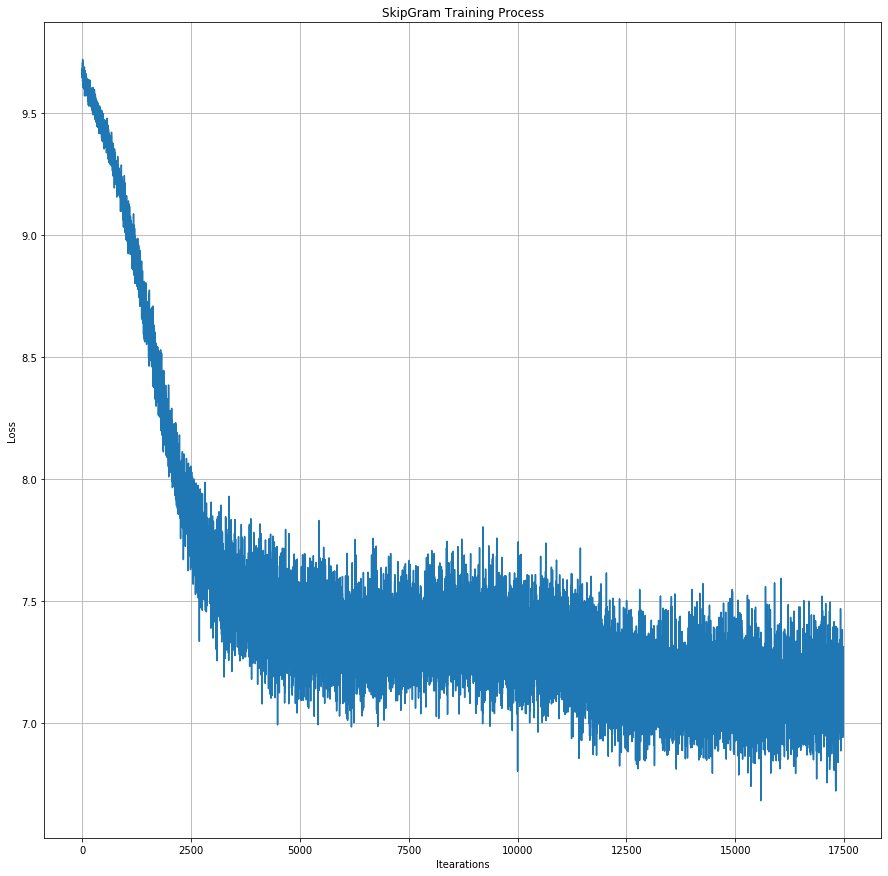

In [132]:
plt.title('SkipGram Training Process')
plt.xlabel('Itearations')
plt.ylabel('Loss')
plt.grid()
plt.plot(losses)

In [133]:
# проверка, что хоть что-то выучилось
assert np.mean(losses[-1000:]) < 7.5

In [137]:
embedding_matrix = model.in_embedding.weight.detach()

In [138]:
def cos_sim(embedding_matrix, token2id, word1, word2):
    
    i1 = token2id[word1]
    i2 = token2id[word2]
    
    v1, v2 = embedding_matrix[i1], embedding_matrix[i2]
    
    v1_n = v1.div(v1.norm(keepdim=True))
    v2_n = v2.div(v2.norm(keepdim=True))
    
    similarity = torch.dot(v1_n, v2_n).item()
    
    return similarity

# Косинусная близость
От 0 до 1, где 0 - вектора абсолютно разные, где 1 - идентичные.

In [139]:
cos_sim(embedding_matrix, word2index, 'день', 'месяц')

0.7635709643363953

In [140]:
cos_sim(embedding_matrix, word2index, 'минута', 'месяц')

0.6532252430915833

In [141]:
cos_sim(embedding_matrix, word2index, 'сотрудник', 'сотрудница')

0.6931652426719666

In [142]:
cos_sim(embedding_matrix, word2index, 'вклад', 'перевод')

0.5963195562362671

In [143]:
random_word = random.choice(list(word2index.keys()))
sim = cos_sim(embedding_matrix, word2index, 'день', random_word)
'Косинусная близость слова "день" к случайному выбраному слову "{}" равна {:.3f}'.format(random_word, sim)

'Косинусная близость слова "день" к случайному выбраному слову "затем" равна 0.488'

In [144]:
freq = {}

for text in corpus:
    for token in text:
        if token in freq:
            freq[token] += 1
        else:
            freq[token] = 1

In [145]:
sorted_freq = [(k, freq[k]) for k in sorted(freq, key=freq.get, reverse=True)]
top_sorted_freq = sorted_freq[0:200]

In [146]:
tsne = TSNE(n_components=2, init='pca', random_state=42, verbose=2)
reduced = tsne.fit_transform(embedding_matrix)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 13076 samples in 0.018s...
[t-SNE] Computed neighbors for 13076 samples in 10.317s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13076
[t-SNE] Computed conditional probabilities for sample 2000 / 13076
[t-SNE] Computed conditional probabilities for sample 3000 / 13076
[t-SNE] Computed conditional probabilities for sample 4000 / 13076
[t-SNE] Computed conditional probabilities for sample 5000 / 13076
[t-SNE] Computed conditional probabilities for sample 6000 / 13076
[t-SNE] Computed conditional probabilities for sample 7000 / 13076
[t-SNE] Computed conditional probabilities for sample 8000 / 13076
[t-SNE] Computed conditional probabilities for sample 9000 / 13076
[t-SNE] Computed conditional probabilities for sample 10000 / 13076
[t-SNE] Computed conditional probabilities for sample 11000 / 13076
[t-SNE] Computed conditional probabilities for sample 12000 / 13076
[t-SNE] Computed conditional probabilities for sa

In [147]:
top_words = [a for a,_ in top_sorted_freq]

In [148]:
inds = [word2index[word] for word in top_words]
x_coords = [coords[0] for coords in reduced[inds]]
y_coords = [coords[1] for coords in reduced[inds]]

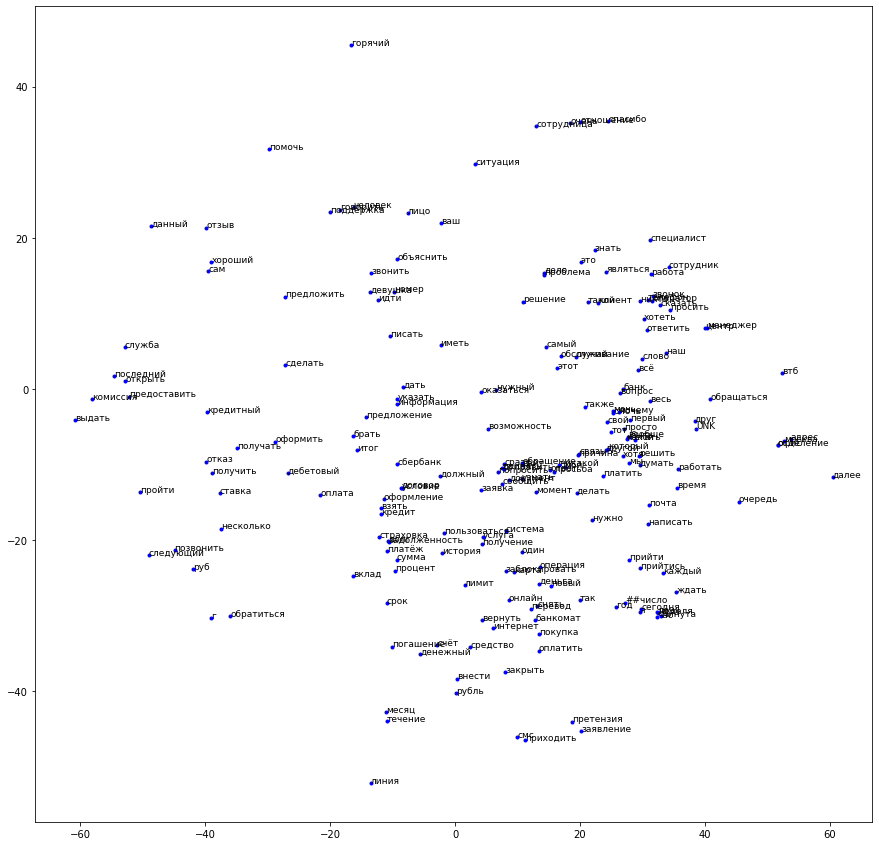

In [149]:
for (x, y, word) in zip(x_coords, y_coords, top_words):
    plt.scatter(x, y, marker='.', color='blue')
    plt.text(x+0.01, y+0.01, word, fontsize=9)
plt.show()